Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
Version = "v23" # Feature engineering based on Feature importance: TOP100→PCA→UMAP

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Select TOP100 features based on feature importance(version 8 notebook)

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [37]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [38]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [39]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=3, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 3)


In [40]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [41]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [42]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [43]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [44]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [45]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245,5.091474,-0.035213,-2.433609
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131,5.321547,0.946833,-1.724076
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201,5.774904,-1.121548,-1.713106
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528,5.921812,0.705828,-2.804410
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478,3.006182,2.118040,-1.927371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756,5.191202,-1.702065,-2.204271
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776,5.837644,-3.596087,0.594535
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805,4.726034,3.843743,2.765187
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140,5.149576,-1.921457,-1.406414


In [46]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245,5.091474,-0.035213,-2.433609
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131,5.321547,0.946833,-1.724076
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201,5.774904,-1.121548,-1.713106
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528,5.921812,0.705828,-2.804410
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478,3.006182,2.118040,-1.927371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756,5.191202,-1.702065,-2.204271
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776,5.837644,-3.596087,0.594535
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805,4.726034,3.843743,2.765187
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140,5.149576,-1.921457,-1.406414


In [47]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245,5.091474,-0.035213,-2.433609
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131,5.321547,0.946833,-1.724076
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201,5.774904,-1.121548,-1.713106
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528,5.921812,0.705828,-2.804410
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478,3.006182,2.118040,-1.927371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756,5.191202,-1.702065,-2.204271
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776,5.837644,-3.596087,0.594535
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805,4.726034,3.843743,2.765187
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140,5.149576,-1.921457,-1.406414


In [48]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [49]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [50]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887332	valid_1's binary_logloss: 0.151936
[200]	training's binary_logloss: 0.0190589	valid_1's binary_logloss: 0.0718987
[300]	training's binary_logloss: 0.00664033	valid_1's binary_logloss: 0.0519656
[400]	training's binary_logloss: 0.00363691	valid_1's binary_logloss: 0.0458108
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00314601	valid_1's binary_logloss: 0.0442937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093305	valid_1's binary_logloss: 0.158441
[200]	training's binary_logloss: 0.0204369	valid_1's binary_logloss: 0.0671401
[300]	training's binary_logloss: 0.00721313	valid_1's binary_logloss: 0.0431452
[400]	training's binary_logloss: 0.00401426	valid_1's binary_logloss: 0.0353138
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00322213	valid_1's binary_logloss: 0.0328065


Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.00502 Vs.target_rate: 0.00071, Num_p_label: 20.0, conf_0:0.00035, conf_1:0.69531
Num_p_label: 20.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841488	valid_1's binary_logloss: 0.150145
[200]	training's binary_logloss: 0.0175519	valid_1's binary_logloss: 0.0721999
[300]	training's binary_logloss: 0.00626549	valid_1's binary_logloss: 0.0515679
[400]	training's binary_logloss: 0.00350902	valid_1's binary_logloss: 0.0451893
[500]	training's binary_logloss: 0.00255037	valid_1's binary_logloss: 0.0414088
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00239175	valid_1's binary_logloss: 0.0405075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08573	valid_1's binary_logloss: 0.163276
[200]	training's binary_logloss: 0.0176394	valid_1's binary_logloss: 0.0788204
[300]	training's binary_logloss: 0.00608938	valid_1's binary_logloss: 0.0567118
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00366927	valid_1's binary_logloss: 0.050381


Remove_noisy_labels: 15 → positive_corect_labels: 500.0/973
p_label_rate: 0.00276 Vs.target_rate: 0.00071, Num_p_label: 11.0, conf_0:0.00049, conf_1:0.69659
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_1: 0.74
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_2: 0.78
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_4: 0.86
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_5: 0.90
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_6: 0.94
Num_p_label: 3.0, Expected: 2.8, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806699	valid_1's binary_logloss: 0.128579
[200]	training's binary_logloss: 0.0168943	valid_1's binary_logloss: 0.0540996
[300]	training's binary_logloss: 0.00604652	valid_1's binary_logloss: 0.0358168
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00371052	valid_1's binary_logloss: 0.0307985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826379	valid_1's binary_logloss: 0.149876
[200]	training's binary_logloss: 0.0171291	valid_1's binary_logloss: 0.0614195
[300]	training's binary_logloss: 0.00594463	valid_1's binary_logloss: 0.0389714
[400]	training's binary_logloss: 0.00332312	valid_1's binary_logloss: 0.0304628


Remove_noisy_labels: 8 → positive_corect_labels: 500.0/965
p_label_rate: 0.00075 Vs.target_rate: 0.00071, Num_p_label: 3.0, conf_0:0.00056, conf_1:0.69794
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00314968	valid_1's binary_logloss: 0.0296212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287965	valid_1's binary_logloss: 0.0477615
[200]	training's binary_logloss: 0.00366706	valid_1's binary_logloss: 0.0196532
[300]	training's binary_logloss: 0.000904787	valid_1's binary_logloss: 0.0128229
[400]	training's binary_logloss: 0.000432015	valid_1's binary_logloss: 0.00999257
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000349324	valid_1's binary_logloss: 0.00925241


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033024	valid_1's binary_logloss: 0.0416374
[200]	training's binary_logloss: 0.00402123	valid_1's binary_logloss: 0.0149463
[300]	training's binary_logloss: 0.000917767	valid_1's binary_logloss: 0.0100535
[400]	training's binary_logloss: 0.000416665	valid_1's binary_logloss: 0.00828483
[500]	training's binary_logloss: 0.000285281	valid_1's binary_logloss: 0.00764154
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000260199	valid_1's binary_logloss: 0.00750088


5-alpha_reductase_inhibitor logloss: 0.008376822532340051
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790972	valid_1's binary_logloss: 0.157648
[200]	training's binary_logloss: 0.0144557	valid_1's binary_logloss: 0.0944759
[300]	training's binary_logloss: 0.00499105	valid_1's binary_logloss: 0.0794425
[400]	training's binary_logloss: 0.00293982	valid_1's binary_logloss: 0.0721518
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00300818	valid_1's binary_logloss: 0.0717145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876237	valid_1's binary_logloss: 0.146268
[200]	training's binary_logloss: 0.0175818	valid_1's binary_logloss: 0.0731034


Remove_noisy_labels: 24 → positive_corect_labels: 498/976
p_label_rate: 0.05851 Vs.target_rate: 0.00076, Num_p_label: 233.0, conf_0:0.00119, conf_1:0.68101
Num_p_label: 233.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 197.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 178.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 153.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 129.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 45.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00655654	valid_1's binary_logloss: 0.0548152


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738885	valid_1's binary_logloss: 0.121195
[200]	training's binary_logloss: 0.0139275	valid_1's binary_logloss: 0.0673721
[300]	training's binary_logloss: 0.00482736	valid_1's binary_logloss: 0.0568791
[400]	training's binary_logloss: 0.00279898	valid_1's binary_logloss: 0.0519946
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00254666	valid_1's binary_logloss: 0.0510622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762886	valid_1's binary_logloss: 0.122397
[200]	training's binary_logloss: 0.0142073	valid_1's binary_logloss: 0.0522821
[300]	training's binary_logloss: 0.00490792	valid_1's binary_logloss: 0.0353116
[400]	training's binary_logloss: 0.00279983	valid_1's binary_logloss: 0.0296471
[500]	training's binary_logloss: 0.00215508	valid_1's binary_logloss: 0.0265359
Early stopping, best iteration is:
[587]	training

Remove_noisy_labels: 11 → positive_corect_labels: 496.0/965
p_label_rate: 0.01532 Vs.target_rate: 0.00076, Num_p_label: 61.0, conf_0:0.00036, conf_1:0.69392
Num_p_label: 61.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713849	valid_1's binary_logloss: 0.108074
[200]	training's binary_logloss: 0.013856	valid_1's binary_logloss: 0.0502956
[300]	training's binary_logloss: 0.00475143	valid_1's binary_logloss: 0.0359146
[400]	training's binary_logloss: 0.00277732	valid_1's binary_logloss: 0.0306076
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00281215	valid_1's binary_logloss: 0.0305686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728887	valid_1's binary_logloss: 0.112932
[200]	training's binary_logloss: 0.013412	valid_1's binary_logloss: 0.044774
[300]	training's binary_logloss: 0.00461416	valid_1's binary_logloss: 0.0296435
[400]	training's binary_logloss: 0.00269476	valid_1's binary_logloss: 0.0249686
[500]	training's binary_logloss: 0.00205303	valid_1's binary_logloss: 0.0228733
Early stopping, best iteration is:
[561]	training's 

Remove_noisy_labels: 8 → positive_corect_labels: 495.0/957
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00053, conf_1:0.69440
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254262	valid_1's binary_logloss: 0.0441434
[200]	training's binary_logloss: 0.00353803	valid_1's binary_logloss: 0.0250272
[300]	training's binary_logloss: 0.000939433	valid_1's binary_logloss: 0.0211865
[400]	training's binary_logloss: 0.000471194	valid_1's binary_logloss: 0.0201239
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000423464	valid_1's binary_logloss: 0.0200182


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273859	valid_1's binary_logloss: 0.0410406
[200]	training's binary_logloss: 0.00392812	valid_1's binary_logloss: 0.0196138
[300]	training's binary_logloss: 0.00103305	valid_1's binary_logloss: 0.0155159
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000704115	valid_1's binary_logloss: 0.0148737


11-beta-hsd1_inhibitor logloss: 0.017446464653997632
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101709	valid_1's binary_logloss: 0.183362
[200]	training's binary_logloss: 0.0226565	valid_1's binary_logloss: 0.102203
[300]	training's binary_logloss: 0.00796639	valid_1's binary_logloss: 0.079514
[400]	training's binary_logloss: 0.0042227	valid_1's binary_logloss: 0.0693259
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00310009	valid_1's binary_logloss: 0.0643138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103844	valid_1's binary_logloss: 0.194047
[200]	training's binary_logloss: 0.0236408	valid_1's binary_logloss: 0.115114
[300]	training's binary_logloss: 0.0080568	valid_1's binary_logloss: 0.0880633


Remove_noisy_labels: 29 → positive_corect_labels: 492/971
p_label_rate: 0.00728 Vs.target_rate: 0.00101, Num_p_label: 29.0, conf_0:0.00077, conf_1:0.61886
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00424097	valid_1's binary_logloss: 0.0782799
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00424097	valid_1's binary_logloss: 0.0782799


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950782	valid_1's binary_logloss: 0.165429
[200]	training's binary_logloss: 0.0209727	valid_1's binary_logloss: 0.0896348
[300]	training's binary_logloss: 0.00717535	valid_1's binary_logloss: 0.071331
[400]	training's binary_logloss: 0.00387759	valid_1's binary_logloss: 0.0642819
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00395056	valid_1's binary_logloss: 0.0641348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957039	valid_1's binary_logloss: 0.178425
[200]	training's binary_logloss: 0.0209228	valid_1's binary_logloss: 0.103193
[300]	training's binary_logloss: 0.00719178	valid_1's binary_logloss: 0.0795486
[400]	training's binary_logloss: 0.00393304	valid_1's binary_logloss: 0.0699449
[500]	training's binary_logloss: 0.00278125	valid_1's binary_logloss: 0.0661248


Remove_noisy_labels: 24 → positive_corect_labels: 489.0/947
p_label_rate: 0.00603 Vs.target_rate: 0.00101, Num_p_label: 24.0, conf_0:0.00061, conf_1:0.67551
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00253267	valid_1's binary_logloss: 0.0648737


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900443	valid_1's binary_logloss: 0.166863
[200]	training's binary_logloss: 0.0187995	valid_1's binary_logloss: 0.0869928
[300]	training's binary_logloss: 0.00637378	valid_1's binary_logloss: 0.0659274
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00370934	valid_1's binary_logloss: 0.0592629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868088	valid_1's binary_logloss: 0.154646
[200]	training's binary_logloss: 0.0188108	valid_1's binary_logloss: 0.0732978
[300]	training's binary_logloss: 0.00659177	valid_1's binary_logloss: 0.0490463
[400]	training's binary_logloss: 0.00367642	valid_1's binary_logloss: 0.0419808


Remove_noisy_labels: 19 → positive_corect_labels: 488.0/928
p_label_rate: 0.00452 Vs.target_rate: 0.00101, Num_p_label: 18.0, conf_0:0.00058, conf_1:0.68825
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.94


[500]	training's binary_logloss: 0.00266584	valid_1's binary_logloss: 0.037318
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00235111	valid_1's binary_logloss: 0.0352318


Num_p_label: 1.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289224	valid_1's binary_logloss: 0.0500774
[200]	training's binary_logloss: 0.00407143	valid_1's binary_logloss: 0.0248781
[300]	training's binary_logloss: 0.000996287	valid_1's binary_logloss: 0.0175101
[400]	training's binary_logloss: 0.000452486	valid_1's binary_logloss: 0.0140026
[500]	training's binary_logloss: 0.000310921	valid_1's binary_logloss: 0.0125809


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000267911	valid_1's binary_logloss: 0.012135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270717	valid_1's binary_logloss: 0.0424135
[200]	training's binary_logloss: 0.00368462	valid_1's binary_logloss: 0.0217143


acat_inhibitor logloss: 0.01346278935934496


[300]	training's binary_logloss: 0.000940998	valid_1's binary_logloss: 0.0153536
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000765134	valid_1's binary_logloss: 0.0147858


acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274153	valid_1's binary_logloss: 0.592099
[200]	training's binary_logloss: 0.134029	valid_1's binary_logloss: 0.568725
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.131724	valid_1's binary_logloss: 0.56851
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 290 → positive_corect_labels: 370/710
p_label_rate: 0.23154 Vs.target_rate: 0.00798, Num_p_label: 922.0, conf_0:0.20289, conf_1:0.59854


[100]	training's binary_logloss: 0.272362	valid_1's binary_logloss: 0.592392
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.165409	valid_1's binary_logloss: 0.575068


Num_p_label: 922.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 664.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 484.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 330.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 204.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 118.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 31.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225938	valid_1's binary_logloss: 0.438568
[200]	training's binary_logloss: 0.0940111	valid_1's binary_logloss: 0.359993
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0507691	valid_1's binary_logloss: 0.334858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19296	valid_1's binary_logloss: 0.464155


Remove_noisy_labels: 123 → positive_corect_labels: 319.0/587
p_label_rate: 0.06303 Vs.target_rate: 0.00798, Num_p_label: 251.0, conf_0:0.01856, conf_1:0.67903
Num_p_label: 251.0, Expected: 31.8, Adj_threshold_1: 0.78
Num_p_label: 173.0, Expected: 31.8, Adj_threshold_2: 0.82
Num_p_label: 108.0, Expected: 31.8, Adj_threshold_3: 0.86
Num_p_label: 42.0, Expected: 31.8, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0728784	valid_1's binary_logloss: 0.429075
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0659531	valid_1's binary_logloss: 0.42477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185416	valid_1's binary_logloss: 0.351056
[200]	training's binary_logloss: 0.0643068	valid_1's binary_logloss: 0.261084
[300]	training's binary_logloss: 0.0275999	valid_1's binary_logloss: 0.224062
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0229978	valid_1's binary_logloss: 0.21977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176071	valid_1's binary_logloss: 0.343194
[200]	training's binary_logloss: 0.0605612	valid_1's binary_logloss: 0.261831
[300]	training's binary_logloss: 0.0266808	valid_1's binary_logloss: 0.231662


Remove_noisy_labels: 56 → positive_corect_labels: 306.0/531
p_label_rate: 0.04797 Vs.target_rate: 0.00798, Num_p_label: 191.0, conf_0:0.00383, conf_1:0.69634
Num_p_label: 191.0, Expected: 31.8, Adj_threshold_1: 0.90
Num_p_label: 110.0, Expected: 31.8, Adj_threshold_2: 0.94
Num_p_label: 24.0, Expected: 31.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 2256
len(valid_index) : 2257
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0171898	valid_1's binary_logloss: 0.220461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441647	valid_1's binary_logloss: 0.0862576
[200]	training's binary_logloss: 0.00850172	valid_1's binary_logloss: 0.0635136


len(train_index) : 2257
len(valid_index) : 2256
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00227333	valid_1's binary_logloss: 0.0575105
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00215999	valid_1's binary_logloss: 0.0572265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424969	valid_1's binary_logloss: 0.0781053
[200]	training's binary_logloss: 0.00845679	valid_1's binary_logloss: 0.0527925


acetylcholine_receptor_agonist logloss: 0.0527298668484996
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00328676	valid_1's binary_logloss: 0.0482313
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 423 → positive_corect_labels: 297/577
p_label_rate: 0.13687 Vs.target_rate: 0.01264, Num_p_label: 545.0, conf_0:0.52585, conf_1:0.50397
Num_p_label: 545.0, Expected: 50.3, Adj_threshold_1: 0.50


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.394555	valid_1's binary_logloss: 0.675936
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.399307	valid_1's binary_logloss: 0.664791


Num_p_label: 233.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 72.0, Expected: 50.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:72.0/3982, p_label_rate: 0.01808
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196668	valid_1's binary_logloss: 0.404081
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0989293	valid_1's binary_logloss: 0.366671


Remove_noisy_labels: 138 → positive_corect_labels: 228.0/625
p_label_rate: 0.00904 Vs.target_rate: 0.01264, Num_p_label: 36.0, conf_0:0.03068, conf_1:0.58798
threshold:0.58, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175731	valid_1's binary_logloss: 0.420339
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.160957	valid_1's binary_logloss: 0.418163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12172	valid_1's binary_logloss: 0.294917
[200]	training's binary_logloss: 0.0380828	valid_1's binary_logloss: 0.250491
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0223113	valid_1's binary_logloss: 0.241198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146519	valid_1's binary_logloss: 0.259838


Remove_noisy_labels: 52 → positive_corect_labels: 205.0/573
p_label_rate: 0.01231 Vs.target_rate: 0.01264, Num_p_label: 49.0, conf_0:0.00254, conf_1:0.67909
threshold:0.58, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 2191
len(valid_index) : 2191
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0484309	valid_1's binary_logloss: 0.204917
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0331479	valid_1's binary_logloss: 0.195453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455894	valid_1's binary_logloss: 0.11969
[200]	training's binary_logloss: 0.0127219	valid_1's binary_logloss: 0.108253
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00996454	valid_1's binary_logloss: 0.107531


len(train_index) : 2191
len(valid_index) : 2191
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430842	valid_1's binary_logloss: 0.109403


acetylcholine_receptor_antagonist logloss: 0.10265457566265833
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0114226	valid_1's binary_logloss: 0.0977783
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0114226	valid_1's binary_logloss: 0.0977783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216404	valid_1's binary_logloss: 0.387854
[200]	training's binary_logloss: 0.0846069	valid_1's binary_logloss: 0.301783
[300]	training's binary_logloss: 0.0359706	valid_1's binary_logloss: 0.265431
[400]	training's binary_logloss: 0.0177409	valid_1's binary_logloss: 0.249783
[500]	training's binary_logloss: 0.0104452	valid_1's binary_logloss: 0.240607
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00783452	valid_1's binary_logloss: 0.23638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191909	valid_1's binary_logloss: 0.378974
[200]	training's binary_logloss: 0.0729589	valid_1's binary_logloss: 0.298405
[300]	training's binary_logl

Remove_noisy_labels: 85 → positive_corect_labels: 477/915
p_label_rate: 0.16072 Vs.target_rate: 0.00307, Num_p_label: 640.0, conf_0:0.00208, conf_1:0.69250
Num_p_label: 640.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 549.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 488.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 404.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 338.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 277.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 218.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 170.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 118.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165896	valid_1's binary_logloss: 0.319138
[200]	training's binary_logloss: 0.0557007	valid_1's binary_logloss: 0.231399
[300]	training's binary_logloss: 0.0225116	valid_1's binary_logloss: 0.201817
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0152591	valid_1's binary_logloss: 0.193594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182035	valid_1's binary_logloss: 0.330736
[200]	training's binary_logloss: 0.063327	valid_1's binary_logloss: 0.2318
[300]	training's binary_logloss: 0.0249687	valid_1's binary_logloss: 0.183766
[400]	training's binary_logloss: 0.0122442	valid_1's binary_logloss: 0.156896
[500]	training's binary_logloss: 0.00763588	valid_1's binary_logloss: 0.143715
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00763588	valid_1's binary_logloss: 0.143715


Remove_noisy_labels: 56 → positive_corect_labels: 466.0/859
p_label_rate: 0.08388 Vs.target_rate: 0.00307, Num_p_label: 334.0, conf_0:0.00163, conf_1:0.69870
Num_p_label: 334.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 212.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160993	valid_1's binary_logloss: 0.289428
[200]	training's binary_logloss: 0.0522625	valid_1's binary_logloss: 0.18828
[300]	training's binary_logloss: 0.0211096	valid_1's binary_logloss: 0.145569
[400]	training's binary_logloss: 0.0105701	valid_1's binary_logloss: 0.13076
[500]	training's binary_logloss: 0.00665148	valid_1's binary_logloss: 0.121626
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00645424	valid_1's binary_logloss: 0.121424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144305	valid_1's binary_logloss: 0.32061


Remove_noisy_labels: 60 → positive_corect_labels: 444.0/799
p_label_rate: 0.00000 Vs.target_rate: 0.00307, Num_p_label: 0.0, conf_0:0.00287, conf_1:0.69886
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_1: 1.02
Num_p_label: 146.0, Expected: 12.2, Adj_threshold_2: 0.98


[200]	training's binary_logloss: 0.0438787	valid_1's binary_logloss: 0.235088
[300]	training's binary_logloss: 0.0171083	valid_1's binary_logloss: 0.212576
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0177822	valid_1's binary_logloss: 0.212447


threshold:0.98, positive p_label:146.0/3982, p_label_rate: 0.03666
len(train_index) : 2390
len(valid_index) : 2391
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734903	valid_1's binary_logloss: 0.137182
[200]	training's binary_logloss: 0.0159854	valid_1's binary_logloss: 0.0955002
[300]	training's binary_logloss: 0.00475688	valid_1's binary_logloss: 0.0848339
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00403473	valid_1's binary_logloss: 0.0837896


len(train_index) : 2391
len(valid_index) : 2390
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694255	valid_1's binary_logloss: 0.129218
[200]	training's binary_logloss: 0.018603	valid_1's binary_logloss: 0.0848066
[300]	training's binary_logloss: 0.00578212	valid_1's binary_logloss: 0.0748776
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00501854	valid_1's binary_logloss: 0.0737077


acetylcholinesterase_inhibitor logloss: 0.07874972665572068
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181638	valid_1's binary_logloss: 0.318404
[200]	training's binary_logloss: 0.0618792	valid_1's binary_logloss: 0.209872
[300]	training's binary_logloss: 0.0251318	valid_1's binary_logloss: 0.162087
[400]	training's binary_logloss: 0.0122286	valid_1's binary_logloss: 0.141676
[500]	training's binary_logloss: 0.00736718	valid_1's binary_logloss: 0.131867
[600]	training's binary_logloss: 0.00526554	valid_1's binary_logloss: 0.12618
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00524822	valid_1's binary_logloss: 0.126117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167711	valid_1's binary_logloss: 0.345938
[200]	training's binary_logloss: 0.055227	valid_1's binary_logloss: 0.25909
[300]	training's binary_logloss: 0.0207776	valid_1's binary_logloss: 0.235642


Remove_noisy_labels: 68 → positive_corect_labels: 480/932
p_label_rate: 0.00929 Vs.target_rate: 0.00227, Num_p_label: 37.0, conf_0:0.00168, conf_1:0.54449
Num_p_label: 37.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0145902	valid_1's binary_logloss: 0.224271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158011	valid_1's binary_logloss: 0.292883
[200]	training's binary_logloss: 0.0504173	valid_1's binary_logloss: 0.176966
[300]	training's binary_logloss: 0.0193225	valid_1's binary_logloss: 0.127802
[400]	training's binary_logloss: 0.00973436	valid_1's binary_logloss: 0.103599
[500]	training's binary_logloss: 0.00612972	valid_1's binary_logloss: 0.0934693
[600]	training's binary_logloss: 0.00454023	valid_1's binary_logloss: 0.0874305
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00431944	valid_1's binary_logloss: 0.0864388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152198	valid_1's binary_logloss: 0.309697
[200]	training's binary_logloss: 0.0466927	valid_1's binary_logloss: 0.21681
[300]	training's binary_

Remove_noisy_labels: 39 → positive_corect_labels: 473.0/893
p_label_rate: 0.01507 Vs.target_rate: 0.00227, Num_p_label: 60.0, conf_0:0.00231, conf_1:0.68469
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_1: 0.62
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_2: 0.66
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_3: 0.70
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_4: 0.74
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_5: 0.78
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0119622	valid_1's binary_logloss: 0.177805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13682	valid_1's binary_logloss: 0.289673
[200]	training's binary_logloss: 0.0392045	valid_1's binary_logloss: 0.189744
[300]	training's binary_logloss: 0.0146927	valid_1's binary_logloss: 0.150671
[400]	training's binary_logloss: 0.00754655	valid_1's binary_logloss: 0.138415
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.0054405	valid_1's binary_logloss: 0.130964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142846	valid_1's binary_logloss: 0.264685
[200]	training's binary_logloss: 0.0424937	valid_1's binary_logloss: 0.166929
[300]	training's binary_logloss: 0.0165238	valid_1's binary_logloss: 0.133845


Remove_noisy_labels: 42 → positive_corect_labels: 465.0/851
p_label_rate: 0.00653 Vs.target_rate: 0.00227, Num_p_label: 26.0, conf_0:0.00114, conf_1:0.66673
threshold:0.82, positive p_label:26.0/3982, p_label_rate: 0.00653


[400]	training's binary_logloss: 0.00841053	valid_1's binary_logloss: 0.119598
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00671129	valid_1's binary_logloss: 0.116679


len(train_index) : 2416
len(valid_index) : 2417
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531802	valid_1's binary_logloss: 0.0966249
[200]	training's binary_logloss: 0.00872667	valid_1's binary_logloss: 0.0562527
[300]	training's binary_logloss: 0.00216286	valid_1's binary_logloss: 0.0444676
[400]	training's binary_logloss: 0.000886705	valid_1's binary_logloss: 0.0411937
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000588036	valid_1's binary_logloss: 0.0399594


len(train_index) : 2417
len(valid_index) : 2416
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475568	valid_1's binary_logloss: 0.0896051
[200]	training's binary_logloss: 0.0084388	valid_1's binary_logloss: 0.0592486
[300]	training's binary_logloss: 0.00214232	valid_1's binary_logloss: 0.0518602
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00144958	valid_1's binary_logloss: 0.0507487


adenosine_receptor_agonist logloss: 0.04535295034335375
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219907	valid_1's binary_logloss: 0.45044
[200]	training's binary_logloss: 0.0877344	valid_1's binary_logloss: 0.37342
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0468838	valid_1's binary_logloss: 0.345128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22522	valid_1's binary_logloss: 0.463105
[200]	training's binary_logloss: 0.0904681	valid_1's binary_logloss: 0.403046
[300]	training's binary_logloss: 0.0406241	valid_1's binary_logloss: 0.384793


Remove_noisy_labels: 140 → positive_corect_labels: 439/860
p_label_rate: 0.04093 Vs.target_rate: 0.00403, Num_p_label: 163.0, conf_0:0.01853, conf_1:0.66291
Num_p_label: 163.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 134.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 101.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 16.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0316895	valid_1's binary_logloss: 0.380995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179295	valid_1's binary_logloss: 0.357402
[200]	training's binary_logloss: 0.0616821	valid_1's binary_logloss: 0.269854
[300]	training's binary_logloss: 0.025862	valid_1's binary_logloss: 0.237795
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0153418	valid_1's binary_logloss: 0.229373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177371	valid_1's binary_logloss: 0.354482
[200]	training's binary_logloss: 0.0616249	valid_1's binary_logloss: 0.26447
[300]	training's binary_logloss: 0.0255689	valid_1's binary_logloss: 0.236376
[400]	training's binary_logloss: 0.0130421	valid_1's binary_logloss: 0.223645


Remove_noisy_labels: 70 → positive_corect_labels: 414.0/790
p_label_rate: 0.04395 Vs.target_rate: 0.00403, Num_p_label: 175.0, conf_0:0.00323, conf_1:0.69349
Num_p_label: 175.0, Expected: 16.1, Adj_threshold_1: 0.78
Num_p_label: 142.0, Expected: 16.1, Adj_threshold_2: 0.82
Num_p_label: 116.0, Expected: 16.1, Adj_threshold_3: 0.86
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_4: 0.90


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0103263	valid_1's binary_logloss: 0.219829


Num_p_label: 44.0, Expected: 16.1, Adj_threshold_5: 0.94
Num_p_label: 8.0, Expected: 16.1, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164207	valid_1's binary_logloss: 0.301477
[200]	training's binary_logloss: 0.0537157	valid_1's binary_logloss: 0.202202
[300]	training's binary_logloss: 0.0211295	valid_1's binary_logloss: 0.170325
[400]	training's binary_logloss: 0.010827	valid_1's binary_logloss: 0.159587
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00941778	valid_1's binary_logloss: 0.157544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156817	valid_1's binary_logloss: 0.31203
[200]	training's binary_logloss: 0.0504996	valid_1's binary_logloss: 0.217066
[300]	training's binary_logloss: 0.0205209	valid_1's binary_logloss: 0.177961
[400]	training's binary_logloss: 0.0106465	valid_1's binary_logloss: 0.165344
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00709639	valid_1's binary_logloss: 0.158657


Remove_noisy_labels: 47 → positive_corect_labels: 400.0/743
p_label_rate: 0.00653 Vs.target_rate: 0.00403, Num_p_label: 26.0, conf_0:0.00206, conf_1:0.69913
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2362
len(valid_index) : 2363
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442792	valid_1's binary_logloss: 0.0944975
[200]	training's binary_logloss: 0.00802482	valid_1's binary_logloss: 0.063035
[300]	training's binary_logloss: 0.00210096	valid_1's binary_logloss: 0.0553302


len(train_index) : 2363
len(valid_index) : 2362
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00130568	valid_1's binary_logloss: 0.0536791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524713	valid_1's binary_logloss: 0.0761052
[200]	training's binary_logloss: 0.0102875	valid_1's binary_logloss: 0.0443126
[300]	training's binary_logloss: 0.00267584	valid_1's binary_logloss: 0.0356324


adenosine_receptor_antagonist logloss: 0.04394199839355693


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00163678	valid_1's binary_logloss: 0.0342007


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950259	valid_1's binary_logloss: 0.169929
[200]	training's binary_logloss: 0.0215238	valid_1's binary_logloss: 0.0943866
[300]	training's binary_logloss: 0.00725863	valid_1's binary_logloss: 0.0701958
[400]	training's binary_logloss: 0.00386908	valid_1's binary_logloss: 0.0598134
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00326876	valid_1's binary_logloss: 0.0565095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979989	valid_1's binary_logloss: 0.175518
[200]	training's binary_logloss: 0.0205628	valid_1's binary_logloss: 0.1003


Remove_noisy_labels: 24 → positive_corect_labels: 494/976
p_label_rate: 0.05249 Vs.target_rate: 0.00076, Num_p_label: 209.0, conf_0:0.00144, conf_1:0.68845
Num_p_label: 209.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 183.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 144.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 101.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 51.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0069202	valid_1's binary_logloss: 0.0849603
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00741306	valid_1's binary_logloss: 0.0845306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903444	valid_1's binary_logloss: 0.168808
[200]	training's binary_logloss: 0.0188834	valid_1's binary_logloss: 0.0832155
[300]	training's binary_logloss: 0.0063476	valid_1's binary_logloss: 0.0586553
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00589279	valid_1's binary_logloss: 0.0577259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911834	valid_1's binary_logloss: 0.163592
[200]	training's binary_logloss: 0.0189288	valid_1's binary_logloss: 0.0782355
[300]	training's binary_logloss: 0.00655353	valid_1's binary_logloss: 0.0556986
[400]	training's binary_logloss: 0.00358396	valid_1's binary_logloss: 0.0463984
[500]	training's

Remove_noisy_labels: 18 → positive_corect_labels: 493.0/958
p_label_rate: 0.00954 Vs.target_rate: 0.00076, Num_p_label: 38.0, conf_0:0.00104, conf_1:0.69308
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821	valid_1's binary_logloss: 0.154319
[200]	training's binary_logloss: 0.0167529	valid_1's binary_logloss: 0.0748614
[300]	training's binary_logloss: 0.0059279	valid_1's binary_logloss: 0.0522356
[400]	training's binary_logloss: 0.00331069	valid_1's binary_logloss: 0.0426213
[500]	training's binary_logloss: 0.00243264	valid_1's binary_logloss: 0.0384305
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00236114	valid_1's binary_logloss: 0.0380131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830402	valid_1's binary_logloss: 0.160976
[200]	training's binary_logloss: 0.0171956	valid_1's binary_logloss: 0.0807481
[300]	training's binary_logloss: 0.00604957	valid_1's binary_logloss: 0.0599063
[400]	training's binary_logloss: 0.00328487	valid_1's binary_logloss: 0.0511745
Early stopping, best iteration is:
[464]	training's b

Remove_noisy_labels: 14 → positive_corect_labels: 490.0/944
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00048, conf_1:0.69797
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249711	valid_1's binary_logloss: 0.0536978
[200]	training's binary_logloss: 0.00379459	valid_1's binary_logloss: 0.0317599


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 adenylyl_cyclase_activator=================================


[300]	training's binary_logloss: 0.00105372	valid_1's binary_logloss: 0.0266282
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000928083	valid_1's binary_logloss: 0.0263255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266441	valid_1's binary_logloss: 0.0484458
[200]	training's binary_logloss: 0.0041663	valid_1's binary_logloss: 0.0288311
[300]	training's binary_logloss: 0.00109494	valid_1's binary_logloss: 0.0239793
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000742074	valid_1's binary_logloss: 0.0228477


adenylyl_cyclase_activator logloss: 0.024586608971338436
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304046	valid_1's binary_logloss: 0.621863
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.277694	valid_1's binary_logloss: 0.619569


Remove_noisy_labels: 352 → positive_corect_labels: 323/648
p_label_rate: 0.20517 Vs.target_rate: 0.01134, Num_p_label: 817.0, conf_0:0.56761, conf_1:0.55357
Num_p_label: 817.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 465.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 222.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 106.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.418203	valid_1's binary_logloss: 0.651055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201993	valid_1's binary_logloss: 0.462082
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.101436	valid_1's binary_logloss: 0.418488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208256	valid_1's binary_logloss: 0.434884
[200]	training's binary_logloss: 0.0872957	valid_1's binary_logloss: 0.364967


Remove_noisy_labels: 125 → positive_corect_labels: 256.0/613
p_label_rate: 0.00829 Vs.target_rate: 0.01134, Num_p_label: 33.0, conf_0:0.00959, conf_1:0.64261
threshold:0.66, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0770852	valid_1's binary_logloss: 0.358538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156447	valid_1's binary_logloss: 0.365423
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0692374	valid_1's binary_logloss: 0.307956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157431	valid_1's binary_logloss: 0.31884


Remove_noisy_labels: 58 → positive_corect_labels: 221.0/555
p_label_rate: 0.01858 Vs.target_rate: 0.01134, Num_p_label: 74.0, conf_0:0.00704, conf_1:0.65920
threshold:0.66, positive p_label:74.0/3982, p_label_rate: 0.01858


[200]	training's binary_logloss: 0.0564762	valid_1's binary_logloss: 0.244501
[300]	training's binary_logloss: 0.0233596	valid_1's binary_logloss: 0.207181
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0206204	valid_1's binary_logloss: 0.203178


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625708	valid_1's binary_logloss: 0.142238
[200]	training's binary_logloss: 0.0221277	valid_1's binary_logloss: 0.12663
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0152273	valid_1's binary_logloss: 0.124903


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544084	valid_1's binary_logloss: 0.139834


adrenergic_receptor_agonist logloss: 0.12765572734015154
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0182729	valid_1's binary_logloss: 0.130644
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.019511	valid_1's binary_logloss: 0.130409
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.49439	valid_1's binary_logloss: 0.675436
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 411 → positive_corect_labels: 303/589
p_label_rate: 0.44927 Vs.target_rate: 0.01512, Num_p_label: 1789.0, conf_0:0.88131, conf_1:0.49370
Num_p_label: 1789.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 892.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 60.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:86.0/3982, p_label_rate: 0.02160
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.466896	valid_1's binary_logloss: 0.662528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864381	valid_1's binary_logloss: 0.231567
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0613572	valid_1's binary_logloss: 0.226552
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 216 → positive_corect_labels: 183.0/2305
p_label_rate: 0.00000 Vs.target_rate: 0.01512, Num_p_label: 0.0, conf_0:0.00903, conf_1:0.33723
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_2: 0.58


[100]	training's binary_logloss: 0.0897084	valid_1's binary_logloss: 0.251163
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0694383	valid_1's binary_logloss: 0.248911


Num_p_label: 0.0, Expected: 60.2, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_5: 0.46
Num_p_label: 7.0, Expected: 60.2, Adj_threshold_6: 0.42
Num_p_label: 13.0, Expected: 60.2, Adj_threshold_7: 0.38
Num_p_label: 32.0, Expected: 60.2, Adj_threshold_8: 0.34
Num_p_label: 55.0, Expected: 60.2, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:55.0/3982, p_label_rate: 0.01381
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256837	valid_1's binary_logloss: 0.0870859
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0076994	valid_1's binary_logloss: 0.0739723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261403	valid_1's binary_logloss: 0.0638032
[200]	training's binary_logloss: 0.00656603	valid_1's binary_logloss: 0.0454617


Remove_noisy_labels: 45 → positive_corect_labels: 142.0/2260
p_label_rate: 0.00126 Vs.target_rate: 0.01512, Num_p_label: 5.0, conf_0:0.00073, conf_1:0.62309
Num_p_label: 5.0, Expected: 60.2, Adj_threshold_1: 0.30
Num_p_label: 7.0, Expected: 60.2, Adj_threshold_2: 0.26
Num_p_label: 8.0, Expected: 60.2, Adj_threshold_3: 0.22


[300]	training's binary_logloss: 0.00266341	valid_1's binary_logloss: 0.0408782
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00215678	valid_1's binary_logloss: 0.0400743


Num_p_label: 11.0, Expected: 60.2, Adj_threshold_4: 0.18
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_5: 0.14
Num_p_label: 32.0, Expected: 60.2, Adj_threshold_6: 0.10
Num_p_label: 48.0, Expected: 60.2, Adj_threshold_7: 0.06
threshold:0.06, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 2187
len(valid_index) : 2187
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204226	valid_1's binary_logloss: 0.056003


len(train_index) : 2187
len(valid_index) : 2187
================================= fold 2/2 adrenergic_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00441204	valid_1's binary_logloss: 0.0454404
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0038269	valid_1's binary_logloss: 0.0452927
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_antagonist logloss: 0.0536967460096717
akt_inhibitor , len(trt) : 66


[100]	training's binary_logloss: 0.0169092	valid_1's binary_logloss: 0.0635746
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0105803	valid_1's binary_logloss: 0.0621008


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17664	valid_1's binary_logloss: 0.374617
[200]	training's binary_logloss: 0.0606353	valid_1's binary_logloss: 0.291443
[300]	training's binary_logloss: 0.0246448	valid_1's binary_logloss: 0.260466
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0170211	valid_1's binary_logloss: 0.254817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210234	valid_1's binary_logloss: 0.337775
[200]	training's binary_logloss: 0.0768575	valid_1's binary_logloss: 0.231291
[300]	training's binary_logloss: 0.0319531	valid_1's binary_logloss: 0.185567
[400]	training's binary_logloss: 0.015623	valid_1's binary_logloss: 0.166096
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00984622	valid_1's binary_logloss: 0.157745


Remove_noisy_labels: 91 → positive_corect_labels: 472/909
p_label_rate: 0.03541 Vs.target_rate: 0.00277, Num_p_label: 141.0, conf_0:0.00387, conf_1:0.65626
Num_p_label: 141.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 109.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170992	valid_1's binary_logloss: 0.323792
[200]	training's binary_logloss: 0.0557391	valid_1's binary_logloss: 0.209703
[300]	training's binary_logloss: 0.021937	valid_1's binary_logloss: 0.16825
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0123684	valid_1's binary_logloss: 0.150735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156796	valid_1's binary_logloss: 0.30673
[200]	training's binary_logloss: 0.0501169	valid_1's binary_logloss: 0.21043


Remove_noisy_labels: 57 → positive_corect_labels: 460.0/852
p_label_rate: 0.03742 Vs.target_rate: 0.00277, Num_p_label: 149.0, conf_0:0.00377, conf_1:0.69043
Num_p_label: 149.0, Expected: 11.0, Adj_threshold_1: 0.78
Num_p_label: 112.0, Expected: 11.0, Adj_threshold_2: 0.82
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_3: 0.86
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_4: 0.90
Num_p_label: 17.0, Expected: 11.0, Adj_threshold_5: 0.94
Num_p_label: 5.0, Expected: 11.0, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.0196489	valid_1's binary_logloss: 0.173999
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0182363	valid_1's binary_logloss: 0.173156


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155079	valid_1's binary_logloss: 0.293669
[200]	training's binary_logloss: 0.0480662	valid_1's binary_logloss: 0.18583
[300]	training's binary_logloss: 0.0185508	valid_1's binary_logloss: 0.146738
[400]	training's binary_logloss: 0.0093608	valid_1's binary_logloss: 0.127526
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00751591	valid_1's binary_logloss: 0.123969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142115	valid_1's binary_logloss: 0.263963
[200]	training's binary_logloss: 0.0412729	valid_1's binary_logloss: 0.164747
[300]	training's binary_logloss: 0.0159021	valid_1's binary_logloss: 0.126621


Remove_noisy_labels: 39 → positive_corect_labels: 450.0/813
p_label_rate: 0.00352 Vs.target_rate: 0.00277, Num_p_label: 14.0, conf_0:0.00207, conf_1:0.69730
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00828205	valid_1's binary_logloss: 0.115608
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00665012	valid_1's binary_logloss: 0.111193


len(train_index) : 2397
len(valid_index) : 2398
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602303	valid_1's binary_logloss: 0.11602
[200]	training's binary_logloss: 0.0105195	valid_1's binary_logloss: 0.0668786
[300]	training's binary_logloss: 0.00250248	valid_1's binary_logloss: 0.0531064


len(train_index) : 2398
len(valid_index) : 2397
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00109768	valid_1's binary_logloss: 0.0481935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581881	valid_1's binary_logloss: 0.0811115
[200]	training's binary_logloss: 0.0107044	valid_1's binary_logloss: 0.0395648
[300]	training's binary_logloss: 0.00269435	valid_1's binary_logloss: 0.0284502
[400]	training's binary_logloss: 0.00108408	valid_1's binary_logloss: 0.0244329
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000698393	valid_1's binary_logloss: 0.0233474


akt_inhibitor logloss: 0.03577301854478596
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984996	valid_1's binary_logloss: 0.154646
[200]	training's binary_logloss: 0.0221176	valid_1's binary_logloss: 0.0735702
[300]	training's binary_logloss: 0.00755206	valid_1's binary_logloss: 0.0521751
[400]	training's binary_logloss: 0.00399872	valid_1's binary_logloss: 0.0460703
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00339524	valid_1's binary_logloss: 0.0440509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983485	valid_1's binary_logloss: 0.168686
[200]	training's binary_logloss: 0.0203786	valid_1's binary_logloss: 0.0778927
[300]	training's binary_logloss: 0.00693443	valid_1's binary_logloss: 0.0550368
[400]	training's binary_logloss: 0.00372822	valid_1's binary_logloss: 0.0481118
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00280957	valid_1's binary_logloss: 0.0450069


Remove_noisy_labels: 16 → positive_corect_labels: 499/984
p_label_rate: 0.05098 Vs.target_rate: 0.00080, Num_p_label: 203.0, conf_0:0.00071, conf_1:0.68965
Num_p_label: 203.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 170.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 130.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 103.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 87.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 70.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938561	valid_1's binary_logloss: 0.164241
[200]	training's binary_logloss: 0.0200313	valid_1's binary_logloss: 0.0773314
[300]	training's binary_logloss: 0.00677152	valid_1's binary_logloss: 0.0550398
[400]	training's binary_logloss: 0.00365958	valid_1's binary_logloss: 0.0467415
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00346811	valid_1's binary_logloss: 0.0460463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897093	valid_1's binary_logloss: 0.155823
[200]	training's binary_logloss: 0.0193565	valid_1's binary_logloss: 0.0787467
[300]	training's binary_logloss: 0.00658347	valid_1's binary_logloss: 0.0558703
[400]	training's binary_logloss: 0.00360638	valid_1's binary_logloss: 0.0482177
[500]	training's binary_logloss: 0.00259342	valid_1's binary_logloss: 0.0440613
Early stopping, best iteration is:
[532]	training

Remove_noisy_labels: 15 → positive_corect_labels: 496.0/969
p_label_rate: 0.02135 Vs.target_rate: 0.00080, Num_p_label: 85.0, conf_0:0.00090, conf_1:0.69870
Num_p_label: 85.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892413	valid_1's binary_logloss: 0.139036
[200]	training's binary_logloss: 0.0191036	valid_1's binary_logloss: 0.0552722
[300]	training's binary_logloss: 0.00653003	valid_1's binary_logloss: 0.0344719
[400]	training's binary_logloss: 0.00357035	valid_1's binary_logloss: 0.0274521
[500]	training's binary_logloss: 0.00251694	valid_1's binary_logloss: 0.0249302
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00219144	valid_1's binary_logloss: 0.023875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886366	valid_1's binary_logloss: 0.152143
[200]	training's binary_logloss: 0.0182498	valid_1's binary_logloss: 0.0687685
[300]	training's binary_logloss: 0.00615919	valid_1's binary_logloss: 0.0442837
[400]	training's binary_logloss: 0.00347643	valid_1's binary_logloss: 0.0367171
[500]	training's binary_logloss: 0.00253705	valid_

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/966
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69939
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243359	valid_1's binary_logloss: 0.0553785
[200]	training's binary_logloss: 0.00372245	valid_1's binary_logloss: 0.0352926
[300]	training's binary_logloss: 0.00102433	valid_1's binary_logloss: 0.0314433
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000759732	valid_1's binary_logloss: 0.0307889


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278518	valid_1's binary_logloss: 0.0505471
[200]	training's binary_logloss: 0.0043482	valid_1's binary_logloss: 0.023398
[300]	training's binary_logloss: 0.00119548	valid_1's binary_logloss: 0.0176242


aldehyde_dehydrogenase_inhibitor logloss: 0.023403359824624152
alk_inhibitor , len(trt) : 42


[400]	training's binary_logloss: 0.000577945	valid_1's binary_logloss: 0.0160968
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000546793	valid_1's binary_logloss: 0.0160178


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156799	valid_1's binary_logloss: 0.287216
[200]	training's binary_logloss: 0.0475739	valid_1's binary_logloss: 0.179963
[300]	training's binary_logloss: 0.0176335	valid_1's binary_logloss: 0.146619
[400]	training's binary_logloss: 0.00876805	valid_1's binary_logloss: 0.131472
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00808076	valid_1's binary_logloss: 0.13093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169406	valid_1's binary_logloss: 0.299012
[200]	training's binary_logloss: 0.0528172	valid_1's binary_logloss: 0.193536
[300]	training's binary_logloss: 0.0194772	valid_1's binary_logloss: 0.150686
[400]	training's binary_logloss: 0.00944999	valid_1's binary_logloss: 0.133799
[500]	training's binary_logloss: 0.00588778	valid_1's binary_logloss: 0.122768
[600]	training's binary_logloss: 0.00434618	valid_1's binary_l

Remove_noisy_labels: 47 → positive_corect_labels: 496/953
p_label_rate: 0.05776 Vs.target_rate: 0.00176, Num_p_label: 230.0, conf_0:0.00094, conf_1:0.67941
Num_p_label: 230.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 174.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 138.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 113.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 86.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133431	valid_1's binary_logloss: 0.24815
[200]	training's binary_logloss: 0.0380551	valid_1's binary_logloss: 0.16121
[300]	training's binary_logloss: 0.0139145	valid_1's binary_logloss: 0.133523
[400]	training's binary_logloss: 0.00712466	valid_1's binary_logloss: 0.120848
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00689386	valid_1's binary_logloss: 0.120727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141231	valid_1's binary_logloss: 0.240643
[200]	training's binary_logloss: 0.0391093	valid_1's binary_logloss: 0.133288
[300]	training's binary_logloss: 0.0146054	valid_1's binary_logloss: 0.0952026
[400]	training's binary_logloss: 0.00749049	valid_1's binary_logloss: 0.0827293
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00680945	valid_1's binary_logloss: 0.0811056


Remove_noisy_labels: 34 → positive_corect_labels: 486.0/919
p_label_rate: 0.00854 Vs.target_rate: 0.00176, Num_p_label: 34.0, conf_0:0.00084, conf_1:0.68063
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 7.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130151	valid_1's binary_logloss: 0.247985
[200]	training's binary_logloss: 0.034095	valid_1's binary_logloss: 0.145841
[300]	training's binary_logloss: 0.0124818	valid_1's binary_logloss: 0.114054
[400]	training's binary_logloss: 0.00645769	valid_1's binary_logloss: 0.102453
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00493941	valid_1's binary_logloss: 0.0980418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124541	valid_1's binary_logloss: 0.257088
[200]	training's binary_logloss: 0.0330441	valid_1's binary_logloss: 0.157303
[300]	training's binary_logloss: 0.0122497	valid_1's binary_logloss: 0.129226


Remove_noisy_labels: 38 → positive_corect_labels: 474.0/881
p_label_rate: 0.00025 Vs.target_rate: 0.00176, Num_p_label: 1.0, conf_0:0.00113, conf_1:0.68848
Num_p_label: 1.0, Expected: 7.0, Adj_threshold_1: 0.98
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 alk_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00885134	valid_1's binary_logloss: 0.122319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389293	valid_1's binary_logloss: 0.064649
[200]	training's binary_logloss: 0.00652501	valid_1's binary_logloss: 0.0378035
[300]	training's binary_logloss: 0.00152209	valid_1's binary_logloss: 0.0314007
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00120321	valid_1's binary_logloss: 0.0308936


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386769	valid_1's binary_logloss: 0.0630952
[200]	training's binary_logloss: 0.0060083	valid_1's binary_logloss: 0.0331813
[300]	training's binary_logloss: 0.00145592	valid_1's binary_logloss: 0.0262105


alk_inhibitor logloss: 0.027544521054831295
ampk_activator , len(trt) : 12


[400]	training's binary_logloss: 0.000661475	valid_1's binary_logloss: 0.0242005
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000698878	valid_1's binary_logloss: 0.024194


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852994	valid_1's binary_logloss: 0.144675
[200]	training's binary_logloss: 0.0168491	valid_1's binary_logloss: 0.0651046
[300]	training's binary_logloss: 0.00581565	valid_1's binary_logloss: 0.0505267
[400]	training's binary_logloss: 0.00316368	valid_1's binary_logloss: 0.0460654
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00277605	valid_1's binary_logloss: 0.0451042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855186	valid_1's binary_logloss: 0.134117
[200]	training's binary_logloss: 0.0172816	valid_1's binary_logloss: 0.0568221
[300]	training's binary_logloss: 0.00603818	valid_1's binary_logloss: 0.039399
[400]	training's binary_logloss: 0.00337484	valid_1's binary_logloss: 0.0330153
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00275901	valid_1's binary_logloss: 0.0311282


Remove_noisy_labels: 12 → positive_corect_labels: 499/988
p_label_rate: 0.00804 Vs.target_rate: 0.00050, Num_p_label: 32.0, conf_0:0.00085, conf_1:0.68402
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082394	valid_1's binary_logloss: 0.14959
[200]	training's binary_logloss: 0.0157094	valid_1's binary_logloss: 0.0576783
[300]	training's binary_logloss: 0.00522329	valid_1's binary_logloss: 0.0366247
[400]	training's binary_logloss: 0.00292517	valid_1's binary_logloss: 0.0296968
[500]	training's binary_logloss: 0.00213949	valid_1's binary_logloss: 0.0273186
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00208562	valid_1's binary_logloss: 0.0267965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819689	valid_1's binary_logloss: 0.128484
[200]	training's binary_logloss: 0.0154751	valid_1's binary_logloss: 0.0414017
[300]	training's binary_logloss: 0.00526433	valid_1's binary_logloss: 0.0228971
[400]	training's binary_logloss: 0.00302029	valid_1's binary_logloss: 0.0172008
[500]	training's binary_logloss: 0.00225177	valid_1

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/987
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00061, conf_1:0.69807
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084655	valid_1's binary_logloss: 0.149325
[200]	training's binary_logloss: 0.0157557	valid_1's binary_logloss: 0.0496769
[300]	training's binary_logloss: 0.00524283	valid_1's binary_logloss: 0.0294469
[400]	training's binary_logloss: 0.00290549	valid_1's binary_logloss: 0.0229286
[500]	training's binary_logloss: 0.00217593	valid_1's binary_logloss: 0.0203018
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00204711	valid_1's binary_logloss: 0.0196924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812708	valid_1's binary_logloss: 0.133844
[200]	training's binary_logloss: 0.0158142	valid_1's binary_logloss: 0.0477674
[300]	training's binary_logloss: 0.00534381	valid_1's binary_logloss: 0.0276963
[400]	training's binary_logloss: 0.00299953	valid_1's binary_logloss: 0.0211604
[500]	training's binary_logloss: 0.00224075	valid_

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/984
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00059, conf_1:0.69881
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277298	valid_1's binary_logloss: 0.0491772
[200]	training's binary_logloss: 0.00324354	valid_1's binary_logloss: 0.0206827
[300]	training's binary_logloss: 0.000770329	valid_1's binary_logloss: 0.0139331
[400]	training's binary_logloss: 0.000379038	valid_1's binary_logloss: 0.011141
[500]	training's binary_logloss: 0.000270852	valid_1's binary_logloss: 0.01001


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 ampk_activator=================================


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000243051	valid_1's binary_logloss: 0.00965571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316101	valid_1's binary_logloss: 0.0441478
[200]	training's binary_logloss: 0.00355475	valid_1's binary_logloss: 0.0177721
[300]	training's binary_logloss: 0.000808134	valid_1's binary_logloss: 0.0100093
[400]	training's binary_logloss: 0.000377902	valid_1's binary_logloss: 0.00715008
[500]	training's binary_logloss: 0.000266044	valid_1's binary_logloss: 0.00596484


ampk_activator logloss: 0.007690790231920518
analgesic , len(trt) : 12


Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00024375	valid_1's binary_logloss: 0.00572587


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069793	valid_1's binary_logloss: 0.100838
[200]	training's binary_logloss: 0.0122785	valid_1's binary_logloss: 0.0407943
[300]	training's binary_logloss: 0.00424894	valid_1's binary_logloss: 0.0278985
[400]	training's binary_logloss: 0.00249939	valid_1's binary_logloss: 0.0243048
[500]	training's binary_logloss: 0.00195816	valid_1's binary_logloss: 0.022265
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00195525	valid_1's binary_logloss: 0.0222422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066938	valid_1's binary_logloss: 0.13111
[200]	training's binary_logloss: 0.0113892	valid_1's binary_logloss: 0.0648414


Remove_noisy_labels: 11 → positive_corect_labels: 499/989
p_label_rate: 0.01130 Vs.target_rate: 0.00050, Num_p_label: 45.0, conf_0:0.00033, conf_1:0.69432
Num_p_label: 45.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00394922	valid_1's binary_logloss: 0.0484036
[400]	training's binary_logloss: 0.00229377	valid_1's binary_logloss: 0.0426141
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00229377	valid_1's binary_logloss: 0.0426141


Num_p_label: 37.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638642	valid_1's binary_logloss: 0.0920463
[200]	training's binary_logloss: 0.0105914	valid_1's binary_logloss: 0.0291389
[300]	training's binary_logloss: 0.00381119	valid_1's binary_logloss: 0.0169989
[400]	training's binary_logloss: 0.00236128	valid_1's binary_logloss: 0.0129757
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00202514	valid_1's binary_logloss: 0.0120551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627641	valid_1's binary_logloss: 0.0992814
[200]	training's binary_logloss: 0.0107797	valid_1's binary_logloss: 0.0374711
[300]	training's binary_logloss: 0.00378596	valid_1's binary_logloss: 0.0243388
[400]	training's binary_logloss: 0.00227602	valid_1's binary_logloss: 0.0201229
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00204117	valid_1's binary_logloss: 0.0189824


Remove_noisy_labels: 3 → positive_corect_labels: 499.0/986
p_label_rate: 0.00502 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00036, conf_1:0.69746
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604324	valid_1's binary_logloss: 0.093906
[200]	training's binary_logloss: 0.0102052	valid_1's binary_logloss: 0.0311208
[300]	training's binary_logloss: 0.00359532	valid_1's binary_logloss: 0.0187134
[400]	training's binary_logloss: 0.00217394	valid_1's binary_logloss: 0.0148372
[500]	training's binary_logloss: 0.00170412	valid_1's binary_logloss: 0.0134282
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00164669	valid_1's binary_logloss: 0.0131669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658025	valid_1's binary_logloss: 0.111254
[200]	training's binary_logloss: 0.0110116	valid_1's binary_logloss: 0.0426659
[300]	training's binary_logloss: 0.00380516	valid_1's binary_logloss: 0.0290661
[400]	training's binary_logloss: 0.00229166	valid_1's binary_logloss: 0.0255581
Early stopping, best iteration is:
[460]	training

Remove_noisy_labels: 6 → positive_corect_labels: 498.0/980
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69637
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227764	valid_1's binary_logloss: 0.0344201
[200]	training's binary_logloss: 0.00256681	valid_1's binary_logloss: 0.0194109
[300]	training's binary_logloss: 0.00064035	valid_1's binary_logloss: 0.0150556
[400]	training's binary_logloss: 0.000319662	valid_1's binary_logloss: 0.0131959
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000246826	valid_1's binary_logloss: 0.0124699


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233024	valid_1's binary_logloss: 0.0365194
[200]	training's binary_logloss: 0.00277731	valid_1's binary_logloss: 0.0172738
[300]	training's binary_logloss: 0.000673964	valid_1's binary_logloss: 0.0121046


analgesic logloss: 0.010975958301405403


[400]	training's binary_logloss: 0.000322198	valid_1's binary_logloss: 0.00977123
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000283391	valid_1's binary_logloss: 0.00948202


androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154824	valid_1's binary_logloss: 0.330257
[200]	training's binary_logloss: 0.050403	valid_1's binary_logloss: 0.247612
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0249759	valid_1's binary_logloss: 0.222895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158998	valid_1's binary_logloss: 0.348867


Remove_noisy_labels: 82 → positive_corect_labels: 469/918
p_label_rate: 0.03792 Vs.target_rate: 0.00202, Num_p_label: 151.0, conf_0:0.00953, conf_1:0.59704
Num_p_label: 151.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 114.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_4: 0.62


[200]	training's binary_logloss: 0.0497992	valid_1's binary_logloss: 0.286149
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0311518	valid_1's binary_logloss: 0.277978


Num_p_label: 38.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135909	valid_1's binary_logloss: 0.269465
[200]	training's binary_logloss: 0.0383434	valid_1's binary_logloss: 0.174426
[300]	training's binary_logloss: 0.0140277	valid_1's binary_logloss: 0.143301
[400]	training's binary_logloss: 0.00705172	valid_1's binary_logloss: 0.129168
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00527264	valid_1's binary_logloss: 0.124705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139286	valid_1's binary_logloss: 0.23722
[200]	training's binary_logloss: 0.0406694	valid_1's binary_logloss: 0.136213
[300]	training's binary_logloss: 0.0148698	valid_1's binary_logloss: 0.101159
[400]	training's binary_logloss: 0.0074717	valid_1's binary_logloss: 0.0911099
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00547895	valid_1's binary_logloss: 0.0847554


Remove_noisy_labels: 34 → positive_corect_labels: 457.0/884
p_label_rate: 0.02310 Vs.target_rate: 0.00202, Num_p_label: 92.0, conf_0:0.00103, conf_1:0.68542
Num_p_label: 92.0, Expected: 8.0, Adj_threshold_1: 0.74
Num_p_label: 71.0, Expected: 8.0, Adj_threshold_2: 0.78
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_3: 0.82
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_4: 0.86
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.90
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117668	valid_1's binary_logloss: 0.275439
[200]	training's binary_logloss: 0.0305498	valid_1's binary_logloss: 0.204717
[300]	training's binary_logloss: 0.0110359	valid_1's binary_logloss: 0.177396
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00727784	valid_1's binary_logloss: 0.167979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124497	valid_1's binary_logloss: 0.208997
[200]	training's binary_logloss: 0.033302	valid_1's binary_logloss: 0.127825
[300]	training's binary_logloss: 0.0123595	valid_1's binary_logloss: 0.109822


Remove_noisy_labels: 43 → positive_corect_labels: 440.0/841
p_label_rate: 0.00477 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.00256, conf_1:0.68969
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2411
len(valid_index) : 2412


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00920612	valid_1's binary_logloss: 0.10446


================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369322	valid_1's binary_logloss: 0.0638528
[200]	training's binary_logloss: 0.00604006	valid_1's binary_logloss: 0.037158
[300]	training's binary_logloss: 0.00154912	valid_1's binary_logloss: 0.0315853


len(train_index) : 2412
len(valid_index) : 2411
================================= fold 2/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000969255	valid_1's binary_logloss: 0.0302054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380586	valid_1's binary_logloss: 0.0643882
[200]	training's binary_logloss: 0.00609508	valid_1's binary_logloss: 0.0310498
[300]	training's binary_logloss: 0.00157074	valid_1's binary_logloss: 0.0247992


androgen_receptor_agonist logloss: 0.026438032354927827
androgen_receptor_antagonist , len(trt) : 89


[400]	training's binary_logloss: 0.000711526	valid_1's binary_logloss: 0.0228156
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000730948	valid_1's binary_logloss: 0.0226691


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237098	valid_1's binary_logloss: 0.498598
[200]	training's binary_logloss: 0.0941675	valid_1's binary_logloss: 0.430568
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0773643	valid_1's binary_logloss: 0.425736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234969	valid_1's binary_logloss: 0.43174
[200]	training's binary_logloss: 0.101924	valid_1's binary_logloss: 0.344341
[300]	training's binary_logloss: 0.0478199	valid_1's binary_logloss: 0.298137
[400]	training's binary_logloss: 0.0241561	valid_1's binary_logloss: 0.271751


Remove_noisy_labels: 144 → positive_corect_labels: 445/856
p_label_rate: 0.01557 Vs.target_rate: 0.00374, Num_p_label: 62.0, conf_0:0.03257, conf_1:0.54344
Num_p_label: 62.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0190315	valid_1's binary_logloss: 0.267899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193011	valid_1's binary_logloss: 0.390783
[200]	training's binary_logloss: 0.0692255	valid_1's binary_logloss: 0.295632
[300]	training's binary_logloss: 0.0291842	valid_1's binary_logloss: 0.263293
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0269454	valid_1's binary_logloss: 0.260359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198286	valid_1's binary_logloss: 0.397297
[200]	training's binary_logloss: 0.0722332	valid_1's binary_logloss: 0.305993
[300]	training's binary_logloss: 0.0296957	valid_1's binary_logloss: 0.259057
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0192387	valid_1's binary_logloss: 0.245687


Remove_noisy_labels: 86 → positive_corect_labels: 416.0/770
p_label_rate: 0.01431 Vs.target_rate: 0.00374, Num_p_label: 57.0, conf_0:0.00987, conf_1:0.66778
Num_p_label: 57.0, Expected: 14.9, Adj_threshold_1: 0.58
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_2: 0.62
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_3: 0.66
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_4: 0.70
Num_p_label: 25.0, Expected: 14.9, Adj_threshold_5: 0.74
Num_p_label: 16.0, Expected: 14.9, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165129	valid_1's binary_logloss: 0.32985
[200]	training's binary_logloss: 0.0521956	valid_1's binary_logloss: 0.228963
[300]	training's binary_logloss: 0.0213751	valid_1's binary_logloss: 0.192008
[400]	training's binary_logloss: 0.0109767	valid_1's binary_logloss: 0.176866
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.008241	valid_1's binary_logloss: 0.170129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172152	valid_1's binary_logloss: 0.330059
[200]	training's binary_logloss: 0.0559371	valid_1's binary_logloss: 0.233106


Remove_noisy_labels: 60 → positive_corect_labels: 403.0/710
p_label_rate: 0.01030 Vs.target_rate: 0.00374, Num_p_label: 41.0, conf_0:0.00127, conf_1:0.69465


[300]	training's binary_logloss: 0.0220787	valid_1's binary_logloss: 0.192611
[400]	training's binary_logloss: 0.0113837	valid_1's binary_logloss: 0.176959
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0113837	valid_1's binary_logloss: 0.176959


threshold:0.78, positive p_label:41.0/3982, p_label_rate: 0.01030
len(train_index) : 2346
len(valid_index) : 2346
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050742	valid_1's binary_logloss: 0.0897591
[200]	training's binary_logloss: 0.00919042	valid_1's binary_logloss: 0.0557389


len(train_index) : 2346
len(valid_index) : 2346
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00315093	valid_1's binary_logloss: 0.0490941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429944	valid_1's binary_logloss: 0.0839702
[200]	training's binary_logloss: 0.00808043	valid_1's binary_logloss: 0.0530783
[300]	training's binary_logloss: 0.00208746	valid_1's binary_logloss: 0.0432726


androgen_receptor_antagonist logloss: 0.04486513140222841
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00115742	valid_1's binary_logloss: 0.0406362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20329	valid_1's binary_logloss: 0.415652
[200]	training's binary_logloss: 0.0869568	valid_1's binary_logloss: 0.344731
[300]	training's binary_logloss: 0.0384831	valid_1's binary_logloss: 0.309982
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.023026	valid_1's binary_logloss: 0.297892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216265	valid_1's binary_logloss: 0.425352
[200]	training's binary_logloss: 0.0852566	valid_1's binary_logloss: 0.346702
[300]	training's binary_logloss: 0.0374125	valid_1's binary_logloss: 0.316409
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0225772	valid_1's binary_logloss: 0.303471


Remove_noisy_labels: 134 → positive_corect_labels: 462/866
p_label_rate: 0.06831 Vs.target_rate: 0.00336, Num_p_label: 272.0, conf_0:0.00842, conf_1:0.66555
Num_p_label: 272.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 199.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 162.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 117.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174833	valid_1's binary_logloss: 0.342959
[200]	training's binary_logloss: 0.0612439	valid_1's binary_logloss: 0.244932
[300]	training's binary_logloss: 0.0256469	valid_1's binary_logloss: 0.20881
[400]	training's binary_logloss: 0.0131209	valid_1's binary_logloss: 0.194475
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0121398	valid_1's binary_logloss: 0.193718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173811	valid_1's binary_logloss: 0.316675
[200]	training's binary_logloss: 0.0588583	valid_1's binary_logloss: 0.21708
[300]	training's binary_logloss: 0.024261	valid_1's binary_logloss: 0.182956
[400]	training's binary_logloss: 0.0121476	valid_1's binary_logloss: 0.170059
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.011992	valid_1's binary_logloss: 0.169732


Remove_noisy_labels: 64 → positive_corect_labels: 447.0/802
p_label_rate: 0.06781 Vs.target_rate: 0.00336, Num_p_label: 270.0, conf_0:0.00409, conf_1:0.69730
Num_p_label: 270.0, Expected: 13.4, Adj_threshold_1: 0.86
Num_p_label: 200.0, Expected: 13.4, Adj_threshold_2: 0.90
Num_p_label: 125.0, Expected: 13.4, Adj_threshold_3: 0.94
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 13.4, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160773	valid_1's binary_logloss: 0.292577
[200]	training's binary_logloss: 0.0522188	valid_1's binary_logloss: 0.190152
[300]	training's binary_logloss: 0.0212017	valid_1's binary_logloss: 0.153472
[400]	training's binary_logloss: 0.0109177	valid_1's binary_logloss: 0.134198
[500]	training's binary_logloss: 0.00699789	valid_1's binary_logloss: 0.124859
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00543617	valid_1's binary_logloss: 0.120126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156887	valid_1's binary_logloss: 0.296545
[200]	training's binary_logloss: 0.0496996	valid_1's binary_logloss: 0.208096
[300]	training's binary_logloss: 0.0200766	valid_1's binary_logloss: 0.176598


Remove_noisy_labels: 43 → positive_corect_labels: 437.0/759
p_label_rate: 0.00000 Vs.target_rate: 0.00336, Num_p_label: 0.0, conf_0:0.00259, conf_1:0.69870
Num_p_label: 0.0, Expected: 13.4, Adj_threshold_1: 1.02
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:69.0/3982, p_label_rate: 0.01733


[400]	training's binary_logloss: 0.0105051	valid_1's binary_logloss: 0.165509
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.0102888	valid_1's binary_logloss: 0.165507


len(train_index) : 2370
len(valid_index) : 2371
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522207	valid_1's binary_logloss: 0.105227
[200]	training's binary_logloss: 0.0108034	valid_1's binary_logloss: 0.0697154
[300]	training's binary_logloss: 0.00304335	valid_1's binary_logloss: 0.0602626


len(train_index) : 2371
len(valid_index) : 2370
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00211	valid_1's binary_logloss: 0.0590821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496188	valid_1's binary_logloss: 0.105146
[200]	training's binary_logloss: 0.0107879	valid_1's binary_logloss: 0.0706368


anesthetic_-_local logloss: 0.06099262565981873
angiogenesis_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00301251	valid_1's binary_logloss: 0.0631565
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00318662	valid_1's binary_logloss: 0.062904


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142854	valid_1's binary_logloss: 0.243444
[200]	training's binary_logloss: 0.0428572	valid_1's binary_logloss: 0.143369
[300]	training's binary_logloss: 0.016198	valid_1's binary_logloss: 0.113759
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00939027	valid_1's binary_logloss: 0.103786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137504	valid_1's binary_logloss: 0.251986
[200]	training's binary_logloss: 0.0414293	valid_1's binary_logloss: 0.146815
[300]	training's binary_logloss: 0.0151664	valid_1's binary_logloss: 0.105718
[400]	training's binary_logloss: 0.00763203	valid_1's binary_logloss: 0.09521


Remove_noisy_labels: 36 → positive_corect_labels: 496/964
p_label_rate: 0.02034 Vs.target_rate: 0.00151, Num_p_label: 81.0, conf_0:0.00112, conf_1:0.67061
Num_p_label: 81.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00489178	valid_1's binary_logloss: 0.0880752
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0047949	valid_1's binary_logloss: 0.0874724


Num_p_label: 44.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135783	valid_1's binary_logloss: 0.249878
[200]	training's binary_logloss: 0.0372202	valid_1's binary_logloss: 0.132058
[300]	training's binary_logloss: 0.0133587	valid_1's binary_logloss: 0.0942116
[400]	training's binary_logloss: 0.00673484	valid_1's binary_logloss: 0.0766102
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00561584	valid_1's binary_logloss: 0.0732497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126754	valid_1's binary_logloss: 0.260571
[200]	training's binary_logloss: 0.0336632	valid_1's binary_logloss: 0.149324
[300]	training's binary_logloss: 0.0120816	valid_1's binary_logloss: 0.110821


Remove_noisy_labels: 28 → positive_corect_labels: 485.0/936
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00088, conf_1:0.69068
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00738858	valid_1's binary_logloss: 0.102476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123552	valid_1's binary_logloss: 0.224021
[200]	training's binary_logloss: 0.0320626	valid_1's binary_logloss: 0.11717
[300]	training's binary_logloss: 0.0116694	valid_1's binary_logloss: 0.0799963
[400]	training's binary_logloss: 0.00607494	valid_1's binary_logloss: 0.0667054
[500]	training's binary_logloss: 0.00408363	valid_1's binary_logloss: 0.0596248
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00408363	valid_1's binary_logloss: 0.0596248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121793	valid_1's binary_logloss: 0.216639
[200]	training's binary_logloss: 0.0323447	valid_1's binary_logloss: 0.114795
[300]	training's binary_logloss: 0.0117923	valid_1's binary_logloss: 0.0816799
[400]	training's binar

Remove_noisy_labels: 20 → positive_corect_labels: 482.0/916
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00057, conf_1:0.69396
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460236	valid_1's binary_logloss: 0.0700241
[200]	training's binary_logloss: 0.00715578	valid_1's binary_logloss: 0.0335247
[300]	training's binary_logloss: 0.00166351	valid_1's binary_logloss: 0.0247044
[400]	training's binary_logloss: 0.000714183	valid_1's binary_logloss: 0.0208817
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000500338	valid_1's binary_logloss: 0.0195296


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470629	valid_1's binary_logloss: 0.0710545
[200]	training's binary_logloss: 0.00701446	valid_1's binary_logloss: 0.0276102
[300]	training's binary_logloss: 0.0015764	valid_1's binary_logloss: 0.0170752
[400]	training's binary_logloss: 0.000670173	valid_1's binary_logloss: 0.0135207
[500]	training's binary_logloss: 0.000424981	valid_1's binary_logloss: 0.0122959
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000368949	valid_1's binary_logloss: 0.0119446


angiogenesis_inhibitor logloss: 0.015737067518352757
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160015	valid_1's binary_logloss: 0.257237
[200]	training's binary_logloss: 0.0488635	valid_1's binary_logloss: 0.137981
[300]	training's binary_logloss: 0.0183127	valid_1's binary_logloss: 0.0958464
[400]	training's binary_logloss: 0.00894312	valid_1's binary_logloss: 0.0788406
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.0059541	valid_1's binary_logloss: 0.0711095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144272	valid_1's binary_logloss: 0.286644
[200]	training's binary_logloss: 0.0410286	valid_1's binary_logloss: 0.177425
[300]	training's binary_logloss: 0.014787	valid_1's binary_logloss: 0.143621


Remove_noisy_labels: 34 → positive_corect_labels: 496/966
p_label_rate: 0.02285 Vs.target_rate: 0.00155, Num_p_label: 91.0, conf_0:0.00073, conf_1:0.67485
Num_p_label: 91.0, Expected: 6.2, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00726244	valid_1's binary_logloss: 0.130718
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00569454	valid_1's binary_logloss: 0.12715


Num_p_label: 78.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133085	valid_1's binary_logloss: 0.269923
[200]	training's binary_logloss: 0.0367125	valid_1's binary_logloss: 0.165121
[300]	training's binary_logloss: 0.0132176	valid_1's binary_logloss: 0.122984
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0119887	valid_1's binary_logloss: 0.119964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145237	valid_1's binary_logloss: 0.232139
[200]	training's binary_logloss: 0.0411473	valid_1's binary_logloss: 0.125169
[300]	training's binary_logloss: 0.0149305	valid_1's binary_logloss: 0.0916424
[400]	training's binary_logloss: 0.00740077	valid_1's binary_logloss: 0.0774955
[500]	training's binary_logloss: 0.00476364	valid_1's binary_logloss: 0.0729727
[600]	training's binary_logloss: 0.00361115	valid_1's binary_logloss: 0.0690996
Early stopping, best iteration is:
[613]	training's binary

Remove_noisy_labels: 28 → positive_corect_labels: 489.0/938
p_label_rate: 0.00427 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.00137, conf_1:0.69133
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12587	valid_1's binary_logloss: 0.234351
[200]	training's binary_logloss: 0.0340288	valid_1's binary_logloss: 0.140685
[300]	training's binary_logloss: 0.0120971	valid_1's binary_logloss: 0.110536
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0103227	valid_1's binary_logloss: 0.108556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126884	valid_1's binary_logloss: 0.230886
[200]	training's binary_logloss: 0.0355228	valid_1's binary_logloss: 0.12795
[300]	training's binary_logloss: 0.012845	valid_1's binary_logloss: 0.0914134


Remove_noisy_labels: 27 → positive_corect_labels: 478.0/911
p_label_rate: 0.00854 Vs.target_rate: 0.00155, Num_p_label: 34.0, conf_0:0.00200, conf_1:0.69120
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00641255	valid_1's binary_logloss: 0.0770349
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0053479	valid_1's binary_logloss: 0.0745562


len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421656	valid_1's binary_logloss: 0.0679201
[200]	training's binary_logloss: 0.00656796	valid_1's binary_logloss: 0.0340835
[300]	training's binary_logloss: 0.00165154	valid_1's binary_logloss: 0.0257925
[400]	training's binary_logloss: 0.000716499	valid_1's binary_logloss: 0.0224803
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000627085	valid_1's binary_logloss: 0.0221233


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414848	valid_1's binary_logloss: 0.0659258
[200]	training's binary_logloss: 0.00683952	valid_1's binary_logloss: 0.0357617
[300]	training's binary_logloss: 0.00165118	valid_1's binary_logloss: 0.0293519


angiotensin_receptor_antagonist logloss: 0.024693711165799558
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000850729	valid_1's binary_logloss: 0.0272651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193179	valid_1's binary_logloss: 0.372809
[200]	training's binary_logloss: 0.0678271	valid_1's binary_logloss: 0.28222
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0317981	valid_1's binary_logloss: 0.253875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192641	valid_1's binary_logloss: 0.381173
[200]	training's binary_logloss: 0.0682536	valid_1's binary_logloss: 0.292275
[300]	training's binary_logloss: 0.028513	valid_1's binary_logloss: 0.257173


Remove_noisy_labels: 105 → positive_corect_labels: 463/895
p_label_rate: 0.04545 Vs.target_rate: 0.00307, Num_p_label: 181.0, conf_0:0.01217, conf_1:0.68513
Num_p_label: 181.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 127.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 107.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0176648	valid_1's binary_logloss: 0.247159


Num_p_label: 28.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163683	valid_1's binary_logloss: 0.312805
[200]	training's binary_logloss: 0.0525952	valid_1's binary_logloss: 0.22472
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0233983	valid_1's binary_logloss: 0.199793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165786	valid_1's binary_logloss: 0.299489
[200]	training's binary_logloss: 0.0535773	valid_1's binary_logloss: 0.19736
[300]	training's binary_logloss: 0.0207043	valid_1's binary_logloss: 0.15611


Remove_noisy_labels: 62 → positive_corect_labels: 441.0/833
p_label_rate: 0.01331 Vs.target_rate: 0.00307, Num_p_label: 53.0, conf_0:0.00475, conf_1:0.69527
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_1: 0.86
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_2: 0.90
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.011143	valid_1's binary_logloss: 0.143415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142129	valid_1's binary_logloss: 0.295695
[200]	training's binary_logloss: 0.0414924	valid_1's binary_logloss: 0.202978
[300]	training's binary_logloss: 0.0164618	valid_1's binary_logloss: 0.175275
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0164618	valid_1's binary_logloss: 0.175275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152006	valid_1's binary_logloss: 0.276511
[200]	training's binary_logloss: 0.0465522	valid_1's binary_logloss: 0.176908
[300]	training's binary_logloss: 0.0179506	valid_1's binary_logloss: 0.13362
[400]	training's binary_logloss: 0.00920852	valid_1's binary_logloss: 0.120183
[500]	training's binary_logloss: 0.00589808	valid_1's binary_logloss: 0.112833
Early stopping, best iteration

Remove_noisy_labels: 45 → positive_corect_labels: 433.0/788
p_label_rate: 0.01306 Vs.target_rate: 0.00307, Num_p_label: 52.0, conf_0:0.00360, conf_1:0.69843
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_1: 0.94
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2385
len(valid_index) : 2385
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402232	valid_1's binary_logloss: 0.0722675
[200]	training's binary_logloss: 0.0067223	valid_1's binary_logloss: 0.0462462


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 2/2 anti-inflammatory=================================


[300]	training's binary_logloss: 0.00174454	valid_1's binary_logloss: 0.0417836
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00194256	valid_1's binary_logloss: 0.0417287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422586	valid_1's binary_logloss: 0.0695728
[200]	training's binary_logloss: 0.00705637	valid_1's binary_logloss: 0.0383501
[300]	training's binary_logloss: 0.00176472	valid_1's binary_logloss: 0.0305651
[400]	training's binary_logloss: 0.000768394	valid_1's binary_logloss: 0.027829


anti-inflammatory logloss: 0.03403590391205267
antiarrhythmic , len(trt) : 24


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000516039	valid_1's binary_logloss: 0.0263431


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118281	valid_1's binary_logloss: 0.199538
[200]	training's binary_logloss: 0.0286067	valid_1's binary_logloss: 0.105333
[300]	training's binary_logloss: 0.00987631	valid_1's binary_logloss: 0.0825651
[400]	training's binary_logloss: 0.00507117	valid_1's binary_logloss: 0.0745696
[500]	training's binary_logloss: 0.00345699	valid_1's binary_logloss: 0.0704795
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00339947	valid_1's binary_logloss: 0.0701995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117844	valid_1's binary_logloss: 0.21757
[200]	training's binary_logloss: 0.0290074	valid_1's binary_logloss: 0.118783
[300]	training's binary_logloss: 0.0100848	valid_1's binary_logloss: 0.0876192


Remove_noisy_labels: 20 → positive_corect_labels: 498/980
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00037, conf_1:0.57997
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00520075	valid_1's binary_logloss: 0.0776882
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00442838	valid_1's binary_logloss: 0.0759348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108518	valid_1's binary_logloss: 0.198301
[200]	training's binary_logloss: 0.0263769	valid_1's binary_logloss: 0.100743
[300]	training's binary_logloss: 0.00926503	valid_1's binary_logloss: 0.0727321
[400]	training's binary_logloss: 0.00478509	valid_1's binary_logloss: 0.0630749
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00349991	valid_1's binary_logloss: 0.0579238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111491	valid_1's binary_logloss: 0.179203
[200]	training's binary_logloss: 0.0270008	valid_1's binary_logloss: 0.0832837
[300]	training's binary_logloss: 0.00925924	valid_1's binary_logloss: 0.0514441
[400]	training's 

Remove_noisy_labels: 14 → positive_corect_labels: 498.0/966
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.00032, conf_1:0.59284
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105585	valid_1's binary_logloss: 0.221962
[200]	training's binary_logloss: 0.024326	valid_1's binary_logloss: 0.118674
[300]	training's binary_logloss: 0.00851294	valid_1's binary_logloss: 0.085621
[400]	training's binary_logloss: 0.00447384	valid_1's binary_logloss: 0.0709257
[500]	training's binary_logloss: 0.00316146	valid_1's binary_logloss: 0.0643793
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00271728	valid_1's binary_logloss: 0.0608799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107222	valid_1's binary_logloss: 0.18147
[200]	training's binary_logloss: 0.024966	valid_1's binary_logloss: 0.0835355
[300]	training's binary_logloss: 0.00873182	valid_1's binary_logloss: 0.0593544


Remove_noisy_labels: 17 → positive_corect_labels: 496.0/949
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00052, conf_1:0.55784
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2465
len(valid_index) : 2466


[400]	training's binary_logloss: 0.00459817	valid_1's binary_logloss: 0.0509106
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00416755	valid_1's binary_logloss: 0.0502583


================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308427	valid_1's binary_logloss: 0.0604772
[200]	training's binary_logloss: 0.00447628	valid_1's binary_logloss: 0.0327573
[300]	training's binary_logloss: 0.00107638	valid_1's binary_logloss: 0.0244044


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 antiarrhythmic=================================


[400]	training's binary_logloss: 0.000500449	valid_1's binary_logloss: 0.0217517
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000474045	valid_1's binary_logloss: 0.0215626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356336	valid_1's binary_logloss: 0.0466953
[200]	training's binary_logloss: 0.00520705	valid_1's binary_logloss: 0.0180035
[300]	training's binary_logloss: 0.00123932	valid_1's binary_logloss: 0.0125266
[400]	training's binary_logloss: 0.000554323	valid_1's binary_logloss: 0.0113905
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00041581	valid_1's binary_logloss: 0.0110786


antiarrhythmic logloss: 0.016321704039124727
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161866	valid_1's binary_logloss: 0.309205
[200]	training's binary_logloss: 0.0507763	valid_1's binary_logloss: 0.203683
[300]	training's binary_logloss: 0.0192251	valid_1's binary_logloss: 0.162064
[400]	training's binary_logloss: 0.00954311	valid_1's binary_logloss: 0.150595
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00840789	valid_1's binary_logloss: 0.149493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147399	valid_1's binary_logloss: 0.324243
[200]	training's binary_logloss: 0.045863	valid_1's binary_logloss: 0.244481


Remove_noisy_labels: 75 → positive_corect_labels: 481/925
p_label_rate: 0.02160 Vs.target_rate: 0.00181, Num_p_label: 86.0, conf_0:0.00229, conf_1:0.66239
Num_p_label: 86.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 7.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.0170213	valid_1's binary_logloss: 0.213041
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0146391	valid_1's binary_logloss: 0.208677


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127868	valid_1's binary_logloss: 0.257261
[200]	training's binary_logloss: 0.0355068	valid_1's binary_logloss: 0.16504
[300]	training's binary_logloss: 0.013284	valid_1's binary_logloss: 0.134775
[400]	training's binary_logloss: 0.00674858	valid_1's binary_logloss: 0.122565
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00624864	valid_1's binary_logloss: 0.121411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139565	valid_1's binary_logloss: 0.277461
[200]	training's binary_logloss: 0.0401695	valid_1's binary_logloss: 0.181231


Remove_noisy_labels: 48 → positive_corect_labels: 459.0/877
p_label_rate: 0.00929 Vs.target_rate: 0.00181, Num_p_label: 37.0, conf_0:0.00251, conf_1:0.68419
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_1: 0.82
Num_p_label: 26.0, Expected: 7.2, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 7.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0154824	valid_1's binary_logloss: 0.153056
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.014884	valid_1's binary_logloss: 0.15216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126215	valid_1's binary_logloss: 0.220595
[200]	training's binary_logloss: 0.0338392	valid_1's binary_logloss: 0.113256
[300]	training's binary_logloss: 0.0128539	valid_1's binary_logloss: 0.0774027
[400]	training's binary_logloss: 0.00671725	valid_1's binary_logloss: 0.0623684
[500]	training's binary_logloss: 0.00442859	valid_1's binary_logloss: 0.0545259
[600]	training's binary_logloss: 0.0034241	valid_1's binary_logloss: 0.0517032
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.0030457	valid_1's binary_logloss: 0.0503006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125897	valid_1's binary_logloss: 0.231085
[200]	training's binary_l

Remove_noisy_labels: 15 → positive_corect_labels: 452.0/862
p_label_rate: 0.00753 Vs.target_rate: 0.00181, Num_p_label: 30.0, conf_0:0.00046, conf_1:0.69889
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_1: 0.94
Num_p_label: 9.0, Expected: 7.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2422
len(valid_index) : 2422
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402071	valid_1's binary_logloss: 0.0673482
[200]	training's binary_logloss: 0.00598742	valid_1's binary_logloss: 0.0358784
[300]	training's binary_logloss: 0.00146354	valid_1's binary_logloss: 0.0270931
[400]	training's binary_logloss: 0.000674005	valid_1's binary_logloss: 0.0239975
[500]	training's binary_logloss: 0.000428989	valid_1's binary_logloss: 0.0223097
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000408994	valid_1's binary_logloss: 0.0222373


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391743	valid_1's binary_logloss: 0.0735921
[200]	training's binary_logloss: 0.0065088	valid_1's binary_logloss: 0.050029
[300]	training's binary_logloss: 0.00163875	valid_1's binary_logloss: 0.0426611
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00121175	valid_1's binary_logloss: 0.04152


antibiotic logloss: 0.0318786694409762
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102954	valid_1's binary_logloss: 0.167564
[200]	training's binary_logloss: 0.0217574	valid_1's binary_logloss: 0.0776425
[300]	training's binary_logloss: 0.00724908	valid_1's binary_logloss: 0.05449
[400]	training's binary_logloss: 0.00389047	valid_1's binary_logloss: 0.0458247
[500]	training's binary_logloss: 0.0027712	valid_1's binary_logloss: 0.0421148
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.0025196	valid_1's binary_logloss: 0.0410924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978901	valid_1's binary_logloss: 0.162566
[200]	training's binary_logloss: 0.0212312	valid_1's binary_logloss: 0.0736301
[300]	training's binary_logloss: 0.00719059	valid_1's binary_logloss: 0.0458451
[400]	training's binary_logloss: 0.00388981	valid_1's binary_logloss: 0.036319
[500]	training's binary_logloss: 0.00276574	valid_1's b

Remove_noisy_labels: 14 → positive_corect_labels: 499/986
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00023, conf_1:0.63332
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946681	valid_1's binary_logloss: 0.174533
[200]	training's binary_logloss: 0.0186278	valid_1's binary_logloss: 0.0813781
[300]	training's binary_logloss: 0.00647982	valid_1's binary_logloss: 0.0563954
[400]	training's binary_logloss: 0.00359992	valid_1's binary_logloss: 0.046678
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00345924	valid_1's binary_logloss: 0.0459653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954176	valid_1's binary_logloss: 0.14644
[200]	training's binary_logloss: 0.0195749	valid_1's binary_logloss: 0.0659995
[300]	training's binary_logloss: 0.0067688	valid_1's binary_logloss: 0.0463308
[400]	training's binary_logloss: 0.00363932	valid_1's binary_logloss: 0.0388446
[500]	training's binary_logloss: 0.0026062	valid_1's binary_logloss: 0.0352097
Early stopping, best iteration is:
[506]	training's b

Remove_noisy_labels: 17 → positive_corect_labels: 495.0/969
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00048, conf_1:0.65020
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.78
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.86
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907624	valid_1's binary_logloss: 0.148008
[200]	training's binary_logloss: 0.0188262	valid_1's binary_logloss: 0.0605903
[300]	training's binary_logloss: 0.00654557	valid_1's binary_logloss: 0.0367575
[400]	training's binary_logloss: 0.00362031	valid_1's binary_logloss: 0.0282585
[500]	training's binary_logloss: 0.00259429	valid_1's binary_logloss: 0.0244709
[600]	training's binary_logloss: 0.00226886	valid_1's binary_logloss: 0.022883
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00225009	valid_1's binary_logloss: 0.0228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088402	valid_1's binary_logloss: 0.166718
[200]	training's binary_logloss: 0.0182607	valid_1's binary_logloss: 0.0735316
[300]	training's binary_logloss: 0.00629691	valid_1's binary_logloss: 0.047488
[400]	training's binary_logloss: 0.0034978	valid_1's bi

Remove_noisy_labels: 7 → positive_corect_labels: 494.0/962
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00035, conf_1:0.68263
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 anticonvulsant=================================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00262356	valid_1's binary_logloss: 0.0325512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246369	valid_1's binary_logloss: 0.0588638
[200]	training's binary_logloss: 0.0034635	valid_1's binary_logloss: 0.0382756
[300]	training's binary_logloss: 0.000856293	valid_1's binary_logloss: 0.0291875
[400]	training's binary_logloss: 0.000387673	valid_1's binary_logloss: 0.0244134
[500]	training's binary_logloss: 0.000269451	valid_1's binary_logloss: 0.0222596


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 anticonvulsant=================================


Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000245033	valid_1's binary_logloss: 0.0218129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253797	valid_1's binary_logloss: 0.0358923
[200]	training's binary_logloss: 0.00359692	valid_1's binary_logloss: 0.0147856
[300]	training's binary_logloss: 0.000916506	valid_1's binary_logloss: 0.0104497
[400]	training's binary_logloss: 0.000429434	valid_1's binary_logloss: 0.00902018
[500]	training's binary_logloss: 0.000287288	valid_1's binary_logloss: 0.00839997
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000262396	valid_1's binary_logloss: 0.00825626


anticonvulsant logloss: 0.015035841155572252
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1131	valid_1's binary_logloss: 0.196829
[200]	training's binary_logloss: 0.0280679	valid_1's binary_logloss: 0.0893895
[300]	training's binary_logloss: 0.0101272	valid_1's binary_logloss: 0.0592321
[400]	training's binary_logloss: 0.00520885	valid_1's binary_logloss: 0.0510677
[500]	training's binary_logloss: 0.00350872	valid_1's binary_logloss: 0.0475679
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00322827	valid_1's binary_logloss: 0.0470087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113763	valid_1's binary_logloss: 0.207069
[200]	training's binary_logloss: 0.0259733	valid_1's binary_logloss: 0.117075
[300]	training's binary_logloss: 0.00904424	valid_1's binary_logloss: 0.0968705


Remove_noisy_labels: 23 → positive_corect_labels: 500/977
p_label_rate: 0.00829 Vs.target_rate: 0.00109, Num_p_label: 33.0, conf_0:0.00079, conf_1:0.68759
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00481365	valid_1's binary_logloss: 0.0905225
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00481365	valid_1's binary_logloss: 0.0905225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108469	valid_1's binary_logloss: 0.173484
[200]	training's binary_logloss: 0.025199	valid_1's binary_logloss: 0.0716027
[300]	training's binary_logloss: 0.00882959	valid_1's binary_logloss: 0.0456984
[400]	training's binary_logloss: 0.00465534	valid_1's binary_logloss: 0.0369959
[500]	training's binary_logloss: 0.00315598	valid_1's binary_logloss: 0.0333009
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00265348	valid_1's binary_logloss: 0.0316119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105714	valid_1's binary_logloss: 0.197824
[200]	training's binary_logloss: 0.024033	valid_1's binary_logloss: 0.106588
[300]	training's bi

Remove_noisy_labels: 15 → positive_corect_labels: 500.0/962
p_label_rate: 0.00301 Vs.target_rate: 0.00109, Num_p_label: 12.0, conf_0:0.00052, conf_1:0.68427
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00445666	valid_1's binary_logloss: 0.0738199
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00382607	valid_1's binary_logloss: 0.0710829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101697	valid_1's binary_logloss: 0.178398
[200]	training's binary_logloss: 0.0230158	valid_1's binary_logloss: 0.0865715
[300]	training's binary_logloss: 0.00802522	valid_1's binary_logloss: 0.0652872
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00481904	valid_1's binary_logloss: 0.0596871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108649	valid_1's binary_logloss: 0.180075
[200]	training's binary_logloss: 0.0241944	valid_1's binary_logloss: 0.0869992
[300]	training's binary_logloss: 0.00826803	valid_1's binary_logloss: 0.0654655
[400]	training's binary_logloss: 0.00443347	valid_1's binary_logloss: 0.0582035
Early stopping, 

Remove_noisy_labels: 23 → positive_corect_labels: 500.0/939
p_label_rate: 0.00552 Vs.target_rate: 0.00109, Num_p_label: 22.0, conf_0:0.00112, conf_1:0.68656
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.82
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_3: 0.86
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_4: 0.90
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320939	valid_1's binary_logloss: 0.0552603
[200]	training's binary_logloss: 0.0046096	valid_1's binary_logloss: 0.0269898
[300]	training's binary_logloss: 0.00109551	valid_1's binary_logloss: 0.0196984


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 antifungal=================================


[400]	training's binary_logloss: 0.00049214	valid_1's binary_logloss: 0.017023
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000522054	valid_1's binary_logloss: 0.0170119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335978	valid_1's binary_logloss: 0.0572597
[200]	training's binary_logloss: 0.00464148	valid_1's binary_logloss: 0.0261504
[300]	training's binary_logloss: 0.00112124	valid_1's binary_logloss: 0.0190451
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000878228	valid_1's binary_logloss: 0.0182357


antifungal logloss: 0.017623655488834853
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835102	valid_1's binary_logloss: 0.165184
[200]	training's binary_logloss: 0.0174106	valid_1's binary_logloss: 0.0943878
[300]	training's binary_logloss: 0.00590274	valid_1's binary_logloss: 0.0735803
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00383572	valid_1's binary_logloss: 0.0679871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826581	valid_1's binary_logloss: 0.160942
[200]	training's binary_logloss: 0.0160271	valid_1's binary_logloss: 0.0754429
[300]	training's binary_logloss: 0.00574839	valid_1's binary_logloss: 0.0563267
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00402145	valid_1's binary_logloss: 0.0519676


Remove_noisy_labels: 22 → positive_corect_labels: 496/978
p_label_rate: 0.03867 Vs.target_rate: 0.00076, Num_p_label: 154.0, conf_0:0.00106, conf_1:0.69505
Num_p_label: 154.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 102.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755251	valid_1's binary_logloss: 0.145577
[200]	training's binary_logloss: 0.015059	valid_1's binary_logloss: 0.0694349
[300]	training's binary_logloss: 0.00525533	valid_1's binary_logloss: 0.0480878
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00359483	valid_1's binary_logloss: 0.0427158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788787	valid_1's binary_logloss: 0.125196
[200]	training's binary_logloss: 0.01546	valid_1's binary_logloss: 0.0537452
[300]	training's binary_logloss: 0.00537271	valid_1's binary_logloss: 0.0348854
[400]	training's binary_logloss: 0.00307023	valid_1's binary_logloss: 0.0287489


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/967
p_label_rate: 0.00427 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00059, conf_1:0.69592
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00231233	valid_1's binary_logloss: 0.0255227
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00225259	valid_1's binary_logloss: 0.0251035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786624	valid_1's binary_logloss: 0.154094
[200]	training's binary_logloss: 0.0155418	valid_1's binary_logloss: 0.0731181
[300]	training's binary_logloss: 0.00532619	valid_1's binary_logloss: 0.0517414
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00457348	valid_1's binary_logloss: 0.0492532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741498	valid_1's binary_logloss: 0.127631
[200]	training's binary_logloss: 0.0142931	valid_1's binary_logloss: 0.0635076
[300]	training's binary_logloss: 0.00506802	valid_1's binary_logloss: 0.0480044
[400]	training's binary_logloss: 0.00296878	valid_1's binary_logloss: 0.0392337


Remove_noisy_labels: 14 → positive_corect_labels: 490.0/953
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00071, conf_1:0.69624
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 antihistamine=================================


[500]	training's binary_logloss: 0.00229851	valid_1's binary_logloss: 0.0356821
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00222974	valid_1's binary_logloss: 0.0353964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291062	valid_1's binary_logloss: 0.052905
[200]	training's binary_logloss: 0.00368464	valid_1's binary_logloss: 0.0193055
[300]	training's binary_logloss: 0.000832549	valid_1's binary_logloss: 0.0113492
[400]	training's binary_logloss: 0.000379694	valid_1's binary_logloss: 0.00885747
[500]	training's binary_logloss: 0.000264213	valid_1's binary_logloss: 0.00774089
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000246562	valid_1's binary_logloss: 0.00753611


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270864	valid_1's binary_logloss: 0.0374064
[200]	training's binary_logloss: 0.00311106	valid_1's binary_logloss: 0.016619
[300]	training's binary_logloss: 0.000786498	valid_1's binary_logloss: 0.012639
[400]	training's binary_logloss: 0.000384927	valid_1's binary_logloss: 0.0109557
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000265404	valid_1's binary_logloss: 0.0098091


antihistamine logloss: 0.008672375202547029
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944974	valid_1's binary_logloss: 0.162729
[200]	training's binary_logloss: 0.0197394	valid_1's binary_logloss: 0.0788182
[300]	training's binary_logloss: 0.00641056	valid_1's binary_logloss: 0.0548886
[400]	training's binary_logloss: 0.00340898	valid_1's binary_logloss: 0.0485329
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00349161	valid_1's binary_logloss: 0.0485023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892273	valid_1's binary_logloss: 0.183758
[200]	training's binary_logloss: 0.0177081	valid_1's binary_logloss: 0.103177


Remove_noisy_labels: 26 → positive_corect_labels: 494/974
p_label_rate: 0.00929 Vs.target_rate: 0.00076, Num_p_label: 37.0, conf_0:0.00261, conf_1:0.55943
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00915329	valid_1's binary_logloss: 0.0857659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814862	valid_1's binary_logloss: 0.158696
[200]	training's binary_logloss: 0.0154929	valid_1's binary_logloss: 0.0846901
[300]	training's binary_logloss: 0.00532763	valid_1's binary_logloss: 0.0662005
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00317714	valid_1's binary_logloss: 0.060367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087464	valid_1's binary_logloss: 0.163756
[200]	training's binary_logloss: 0.0170615	valid_1's binary_logloss: 0.0796683


Remove_noisy_labels: 23 → positive_corect_labels: 489.0/951
p_label_rate: 0.00502 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.00107, conf_1:0.63677
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.70
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00665809	valid_1's binary_logloss: 0.0593943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783587	valid_1's binary_logloss: 0.155809
[200]	training's binary_logloss: 0.0146081	valid_1's binary_logloss: 0.0706945
[300]	training's binary_logloss: 0.00496394	valid_1's binary_logloss: 0.0480762
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00355825	valid_1's binary_logloss: 0.0418814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794174	valid_1's binary_logloss: 0.132232
[200]	training's binary_logloss: 0.015265	valid_1's binary_logloss: 0.0567464


Remove_noisy_labels: 13 → positive_corect_labels: 487.0/938


[300]	training's binary_logloss: 0.00517249	valid_1's binary_logloss: 0.0368465
[400]	training's binary_logloss: 0.00288546	valid_1's binary_logloss: 0.0309586
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00272818	valid_1's binary_logloss: 0.0303146


p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00064, conf_1:0.66165
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241126	valid_1's binary_logloss: 0.0372012
[200]	training's binary_logloss: 0.0029592	valid_1's binary_logloss: 0.0177829
[300]	training's binary_logloss: 0.000702713	valid_1's binary_logloss: 0.0145044
[400]	training's binary_logloss: 0.000347917	valid_1's binary_logloss: 0.0125351
[500]	training's binary_logloss: 0.000244725	valid_1's binary_logloss: 0.0116048


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 antimalarial=================================


[600]	training's binary_logloss: 0.000210371	valid_1's binary_logloss: 0.0111191
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000210371	valid_1's binary_logloss: 0.0111191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255852	valid_1's binary_logloss: 0.0442914
[200]	training's binary_logloss: 0.00321534	valid_1's binary_logloss: 0.0193907
[300]	training's binary_logloss: 0.000779283	valid_1's binary_logloss: 0.0118353
[400]	training's binary_logloss: 0.000365271	valid_1's binary_logloss: 0.00953236
[500]	training's binary_logloss: 0.000254129	valid_1's binary_logloss: 0.00876511


antimalarial logloss: 0.009736769591831819
antioxidant , len(trt) : 73


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000222678	valid_1's binary_logloss: 0.00835447


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198452	valid_1's binary_logloss: 0.411194
[200]	training's binary_logloss: 0.0773719	valid_1's binary_logloss: 0.336076
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0433991	valid_1's binary_logloss: 0.306191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199076	valid_1's binary_logloss: 0.369649
[200]	training's binary_logloss: 0.0753996	valid_1's binary_logloss: 0.304234


Remove_noisy_labels: 133 → positive_corect_labels: 459/867
p_label_rate: 0.01080 Vs.target_rate: 0.00307, Num_p_label: 43.0, conf_0:0.00540, conf_1:0.62535
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0308039	valid_1's binary_logloss: 0.272068
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0234655	valid_1's binary_logloss: 0.264215


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155087	valid_1's binary_logloss: 0.287898
[200]	training's binary_logloss: 0.0509644	valid_1's binary_logloss: 0.222143
[300]	training's binary_logloss: 0.020254	valid_1's binary_logloss: 0.203619
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0211324	valid_1's binary_logloss: 0.203159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162517	valid_1's binary_logloss: 0.32145
[200]	training's binary_logloss: 0.049176	valid_1's binary_logloss: 0.246292
[300]	training's binary_logloss: 0.0190162	valid_1's binary_logloss: 0.219431


Remove_noisy_labels: 72 → positive_corect_labels: 446.0/795
p_label_rate: 0.01457 Vs.target_rate: 0.00307, Num_p_label: 58.0, conf_0:0.00279, conf_1:0.67793
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_1: 0.62
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.66
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_3: 0.70
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_4: 0.74
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_5: 0.78
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0101262	valid_1's binary_logloss: 0.204648


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126067	valid_1's binary_logloss: 0.23597
[200]	training's binary_logloss: 0.036847	valid_1's binary_logloss: 0.177309
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0218754	valid_1's binary_logloss: 0.164525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121696	valid_1's binary_logloss: 0.242907
[200]	training's binary_logloss: 0.0333919	valid_1's binary_logloss: 0.177929
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0149248	valid_1's binary_logloss: 0.161666


Remove_noisy_labels: 53 → positive_corect_labels: 435.0/742
p_label_rate: 0.01155 Vs.target_rate: 0.00307, Num_p_label: 46.0, conf_0:0.00545, conf_1:0.68511
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2362
len(valid_index) : 2362
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271202	valid_1's binary_logloss: 0.0508236
[200]	training's binary_logloss: 0.00427021	valid_1's binary_logloss: 0.031483


len(train_index) : 2362
len(valid_index) : 2362
================================= fold 2/2 antioxidant=================================


[300]	training's binary_logloss: 0.00118076	valid_1's binary_logloss: 0.0273036
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00102545	valid_1's binary_logloss: 0.0270247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301123	valid_1's binary_logloss: 0.0503973
[200]	training's binary_logloss: 0.00458283	valid_1's binary_logloss: 0.0319495


antioxidant logloss: 0.028532831561360033
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00179979	valid_1's binary_logloss: 0.0300409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142612	valid_1's binary_logloss: 0.246147
[200]	training's binary_logloss: 0.0427466	valid_1's binary_logloss: 0.148711
[300]	training's binary_logloss: 0.0152429	valid_1's binary_logloss: 0.110531
[400]	training's binary_logloss: 0.00756333	valid_1's binary_logloss: 0.0953098
[500]	training's binary_logloss: 0.00490505	valid_1's binary_logloss: 0.0896009
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00508907	valid_1's binary_logloss: 0.089156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1415	valid_1's binary_logloss: 0.258666
[200]	training's binary_logloss: 0.0403261	valid_1's binary_logloss: 0.157135
[300]	training's binary_logloss: 0.013978	valid_1's binary_logloss: 0.119255
[400]	training's binary_lo

Remove_noisy_labels: 34 → positive_corect_labels: 493/966
p_label_rate: 0.01080 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.00090, conf_1:0.62570
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78


[500]	training's binary_logloss: 0.00452498	valid_1's binary_logloss: 0.0998984
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00432469	valid_1's binary_logloss: 0.0991358


threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134162	valid_1's binary_logloss: 0.243552
[200]	training's binary_logloss: 0.0371907	valid_1's binary_logloss: 0.139748
[300]	training's binary_logloss: 0.0131752	valid_1's binary_logloss: 0.101571
[400]	training's binary_logloss: 0.00660676	valid_1's binary_logloss: 0.0909058
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00501742	valid_1's binary_logloss: 0.0866743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127529	valid_1's binary_logloss: 0.237732
[200]	training's binary_logloss: 0.0341594	valid_1's binary_logloss: 0.131811
[300]	training's binary_logloss: 0.0122055	valid_1's binary_logloss: 0.0916574
[400]	training's binary_logloss: 0.00626002	valid_1's binary_logloss: 0.0768601
[500]	training's binary_logloss: 0.00417999	valid_1's binary_logloss: 0.07081


Remove_noisy_labels: 24 → positive_corect_labels: 490.0/942
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00083, conf_1:0.64603
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00333928	valid_1's binary_logloss: 0.0677941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127303	valid_1's binary_logloss: 0.220846
[200]	training's binary_logloss: 0.0342906	valid_1's binary_logloss: 0.120506
[300]	training's binary_logloss: 0.0122469	valid_1's binary_logloss: 0.0853176
[400]	training's binary_logloss: 0.00632773	valid_1's binary_logloss: 0.0710844
[500]	training's binary_logloss: 0.00418898	valid_1's binary_logloss: 0.0642335
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00339181	valid_1's binary_logloss: 0.0606602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125501	valid_1's binary_logloss: 0.247968
[200]	training's binary_logloss: 0.0327387	valid_1's binary_logloss: 0.153779
[300]	training's binary_logloss: 0.0115886	valid_1's binary_logloss: 0.12019


Remove_noisy_labels: 21 → positive_corect_labels: 484.0/921
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00080, conf_1:0.67810
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00594856	valid_1's binary_logloss: 0.110225
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00441792	valid_1's binary_logloss: 0.106929


len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379902	valid_1's binary_logloss: 0.0654841
[200]	training's binary_logloss: 0.0051219	valid_1's binary_logloss: 0.0360273
[300]	training's binary_logloss: 0.00127857	valid_1's binary_logloss: 0.0302792


len(train_index) : 2452
len(valid_index) : 2451
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000639477	valid_1's binary_logloss: 0.0287943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402	valid_1's binary_logloss: 0.0682334
[200]	training's binary_logloss: 0.00639827	valid_1's binary_logloss: 0.0396969
[300]	training's binary_logloss: 0.00157729	valid_1's binary_logloss: 0.0305225
[400]	training's binary_logloss: 0.00068817	valid_1's binary_logloss: 0.0271173


antiprotozoal logloss: 0.02726573277957764
antiviral , len(trt) : 23


[500]	training's binary_logloss: 0.000435515	valid_1's binary_logloss: 0.0257365
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000435515	valid_1's binary_logloss: 0.0257365


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106336	valid_1's binary_logloss: 0.199725
[200]	training's binary_logloss: 0.0241279	valid_1's binary_logloss: 0.122733
[300]	training's binary_logloss: 0.00815537	valid_1's binary_logloss: 0.104364
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00732528	valid_1's binary_logloss: 0.103057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105304	valid_1's binary_logloss: 0.184789
[200]	training's binary_logloss: 0.0242949	valid_1's binary_logloss: 0.0892889
[300]	training's binary_logloss: 0.0081973	valid_1's binary_logloss: 0.0612205


Remove_noisy_labels: 27 → positive_corect_labels: 497/973
p_label_rate: 0.00653 Vs.target_rate: 0.00097, Num_p_label: 26.0, conf_0:0.00122, conf_1:0.62745
Num_p_label: 26.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00436955	valid_1's binary_logloss: 0.05127
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00343118	valid_1's binary_logloss: 0.0471882


Num_p_label: 20.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956065	valid_1's binary_logloss: 0.175783
[200]	training's binary_logloss: 0.0207709	valid_1's binary_logloss: 0.0874074
[300]	training's binary_logloss: 0.00709397	valid_1's binary_logloss: 0.0642642
[400]	training's binary_logloss: 0.00379836	valid_1's binary_logloss: 0.0536982
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00329941	valid_1's binary_logloss: 0.0509564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990599	valid_1's binary_logloss: 0.172662
[200]	training's binary_logloss: 0.0219679	valid_1's binary_logloss: 0.0949792
[300]	training's binary_logloss: 0.00755866	valid_1's binary_logloss: 0.0687714
[400]	training's binary_logloss: 0.00398627	valid_1's binary_logloss: 0.0576024
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00315934	valid_1's binary_logloss: 0.054571


Remove_noisy_labels: 19 → positive_corect_labels: 493.0/954
p_label_rate: 0.00251 Vs.target_rate: 0.00097, Num_p_label: 10.0, conf_0:0.00085, conf_1:0.63323
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890106	valid_1's binary_logloss: 0.169724
[200]	training's binary_logloss: 0.0188454	valid_1's binary_logloss: 0.0912458
[300]	training's binary_logloss: 0.00654203	valid_1's binary_logloss: 0.0657509
[400]	training's binary_logloss: 0.00356503	valid_1's binary_logloss: 0.0550405
[500]	training's binary_logloss: 0.00256909	valid_1's binary_logloss: 0.0494899
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00230408	valid_1's binary_logloss: 0.047834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918704	valid_1's binary_logloss: 0.168971
[200]	training's binary_logloss: 0.0195664	valid_1's binary_logloss: 0.0806395
[300]	training's binary_logloss: 0.00688215	valid_1's binary_logloss: 0.0576714
[400]	training's binary_logloss: 0.00373216	valid_1's binary_logloss: 0.0491041
[500]	training's binary_logloss: 0.00265098	valid_

Remove_noisy_labels: 15 → positive_corect_labels: 488.0/939
p_label_rate: 0.00377 Vs.target_rate: 0.00097, Num_p_label: 15.0, conf_0:0.00060, conf_1:0.67210
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_1: 0.78
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_4: 0.90
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229472	valid_1's binary_logloss: 0.0438558
[200]	training's binary_logloss: 0.00325602	valid_1's binary_logloss: 0.0242134
[300]	training's binary_logloss: 0.000852687	valid_1's binary_logloss: 0.0204114
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000624499	valid_1's binary_logloss: 0.0198388


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242365	valid_1's binary_logloss: 0.0379716
[200]	training's binary_logloss: 0.00335355	valid_1's binary_logloss: 0.018519
[300]	training's binary_logloss: 0.000875712	valid_1's binary_logloss: 0.0140447
[400]	training's binary_logloss: 0.000443264	valid_1's binary_logloss: 0.0126739
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000431335	valid_1's binary_logloss: 0.0126336


antiviral logloss: 0.01623692620759201
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161837	valid_1's binary_logloss: 0.353851
[200]	training's binary_logloss: 0.0531832	valid_1's binary_logloss: 0.251866
[300]	training's binary_logloss: 0.0207904	valid_1's binary_logloss: 0.214434
[400]	training's binary_logloss: 0.0104721	valid_1's binary_logloss: 0.197206
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00878717	valid_1's binary_logloss: 0.194219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167265	valid_1's binary_logloss: 0.286424
[200]	training's binary_logloss: 0.0566077	valid_1's binary_logloss: 0.183199
[300]	training's binary_logloss: 0.0225435	valid_1's binary_logloss: 0.140682
[400]	training's binary_logloss: 0.0112143	valid_1's binary_logloss: 0.121491
[500]	training's binary_logloss: 0.0069122	valid_1's binary_logloss: 0.111261
[600]	training's binary_logloss: 0.00506889	valid_1's binary_log

Remove_noisy_labels: 53 → positive_corect_labels: 485/947
p_label_rate: 0.00929 Vs.target_rate: 0.00206, Num_p_label: 37.0, conf_0:0.00081, conf_1:0.66257
Num_p_label: 37.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 8.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15078	valid_1's binary_logloss: 0.267098
[200]	training's binary_logloss: 0.0461048	valid_1's binary_logloss: 0.162
[300]	training's binary_logloss: 0.0177663	valid_1's binary_logloss: 0.121363
[400]	training's binary_logloss: 0.00917798	valid_1's binary_logloss: 0.106206
[500]	training's binary_logloss: 0.00592153	valid_1's binary_logloss: 0.100782
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00561746	valid_1's binary_logloss: 0.10031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159875	valid_1's binary_logloss: 0.330434
[200]	training's binary_logloss: 0.050014	valid_1's binary_logloss: 0.2167
[300]	training's binary_logloss: 0.0192756	valid_1's binary_logloss: 0.17388


Remove_noisy_labels: 43 → positive_corect_labels: 473.0/904
p_label_rate: 0.00804 Vs.target_rate: 0.00206, Num_p_label: 32.0, conf_0:0.00139, conf_1:0.68910
Num_p_label: 32.0, Expected: 8.2, Adj_threshold_1: 0.70
Num_p_label: 26.0, Expected: 8.2, Adj_threshold_2: 0.74
Num_p_label: 19.0, Expected: 8.2, Adj_threshold_3: 0.78


[400]	training's binary_logloss: 0.00960301	valid_1's binary_logloss: 0.160895
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00806878	valid_1's binary_logloss: 0.157076


Num_p_label: 16.0, Expected: 8.2, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 8.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145047	valid_1's binary_logloss: 0.272256
[200]	training's binary_logloss: 0.0433997	valid_1's binary_logloss: 0.158595
[300]	training's binary_logloss: 0.0165974	valid_1's binary_logloss: 0.123568
[400]	training's binary_logloss: 0.00857266	valid_1's binary_logloss: 0.110779
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00895474	valid_1's binary_logloss: 0.110277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143074	valid_1's binary_logloss: 0.26435
[200]	training's binary_logloss: 0.0415734	valid_1's binary_logloss: 0.15943
[300]	training's binary_logloss: 0.0156544	valid_1's binary_logloss: 0.119276
[400]	training's binary_logloss: 0.00816317	valid_1's binary_logloss: 0.103514
[500]	training's binary_logloss: 0.00530866	valid_1's binary_logloss: 0.0945581


Remove_noisy_labels: 35 → positive_corect_labels: 461.0/869
p_label_rate: 0.00502 Vs.target_rate: 0.00206, Num_p_label: 20.0, conf_0:0.00158, conf_1:0.68181
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00426558	valid_1's binary_logloss: 0.0902232


len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051067	valid_1's binary_logloss: 0.0795259
[200]	training's binary_logloss: 0.00939186	valid_1's binary_logloss: 0.0388259
[300]	training's binary_logloss: 0.00228345	valid_1's binary_logloss: 0.0289855
[400]	training's binary_logloss: 0.000947824	valid_1's binary_logloss: 0.0255042
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000884355	valid_1's binary_logloss: 0.0252379


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043913	valid_1's binary_logloss: 0.0806611
[200]	training's binary_logloss: 0.0077554	valid_1's binary_logloss: 0.0458833
[300]	training's binary_logloss: 0.00198022	valid_1's binary_logloss: 0.035604
[400]	training's binary_logloss: 0.000881962	valid_1's binary_logloss: 0.0329073
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00080806	valid_1's binary_logloss: 0.0326164


apoptosis_stimulant logloss: 0.02892639658118787
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152002	valid_1's binary_logloss: 0.320995
[200]	training's binary_logloss: 0.0478789	valid_1's binary_logloss: 0.234065
[300]	training's binary_logloss: 0.0172393	valid_1's binary_logloss: 0.197476
[400]	training's binary_logloss: 0.00845848	valid_1's binary_logloss: 0.182229
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00831243	valid_1's binary_logloss: 0.181531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172468	valid_1's binary_logloss: 0.281473
[200]	training's binary_logloss: 0.0547122	valid_1's binary_logloss: 0.174445
[300]	training's binary_logloss: 0.0212006	valid_1's binary_logloss: 0.131877
[400]	training's binary_logloss: 0.0103965	valid_1's binary_logloss: 0.11581
[500]	training's binary_logloss: 0.00637022	valid_1's binary_logloss: 0.106988
Early stopping, best iteration is:
[572]	training's binary_logl

Remove_noisy_labels: 55 → positive_corect_labels: 487/945
p_label_rate: 0.05224 Vs.target_rate: 0.00197, Num_p_label: 208.0, conf_0:0.00173, conf_1:0.66625
Num_p_label: 208.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 177.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 108.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 88.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 70.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 7.9, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 7.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134899	valid_1's binary_logloss: 0.276403
[200]	training's binary_logloss: 0.0378452	valid_1's binary_logloss: 0.180033
[300]	training's binary_logloss: 0.0137732	valid_1's binary_logloss: 0.145232
[400]	training's binary_logloss: 0.00706401	valid_1's binary_logloss: 0.136744
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00637228	valid_1's binary_logloss: 0.134681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148607	valid_1's binary_logloss: 0.301174
[200]	training's binary_logloss: 0.0405758	valid_1's binary_logloss: 0.19095
[300]	training's binary_logloss: 0.014967	valid_1's binary_logloss: 0.148343


Remove_noisy_labels: 56 → positive_corect_labels: 465.0/889
p_label_rate: 0.00201 Vs.target_rate: 0.00197, Num_p_label: 8.0, conf_0:0.00248, conf_1:0.67419
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0097719	valid_1's binary_logloss: 0.137021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128469	valid_1's binary_logloss: 0.227542
[200]	training's binary_logloss: 0.033892	valid_1's binary_logloss: 0.127967
[300]	training's binary_logloss: 0.0126591	valid_1's binary_logloss: 0.10334
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0101059	valid_1's binary_logloss: 0.0973193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119064	valid_1's binary_logloss: 0.266984
[200]	training's binary_logloss: 0.0310307	valid_1's binary_logloss: 0.177139
[300]	training's binary_logloss: 0.0113676	valid_1's binary_logloss: 0.146578
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00971479	valid_1's binary_logloss: 0.140453


Remove_noisy_labels: 41 → positive_corect_labels: 457.0/848
p_label_rate: 0.01080 Vs.target_rate: 0.00197, Num_p_label: 43.0, conf_0:0.00375, conf_1:0.68964
Num_p_label: 43.0, Expected: 7.9, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 7.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2415
len(valid_index) : 2415
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399181	valid_1's binary_logloss: 0.0535108
[200]	training's binary_logloss: 0.00603065	valid_1's binary_logloss: 0.023928
[300]	training's binary_logloss: 0.00150025	valid_1's binary_logloss: 0.016713
[400]	training's binary_logloss: 0.000661285	valid_1's binary_logloss: 0.0137772
[500]	training's binary_logloss: 0.00042876	valid_1's binary_logloss: 0.0127222
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000369218	valid_1's binary_logloss: 0.0124713


len(train_index) : 2415
len(valid_index) : 2415
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367	valid_1's binary_logloss: 0.0724957
[200]	training's binary_logloss: 0.00556831	valid_1's binary_logloss: 0.0359686
[300]	training's binary_logloss: 0.00141947	valid_1's binary_logloss: 0.0245969
[400]	training's binary_logloss: 0.000625244	valid_1's binary_logloss: 0.0195331
[500]	training's binary_logloss: 0.000396034	valid_1's binary_logloss: 0.0171292
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000316946	valid_1's binary_logloss: 0.0162962


aromatase_inhibitor logloss: 0.014383756623918675
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432531	valid_1's binary_logloss: 0.0606494
[200]	training's binary_logloss: 0.00574731	valid_1's binary_logloss: 0.0156438
[300]	training's binary_logloss: 0.00204987	valid_1's binary_logloss: 0.00836869
[400]	training's binary_logloss: 0.00132877	valid_1's binary_logloss: 0.00626198
[500]	training's binary_logloss: 0.00113129	valid_1's binary_logloss: 0.00555258
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00110258	valid_1's binary_logloss: 0.00541006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461846	valid_1's binary_logloss: 0.0766354
[200]	training's binary_logloss: 0.00641791	valid_1's binary_logloss: 0.033903


Remove_noisy_labels: 4 → positive_corect_labels: 498/996
p_label_rate: 0.00452 Vs.target_rate: 0.00025, Num_p_label: 18.0, conf_0:0.00054, conf_1:0.64086
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00214491	valid_1's binary_logloss: 0.0244649
[400]	training's binary_logloss: 0.00131382	valid_1's binary_logloss: 0.0214829
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00113311	valid_1's binary_logloss: 0.0207055


Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042333	valid_1's binary_logloss: 0.0609193
[200]	training's binary_logloss: 0.00585651	valid_1's binary_logloss: 0.0211417
[300]	training's binary_logloss: 0.00204423	valid_1's binary_logloss: 0.0158943
[400]	training's binary_logloss: 0.00129598	valid_1's binary_logloss: 0.0134235
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00113893	valid_1's binary_logloss: 0.0126873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463174	valid_1's binary_logloss: 0.0716401
[200]	training's binary_logloss: 0.0067643	valid_1's binary_logloss: 0.0229371
[300]	training's binary_logloss: 0.00226599	valid_1's binary_logloss: 0.0131828


Remove_noisy_labels: 4 → positive_corect_labels: 498.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00053, conf_1:0.61968
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0013649	valid_1's binary_logloss: 0.00959583
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00115615	valid_1's binary_logloss: 0.00879542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433158	valid_1's binary_logloss: 0.0546409
[200]	training's binary_logloss: 0.00574235	valid_1's binary_logloss: 0.013681
[300]	training's binary_logloss: 0.00198003	valid_1's binary_logloss: 0.00708212
[400]	training's binary_logloss: 0.001253	valid_1's binary_logloss: 0.00517437
[500]	training's binary_logloss: 0.0011138	valid_1's binary_logloss: 0.00462519
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0011138	valid_1's binary_logloss: 0.00462519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436721	valid_1's binary_logloss: 0.0630634
[200]	training's binary_logloss: 0.00601205	valid_1's binary_logloss: 0.0168687


Remove_noisy_labels: 0 → positive_corect_labels: 498.0/992
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00058, conf_1:0.66380
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00205921	valid_1's binary_logloss: 0.00926095
[400]	training's binary_logloss: 0.0012948	valid_1's binary_logloss: 0.00708229
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00113392	valid_1's binary_logloss: 0.00635666


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105683	valid_1's binary_logloss: 0.0195162
[200]	training's binary_logloss: 0.00101486	valid_1's binary_logloss: 0.0116272
[300]	training's binary_logloss: 0.000302371	valid_1's binary_logloss: 0.00943986


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000174255	valid_1's binary_logloss: 0.00896313
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00015279	valid_1's binary_logloss: 0.00890024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107639	valid_1's binary_logloss: 0.0160043
[200]	training's binary_logloss: 0.00104693	valid_1's binary_logloss: 0.00593537


atm_kinase_inhibitor logloss: 0.007121965195218085
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.000662143	valid_1's binary_logloss: 0.00534369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462631	valid_1's binary_logloss: 0.0919189
[200]	training's binary_logloss: 0.00681391	valid_1's binary_logloss: 0.0576474
[300]	training's binary_logloss: 0.0023681	valid_1's binary_logloss: 0.0512204
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00198198	valid_1's binary_logloss: 0.0499695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053121	valid_1's binary_logloss: 0.0763654
[200]	training's binary_logloss: 0.00801491	valid_1's binary_logloss: 0.0334243


Remove_noisy_labels: 15 → positive_corect_labels: 495/985


[300]	training's binary_logloss: 0.00263393	valid_1's binary_logloss: 0.0222615
[400]	training's binary_logloss: 0.00157836	valid_1's binary_logloss: 0.0198419
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00132183	valid_1's binary_logloss: 0.0187766


p_label_rate: 0.03415 Vs.target_rate: 0.00029, Num_p_label: 136.0, conf_0:0.00055, conf_1:0.68740
Num_p_label: 136.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 109.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 54.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447178	valid_1's binary_logloss: 0.0619978
[200]	training's binary_logloss: 0.00621509	valid_1's binary_logloss: 0.0197557
[300]	training's binary_logloss: 0.00213461	valid_1's binary_logloss: 0.0128497
[400]	training's binary_logloss: 0.00132636	valid_1's binary_logloss: 0.0104376
[500]	training's binary_logloss: 0.00109332	valid_1's binary_logloss: 0.00942606
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00109763	valid_1's binary_logloss: 0.00940655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046336	valid_1's binary_logloss: 0.0595854
[200]	training's binary_logloss: 0.00655878	valid_1's binary_logloss: 0.0139308


Remove_noisy_labels: 0 → positive_corect_labels: 495.0/985


[300]	training's binary_logloss: 0.00234006	valid_1's binary_logloss: 0.00690037
[400]	training's binary_logloss: 0.00147889	valid_1's binary_logloss: 0.00501897
[500]	training's binary_logloss: 0.00120124	valid_1's binary_logloss: 0.00441615
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00118688	valid_1's binary_logloss: 0.00436568


p_label_rate: 0.00954 Vs.target_rate: 0.00029, Num_p_label: 38.0, conf_0:0.00036, conf_1:0.69226
Num_p_label: 38.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447178	valid_1's binary_logloss: 0.0619978
[200]	training's binary_logloss: 0.00621509	valid_1's binary_logloss: 0.0197557
[300]	training's binary_logloss: 0.00213461	valid_1's binary_logloss: 0.0128497
[400]	training's binary_logloss: 0.00132636	valid_1's binary_logloss: 0.0104376
[500]	training's binary_logloss: 0.00109332	valid_1's binary_logloss: 0.00942606
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00109763	valid_1's binary_logloss: 0.00940655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046336	valid_1's binary_logloss: 0.0595854
[200]	training's binary_logloss: 0.00655878	valid_1's binary_logloss: 0.0139308


Remove_noisy_labels: 0 → positive_corect_labels: 495.0/985


[300]	training's binary_logloss: 0.00234006	valid_1's binary_logloss: 0.00690037
[400]	training's binary_logloss: 0.00147889	valid_1's binary_logloss: 0.00501897
[500]	training's binary_logloss: 0.00120124	valid_1's binary_logloss: 0.00441615
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00118688	valid_1's binary_logloss: 0.00436568


p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00036, conf_1:0.69226
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 1.02
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129303	valid_1's binary_logloss: 0.0247894
[200]	training's binary_logloss: 0.00150339	valid_1's binary_logloss: 0.0147693
[300]	training's binary_logloss: 0.000418403	valid_1's binary_logloss: 0.011683
[400]	training's binary_logloss: 0.000223914	valid_1's binary_logloss: 0.0108291
[500]	training's binary_logloss: 0.000172456	valid_1's binary_logloss: 0.0104661
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000164784	valid_1's binary_logloss: 0.010369


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144163	valid_1's binary_logloss: 0.0208641
[200]	training's binary_logloss: 0.00155754	valid_1's binary_logloss: 0.00738293


atp-sensitive_potassium_channel_antagonist logloss: 0.008098299837778591
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000395033	valid_1's binary_logloss: 0.00583178
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000405711	valid_1's binary_logloss: 0.00582412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733022	valid_1's binary_logloss: 0.116161
[200]	training's binary_logloss: 0.0138568	valid_1's binary_logloss: 0.0412513
[300]	training's binary_logloss: 0.00459676	valid_1's binary_logloss: 0.0252698
[400]	training's binary_logloss: 0.00258174	valid_1's binary_logloss: 0.0208036
[500]	training's binary_logloss: 0.00199892	valid_1's binary_logloss: 0.0188634
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00195228	valid_1's binary_logloss: 0.01866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728215	valid_1's binary_logloss: 0.133171
[200]	training's binary_logloss: 0.0124289	valid_1's binary_logloss: 0.0680195


Remove_noisy_labels: 15 → positive_corect_labels: 500/985
p_label_rate: 0.02712 Vs.target_rate: 0.00050, Num_p_label: 108.0, conf_0:0.00112, conf_1:0.67717
Num_p_label: 108.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00413375	valid_1's binary_logloss: 0.0584717
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00335511	valid_1's binary_logloss: 0.0575779


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665695	valid_1's binary_logloss: 0.109113
[200]	training's binary_logloss: 0.0118529	valid_1's binary_logloss: 0.0447187
[300]	training's binary_logloss: 0.00405098	valid_1's binary_logloss: 0.0303087
[400]	training's binary_logloss: 0.00229964	valid_1's binary_logloss: 0.0256675
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00204586	valid_1's binary_logloss: 0.0247395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723919	valid_1's binary_logloss: 0.109957
[200]	training's binary_logloss: 0.0124474	valid_1's binary_logloss: 0.0338555
[300]	training's binary_logloss: 0.00406108	valid_1's binary_logloss: 0.0183256
[400]	training's binary_logloss: 0.00228446	valid_1's binary_logloss: 0.0138117
[500]	training's binary_logloss: 0.00175717	valid_1's binary_logloss: 0.0120884
Early stopping, best iteration is:
[496]	training

Remove_noisy_labels: 4 → positive_corect_labels: 500.0/981
p_label_rate: 0.01758 Vs.target_rate: 0.00050, Num_p_label: 70.0, conf_0:0.00038, conf_1:0.69697
Num_p_label: 70.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695658	valid_1's binary_logloss: 0.1157
[200]	training's binary_logloss: 0.0121195	valid_1's binary_logloss: 0.0396569
[300]	training's binary_logloss: 0.00406991	valid_1's binary_logloss: 0.0236756
[400]	training's binary_logloss: 0.00231255	valid_1's binary_logloss: 0.0189971
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00202369	valid_1's binary_logloss: 0.0178025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637624	valid_1's binary_logloss: 0.097886
[200]	training's binary_logloss: 0.0105858	valid_1's binary_logloss: 0.0416562
[300]	training's binary_logloss: 0.00361639	valid_1's binary_logloss: 0.0300117
[400]	training's binary_logloss: 0.00209092	valid_1's binary_logloss: 0.0271332
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00180437	valid_1's binary_logloss: 0.0261906


Remove_noisy_labels: 7 → positive_corect_labels: 500.0/974
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00053, conf_1:0.69914
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252414	valid_1's binary_logloss: 0.0428256
[200]	training's binary_logloss: 0.00293597	valid_1's binary_logloss: 0.019781
[300]	training's binary_logloss: 0.000743765	valid_1's binary_logloss: 0.0150674


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00040257	valid_1's binary_logloss: 0.0133737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249577	valid_1's binary_logloss: 0.0425399
[200]	training's binary_logloss: 0.00300011	valid_1's binary_logloss: 0.0197632
[300]	training's binary_logloss: 0.000738085	valid_1's binary_logloss: 0.0126502
[400]	training's binary_logloss: 0.000369069	valid_1's binary_logloss: 0.0103271
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000273218	valid_1's binary_logloss: 0.00961154


atp_synthase_inhibitor logloss: 0.011492629380142845
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21998	valid_1's binary_logloss: 0.450447
[200]	training's binary_logloss: 0.0914215	valid_1's binary_logloss: 0.368021
[300]	training's binary_logloss: 0.0414455	valid_1's binary_logloss: 0.327231
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0267506	valid_1's binary_logloss: 0.313828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249663	valid_1's binary_logloss: 0.442036
[200]	training's binary_logloss: 0.105224	valid_1's binary_logloss: 0.344417
[300]	training's binary_logloss: 0.0485942	valid_1's binary_logloss: 0.305802
[400]	training's binary_logloss: 0.0247611	valid_1's binary_logloss: 0.286747
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0218109	valid_1's binary_logloss: 0.282274


Remove_noisy_labels: 122 → positive_corect_labels: 451/878
p_label_rate: 0.09166 Vs.target_rate: 0.00407, Num_p_label: 365.0, conf_0:0.00638, conf_1:0.67283
Num_p_label: 365.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 294.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 233.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 179.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 129.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 105.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 51.0, Expected: 16.2, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 16.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 16.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19289	valid_1's binary_logloss: 0.390165
[200]	training's binary_logloss: 0.0734117	valid_1's binary_logloss: 0.307091
[300]	training's binary_logloss: 0.0316995	valid_1's binary_logloss: 0.275679
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0243172	valid_1's binary_logloss: 0.268273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190425	valid_1's binary_logloss: 0.410446
[200]	training's binary_logloss: 0.0682315	valid_1's binary_logloss: 0.315993
[300]	training's binary_logloss: 0.0294033	valid_1's binary_logloss: 0.276178


Remove_noisy_labels: 95 → positive_corect_labels: 429.0/783
p_label_rate: 0.01055 Vs.target_rate: 0.00407, Num_p_label: 42.0, conf_0:0.00383, conf_1:0.68536
threshold:0.86, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.017764	valid_1's binary_logloss: 0.259017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155156	valid_1's binary_logloss: 0.418217
[200]	training's binary_logloss: 0.0485319	valid_1's binary_logloss: 0.358017
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0417356	valid_1's binary_logloss: 0.352247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168658	valid_1's binary_logloss: 0.331016
[200]	training's binary_logloss: 0.0568917	valid_1's binary_logloss: 0.244741
[300]	training's binary_logloss: 0.0235804	valid_1's binary_logloss: 0.220948
[400]	training's binary_logloss: 0.0122483	valid_1's binary_logloss: 0.207648
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.010028	valid_1's binary_logloss: 0.203348


Remove_noisy_labels: 80 → positive_corect_labels: 408.0/703
p_label_rate: 0.04771 Vs.target_rate: 0.00407, Num_p_label: 190.0, conf_0:0.00780, conf_1:0.69086
Num_p_label: 190.0, Expected: 16.2, Adj_threshold_1: 0.86
Num_p_label: 108.0, Expected: 16.2, Adj_threshold_2: 0.90
Num_p_label: 45.0, Expected: 16.2, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 16.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2342
len(valid_index) : 2343
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389338	valid_1's binary_logloss: 0.0783743


len(train_index) : 2343
len(valid_index) : 2342
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0095285	valid_1's binary_logloss: 0.0657867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423274	valid_1's binary_logloss: 0.0848296
[200]	training's binary_logloss: 0.00770525	valid_1's binary_logloss: 0.0554489
[300]	training's binary_logloss: 0.00189183	valid_1's binary_logloss: 0.0488222
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00135206	valid_1's binary_logloss: 0.0476259


atpase_inhibitor logloss: 0.056708233545843645
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991991	valid_1's binary_logloss: 0.163502
[200]	training's binary_logloss: 0.0211222	valid_1's binary_logloss: 0.0691206
[300]	training's binary_logloss: 0.00708177	valid_1's binary_logloss: 0.0455883
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00515961	valid_1's binary_logloss: 0.0429516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967189	valid_1's binary_logloss: 0.176075
[200]	training's binary_logloss: 0.0204192	valid_1's binary_logloss: 0.0827885
[300]	training's binary_logloss: 0.00690945	valid_1's binary_logloss: 0.0608709
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00516057	valid_1's binary_logloss: 0.0575831


Remove_noisy_labels: 16 → positive_corect_labels: 500/984
p_label_rate: 0.00452 Vs.target_rate: 0.00080, Num_p_label: 18.0, conf_0:0.00145, conf_1:0.61456
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861923	valid_1's binary_logloss: 0.147368
[200]	training's binary_logloss: 0.0174854	valid_1's binary_logloss: 0.0701325
[300]	training's binary_logloss: 0.00586839	valid_1's binary_logloss: 0.0474407
[400]	training's binary_logloss: 0.00327591	valid_1's binary_logloss: 0.0414516
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00284197	valid_1's binary_logloss: 0.039858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921911	valid_1's binary_logloss: 0.159031
[200]	training's binary_logloss: 0.0192	valid_1's binary_logloss: 0.0627884
[300]	training's binary_logloss: 0.00652267	valid_1's binary_logloss: 0.0406808
[400]	training's binary_logloss: 0.0035155	valid_1's binary_logloss: 0.0327712
[500]	training's binary_logloss: 0.00256036	valid_1's binary_logloss: 0.0296836


Remove_noisy_labels: 11 → positive_corect_labels: 498.0/973
p_label_rate: 0.00427 Vs.target_rate: 0.00080, Num_p_label: 17.0, conf_0:0.00047, conf_1:0.68671
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_1: 0.74
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.86
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00226503	valid_1's binary_logloss: 0.0285214


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883165	valid_1's binary_logloss: 0.138636
[200]	training's binary_logloss: 0.0175755	valid_1's binary_logloss: 0.0567037
[300]	training's binary_logloss: 0.00601927	valid_1's binary_logloss: 0.039551
[400]	training's binary_logloss: 0.00333451	valid_1's binary_logloss: 0.0343494
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00309691	valid_1's binary_logloss: 0.0336033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839644	valid_1's binary_logloss: 0.155898
[200]	training's binary_logloss: 0.0170903	valid_1's binary_logloss: 0.0710618
[300]	training's binary_logloss: 0.0058772	valid_1's binary_logloss: 0.0487184
[400]	training's binary_logloss: 0.00328741	valid_1's binary_logloss: 0.040762
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0026483	valid_1's binary_logloss: 0.0376089


Remove_noisy_labels: 12 → positive_corect_labels: 498.0/961
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00060, conf_1:0.68741
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02539	valid_1's binary_logloss: 0.0490072
[200]	training's binary_logloss: 0.00348431	valid_1's binary_logloss: 0.0267245
[300]	training's binary_logloss: 0.000860114	valid_1's binary_logloss: 0.0181748
[400]	training's binary_logloss: 0.000414092	valid_1's binary_logloss: 0.015553
[500]	training's binary_logloss: 0.000285374	valid_1's binary_logloss: 0.0145443
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00027296	valid_1's binary_logloss: 0.0143932


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308361	valid_1's binary_logloss: 0.0520987
[200]	training's binary_logloss: 0.00417373	valid_1's binary_logloss: 0.0207278
[300]	training's binary_logloss: 0.000930119	valid_1's binary_logloss: 0.0116969
[400]	training's binary_logloss: 0.000425671	valid_1's binary_logloss: 0.00943288
[500]	training's binary_logloss: 0.000286554	valid_1's binary_logloss: 0.00841355


atr_kinase_inhibitor logloss: 0.011282197142732889
aurora_kinase_inhibitor , len(trt) : 96


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00024606	valid_1's binary_logloss: 0.00816992


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235883	valid_1's binary_logloss: 0.456629
[200]	training's binary_logloss: 0.0992683	valid_1's binary_logloss: 0.380301
[300]	training's binary_logloss: 0.0458543	valid_1's binary_logloss: 0.341142
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.047602	valid_1's binary_logloss: 0.340788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215623	valid_1's binary_logloss: 0.485989


Remove_noisy_labels: 160 → positive_corect_labels: 430/840
p_label_rate: 0.06781 Vs.target_rate: 0.00403, Num_p_label: 270.0, conf_0:0.03225, conf_1:0.65163
Num_p_label: 270.0, Expected: 16.1, Adj_threshold_1: 0.50


[200]	training's binary_logloss: 0.0889915	valid_1's binary_logloss: 0.426964
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0520913	valid_1's binary_logloss: 0.405911


Num_p_label: 172.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176083	valid_1's binary_logloss: 0.35132
[200]	training's binary_logloss: 0.0601708	valid_1's binary_logloss: 0.272765
[300]	training's binary_logloss: 0.0244613	valid_1's binary_logloss: 0.248941
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0149956	valid_1's binary_logloss: 0.239342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185664	valid_1's binary_logloss: 0.355311
[200]	training's binary_logloss: 0.0657975	valid_1's binary_logloss: 0.270462
[300]	training's binary_logloss: 0.0274312	valid_1's binary_logloss: 0.239896
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0190034	valid_1's binary_logloss: 0.232503


Remove_noisy_labels: 78 → positive_corect_labels: 406.0/762
p_label_rate: 0.02210 Vs.target_rate: 0.00403, Num_p_label: 88.0, conf_0:0.00678, conf_1:0.68622
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 44.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_4: 0.86
Num_p_label: 16.0, Expected: 16.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150843	valid_1's binary_logloss: 0.297953
[200]	training's binary_logloss: 0.0480359	valid_1's binary_logloss: 0.204882
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.02193	valid_1's binary_logloss: 0.182928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153685	valid_1's binary_logloss: 0.283516
[200]	training's binary_logloss: 0.0487832	valid_1's binary_logloss: 0.196117
[300]	training's binary_logloss: 0.0191777	valid_1's binary_logloss: 0.166068
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0134392	valid_1's binary_logloss: 0.16162


Remove_noisy_labels: 49 → positive_corect_labels: 383.0/713
p_label_rate: 0.01532 Vs.target_rate: 0.00403, Num_p_label: 61.0, conf_0:0.00852, conf_1:0.69214
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 16.1, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2347
len(valid_index) : 2348
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410698	valid_1's binary_logloss: 0.0708805
[200]	training's binary_logloss: 0.00769597	valid_1's binary_logloss: 0.0464385
[300]	training's binary_logloss: 0.00202899	valid_1's binary_logloss: 0.0390212
[400]	training's binary_logloss: 0.000856742	valid_1's binary_logloss: 0.0359989
[500]	training's binary_logloss: 0.000520572	valid_1's binary_logloss: 0.0343847
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00051029	valid_1's binary_logloss: 0.0343163


len(train_index) : 2348
len(valid_index) : 2347
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390432	valid_1's binary_logloss: 0.0695545
[200]	training's binary_logloss: 0.00736285	valid_1's binary_logloss: 0.0414004
[300]	training's binary_logloss: 0.00196245	valid_1's binary_logloss: 0.0328196
[400]	training's binary_logloss: 0.000836678	valid_1's binary_logloss: 0.0295953
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000718951	valid_1's binary_logloss: 0.0290366


aurora_kinase_inhibitor logloss: 0.03167700090848214
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487136	valid_1's binary_logloss: 0.0913672
[200]	training's binary_logloss: 0.00687104	valid_1's binary_logloss: 0.0403234
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00452371	valid_1's binary_logloss: 0.037976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541817	valid_1's binary_logloss: 0.0751509
[200]	training's binary_logloss: 0.0082859	valid_1's binary_logloss: 0.0189595
[300]	training's binary_logloss: 0.00271172	valid_1's binary_logloss: 0.0100393
[400]	training's binary_logloss: 0.00160033	valid_1's binary_logloss: 0.00809449
[500]	training's binary_logloss: 0.00127953	valid_1's binary_logloss: 0.00748756


Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.01457 Vs.target_rate: 0.00025, Num_p_label: 58.0, conf_0:0.00154, conf_1:0.67648
Num_p_label: 58.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00126042	valid_1's binary_logloss: 0.00743798


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475151	valid_1's binary_logloss: 0.0843392
[200]	training's binary_logloss: 0.00685712	valid_1's binary_logloss: 0.0315639
[300]	training's binary_logloss: 0.00231953	valid_1's binary_logloss: 0.0207187
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00159858	valid_1's binary_logloss: 0.0189611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500988	valid_1's binary_logloss: 0.0795957
[200]	training's binary_logloss: 0.00706981	valid_1's binary_logloss: 0.0226973
[300]	training's binary_logloss: 0.00235357	valid_1's binary_logloss: 0.0119727


Remove_noisy_labels: 2 → positive_corect_labels: 496.0/991
p_label_rate: 0.00301 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.00036, conf_1:0.69052
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00142482	valid_1's binary_logloss: 0.00943737
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00122706	valid_1's binary_logloss: 0.0084829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474466	valid_1's binary_logloss: 0.0764726
[200]	training's binary_logloss: 0.00681842	valid_1's binary_logloss: 0.0246868
[300]	training's binary_logloss: 0.0023603	valid_1's binary_logloss: 0.0144626
[400]	training's binary_logloss: 0.00144832	valid_1's binary_logloss: 0.010907
[500]	training's binary_logloss: 0.00119528	valid_1's binary_logloss: 0.00983786
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00117097	valid_1's binary_logloss: 0.00971104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047708	valid_1's binary_logloss: 0.0875805
[200]	training's binary_logloss: 0.00685702	valid_1's binary_logloss: 0.0352724
[300]	trai

Remove_noisy_labels: 2 → positive_corect_labels: 495.0/989
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00024, conf_1:0.69469
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126476	valid_1's binary_logloss: 0.0134218
[200]	training's binary_logloss: 0.00128532	valid_1's binary_logloss: 0.00219796
[300]	training's binary_logloss: 0.000345067	valid_1's binary_logloss: 0.000975996
[400]	training's binary_logloss: 0.000178962	valid_1's binary_logloss: 0.000622031


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 autotaxin_inhibitor=================================


[500]	training's binary_logloss: 0.000143546	valid_1's binary_logloss: 0.000532452
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000143365	valid_1's binary_logloss: 0.000531885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113361	valid_1's binary_logloss: 0.0184466
[200]	training's binary_logloss: 0.00113575	valid_1's binary_logloss: 0.00850209
[300]	training's binary_logloss: 0.00031957	valid_1's binary_logloss: 0.00669612
[400]	training's binary_logloss: 0.00017165	valid_1's binary_logloss: 0.00576067


autotaxin_inhibitor logloss: 0.0029389033531343673
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000140506	valid_1's binary_logloss: 0.00534689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186331	valid_1's binary_logloss: 0.367863
[200]	training's binary_logloss: 0.064013	valid_1's binary_logloss: 0.260269
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0343696	valid_1's binary_logloss: 0.23246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1952	valid_1's binary_logloss: 0.370437
[200]	training's binary_logloss: 0.0744424	valid_1's binary_logloss: 0.268283
[300]	training's binary_logloss: 0.0300136	valid_1's binary_logloss: 0.21637
[400]	training's binary_logloss: 0.0149247	valid_1's binary_logloss: 0.195436
[500]	training's binary_logloss: 0.00877874	valid_1's binary_logloss: 0.182765


Remove_noisy_labels: 79 → positive_corect_labels: 486/921
p_label_rate: 0.04621 Vs.target_rate: 0.00252, Num_p_label: 184.0, conf_0:0.01326, conf_1:0.64746
Num_p_label: 184.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 102.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00685921	valid_1's binary_logloss: 0.177706


Num_p_label: 48.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168718	valid_1's binary_logloss: 0.334647
[200]	training's binary_logloss: 0.0560968	valid_1's binary_logloss: 0.228268
[300]	training's binary_logloss: 0.0225245	valid_1's binary_logloss: 0.188902
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0129639	valid_1's binary_logloss: 0.176725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167885	valid_1's binary_logloss: 0.345831
[200]	training's binary_logloss: 0.056033	valid_1's binary_logloss: 0.249167
[300]	training's binary_logloss: 0.0220562	valid_1's binary_logloss: 0.211161
[400]	training's binary_logloss: 0.0109224	valid_1's binary_logloss: 0.193746
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00902382	valid_1's binary_logloss: 0.189386


Remove_noisy_labels: 69 → positive_corect_labels: 470.0/852
p_label_rate: 0.01858 Vs.target_rate: 0.00252, Num_p_label: 74.0, conf_0:0.00469, conf_1:0.68071
Num_p_label: 74.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 46.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.86
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146301	valid_1's binary_logloss: 0.303787
[200]	training's binary_logloss: 0.042886	valid_1's binary_logloss: 0.210662
[300]	training's binary_logloss: 0.0167853	valid_1's binary_logloss: 0.179748
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0116701	valid_1's binary_logloss: 0.171766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154533	valid_1's binary_logloss: 0.288542
[200]	training's binary_logloss: 0.0473531	valid_1's binary_logloss: 0.182871
[300]	training's binary_logloss: 0.0179573	valid_1's binary_logloss: 0.149454


Remove_noisy_labels: 48 → positive_corect_labels: 463.0/804
p_label_rate: 0.00804 Vs.target_rate: 0.00252, Num_p_label: 32.0, conf_0:0.00310, conf_1:0.68906
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 10.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00915808	valid_1's binary_logloss: 0.131781
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00876226	valid_1's binary_logloss: 0.130611


len(train_index) : 2393
len(valid_index) : 2393
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452887	valid_1's binary_logloss: 0.0770719
[200]	training's binary_logloss: 0.00779688	valid_1's binary_logloss: 0.0447082
[300]	training's binary_logloss: 0.00200196	valid_1's binary_logloss: 0.0340421
[400]	training's binary_logloss: 0.000871017	valid_1's binary_logloss: 0.0304051
[500]	training's binary_logloss: 0.000532797	valid_1's binary_logloss: 0.0279916
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000433463	valid_1's binary_logloss: 0.0274099


len(train_index) : 2393
len(valid_index) : 2393
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482114	valid_1's binary_logloss: 0.0726915
[200]	training's binary_logloss: 0.00844734	valid_1's binary_logloss: 0.0377131
[300]	training's binary_logloss: 0.00214781	valid_1's binary_logloss: 0.0279921
[400]	training's binary_logloss: 0.000901265	valid_1's binary_logloss: 0.0234056


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.02488086643919515
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000672371	valid_1's binary_logloss: 0.0223518


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230774	valid_1's binary_logloss: 0.412483
[200]	training's binary_logloss: 0.0923768	valid_1's binary_logloss: 0.323475
[300]	training's binary_logloss: 0.0407982	valid_1's binary_logloss: 0.292044
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0385663	valid_1's binary_logloss: 0.289238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201953	valid_1's binary_logloss: 0.411962
[200]	training's binary_logloss: 0.0787658	valid_1's binary_logloss: 0.340768
[300]	training's binary_logloss: 0.0335431	valid_1's binary_logloss: 0.312442
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0310032	valid_1's binary_logloss: 0.311237


Remove_noisy_labels: 127 → positive_corect_labels: 467/873
p_label_rate: 0.09016 Vs.target_rate: 0.00336, Num_p_label: 359.0, conf_0:0.00770, conf_1:0.67308
Num_p_label: 359.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 265.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 198.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 113.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 86.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168858	valid_1's binary_logloss: 0.328237
[200]	training's binary_logloss: 0.0572476	valid_1's binary_logloss: 0.23521
[300]	training's binary_logloss: 0.022961	valid_1's binary_logloss: 0.198794
[400]	training's binary_logloss: 0.0116785	valid_1's binary_logloss: 0.185534
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.011953	valid_1's binary_logloss: 0.184613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178116	valid_1's binary_logloss: 0.314331
[200]	training's binary_logloss: 0.0596239	valid_1's binary_logloss: 0.215608
[300]	training's binary_logloss: 0.0243722	valid_1's binary_logloss: 0.178251
[400]	training's binary_logloss: 0.012393	valid_1's binary_logloss: 0.16075
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00932447	valid_1's binary_logloss: 0.154951


Remove_noisy_labels: 62 → positive_corect_labels: 459.0/811
p_label_rate: 0.03290 Vs.target_rate: 0.00336, Num_p_label: 131.0, conf_0:0.00138, conf_1:0.69727
Num_p_label: 131.0, Expected: 13.4, Adj_threshold_1: 0.86
Num_p_label: 82.0, Expected: 13.4, Adj_threshold_2: 0.90
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_3: 0.94
Num_p_label: 13.0, Expected: 13.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13276	valid_1's binary_logloss: 0.298995
[200]	training's binary_logloss: 0.0394761	valid_1's binary_logloss: 0.218045
[300]	training's binary_logloss: 0.0155333	valid_1's binary_logloss: 0.193163
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0128813	valid_1's binary_logloss: 0.189223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152408	valid_1's binary_logloss: 0.265215
[200]	training's binary_logloss: 0.0489615	valid_1's binary_logloss: 0.174086
[300]	training's binary_logloss: 0.0192135	valid_1's binary_logloss: 0.140534
[400]	training's binary_logloss: 0.00998557	valid_1's binary_logloss: 0.126736


Remove_noisy_labels: 46 → positive_corect_labels: 448.0/765
p_label_rate: 0.00979 Vs.target_rate: 0.00336, Num_p_label: 39.0, conf_0:0.00281, conf_1:0.69905
threshold:0.98, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 2373
len(valid_index) : 2374
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00689211	valid_1's binary_logloss: 0.117113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049338	valid_1's binary_logloss: 0.0942572
[200]	training's binary_logloss: 0.0100394	valid_1's binary_logloss: 0.0607201
[300]	training's binary_logloss: 0.00265692	valid_1's binary_logloss: 0.0521103


len(train_index) : 2374
len(valid_index) : 2373


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00135041	valid_1's binary_logloss: 0.0484846


================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516986	valid_1's binary_logloss: 0.0776717
[200]	training's binary_logloss: 0.00986033	valid_1's binary_logloss: 0.0448813
[300]	training's binary_logloss: 0.00257856	valid_1's binary_logloss: 0.0345693
[400]	training's binary_logloss: 0.00108382	valid_1's binary_logloss: 0.0313471
[500]	training's binary_logloss: 0.000648306	valid_1's binary_logloss: 0.029491
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000563006	valid_1's binary_logloss: 0.0290422


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03876541948211506
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161577	valid_1's binary_logloss: 0.293074
[200]	training's binary_logloss: 0.0473937	valid_1's binary_logloss: 0.1968
[300]	training's binary_logloss: 0.0167462	valid_1's binary_logloss: 0.15809
[400]	training's binary_logloss: 0.00796662	valid_1's binary_logloss: 0.144372
[500]	training's binary_logloss: 0.00502245	valid_1's binary_logloss: 0.135368
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00403354	valid_1's binary_logloss: 0.131017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160411	valid_1's binary_logloss: 0.270277
[200]	training's binary_logloss: 0.0464602	valid_1's binary_logloss: 0.157625
[300]	training's binary_logloss: 0.0167438	valid_1's binary_logloss: 0.118225
[400]	training's binary_logloss: 0.00818239	valid_1's binary_logloss: 0.105139
[500]	training's binary_logloss: 0.00520285	valid_1's binary_log

Remove_noisy_labels: 40 → positive_corect_labels: 496/960
p_label_rate: 0.02536 Vs.target_rate: 0.00151, Num_p_label: 101.0, conf_0:0.00079, conf_1:0.68868
Num_p_label: 101.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131924	valid_1's binary_logloss: 0.261189
[200]	training's binary_logloss: 0.0357863	valid_1's binary_logloss: 0.177955
[300]	training's binary_logloss: 0.01292	valid_1's binary_logloss: 0.143468
[400]	training's binary_logloss: 0.0066414	valid_1's binary_logloss: 0.13162
[500]	training's binary_logloss: 0.00445943	valid_1's binary_logloss: 0.125122
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0036449	valid_1's binary_logloss: 0.120842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142216	valid_1's binary_logloss: 0.243338
[200]	training's binary_logloss: 0.0405771	valid_1's binary_logloss: 0.158435
[300]	training's binary_logloss: 0.0146529	valid_1's binary_logloss: 0.13112


Remove_noisy_labels: 47 → positive_corect_labels: 491.0/913
p_label_rate: 0.00703 Vs.target_rate: 0.00151, Num_p_label: 28.0, conf_0:0.00078, conf_1:0.69141
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0072837	valid_1's binary_logloss: 0.11922
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00706704	valid_1's binary_logloss: 0.118672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132297	valid_1's binary_logloss: 0.227791
[200]	training's binary_logloss: 0.0346673	valid_1's binary_logloss: 0.126623
[300]	training's binary_logloss: 0.0123273	valid_1's binary_logloss: 0.091433
[400]	training's binary_logloss: 0.00646439	valid_1's binary_logloss: 0.0805328
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00494433	valid_1's binary_logloss: 0.0754842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119628	valid_1's binary_logloss: 0.26975
[200]	training's binary_logloss: 0.0306599	valid_1's binary_logloss: 0.186684
[300]	training's binary_logloss: 0.0107746	valid_1's binary_logloss: 0.15942
Early stopping, best iterati

Remove_noisy_labels: 37 → positive_corect_labels: 479.0/876
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00112, conf_1:0.69635
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370428	valid_1's binary_logloss: 0.0645532
[200]	training's binary_logloss: 0.00600849	valid_1's binary_logloss: 0.034255
[300]	training's binary_logloss: 0.00151828	valid_1's binary_logloss: 0.0282706


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 bacterial_antifolate=================================


[400]	training's binary_logloss: 0.00068043	valid_1's binary_logloss: 0.0260973
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00064137	valid_1's binary_logloss: 0.0259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346804	valid_1's binary_logloss: 0.0576056
[200]	training's binary_logloss: 0.00614939	valid_1's binary_logloss: 0.0355676


bacterial_antifolate logloss: 0.028359352838023856
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00220287	valid_1's binary_logloss: 0.0308187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27621	valid_1's binary_logloss: 0.609557
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.203724	valid_1's binary_logloss: 0.597362
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 306 → positive_corect_labels: 356/694
p_label_rate: 0.19136 Vs.target_rate: 0.00806, Num_p_label: 762.0, conf_0:0.18365, conf_1:0.59960
Num_p_label: 762.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 533.0, Expected: 32.1, Adj_threshold_2: 0.54


[100]	training's binary_logloss: 0.277628	valid_1's binary_logloss: 0.595292
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.166176	valid_1's binary_logloss: 0.569389


Num_p_label: 342.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 222.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 32.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224186	valid_1's binary_logloss: 0.467056
[200]	training's binary_logloss: 0.0944341	valid_1's binary_logloss: 0.388177
[300]	training's binary_logloss: 0.0445966	valid_1's binary_logloss: 0.36058
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0417754	valid_1's binary_logloss: 0.360112
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 123 → positive_corect_labels: 312.0/571
p_label_rate: 0.10347 Vs.target_rate: 0.00806, Num_p_label: 412.0, conf_0:0.03411, conf_1:0.68973
Num_p_label: 412.0, Expected: 32.1, Adj_threshold_1: 0.74


[100]	training's binary_logloss: 0.213741	valid_1's binary_logloss: 0.472398
[200]	training's binary_logloss: 0.0874896	valid_1's binary_logloss: 0.409727
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0706132	valid_1's binary_logloss: 0.404623


Num_p_label: 304.0, Expected: 32.1, Adj_threshold_2: 0.78
Num_p_label: 217.0, Expected: 32.1, Adj_threshold_3: 0.82
Num_p_label: 137.0, Expected: 32.1, Adj_threshold_4: 0.86
Num_p_label: 68.0, Expected: 32.1, Adj_threshold_5: 0.90
Num_p_label: 18.0, Expected: 32.1, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18336	valid_1's binary_logloss: 0.400884
[200]	training's binary_logloss: 0.0678886	valid_1's binary_logloss: 0.326279
[300]	training's binary_logloss: 0.0297067	valid_1's binary_logloss: 0.293934
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0308188	valid_1's binary_logloss: 0.293248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192455	valid_1's binary_logloss: 0.38178


Remove_noisy_labels: 63 → positive_corect_labels: 289.0/508
p_label_rate: 0.04621 Vs.target_rate: 0.00806, Num_p_label: 184.0, conf_0:0.01597, conf_1:0.69685
Num_p_label: 184.0, Expected: 32.1, Adj_threshold_1: 0.94
Num_p_label: 29.0, Expected: 32.1, Adj_threshold_2: 0.98


[200]	training's binary_logloss: 0.0702906	valid_1's binary_logloss: 0.292462
[300]	training's binary_logloss: 0.0303705	valid_1's binary_logloss: 0.251024
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.021635	valid_1's binary_logloss: 0.238762


threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2245
len(valid_index) : 2245
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508113	valid_1's binary_logloss: 0.102514
[200]	training's binary_logloss: 0.0102584	valid_1's binary_logloss: 0.0639834
[300]	training's binary_logloss: 0.0028256	valid_1's binary_logloss: 0.0534106
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00160687	valid_1's binary_logloss: 0.0512386


len(train_index) : 2245
len(valid_index) : 2245
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448799	valid_1's binary_logloss: 0.0885153
[200]	training's binary_logloss: 0.00940449	valid_1's binary_logloss: 0.0622339


bacterial_cell_wall_synthesis_inhibitor logloss: 0.053462591677207516
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00321328	valid_1's binary_logloss: 0.0556866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223621	valid_1's binary_logloss: 0.417638
[200]	training's binary_logloss: 0.089414	valid_1's binary_logloss: 0.329202
[300]	training's binary_logloss: 0.0396547	valid_1's binary_logloss: 0.293631
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.03328	valid_1's binary_logloss: 0.285479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216281	valid_1's binary_logloss: 0.427619
[200]	training's binary_logloss: 0.0883542	valid_1's binary_logloss: 0.360972


Remove_noisy_labels: 127 → positive_corect_labels: 457/873
p_label_rate: 0.13410 Vs.target_rate: 0.00374, Num_p_label: 534.0, conf_0:0.01813, conf_1:0.67326
Num_p_label: 534.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 427.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 340.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 253.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 184.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 149.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 97.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 14.9, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 14.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0396194	valid_1's binary_logloss: 0.33693
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0429321	valid_1's binary_logloss: 0.33559


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164706	valid_1's binary_logloss: 0.329719
[200]	training's binary_logloss: 0.0561792	valid_1's binary_logloss: 0.249758
[300]	training's binary_logloss: 0.0230638	valid_1's binary_logloss: 0.220723
[400]	training's binary_logloss: 0.0117885	valid_1's binary_logloss: 0.208355
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0105757	valid_1's binary_logloss: 0.205763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165306	valid_1's binary_logloss: 0.375777
[200]	training's binary_logloss: 0.0540778	valid_1's binary_logloss: 0.286137
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0470332	valid_1's binary_logloss: 0.279668


Remove_noisy_labels: 81 → positive_corect_labels: 436.0/792
p_label_rate: 0.03365 Vs.target_rate: 0.00374, Num_p_label: 134.0, conf_0:0.01382, conf_1:0.68689
Num_p_label: 134.0, Expected: 14.9, Adj_threshold_1: 0.86
Num_p_label: 77.0, Expected: 14.9, Adj_threshold_2: 0.90
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 14.9, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143477	valid_1's binary_logloss: 0.307519
[200]	training's binary_logloss: 0.0444906	valid_1's binary_logloss: 0.22959
[300]	training's binary_logloss: 0.0176032	valid_1's binary_logloss: 0.199954
[400]	training's binary_logloss: 0.00916803	valid_1's binary_logloss: 0.189178
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00942159	valid_1's binary_logloss: 0.188374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149216	valid_1's binary_logloss: 0.287123
[200]	training's binary_logloss: 0.0468958	valid_1's binary_logloss: 0.196996
[300]	training's binary_logloss: 0.0187706	valid_1's binary_logloss: 0.162884
[400]	training's binary_logloss: 0.00963959	valid_1's binary_logloss: 0.150251
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00946645	valid_1's binary_logloss: 0.149674


Remove_noisy_labels: 58 → positive_corect_labels: 419.0/734
p_label_rate: 0.01733 Vs.target_rate: 0.00374, Num_p_label: 69.0, conf_0:0.00204, conf_1:0.69803
Num_p_label: 69.0, Expected: 14.9, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 14.9, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2358
len(valid_index) : 2358
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453424	valid_1's binary_logloss: 0.0796421
[200]	training's binary_logloss: 0.00726706	valid_1's binary_logloss: 0.047699
[300]	training's binary_logloss: 0.00189714	valid_1's binary_logloss: 0.0395697
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00158056	valid_1's binary_logloss: 0.0385058


len(train_index) : 2358
len(valid_index) : 2358
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503406	valid_1's binary_logloss: 0.0712449
[200]	training's binary_logloss: 0.0082123	valid_1's binary_logloss: 0.0306063
[300]	training's binary_logloss: 0.00211015	valid_1's binary_logloss: 0.0205434
[400]	training's binary_logloss: 0.000893562	valid_1's binary_logloss: 0.0171032
[500]	training's binary_logloss: 0.000548837	valid_1's binary_logloss: 0.0159935
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000552525	valid_1's binary_logloss: 0.0159569


bacterial_dna_gyrase_inhibitor logloss: 0.02723130248659167
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266239	valid_1's binary_logloss: 0.493911
[200]	training's binary_logloss: 0.119904	valid_1's binary_logloss: 0.412698
[300]	training's binary_logloss: 0.0583376	valid_1's binary_logloss: 0.374052
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.037701	valid_1's binary_logloss: 0.358992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249368	valid_1's binary_logloss: 0.475842
[200]	training's binary_logloss: 0.110932	valid_1's binary_logloss: 0.404975
[300]	training's binary_logloss: 0.0536136	valid_1's binary_logloss: 0.367779
[400]	training's binary_logloss: 0.028285	valid_1's binary_logloss: 0.352587
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0288302	valid_1's binary_logloss: 0.352479


Remove_noisy_labels: 160 → positive_corect_labels: 452/840
p_label_rate: 0.05349 Vs.target_rate: 0.00483, Num_p_label: 213.0, conf_0:0.01379, conf_1:0.65276
Num_p_label: 213.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 107.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 19.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 19.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214981	valid_1's binary_logloss: 0.429493
[200]	training's binary_logloss: 0.0849614	valid_1's binary_logloss: 0.343516
[300]	training's binary_logloss: 0.0376423	valid_1's binary_logloss: 0.315444
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0357552	valid_1's binary_logloss: 0.314789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209734	valid_1's binary_logloss: 0.428429
[200]	training's binary_logloss: 0.0823983	valid_1's binary_logloss: 0.356129
[300]	training's binary_logloss: 0.0365178	valid_1's binary_logloss: 0.330058
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0365178	valid_1's binary_logloss: 0.330058


Remove_noisy_labels: 117 → positive_corect_labels: 410.0/723
p_label_rate: 0.01808 Vs.target_rate: 0.00483, Num_p_label: 72.0, conf_0:0.00954, conf_1:0.68188
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_1: 0.78
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_2: 0.82
Num_p_label: 29.0, Expected: 19.2, Adj_threshold_3: 0.86
Num_p_label: 18.0, Expected: 19.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174692	valid_1's binary_logloss: 0.361931
[200]	training's binary_logloss: 0.0621694	valid_1's binary_logloss: 0.281927
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0281316	valid_1's binary_logloss: 0.256681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179777	valid_1's binary_logloss: 0.332205
[200]	training's binary_logloss: 0.0619479	valid_1's binary_logloss: 0.249818
[300]	training's binary_logloss: 0.0265414	valid_1's binary_logloss: 0.222309
[400]	training's binary_logloss: 0.0137919	valid_1's binary_logloss: 0.211139


Remove_noisy_labels: 73 → positive_corect_labels: 386.0/650
p_label_rate: 0.01306 Vs.target_rate: 0.00483, Num_p_label: 52.0, conf_0:0.00477, conf_1:0.69785
threshold:0.90, positive p_label:52.0/3982, p_label_rate: 0.01306
len(train_index) : 2316
len(valid_index) : 2316
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0111658	valid_1's binary_logloss: 0.207462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436813	valid_1's binary_logloss: 0.0886779
[200]	training's binary_logloss: 0.00963165	valid_1's binary_logloss: 0.0631471
[300]	training's binary_logloss: 0.00253727	valid_1's binary_logloss: 0.0542786
[400]	training's binary_logloss: 0.00106914	valid_1's binary_logloss: 0.0514567
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000913436	valid_1's binary_logloss: 0.0509251


len(train_index) : 2316
len(valid_index) : 2316
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478442	valid_1's binary_logloss: 0.0830537
[200]	training's binary_logloss: 0.00995851	valid_1's binary_logloss: 0.0569338


bacterial_dna_inhibitor logloss: 0.05028948042977072
bacterial_membrane_integrity_inhibitor , len(trt) : 19


[300]	training's binary_logloss: 0.00251111	valid_1's binary_logloss: 0.0496538
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00251111	valid_1's binary_logloss: 0.0496538


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826089	valid_1's binary_logloss: 0.156359
[200]	training's binary_logloss: 0.01638	valid_1's binary_logloss: 0.0831176
[300]	training's binary_logloss: 0.00565987	valid_1's binary_logloss: 0.0584414
[400]	training's binary_logloss: 0.00315551	valid_1's binary_logloss: 0.050161
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00257031	valid_1's binary_logloss: 0.0464921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091216	valid_1's binary_logloss: 0.13339
[200]	training's binary_logloss: 0.0184609	valid_1's binary_logloss: 0.0566394
[300]	training's binary_logloss: 0.00628622	valid_1's binary_logloss: 0.0406547
[400]	training's binary_logloss: 0.00334191	valid_1's binary_logloss: 0.0347055
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00311583	valid_1's binary_logloss: 0.0341342


Remove_noisy_labels: 17 → positive_corect_labels: 499/983
p_label_rate: 0.05299 Vs.target_rate: 0.00080, Num_p_label: 211.0, conf_0:0.00043, conf_1:0.69072
Num_p_label: 211.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 185.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 163.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 144.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 111.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 97.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 79.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810087	valid_1's binary_logloss: 0.132663
[200]	training's binary_logloss: 0.0162036	valid_1's binary_logloss: 0.0642255
[300]	training's binary_logloss: 0.00557802	valid_1's binary_logloss: 0.0461497
[400]	training's binary_logloss: 0.00305972	valid_1's binary_logloss: 0.0381935
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00266426	valid_1's binary_logloss: 0.0361819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835911	valid_1's binary_logloss: 0.134339
[200]	training's binary_logloss: 0.0164646	valid_1's binary_logloss: 0.0582237
[300]	training's binary_logloss: 0.00564287	valid_1's binary_logloss: 0.0411534
[400]	training's binary_logloss: 0.0031411	valid_1's binary_logloss: 0.0357452
[500]	training's binary_logloss: 0.00223812	valid_1's binary_logloss: 0.0330084
Early stopping, best iteration is:
[535]	training'

Remove_noisy_labels: 11 → positive_corect_labels: 499.0/972
p_label_rate: 0.02361 Vs.target_rate: 0.00080, Num_p_label: 94.0, conf_0:0.00042, conf_1:0.69754
Num_p_label: 94.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 63.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741512	valid_1's binary_logloss: 0.135785
[200]	training's binary_logloss: 0.0147069	valid_1's binary_logloss: 0.0669808
[300]	training's binary_logloss: 0.00491754	valid_1's binary_logloss: 0.0462582
[400]	training's binary_logloss: 0.00281378	valid_1's binary_logloss: 0.0378367
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00262284	valid_1's binary_logloss: 0.0363261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796879	valid_1's binary_logloss: 0.127187
[200]	training's binary_logloss: 0.0161058	valid_1's binary_logloss: 0.0522558
[300]	training's binary_logloss: 0.00557382	valid_1's binary_logloss: 0.031539
[400]	training's binary_logloss: 0.00303165	valid_1's binary_logloss: 0.0262056
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00243605	valid_1's binary_logloss: 0.0242446


Remove_noisy_labels: 6 → positive_corect_labels: 499.0/966
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00052, conf_1:0.69619
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217649	valid_1's binary_logloss: 0.0538571
[200]	training's binary_logloss: 0.00306977	valid_1's binary_logloss: 0.0386118
[300]	training's binary_logloss: 0.000847623	valid_1's binary_logloss: 0.0341246
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000610966	valid_1's binary_logloss: 0.0327895


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262249	valid_1's binary_logloss: 0.0455123
[200]	training's binary_logloss: 0.00378503	valid_1's binary_logloss: 0.0260273
[300]	training's binary_logloss: 0.000972602	valid_1's binary_logloss: 0.0214199


bacterial_membrane_integrity_inhibitor logloss: 0.026371585078960848


[400]	training's binary_logloss: 0.000463146	valid_1's binary_logloss: 0.0201769
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000422756	valid_1's binary_logloss: 0.0199537


bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119122	valid_1's binary_logloss: 0.23392
[200]	training's binary_logloss: 0.0297206	valid_1's binary_logloss: 0.14006
[300]	training's binary_logloss: 0.010209	valid_1's binary_logloss: 0.119628
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00643559	valid_1's binary_logloss: 0.114256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124841	valid_1's binary_logloss: 0.20349
[200]	training's binary_logloss: 0.0322212	valid_1's binary_logloss: 0.111339
[300]	training's binary_logloss: 0.0110903	valid_1's binary_logloss: 0.0852456
[400]	training's binary_logloss: 0.00563448	valid_1's binary_logloss: 0.0755998
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00418085	valid_1's binary_logloss: 0.0733752


Remove_noisy_labels: 36 → positive_corect_labels: 496/964
p_label_rate: 0.01783 Vs.target_rate: 0.00130, Num_p_label: 71.0, conf_0:0.00083, conf_1:0.68400
Num_p_label: 71.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105931	valid_1's binary_logloss: 0.211883
[200]	training's binary_logloss: 0.023367	valid_1's binary_logloss: 0.115805
[300]	training's binary_logloss: 0.00795332	valid_1's binary_logloss: 0.0876799
[400]	training's binary_logloss: 0.00421957	valid_1's binary_logloss: 0.0790446
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00362997	valid_1's binary_logloss: 0.0776442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104677	valid_1's binary_logloss: 0.188115
[200]	training's binary_logloss: 0.0248827	valid_1's binary_logloss: 0.0974706
[300]	training's binary_logloss: 0.00895582	valid_1's binary_logloss: 0.0747014
[400]	training's binary_logloss: 0.00468922	valid_1's binary_logloss: 0.0670017
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00426552	valid_1's binary_logloss: 0.0656359


Remove_noisy_labels: 29 → positive_corect_labels: 491.0/935
p_label_rate: 0.00527 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.00075, conf_1:0.69624
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982645	valid_1's binary_logloss: 0.186867
[200]	training's binary_logloss: 0.0216956	valid_1's binary_logloss: 0.0870208
[300]	training's binary_logloss: 0.00746381	valid_1's binary_logloss: 0.0584768
[400]	training's binary_logloss: 0.00400457	valid_1's binary_logloss: 0.0486709
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.0030587	valid_1's binary_logloss: 0.0452631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967853	valid_1's binary_logloss: 0.166998
[200]	training's binary_logloss: 0.0215422	valid_1's binary_logloss: 0.0940763
[300]	training's binary_logloss: 0.00759318	valid_1's binary_logloss: 0.0746168
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00737042	valid_1's binary_logloss: 0.0740914


Remove_noisy_labels: 18 → positive_corect_labels: 486.0/917
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00133, conf_1:0.69880
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 5.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262127	valid_1's binary_logloss: 0.0415872
[200]	training's binary_logloss: 0.00392664	valid_1's binary_logloss: 0.0217333
[300]	training's binary_logloss: 0.00103647	valid_1's binary_logloss: 0.0167602


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 bcl_inhibitor=================================


[400]	training's binary_logloss: 0.000493751	valid_1's binary_logloss: 0.0147847
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000518999	valid_1's binary_logloss: 0.0147654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286108	valid_1's binary_logloss: 0.0446556
[200]	training's binary_logloss: 0.00410248	valid_1's binary_logloss: 0.0226515
[300]	training's binary_logloss: 0.00107012	valid_1's binary_logloss: 0.0173086
[400]	training's binary_logloss: 0.000499395	valid_1's binary_logloss: 0.0148909
[500]	training's binary_logloss: 0.000332596	valid_1's binary_logloss: 0.0133629
[600]	training's binary_logloss: 0.000275204	valid_1's binary_logloss: 0.0127065
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000275204	valid_1's binary_logloss: 0.0127065


bcl_inhibitor logloss: 0.01373612821331836
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138773	valid_1's binary_logloss: 0.27432
[200]	training's binary_logloss: 0.0388227	valid_1's binary_logloss: 0.175711
[300]	training's binary_logloss: 0.0142268	valid_1's binary_logloss: 0.139093
[400]	training's binary_logloss: 0.00726236	valid_1's binary_logloss: 0.126119
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00616471	valid_1's binary_logloss: 0.122541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154303	valid_1's binary_logloss: 0.265552
[200]	training's binary_logloss: 0.0476734	valid_1's binary_logloss: 0.157582
[300]	training's binary_logloss: 0.0177141	valid_1's binary_logloss: 0.116774
[400]	training's binary_logloss: 0.00885933	valid_1's binary_logloss: 0.0988628
[500]	training's binary_logloss: 0.00560451	valid_1's binary_logloss: 0.0928065
Early stopping, best iteration is:
[490]	training's binary_l

Remove_noisy_labels: 40 → positive_corect_labels: 496/960
p_label_rate: 0.10698 Vs.target_rate: 0.00160, Num_p_label: 426.0, conf_0:0.00253, conf_1:0.67712
Num_p_label: 426.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 365.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 309.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 252.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 199.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 155.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 122.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 92.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 58.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131967	valid_1's binary_logloss: 0.285798
[200]	training's binary_logloss: 0.0361656	valid_1's binary_logloss: 0.167827
[300]	training's binary_logloss: 0.013281	valid_1's binary_logloss: 0.13146
[400]	training's binary_logloss: 0.0068097	valid_1's binary_logloss: 0.110427
[500]	training's binary_logloss: 0.00449793	valid_1's binary_logloss: 0.10148
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00426012	valid_1's binary_logloss: 0.100618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134863	valid_1's binary_logloss: 0.23939
[200]	training's binary_logloss: 0.0382121	valid_1's binary_logloss: 0.135439
[300]	training's binary_logloss: 0.0139404	valid_1's binary_logloss: 0.0938191
[400]	training's binary_logloss: 0.00711319	valid_1's binary_logloss: 0.0767824
[500]	training's binary_logloss: 0.00471073	valid_1's binary_log

Remove_noisy_labels: 27 → positive_corect_labels: 493.0/933
p_label_rate: 0.01984 Vs.target_rate: 0.00160, Num_p_label: 79.0, conf_0:0.00131, conf_1:0.69322
Num_p_label: 79.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 34.0, Expected: 6.4, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129479	valid_1's binary_logloss: 0.224709
[200]	training's binary_logloss: 0.0355014	valid_1's binary_logloss: 0.117241
[300]	training's binary_logloss: 0.0129135	valid_1's binary_logloss: 0.0804827
[400]	training's binary_logloss: 0.00677187	valid_1's binary_logloss: 0.0664637
[500]	training's binary_logloss: 0.00444258	valid_1's binary_logloss: 0.0609453
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00362125	valid_1's binary_logloss: 0.058838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132813	valid_1's binary_logloss: 0.227602
[200]	training's binary_logloss: 0.0365463	valid_1's binary_logloss: 0.122099
[300]	training's binary_logloss: 0.0132784	valid_1's binary_logloss: 0.0877651


Remove_noisy_labels: 19 → positive_corect_labels: 486.0/914
p_label_rate: 0.00301 Vs.target_rate: 0.00160, Num_p_label: 12.0, conf_0:0.00212, conf_1:0.69733
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00737098	valid_1's binary_logloss: 0.0762889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461166	valid_1's binary_logloss: 0.0731123
[200]	training's binary_logloss: 0.00789352	valid_1's binary_logloss: 0.0359692
[300]	training's binary_logloss: 0.00195086	valid_1's binary_logloss: 0.0265609
[400]	training's binary_logloss: 0.000831811	valid_1's binary_logloss: 0.0234904
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000644803	valid_1's binary_logloss: 0.0226319


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494555	valid_1's binary_logloss: 0.0803099
[200]	training's binary_logloss: 0.00886863	valid_1's binary_logloss: 0.0403779
[300]	training's binary_logloss: 0.00215688	valid_1's binary_logloss: 0.0289497
[400]	training's binary_logloss: 0.000901244	valid_1's binary_logloss: 0.0251857
[500]	training's binary_logloss: 0.000545428	valid_1's binary_logloss: 0.0230895
[600]	training's binary_logloss: 0.000408658	valid_1's binary_logloss: 0.0221076
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000363434	valid_1's binary_logloss: 0.0218034


bcr-abl_inhibitor logloss: 0.02221766962939652
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178878	valid_1's binary_logloss: 0.407296
[200]	training's binary_logloss: 0.0636792	valid_1's binary_logloss: 0.314704
[300]	training's binary_logloss: 0.0260795	valid_1's binary_logloss: 0.266436
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0180296	valid_1's binary_logloss: 0.255087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189963	valid_1's binary_logloss: 0.364905
[200]	training's binary_logloss: 0.0719454	valid_1's binary_logloss: 0.287358
[300]	training's binary_logloss: 0.0301905	valid_1's binary_logloss: 0.242046
[400]	training's binary_logloss: 0.0151029	valid_1's binary_logloss: 0.22266
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0160577	valid_1's binary_logloss: 0.222627


Remove_noisy_labels: 93 → positive_corect_labels: 477/907
p_label_rate: 0.01657 Vs.target_rate: 0.00281, Num_p_label: 66.0, conf_0:0.00209, conf_1:0.65931
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15416	valid_1's binary_logloss: 0.332107
[200]	training's binary_logloss: 0.0508418	valid_1's binary_logloss: 0.233017
[300]	training's binary_logloss: 0.0207634	valid_1's binary_logloss: 0.191698
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0121188	valid_1's binary_logloss: 0.179033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158877	valid_1's binary_logloss: 0.321526
[200]	training's binary_logloss: 0.0500384	valid_1's binary_logloss: 0.235325


Remove_noisy_labels: 70 → positive_corect_labels: 461.0/837
p_label_rate: 0.01708 Vs.target_rate: 0.00281, Num_p_label: 68.0, conf_0:0.00395, conf_1:0.68492
Num_p_label: 68.0, Expected: 11.2, Adj_threshold_1: 0.70
Num_p_label: 48.0, Expected: 11.2, Adj_threshold_2: 0.74
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_3: 0.78
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_4: 0.82
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0195556	valid_1's binary_logloss: 0.215659
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0211752	valid_1's binary_logloss: 0.214496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137432	valid_1's binary_logloss: 0.284845
[200]	training's binary_logloss: 0.0405378	valid_1's binary_logloss: 0.194307
[300]	training's binary_logloss: 0.0155955	valid_1's binary_logloss: 0.15667
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00987906	valid_1's binary_logloss: 0.144197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145768	valid_1's binary_logloss: 0.307959
[200]	training's binary_logloss: 0.0447675	valid_1's binary_logloss: 0.213865


Remove_noisy_labels: 43 → positive_corect_labels: 454.0/794
p_label_rate: 0.01883 Vs.target_rate: 0.00281, Num_p_label: 75.0, conf_0:0.00204, conf_1:0.69651
Num_p_label: 75.0, Expected: 11.2, Adj_threshold_1: 0.86
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_2: 0.90
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 11.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.0172046	valid_1's binary_logloss: 0.180864
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0109747	valid_1's binary_logloss: 0.169681


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473211	valid_1's binary_logloss: 0.0726069
[200]	training's binary_logloss: 0.00786241	valid_1's binary_logloss: 0.0371658
[300]	training's binary_logloss: 0.0018561	valid_1's binary_logloss: 0.0258856
[400]	training's binary_logloss: 0.000810342	valid_1's binary_logloss: 0.021378
[500]	training's binary_logloss: 0.000508273	valid_1's binary_logloss: 0.0191735
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000472797	valid_1's binary_logloss: 0.0189492


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455282	valid_1's binary_logloss: 0.0712863
[200]	training's binary_logloss: 0.00775625	valid_1's binary_logloss: 0.0396725
[300]	training's binary_logloss: 0.00195327	valid_1's binary_logloss: 0.0296433
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00136574	valid_1's binary_logloss: 0.0284514


benzodiazepine_receptor_agonist logloss: 0.023700338815268996
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1435	valid_1's binary_logloss: 0.224823
[200]	training's binary_logloss: 0.0399487	valid_1's binary_logloss: 0.114034
[300]	training's binary_logloss: 0.0140972	valid_1's binary_logloss: 0.0791416
[400]	training's binary_logloss: 0.00671583	valid_1's binary_logloss: 0.0653829
[500]	training's binary_logloss: 0.00431563	valid_1's binary_logloss: 0.0586183
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00353472	valid_1's binary_logloss: 0.0557313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14693	valid_1's binary_logloss: 0.259949
[200]	training's binary_logloss: 0.0355053	valid_1's binary_logloss: 0.148166
[300]	training's binary_logloss: 0.011939	valid_1's binary_logloss: 0.105227
[400]	training's binary_logloss: 0.00585422	valid_1's binary_logloss: 0.0912068
[500]	training's binary_logloss: 0.00378882	valid_1's binary

Remove_noisy_labels: 23 → positive_corect_labels: 500/977
p_label_rate: 0.00502 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.00033, conf_1:0.60626
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124996	valid_1's binary_logloss: 0.235879
[200]	training's binary_logloss: 0.030913	valid_1's binary_logloss: 0.132563
[300]	training's binary_logloss: 0.0108029	valid_1's binary_logloss: 0.102967
[400]	training's binary_logloss: 0.00549721	valid_1's binary_logloss: 0.0902395
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00418093	valid_1's binary_logloss: 0.085404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130683	valid_1's binary_logloss: 0.239973
[200]	training's binary_logloss: 0.0340477	valid_1's binary_logloss: 0.127137
[300]	training's binary_logloss: 0.0114617	valid_1's binary_logloss: 0.0876614


Remove_noisy_labels: 34 → positive_corect_labels: 494.0/943
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00060, conf_1:0.65314
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00575868	valid_1's binary_logloss: 0.0731152
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00589569	valid_1's binary_logloss: 0.0725818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121222	valid_1's binary_logloss: 0.207495
[200]	training's binary_logloss: 0.0295927	valid_1's binary_logloss: 0.104013
[300]	training's binary_logloss: 0.0102568	valid_1's binary_logloss: 0.0690979
[400]	training's binary_logloss: 0.00536608	valid_1's binary_logloss: 0.0561549
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00379493	valid_1's binary_logloss: 0.0508019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117761	valid_1's binary_logloss: 0.225757
[200]	training's binary_logloss: 0.027719	valid_1's binary_logloss: 0.121495
[300]	training's binary_logloss: 0.00960493	valid_1's binary_logloss: 0.093036


Remove_noisy_labels: 25 → positive_corect_labels: 494.0/918
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00054, conf_1:0.66698
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2450
len(valid_index) : 2450


[400]	training's binary_logloss: 0.0049454	valid_1's binary_logloss: 0.0853946
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00508665	valid_1's binary_logloss: 0.0849879


================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387688	valid_1's binary_logloss: 0.0780486
[200]	training's binary_logloss: 0.00525757	valid_1's binary_logloss: 0.0405132
[300]	training's binary_logloss: 0.00117791	valid_1's binary_logloss: 0.0327623
[400]	training's binary_logloss: 0.000508883	valid_1's binary_logloss: 0.0303938
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000433822	valid_1's binary_logloss: 0.0297663


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389234	valid_1's binary_logloss: 0.0490463
[200]	training's binary_logloss: 0.00596537	valid_1's binary_logloss: 0.0202499
[300]	training's binary_logloss: 0.00141499	valid_1's binary_logloss: 0.014665


beta_amyloid_inhibitor logloss: 0.021272015381209285
bromodomain_inhibitor , len(trt) : 68


[400]	training's binary_logloss: 0.000611834	valid_1's binary_logloss: 0.0128301
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000631102	valid_1's binary_logloss: 0.0127777


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202133	valid_1's binary_logloss: 0.401998
[200]	training's binary_logloss: 0.0768935	valid_1's binary_logloss: 0.318866
[300]	training's binary_logloss: 0.0315045	valid_1's binary_logloss: 0.290438
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0288907	valid_1's binary_logloss: 0.2882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19334	valid_1's binary_logloss: 0.384304
[200]	training's binary_logloss: 0.0707574	valid_1's binary_logloss: 0.288928
[300]	training's binary_logloss: 0.0294509	valid_1's binary_logloss: 0.243826
[400]	training's binary_logloss: 0.0144921	valid_1's binary_logloss: 0.223224
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0104176	valid_1's binary_logloss: 0.216593


Remove_noisy_labels: 108 → positive_corect_labels: 478/892
p_label_rate: 0.02486 Vs.target_rate: 0.00286, Num_p_label: 99.0, conf_0:0.00727, conf_1:0.62865
Num_p_label: 99.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 11.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163855	valid_1's binary_logloss: 0.339281
[200]	training's binary_logloss: 0.0531805	valid_1's binary_logloss: 0.261796
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0296441	valid_1's binary_logloss: 0.242505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176608	valid_1's binary_logloss: 0.328494
[200]	training's binary_logloss: 0.0595954	valid_1's binary_logloss: 0.22592
[300]	training's binary_logloss: 0.0234294	valid_1's binary_logloss: 0.18477
[400]	training's binary_logloss: 0.0117426	valid_1's binary_logloss: 0.166628
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0116211	valid_1's binary_logloss: 0.166234


Remove_noisy_labels: 66 → positive_corect_labels: 461.0/826
p_label_rate: 0.00653 Vs.target_rate: 0.00286, Num_p_label: 26.0, conf_0:0.00500, conf_1:0.64825
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143335	valid_1's binary_logloss: 0.278108
[200]	training's binary_logloss: 0.043751	valid_1's binary_logloss: 0.184396
[300]	training's binary_logloss: 0.0171986	valid_1's binary_logloss: 0.149771
[400]	training's binary_logloss: 0.00878589	valid_1's binary_logloss: 0.135282
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.008208	valid_1's binary_logloss: 0.134065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14346	valid_1's binary_logloss: 0.267636


Remove_noisy_labels: 49 → positive_corect_labels: 456.0/777
p_label_rate: 0.04420 Vs.target_rate: 0.00286, Num_p_label: 176.0, conf_0:0.00337, conf_1:0.67897
Num_p_label: 176.0, Expected: 11.4, Adj_threshold_1: 0.74
Num_p_label: 136.0, Expected: 11.4, Adj_threshold_2: 0.78


[200]	training's binary_logloss: 0.0423034	valid_1's binary_logloss: 0.180059
[300]	training's binary_logloss: 0.0165977	valid_1's binary_logloss: 0.153345
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0165977	valid_1's binary_logloss: 0.153345


Num_p_label: 86.0, Expected: 11.4, Adj_threshold_3: 0.82
Num_p_label: 53.0, Expected: 11.4, Adj_threshold_4: 0.86
Num_p_label: 33.0, Expected: 11.4, Adj_threshold_5: 0.90
Num_p_label: 7.0, Expected: 11.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2379
len(valid_index) : 2380
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435555	valid_1's binary_logloss: 0.0669118
[200]	training's binary_logloss: 0.00634658	valid_1's binary_logloss: 0.0373606
[300]	training's binary_logloss: 0.00165401	valid_1's binary_logloss: 0.0304721
[400]	training's binary_logloss: 0.000727553	valid_1's binary_logloss: 0.0274462
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000634844	valid_1's binary_logloss: 0.0271102


len(train_index) : 2380
len(valid_index) : 2379
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382447	valid_1's binary_logloss: 0.0701357
[200]	training's binary_logloss: 0.00574786	valid_1's binary_logloss: 0.0428273


bromodomain_inhibitor logloss: 0.03175231566474682
btk_inhibitor , len(trt) : 29


[300]	training's binary_logloss: 0.00142359	valid_1's binary_logloss: 0.036918
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00130783	valid_1's binary_logloss: 0.0363964


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123965	valid_1's binary_logloss: 0.206128
[200]	training's binary_logloss: 0.0302697	valid_1's binary_logloss: 0.107487
[300]	training's binary_logloss: 0.0105578	valid_1's binary_logloss: 0.0786921
[400]	training's binary_logloss: 0.00527097	valid_1's binary_logloss: 0.0666389
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00432551	valid_1's binary_logloss: 0.063507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117884	valid_1's binary_logloss: 0.22602
[200]	training's binary_logloss: 0.0274527	valid_1's binary_logloss: 0.129701
[300]	training's binary_logloss: 0.00929128	valid_1's binary_logloss: 0.097141
[400]	training's binary_logloss: 0.00481428	valid_1's binary_logloss: 0.0858691


Remove_noisy_labels: 29 → positive_corect_labels: 495/971
p_label_rate: 0.03390 Vs.target_rate: 0.00122, Num_p_label: 135.0, conf_0:0.00073, conf_1:0.69821
Num_p_label: 135.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 116.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00354661	valid_1's binary_logloss: 0.0795056


Num_p_label: 98.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 33.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102211	valid_1's binary_logloss: 0.209669
[200]	training's binary_logloss: 0.0236537	valid_1's binary_logloss: 0.118728
[300]	training's binary_logloss: 0.0081846	valid_1's binary_logloss: 0.0913302
[400]	training's binary_logloss: 0.00427995	valid_1's binary_logloss: 0.0827422
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00419663	valid_1's binary_logloss: 0.0826907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111604	valid_1's binary_logloss: 0.179287
[200]	training's binary_logloss: 0.0260146	valid_1's binary_logloss: 0.0840161
[300]	training's binary_logloss: 0.00911895	valid_1's binary_logloss: 0.0549716
[400]	training's binary_logloss: 0.00469829	valid_1's binary_logloss: 0.0450387
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00463443	valid_1's binary_logloss: 0.0449365


Remove_noisy_labels: 19 → positive_corect_labels: 488.0/952
p_label_rate: 0.01632 Vs.target_rate: 0.00122, Num_p_label: 65.0, conf_0:0.00073, conf_1:0.69916
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 46.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101	valid_1's binary_logloss: 0.193603
[200]	training's binary_logloss: 0.0230921	valid_1's binary_logloss: 0.103812
[300]	training's binary_logloss: 0.00792241	valid_1's binary_logloss: 0.082257
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00620685	valid_1's binary_logloss: 0.0792499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990615	valid_1's binary_logloss: 0.175081
[200]	training's binary_logloss: 0.022171	valid_1's binary_logloss: 0.0960356
[300]	training's binary_logloss: 0.00769654	valid_1's binary_logloss: 0.0790674
[400]	training's binary_logloss: 0.00410989	valid_1's binary_logloss: 0.0731741


Remove_noisy_labels: 22 → positive_corect_labels: 482.0/930
p_label_rate: 0.00000 Vs.target_rate: 0.00122, Num_p_label: 0.0, conf_0:0.00069, conf_1:0.69939
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_1: 1.02
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779


[500]	training's binary_logloss: 0.00283088	valid_1's binary_logloss: 0.0698687
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00276284	valid_1's binary_logloss: 0.069733


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342789	valid_1's binary_logloss: 0.0582663
[200]	training's binary_logloss: 0.00560112	valid_1's binary_logloss: 0.0327066
[300]	training's binary_logloss: 0.00142729	valid_1's binary_logloss: 0.0247005
[400]	training's binary_logloss: 0.000643755	valid_1's binary_logloss: 0.0219256
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000459381	valid_1's binary_logloss: 0.0209927


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033992	valid_1's binary_logloss: 0.0605937
[200]	training's binary_logloss: 0.00558062	valid_1's binary_logloss: 0.0343614
[300]	training's binary_logloss: 0.00143346	valid_1's binary_logloss: 0.0266462
[400]	training's binary_logloss: 0.000650538	valid_1's binary_logloss: 0.0239102


btk_inhibitor logloss: 0.021793959739230605
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000436621	valid_1's binary_logloss: 0.0225952


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705199	valid_1's binary_logloss: 0.109152
[200]	training's binary_logloss: 0.0121976	valid_1's binary_logloss: 0.0512948
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00715055	valid_1's binary_logloss: 0.0479721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687668	valid_1's binary_logloss: 0.122588
[200]	training's binary_logloss: 0.0123511	valid_1's binary_logloss: 0.0554848
[300]	training's binary_logloss: 0.00411635	valid_1's binary_logloss: 0.0376624
[400]	training's binary_logloss: 0.0023577	valid_1's binary_logloss: 0.0309281
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0018734	valid_1's binary_logloss: 0.0293382


Remove_noisy_labels: 14 → positive_corect_labels: 500/986
p_label_rate: 0.02863 Vs.target_rate: 0.00050, Num_p_label: 114.0, conf_0:0.00149, conf_1:0.61564
Num_p_label: 114.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663478	valid_1's binary_logloss: 0.0925619
[200]	training's binary_logloss: 0.011563	valid_1's binary_logloss: 0.0393537
[300]	training's binary_logloss: 0.00391299	valid_1's binary_logloss: 0.0283094
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00320701	valid_1's binary_logloss: 0.0267614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648725	valid_1's binary_logloss: 0.124337
[200]	training's binary_logloss: 0.0108065	valid_1's binary_logloss: 0.051176
[300]	training's binary_logloss: 0.00362631	valid_1's binary_logloss: 0.0360617
[400]	training's binary_logloss: 0.0020989	valid_1's binary_logloss: 0.0305582
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00188051	valid_1's binary_logloss: 0.0285


Remove_noisy_labels: 10 → positive_corect_labels: 499.0/976
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00065, conf_1:0.63219
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.86
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644752	valid_1's binary_logloss: 0.0890054
[200]	training's binary_logloss: 0.0105566	valid_1's binary_logloss: 0.0285358
[300]	training's binary_logloss: 0.00360037	valid_1's binary_logloss: 0.0175282
[400]	training's binary_logloss: 0.00209662	valid_1's binary_logloss: 0.0142918
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00180116	valid_1's binary_logloss: 0.0131053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638445	valid_1's binary_logloss: 0.111265
[200]	training's binary_logloss: 0.0105735	valid_1's binary_logloss: 0.0490487
[300]	training's binary_logloss: 0.00355167	valid_1's binary_logloss: 0.0357958
[400]	training's binary_logloss: 0.00205093	valid_1's binary_logloss: 0.0319264


Remove_noisy_labels: 6 → positive_corect_labels: 498.0/970
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00024, conf_1:0.67116
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00169556	valid_1's binary_logloss: 0.0298634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165791	valid_1's binary_logloss: 0.0238329
[200]	training's binary_logloss: 0.001898	valid_1's binary_logloss: 0.00831792
[300]	training's binary_logloss: 0.0005073	valid_1's binary_logloss: 0.00634943
[400]	training's binary_logloss: 0.000259643	valid_1's binary_logloss: 0.00554973


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00019121	valid_1's binary_logloss: 0.00534936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148219	valid_1's binary_logloss: 0.0244975


calcineurin_inhibitor logloss: 0.009492332228438727


[200]	training's binary_logloss: 0.00186407	valid_1's binary_logloss: 0.0141615
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000885931	valid_1's binary_logloss: 0.0136353


calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.402471	valid_1's binary_logloss: 0.662854
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 387 → positive_corect_labels: 299/613
p_label_rate: 0.22099 Vs.target_rate: 0.01180, Num_p_label: 880.0, conf_0:0.61673, conf_1:0.47155
Num_p_label: 880.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 372.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 47.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.450514	valid_1's binary_logloss: 0.664322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806689	valid_1's binary_logloss: 0.229938
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0592668	valid_1's binary_logloss: 0.225725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967281	valid_1's binary_logloss: 0.208502


Remove_noisy_labels: 155 → positive_corect_labels: 195.0/1797
p_label_rate: 0.00025 Vs.target_rate: 0.01180, Num_p_label: 1.0, conf_0:0.00626, conf_1:0.49941
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_2: 0.58
Num_p_label: 4.0, Expected: 47.0, Adj_threshold_3: 0.54
Num_p_label: 4.0, Expected: 47.0, Adj_threshold_4: 0.50
Num_p_label: 4.0, Expected: 47.0, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 47.0, Adj_threshold_6: 0.42
Num_p_label: 12.0, Expected: 47.0, Adj_threshold_7: 0.38
Num_p_label: 22.0, Expected: 47.0, Adj_threshold_8: 0.34
Num_p_label: 25.0, Expected: 47.0, Adj_threshold_9: 0.30


[200]	training's binary_logloss: 0.0332523	valid_1's binary_logloss: 0.185137
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0285598	valid_1's binary_logloss: 0.183919


Num_p_label: 38.0, Expected: 47.0, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426632	valid_1's binary_logloss: 0.110506
[200]	training's binary_logloss: 0.0111366	valid_1's binary_logloss: 0.0921415
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0125489	valid_1's binary_logloss: 0.0920699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446457	valid_1's binary_logloss: 0.113878
[200]	training's binary_logloss: 0.0123878	valid_1's binary_logloss: 0.0916889


Remove_noisy_labels: 57 → positive_corect_labels: 151.0/1740
p_label_rate: 0.00251 Vs.target_rate: 0.01180, Num_p_label: 10.0, conf_0:0.00116, conf_1:0.48718
Num_p_label: 10.0, Expected: 47.0, Adj_threshold_1: 0.26
Num_p_label: 15.0, Expected: 47.0, Adj_threshold_2: 0.22
Num_p_label: 21.0, Expected: 47.0, Adj_threshold_3: 0.18
Num_p_label: 30.0, Expected: 47.0, Adj_threshold_4: 0.14
Num_p_label: 49.0, Expected: 47.0, Adj_threshold_5: 0.10
threshold:0.10, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 2200
len(valid_index) : 2201
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0112806	valid_1's binary_logloss: 0.0906244
Training until validation scores don't improve for 10 rounds


len(train_index) : 2201
len(valid_index) : 2200
================================= fold 2/2 calcium_channel_blocker=================================


[100]	training's binary_logloss: 0.027973	valid_1's binary_logloss: 0.0846202
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0310366	valid_1's binary_logloss: 0.0843908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024849	valid_1's binary_logloss: 0.0737018
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.012331	valid_1's binary_logloss: 0.068392


calcium_channel_blocker logloss: 0.07639322788349864
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164494	valid_1's binary_logloss: 0.265314
[200]	training's binary_logloss: 0.0538927	valid_1's binary_logloss: 0.16531
[300]	training's binary_logloss: 0.0206372	valid_1's binary_logloss: 0.125864
[400]	training's binary_logloss: 0.0101798	valid_1's binary_logloss: 0.109532
[500]	training's binary_logloss: 0.00630793	valid_1's binary_logloss: 0.101602
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00630793	valid_1's binary_logloss: 0.101602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150089	valid_1's binary_logloss: 0.31671
[200]	training's binary_logloss: 0.0462445	valid_1's binary_logloss: 0.22237
[300]	training's binary_logloss: 0.0169381	valid_1's binary_logloss: 0.184751


Remove_noisy_labels: 54 → positive_corect_labels: 493/946
p_label_rate: 0.02109 Vs.target_rate: 0.00176, Num_p_label: 84.0, conf_0:0.00111, conf_1:0.67875
Num_p_label: 84.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.0084685	valid_1's binary_logloss: 0.175269
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00898167	valid_1's binary_logloss: 0.175242


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1334	valid_1's binary_logloss: 0.249662
[200]	training's binary_logloss: 0.037563	valid_1's binary_logloss: 0.154091
[300]	training's binary_logloss: 0.0137601	valid_1's binary_logloss: 0.119232
[400]	training's binary_logloss: 0.00702406	valid_1's binary_logloss: 0.105898
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00536259	valid_1's binary_logloss: 0.101762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131399	valid_1's binary_logloss: 0.276937
[200]	training's binary_logloss: 0.0382355	valid_1's binary_logloss: 0.183961
[300]	training's binary_logloss: 0.014572	valid_1's binary_logloss: 0.151097


Remove_noisy_labels: 39 → positive_corect_labels: 482.0/907
p_label_rate: 0.01005 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.00086, conf_1:0.69633
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_2: 0.94


[400]	training's binary_logloss: 0.00740622	valid_1's binary_logloss: 0.135889
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0056184	valid_1's binary_logloss: 0.130991


Num_p_label: 9.0, Expected: 7.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125417	valid_1's binary_logloss: 0.22871
[200]	training's binary_logloss: 0.0332325	valid_1's binary_logloss: 0.130115
[300]	training's binary_logloss: 0.0124884	valid_1's binary_logloss: 0.0978448
[400]	training's binary_logloss: 0.00651678	valid_1's binary_logloss: 0.0853181
[500]	training's binary_logloss: 0.00427705	valid_1's binary_logloss: 0.079211
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00413848	valid_1's binary_logloss: 0.0786526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131132	valid_1's binary_logloss: 0.230092
[200]	training's binary_logloss: 0.0378102	valid_1's binary_logloss: 0.130335
[300]	training's binary_logloss: 0.0141054	valid_1's binary_logloss: 0.0959274
[400]	training's binary_logloss: 0.0072874	valid_1's binary_logloss: 0.0827551
[500]	training's binary_logloss: 0.00474232	valid_1's bina

Remove_noisy_labels: 20 → positive_corect_labels: 479.0/887
p_label_rate: 0.00628 Vs.target_rate: 0.00176, Num_p_label: 25.0, conf_0:0.00049, conf_1:0.69850
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 7.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00382165	valid_1's binary_logloss: 0.0739468


len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470822	valid_1's binary_logloss: 0.0666417
[200]	training's binary_logloss: 0.00794815	valid_1's binary_logloss: 0.0305023
[300]	training's binary_logloss: 0.00190497	valid_1's binary_logloss: 0.0205153
[400]	training's binary_logloss: 0.000829387	valid_1's binary_logloss: 0.0161656
[500]	training's binary_logloss: 0.000519623	valid_1's binary_logloss: 0.0147457
[600]	training's binary_logloss: 0.000391492	valid_1's binary_logloss: 0.0136882
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.000350544	valid_1's binary_logloss: 0.0132877


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442357	valid_1's binary_logloss: 0.0791116
[200]	training's binary_logloss: 0.00740465	valid_1's binary_logloss: 0.0453119
[300]	training's binary_logloss: 0.00174567	valid_1's binary_logloss: 0.0358798
[400]	training's binary_logloss: 0.000752491	valid_1's binary_logloss: 0.0326055
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00063775	valid_1's binary_logloss: 0.0319235


cannabinoid_receptor_agonist logloss: 0.022603656014589947
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17379	valid_1's binary_logloss: 0.335026
[200]	training's binary_logloss: 0.0586211	valid_1's binary_logloss: 0.235524
[300]	training's binary_logloss: 0.0235474	valid_1's binary_logloss: 0.197738
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0143044	valid_1's binary_logloss: 0.186851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178836	valid_1's binary_logloss: 0.328515
[200]	training's binary_logloss: 0.0615074	valid_1's binary_logloss: 0.215534
[300]	training's binary_logloss: 0.0241757	valid_1's binary_logloss: 0.169667
[400]	training's binary_logloss: 0.011734	valid_1's binary_logloss: 0.149784
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00934213	valid_1's binary_logloss: 0.145375


Remove_noisy_labels: 66 → positive_corect_labels: 486/934
p_label_rate: 0.02361 Vs.target_rate: 0.00231, Num_p_label: 94.0, conf_0:0.00264, conf_1:0.69061
Num_p_label: 94.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162985	valid_1's binary_logloss: 0.299084
[200]	training's binary_logloss: 0.0508324	valid_1's binary_logloss: 0.185366
[300]	training's binary_logloss: 0.0193426	valid_1's binary_logloss: 0.138772
[400]	training's binary_logloss: 0.00976426	valid_1's binary_logloss: 0.119767
[500]	training's binary_logloss: 0.00605315	valid_1's binary_logloss: 0.11197
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00501512	valid_1's binary_logloss: 0.107376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154178	valid_1's binary_logloss: 0.356492
[200]	training's binary_logloss: 0.0466022	valid_1's binary_logloss: 0.255606
[300]	training's binary_logloss: 0.0175278	valid_1's binary_logloss: 0.215853
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0125242	valid_1's binary_logloss: 0.208915


Remove_noisy_labels: 59 → positive_corect_labels: 470.0/875
p_label_rate: 0.00628 Vs.target_rate: 0.00231, Num_p_label: 25.0, conf_0:0.00121, conf_1:0.69552
threshold:0.86, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149964	valid_1's binary_logloss: 0.258668
[200]	training's binary_logloss: 0.0462614	valid_1's binary_logloss: 0.14376
[300]	training's binary_logloss: 0.017344	valid_1's binary_logloss: 0.0980588
[400]	training's binary_logloss: 0.00872061	valid_1's binary_logloss: 0.0803304
[500]	training's binary_logloss: 0.00558382	valid_1's binary_logloss: 0.0705011
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00451582	valid_1's binary_logloss: 0.0663412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136896	valid_1's binary_logloss: 0.295288


Remove_noisy_labels: 43 → positive_corect_labels: 454.0/832
p_label_rate: 0.01281 Vs.target_rate: 0.00231, Num_p_label: 51.0, conf_0:0.00308, conf_1:0.69458
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_1: 0.86
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_2: 0.90
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_3: 0.94


[200]	training's binary_logloss: 0.039615	valid_1's binary_logloss: 0.198308
[300]	training's binary_logloss: 0.0147995	valid_1's binary_logloss: 0.172392
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0159323	valid_1's binary_logloss: 0.171945


Num_p_label: 6.0, Expected: 9.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2407
len(valid_index) : 2407
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549245	valid_1's binary_logloss: 0.0836911
[200]	training's binary_logloss: 0.00897139	valid_1's binary_logloss: 0.0441065
[300]	training's binary_logloss: 0.00213675	valid_1's binary_logloss: 0.0325434
[400]	training's binary_logloss: 0.000882934	valid_1's binary_logloss: 0.0281671
[500]	training's binary_logloss: 0.000526817	valid_1's binary_logloss: 0.0260945
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00046307	valid_1's binary_logloss: 0.0257178


len(train_index) : 2407
len(valid_index) : 2407
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507201	valid_1's binary_logloss: 0.0883772
[200]	training's binary_logloss: 0.0081546	valid_1's binary_logloss: 0.0436895
[300]	training's binary_logloss: 0.00199899	valid_1's binary_logloss: 0.0325682
[400]	training's binary_logloss: 0.000842874	valid_1's binary_logloss: 0.0281621
[500]	training's binary_logloss: 0.000515247	valid_1's binary_logloss: 0.0258961
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000436436	valid_1's binary_logloss: 0.0251773


cannabinoid_receptor_antagonist logloss: 0.025447508130090467
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14849	valid_1's binary_logloss: 0.25637
[200]	training's binary_logloss: 0.0426868	valid_1's binary_logloss: 0.16197
[300]	training's binary_logloss: 0.0155909	valid_1's binary_logloss: 0.134298
[400]	training's binary_logloss: 0.00775868	valid_1's binary_logloss: 0.121679
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00680124	valid_1's binary_logloss: 0.118819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152071	valid_1's binary_logloss: 0.260697
[200]	training's binary_logloss: 0.0449261	valid_1's binary_logloss: 0.162072
[300]	training's binary_logloss: 0.0165446	valid_1's binary_logloss: 0.121426
[400]	training's binary_logloss: 0.00809385	valid_1's binary_logloss: 0.105603
[500]	training's binary_logloss: 0.00518817	valid_1's binary_logloss: 0.100255
Early stopping, best iteration is:
[495]	training's binary_loglo

Remove_noisy_labels: 40 → positive_corect_labels: 489/960
p_label_rate: 0.01632 Vs.target_rate: 0.00151, Num_p_label: 65.0, conf_0:0.00077, conf_1:0.67332
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139334	valid_1's binary_logloss: 0.251564
[200]	training's binary_logloss: 0.0361724	valid_1's binary_logloss: 0.145709
[300]	training's binary_logloss: 0.0128044	valid_1's binary_logloss: 0.109737
[400]	training's binary_logloss: 0.00662581	valid_1's binary_logloss: 0.097463
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00604275	valid_1's binary_logloss: 0.0958942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13765	valid_1's binary_logloss: 0.269168
[200]	training's binary_logloss: 0.0365084	valid_1's binary_logloss: 0.183375
[300]	training's binary_logloss: 0.01267	valid_1's binary_logloss: 0.150118


Remove_noisy_labels: 35 → positive_corect_labels: 476.0/925
p_label_rate: 0.01231 Vs.target_rate: 0.00151, Num_p_label: 49.0, conf_0:0.00184, conf_1:0.67026
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.86
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00642115	valid_1's binary_logloss: 0.13716
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00671774	valid_1's binary_logloss: 0.136901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126964	valid_1's binary_logloss: 0.232044
[200]	training's binary_logloss: 0.0321622	valid_1's binary_logloss: 0.134811
[300]	training's binary_logloss: 0.0112284	valid_1's binary_logloss: 0.108243
[400]	training's binary_logloss: 0.00584674	valid_1's binary_logloss: 0.0953085
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00500206	valid_1's binary_logloss: 0.0919901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126344	valid_1's binary_logloss: 0.211038
[200]	training's binary_logloss: 0.0329433	valid_1's binary_logloss: 0.110546
[300]	training's binary_logloss: 0.011738	valid_1's binary_logloss: 0.0777372
[400]	training's binary_l

Remove_noisy_labels: 26 → positive_corect_labels: 473.0/899
p_label_rate: 0.01080 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.00090, conf_1:0.69241
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00391486	valid_1's binary_logloss: 0.0598857


len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419994	valid_1's binary_logloss: 0.0657882
[200]	training's binary_logloss: 0.00591769	valid_1's binary_logloss: 0.0295782
[300]	training's binary_logloss: 0.00139845	valid_1's binary_logloss: 0.0213644
[400]	training's binary_logloss: 0.00061499	valid_1's binary_logloss: 0.0182007
[500]	training's binary_logloss: 0.000396186	valid_1's binary_logloss: 0.0163342


len(train_index) : 2441
len(valid_index) : 2440


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000358413	valid_1's binary_logloss: 0.0158788


================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418188	valid_1's binary_logloss: 0.0567152
[200]	training's binary_logloss: 0.00590094	valid_1's binary_logloss: 0.023968
[300]	training's binary_logloss: 0.00145404	valid_1's binary_logloss: 0.0174065
[400]	training's binary_logloss: 0.000654149	valid_1's binary_logloss: 0.0153515


carbonic_anhydrase_inhibitor logloss: 0.015090869607733471
casein_kinase_inhibitor , len(trt) : 36


[500]	training's binary_logloss: 0.000432677	valid_1's binary_logloss: 0.0143156
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00043669	valid_1's binary_logloss: 0.0143026


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125748	valid_1's binary_logloss: 0.215322
[200]	training's binary_logloss: 0.0323514	valid_1's binary_logloss: 0.118778
[300]	training's binary_logloss: 0.0113528	valid_1's binary_logloss: 0.0883349
[400]	training's binary_logloss: 0.00583101	valid_1's binary_logloss: 0.0755034
[500]	training's binary_logloss: 0.00389821	valid_1's binary_logloss: 0.0700241
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00322081	valid_1's binary_logloss: 0.0668018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116073	valid_1's binary_logloss: 0.23785
[200]	training's binary_logloss: 0.0294704	valid_1's binary_logloss: 0.165618
[300]	training's binary_logloss: 0.0103211	valid_1's binary_logloss: 0.145168
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0103211	valid_1's binary_logloss: 0.145168


Remove_noisy_labels: 35 → positive_corect_labels: 490/965
p_label_rate: 0.10623 Vs.target_rate: 0.00151, Num_p_label: 423.0, conf_0:0.00121, conf_1:0.69386
Num_p_label: 423.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 341.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 303.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 269.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 234.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 199.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 168.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 136.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 102.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:72.0/3982, p_label_rate: 0.01808
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119043	valid_1's binary_logloss: 0.223318
[200]	training's binary_logloss: 0.0294277	valid_1's binary_logloss: 0.119507
[300]	training's binary_logloss: 0.0103266	valid_1's binary_logloss: 0.0879845
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00630695	valid_1's binary_logloss: 0.0777555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102636	valid_1's binary_logloss: 0.216342


Remove_noisy_labels: 38 → positive_corect_labels: 476.0/927
p_label_rate: 0.03792 Vs.target_rate: 0.00151, Num_p_label: 151.0, conf_0:0.00323, conf_1:0.69695
Num_p_label: 151.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 79.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02


[200]	training's binary_logloss: 0.0246272	valid_1's binary_logloss: 0.144826
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0126881	valid_1's binary_logloss: 0.12521


threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101942	valid_1's binary_logloss: 0.188927
[200]	training's binary_logloss: 0.0235696	valid_1's binary_logloss: 0.107485
[300]	training's binary_logloss: 0.00842311	valid_1's binary_logloss: 0.0837841
[400]	training's binary_logloss: 0.00447248	valid_1's binary_logloss: 0.0745025
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00381588	valid_1's binary_logloss: 0.0729975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105982	valid_1's binary_logloss: 0.185049
[200]	training's binary_logloss: 0.0248273	valid_1's binary_logloss: 0.089587
[300]	training's binary_logloss: 0.00896728	valid_1's binary_logloss: 0.0640068
[400]	training's binary_logloss: 0.00473564	valid_1's binary_logloss: 0.0522984
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00338715	valid_1's binary_logloss: 0.0471868


Remove_noisy_labels: 19 → positive_corect_labels: 473.0/908
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.00083, conf_1:0.69924
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 76.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:76.0/3982, p_label_rate: 0.01909
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433756	valid_1's binary_logloss: 0.0780589
[200]	training's binary_logloss: 0.00818749	valid_1's binary_logloss: 0.0502733


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 casein_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.00226922	valid_1's binary_logloss: 0.0448303
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00213889	valid_1's binary_logloss: 0.0447463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417713	valid_1's binary_logloss: 0.0844256
[200]	training's binary_logloss: 0.0078342	valid_1's binary_logloss: 0.0535582
[300]	training's binary_logloss: 0.00216027	valid_1's binary_logloss: 0.0476972
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00162162	valid_1's binary_logloss: 0.0468685


casein_kinase_inhibitor logloss: 0.045807388219325215
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993079	valid_1's binary_logloss: 0.168235
[200]	training's binary_logloss: 0.0225662	valid_1's binary_logloss: 0.0847041
[300]	training's binary_logloss: 0.0078139	valid_1's binary_logloss: 0.0602325
[400]	training's binary_logloss: 0.00421078	valid_1's binary_logloss: 0.0515689
[500]	training's binary_logloss: 0.00298689	valid_1's binary_logloss: 0.0483869
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00262242	valid_1's binary_logloss: 0.0463273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984419	valid_1's binary_logloss: 0.176208
[200]	training's binary_logloss: 0.0215424	valid_1's binary_logloss: 0.090029
[300]	training's binary_logloss: 0.00748123	valid_1's binary_logloss: 0.0668965


Remove_noisy_labels: 18 → positive_corect_labels: 499/982
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00038, conf_1:0.66178
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00403744	valid_1's binary_logloss: 0.0592634
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00333027	valid_1's binary_logloss: 0.0577821


Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885499	valid_1's binary_logloss: 0.153896
[200]	training's binary_logloss: 0.0192382	valid_1's binary_logloss: 0.066512
[300]	training's binary_logloss: 0.00677267	valid_1's binary_logloss: 0.0452026
[400]	training's binary_logloss: 0.00369657	valid_1's binary_logloss: 0.0381658
[500]	training's binary_logloss: 0.00270575	valid_1's binary_logloss: 0.0346515
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0026605	valid_1's binary_logloss: 0.0343372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928014	valid_1's binary_logloss: 0.153546
[200]	training's binary_logloss: 0.0209537	valid_1's binary_logloss: 0.071233
[300]	training's binary_logloss: 0.00724497	valid_1's binary_logloss: 0.0483083
[400]	training's binary_logloss: 0.00393477	valid_1's binary_logloss: 0.0400661
[500]	training's binary_logloss: 0.0028289	valid_1's

Remove_noisy_labels: 14 → positive_corect_labels: 498.0/968
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00029, conf_1:0.65089
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919752	valid_1's binary_logloss: 0.138918
[200]	training's binary_logloss: 0.0183902	valid_1's binary_logloss: 0.0544456
[300]	training's binary_logloss: 0.00640094	valid_1's binary_logloss: 0.0344991
[400]	training's binary_logloss: 0.00357713	valid_1's binary_logloss: 0.0278202
[500]	training's binary_logloss: 0.00271712	valid_1's binary_logloss: 0.0253724
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00257129	valid_1's binary_logloss: 0.0249574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907308	valid_1's binary_logloss: 0.151809
[200]	training's binary_logloss: 0.0200763	valid_1's binary_logloss: 0.0690107
[300]	training's binary_logloss: 0.00702286	valid_1's binary_logloss: 0.0454835
[400]	training's binary_logloss: 0.00382206	valid_1's binary_logloss: 0.0383026
Early stopping, best iteration is:
[413]	training

Remove_noisy_labels: 7 → positive_corect_labels: 498.0/961
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00035, conf_1:0.67275
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035023	valid_1's binary_logloss: 0.053198
[200]	training's binary_logloss: 0.00463508	valid_1's binary_logloss: 0.0252522
[300]	training's binary_logloss: 0.000991306	valid_1's binary_logloss: 0.0173677
[400]	training's binary_logloss: 0.000442897	valid_1's binary_logloss: 0.0150331
[500]	training's binary_logloss: 0.000293551	valid_1's binary_logloss: 0.0141684


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 caspase_activator=================================


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000266286	valid_1's binary_logloss: 0.0140239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349731	valid_1's binary_logloss: 0.0567714
[200]	training's binary_logloss: 0.00426724	valid_1's binary_logloss: 0.0237894
[300]	training's binary_logloss: 0.000967932	valid_1's binary_logloss: 0.0163073
[400]	training's binary_logloss: 0.000427171	valid_1's binary_logloss: 0.0134283
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000306032	valid_1's binary_logloss: 0.0123393


caspase_activator logloss: 0.013181765107170921
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929994	valid_1's binary_logloss: 0.160889
[200]	training's binary_logloss: 0.0195217	valid_1's binary_logloss: 0.0831315
[300]	training's binary_logloss: 0.0067731	valid_1's binary_logloss: 0.0625761
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0067731	valid_1's binary_logloss: 0.0625761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927298	valid_1's binary_logloss: 0.156684
[200]	training's binary_logloss: 0.0190893	valid_1's binary_logloss: 0.0748616
[300]	training's binary_logloss: 0.00656305	valid_1's binary_logloss: 0.0550028
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00491269	valid_1's binary_logloss: 0.0502263


Remove_noisy_labels: 26 → positive_corect_labels: 493/974
p_label_rate: 0.01005 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.00144, conf_1:0.66444
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865746	valid_1's binary_logloss: 0.130821
[200]	training's binary_logloss: 0.0175739	valid_1's binary_logloss: 0.0576212
[300]	training's binary_logloss: 0.00597326	valid_1's binary_logloss: 0.0393983
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00459081	valid_1's binary_logloss: 0.0361285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866224	valid_1's binary_logloss: 0.142863
[200]	training's binary_logloss: 0.0172299	valid_1's binary_logloss: 0.0619915
[300]	training's binary_logloss: 0.00587404	valid_1's binary_logloss: 0.0430754
[400]	training's binary_logloss: 0.00326003	valid_1's binary_logloss: 0.0369245


Remove_noisy_labels: 13 → positive_corect_labels: 493.0/961
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00076, conf_1:0.68822
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00253307	valid_1's binary_logloss: 0.0349154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812479	valid_1's binary_logloss: 0.131102
[200]	training's binary_logloss: 0.0158151	valid_1's binary_logloss: 0.0606061
[300]	training's binary_logloss: 0.00531222	valid_1's binary_logloss: 0.0432216
[400]	training's binary_logloss: 0.0030505	valid_1's binary_logloss: 0.0382407
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00291043	valid_1's binary_logloss: 0.0377306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084387	valid_1's binary_logloss: 0.129246
[200]	training's binary_logloss: 0.0166186	valid_1's binary_logloss: 0.0488701
[300]	training's binary_logloss: 0.00563991	valid_1's binary_logloss: 0.0316196
[400]	training's binary_logloss: 0.00313791	valid_1's binary_logloss: 0.0266118


Remove_noisy_labels: 12 → positive_corect_labels: 492.0/949
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00065, conf_1:0.68877
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.90


[500]	training's binary_logloss: 0.00230103	valid_1's binary_logloss: 0.0244972
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00199834	valid_1's binary_logloss: 0.0234717


Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251982	valid_1's binary_logloss: 0.0437208
[200]	training's binary_logloss: 0.00328978	valid_1's binary_logloss: 0.0221266
[300]	training's binary_logloss: 0.000839676	valid_1's binary_logloss: 0.0164474
[400]	training's binary_logloss: 0.000402937	valid_1's binary_logloss: 0.013896
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000288326	valid_1's binary_logloss: 0.0130169


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291381	valid_1's binary_logloss: 0.0470324
[200]	training's binary_logloss: 0.00368818	valid_1's binary_logloss: 0.0147237
[300]	training's binary_logloss: 0.000868098	valid_1's binary_logloss: 0.00898828
[400]	training's binary_logloss: 0.00041506	valid_1's binary_logloss: 0.00749741
[500]	training's binary_logloss: 0.000286197	valid_1's binary_logloss: 0.0067427


catechol_o_methyltransferase_inhibitor logloss: 0.009788337484396545
cc_chemokine_receptor_antagonist , len(trt) : 102


Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000257558	valid_1's binary_logloss: 0.00655848


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224225	valid_1's binary_logloss: 0.493989
[200]	training's binary_logloss: 0.0922609	valid_1's binary_logloss: 0.437457
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0598678	valid_1's binary_logloss: 0.423307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227564	valid_1's binary_logloss: 0.437413
[200]	training's binary_logloss: 0.0940851	valid_1's binary_logloss: 0.356916
[300]	training's binary_logloss: 0.0412499	valid_1's binary_logloss: 0.315843


Remove_noisy_labels: 155 → positive_corect_labels: 445/845
p_label_rate: 0.10171 Vs.target_rate: 0.00428, Num_p_label: 405.0, conf_0:0.01319, conf_1:0.64537
Num_p_label: 405.0, Expected: 17.1, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.0205802	valid_1's binary_logloss: 0.297281
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0148154	valid_1's binary_logloss: 0.290977


Num_p_label: 305.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 216.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 152.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 114.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 75.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182142	valid_1's binary_logloss: 0.37734
[200]	training's binary_logloss: 0.0646891	valid_1's binary_logloss: 0.293681
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0305995	valid_1's binary_logloss: 0.267306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192492	valid_1's binary_logloss: 0.369778
[200]	training's binary_logloss: 0.0716368	valid_1's binary_logloss: 0.275588
[300]	training's binary_logloss: 0.0300395	valid_1's binary_logloss: 0.231307
[400]	training's binary_logloss: 0.015002	valid_1's binary_logloss: 0.213357
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00993048	valid_1's binary_logloss: 0.204686


Remove_noisy_labels: 79 → positive_corect_labels: 427.0/766
p_label_rate: 0.04571 Vs.target_rate: 0.00428, Num_p_label: 182.0, conf_0:0.01042, conf_1:0.69472
Num_p_label: 182.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 126.0, Expected: 17.1, Adj_threshold_2: 0.86
Num_p_label: 84.0, Expected: 17.1, Adj_threshold_3: 0.90
Num_p_label: 43.0, Expected: 17.1, Adj_threshold_4: 0.94
Num_p_label: 11.0, Expected: 17.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159345	valid_1's binary_logloss: 0.3194
[200]	training's binary_logloss: 0.0514574	valid_1's binary_logloss: 0.216855
[300]	training's binary_logloss: 0.0206189	valid_1's binary_logloss: 0.177644
[400]	training's binary_logloss: 0.0106748	valid_1's binary_logloss: 0.158245
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00823066	valid_1's binary_logloss: 0.152605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166131	valid_1's binary_logloss: 0.308995
[200]	training's binary_logloss: 0.0561518	valid_1's binary_logloss: 0.207307
[300]	training's binary_logloss: 0.0232481	valid_1's binary_logloss: 0.16482
[400]	training's binary_logloss: 0.0116606	valid_1's binary_logloss: 0.14825
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00796411	valid_1's binary_logloss: 0.137745


Remove_noisy_labels: 51 → positive_corect_labels: 420.0/715
p_label_rate: 0.04646 Vs.target_rate: 0.00428, Num_p_label: 185.0, conf_0:0.00280, conf_1:0.69982
Num_p_label: 185.0, Expected: 17.1, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 17.1, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2348
len(valid_index) : 2349
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456757	valid_1's binary_logloss: 0.077665
[200]	training's binary_logloss: 0.00851908	valid_1's binary_logloss: 0.0479429
[300]	training's binary_logloss: 0.00220801	valid_1's binary_logloss: 0.0385053
[400]	training's binary_logloss: 0.000926752	valid_1's binary_logloss: 0.0357429


len(train_index) : 2349


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00062919	valid_1's binary_logloss: 0.034473


len(valid_index) : 2348
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450728	valid_1's binary_logloss: 0.0825581
[200]	training's binary_logloss: 0.00808795	valid_1's binary_logloss: 0.0490289
[300]	training's binary_logloss: 0.00214127	valid_1's binary_logloss: 0.0415419


cc_chemokine_receptor_antagonist logloss: 0.035933541882872594
cck_receptor_antagonist , len(trt) : 18


[400]	training's binary_logloss: 0.000901851	valid_1's binary_logloss: 0.0375586
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000923049	valid_1's binary_logloss: 0.0373947


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975679	valid_1's binary_logloss: 0.144491
[200]	training's binary_logloss: 0.0207526	valid_1's binary_logloss: 0.0586896
[300]	training's binary_logloss: 0.00704692	valid_1's binary_logloss: 0.0359523
[400]	training's binary_logloss: 0.00378085	valid_1's binary_logloss: 0.0272623
[500]	training's binary_logloss: 0.00266978	valid_1's binary_logloss: 0.0233994
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.002264	valid_1's binary_logloss: 0.0220202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860037	valid_1's binary_logloss: 0.168538
[200]	training's binary_logloss: 0.0176695	valid_1's binary_logloss: 0.0902814
[300]	training's binary_logloss: 0.00612708	valid_1's binary_logloss: 0.0735404
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00451833	valid_1's binary_logloss: 0.0691554


Remove_noisy_labels: 15 → positive_corect_labels: 498/985
p_label_rate: 0.09267 Vs.target_rate: 0.00076, Num_p_label: 369.0, conf_0:0.00068, conf_1:0.69734
Num_p_label: 369.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 322.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 281.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 247.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 213.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 182.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 163.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 140.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 88.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:61.0/3982, p_label_rate: 0.01532
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830919	valid_1's binary_logloss: 0.154966
[200]	training's binary_logloss: 0.0163415	valid_1's binary_logloss: 0.0739482
[300]	training's binary_logloss: 0.00564185	valid_1's binary_logloss: 0.0550007
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00379689	valid_1's binary_logloss: 0.0504036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922085	valid_1's binary_logloss: 0.120664
[200]	training's binary_logloss: 0.0196233	valid_1's binary_logloss: 0.0455681
[300]	training's binary_logloss: 0.00668768	valid_1's binary_logloss: 0.0268621
[400]	training's binary_logloss: 0.00366838	valid_1's binary_logloss: 0.0213355
[500]	training's binary_logloss: 0.00260313	valid_1's binary_logloss: 0.0184218
[600]	training's binary_logloss: 0.00219725	valid_1's binary_logloss: 0.0169675
Early stopping, best iteration is:
[602]	training

Remove_noisy_labels: 10 → positive_corect_labels: 498.0/975
p_label_rate: 0.02963 Vs.target_rate: 0.00076, Num_p_label: 118.0, conf_0:0.00058, conf_1:0.69915
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 81.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863618	valid_1's binary_logloss: 0.122818
[200]	training's binary_logloss: 0.0176106	valid_1's binary_logloss: 0.0463918
[300]	training's binary_logloss: 0.00603859	valid_1's binary_logloss: 0.02686
[400]	training's binary_logloss: 0.00335334	valid_1's binary_logloss: 0.0204715
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00252883	valid_1's binary_logloss: 0.0175815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798388	valid_1's binary_logloss: 0.140447
[200]	training's binary_logloss: 0.0159813	valid_1's binary_logloss: 0.0673104
[300]	training's binary_logloss: 0.00568904	valid_1's binary_logloss: 0.0504667
[400]	training's binary_logloss: 0.00314678	valid_1's binary_logloss: 0.0427413
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00274634	valid_1's binary_logloss: 0.0406564


Remove_noisy_labels: 8 → positive_corect_labels: 498.0/967
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00041, conf_1:0.69969
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:36.0/3982, p_label_rate: 0.00904
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338231	valid_1's binary_logloss: 0.0632528
[200]	training's binary_logloss: 0.00546703	valid_1's binary_logloss: 0.0334242
[300]	training's binary_logloss: 0.00147728	valid_1's binary_logloss: 0.0282149
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00104305	valid_1's binary_logloss: 0.0275566


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341975	valid_1's binary_logloss: 0.0561341
[200]	training's binary_logloss: 0.00587725	valid_1's binary_logloss: 0.0300922
[300]	training's binary_logloss: 0.00152349	valid_1's binary_logloss: 0.0247147
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00107479	valid_1's binary_logloss: 0.0240214


cck_receptor_antagonist logloss: 0.02578936157158966
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 442 → positive_corect_labels: 288/558
p_label_rate: 0.69136 Vs.target_rate: 0.01478, Num_p_label: 2753.0, conf_0:1.00596, conf_1:0.47218
Num_p_label: 2753.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 1401.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 373.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 58.9, Adj_threshold_4: 0.62


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.505289	valid_1's binary_logloss: 0.681971
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.582902	valid_1's binary_logloss: 0.686788


threshold:0.62, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573775	valid_1's binary_logloss: 0.156131
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0517551	valid_1's binary_logloss: 0.155439
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 217 → positive_corect_labels: 138.0/3734
p_label_rate: 0.00000 Vs.target_rate: 0.01478, Num_p_label: 0.0, conf_0:0.00907, conf_1:0.38759
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_4: 0.50
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_6: 0.42
Num_p_label: 6.0, Expected: 58.9, Adj_threshold_7: 0.38


[100]	training's binary_logloss: 0.0497516	valid_1's binary_logloss: 0.163828
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0417161	valid_1's binary_logloss: 0.162847


Num_p_label: 14.0, Expected: 58.9, Adj_threshold_8: 0.34
Num_p_label: 26.0, Expected: 58.9, Adj_threshold_9: 0.30
Num_p_label: 45.0, Expected: 58.9, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136365	valid_1's binary_logloss: 0.0566355
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0115713	valid_1's binary_logloss: 0.0552016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134751	valid_1's binary_logloss: 0.0468696
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00641649	valid_1's binary_logloss: 0.0443122


Remove_noisy_labels: 73 → positive_corect_labels: 81.0/3661
p_label_rate: 0.00251 Vs.target_rate: 0.01478, Num_p_label: 10.0, conf_0:0.00299, conf_1:0.30711
Num_p_label: 10.0, Expected: 58.9, Adj_threshold_1: 0.26
Num_p_label: 15.0, Expected: 58.9, Adj_threshold_2: 0.22
Num_p_label: 17.0, Expected: 58.9, Adj_threshold_3: 0.18
Num_p_label: 22.0, Expected: 58.9, Adj_threshold_4: 0.14
Num_p_label: 35.0, Expected: 58.9, Adj_threshold_5: 0.10
Num_p_label: 56.0, Expected: 58.9, Adj_threshold_6: 0.06
threshold:0.06, positive p_label:56.0/3982, p_label_rate: 0.01406
len(train_index) : 2149
len(valid_index) : 2150
================================= fold 1/2 cdk_inhibitor=================================
len(train_index) : 2150
len(valid_index) : 2149
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0381144	valid_1's binary_logloss: 0.0599261
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.059127571614861235
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0292701	valid_1's binary_logloss: 0.0583287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181924	valid_1's binary_logloss: 0.344817
[200]	training's binary_logloss: 0.0633924	valid_1's binary_logloss: 0.245318
[300]	training's binary_logloss: 0.0251975	valid_1's binary_logloss: 0.20184
[400]	training's binary_logloss: 0.0122117	valid_1's binary_logloss: 0.182004
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.010551	valid_1's binary_logloss: 0.178446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170262	valid_1's binary_logloss: 0.323772
[200]	training's binary_logloss: 0.0547842	valid_1's binary_logloss: 0.2234
[300]	training's binary_logloss: 0.0219421	valid_1's binary_logloss: 0.186183
[400]	training's binary_logloss: 0.0106736	valid_1's binary_logloss: 0.1701
[500]	training's binary_logloss: 0.0

Remove_noisy_labels: 68 → positive_corect_labels: 478/932
p_label_rate: 0.03792 Vs.target_rate: 0.00227, Num_p_label: 151.0, conf_0:0.00279, conf_1:0.67688
Num_p_label: 151.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 102.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147565	valid_1's binary_logloss: 0.32306
[200]	training's binary_logloss: 0.0454808	valid_1's binary_logloss: 0.229529
[300]	training's binary_logloss: 0.0171359	valid_1's binary_logloss: 0.196486
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00965187	valid_1's binary_logloss: 0.187923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151167	valid_1's binary_logloss: 0.285909
[200]	training's binary_logloss: 0.0449143	valid_1's binary_logloss: 0.186636
[300]	training's binary_logloss: 0.0172163	valid_1's binary_logloss: 0.147671
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00964219	valid_1's binary_logloss: 0.133492


Remove_noisy_labels: 64 → positive_corect_labels: 463.0/868
p_label_rate: 0.00502 Vs.target_rate: 0.00227, Num_p_label: 20.0, conf_0:0.00289, conf_1:0.69264
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137196	valid_1's binary_logloss: 0.269977
[200]	training's binary_logloss: 0.0401022	valid_1's binary_logloss: 0.172074
[300]	training's binary_logloss: 0.0150571	valid_1's binary_logloss: 0.134203
[400]	training's binary_logloss: 0.00763001	valid_1's binary_logloss: 0.120748
[500]	training's binary_logloss: 0.00501947	valid_1's binary_logloss: 0.11145
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00485237	valid_1's binary_logloss: 0.110671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132674	valid_1's binary_logloss: 0.278117


Remove_noisy_labels: 41 → positive_corect_labels: 451.0/827
p_label_rate: 0.01281 Vs.target_rate: 0.00227, Num_p_label: 51.0, conf_0:0.00287, conf_1:0.69445
Num_p_label: 51.0, Expected: 9.0, Adj_threshold_1: 0.90
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_2: 0.94


[200]	training's binary_logloss: 0.0361208	valid_1's binary_logloss: 0.205456
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0150586	valid_1's binary_logloss: 0.188884


Num_p_label: 4.0, Expected: 9.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2404
len(valid_index) : 2405
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395815	valid_1's binary_logloss: 0.0683141
[200]	training's binary_logloss: 0.00637049	valid_1's binary_logloss: 0.0402271
[300]	training's binary_logloss: 0.0015966	valid_1's binary_logloss: 0.0340646


len(train_index) : 2405
len(valid_index) : 2404
================================= fold 2/2 chelating_agent=================================


[400]	training's binary_logloss: 0.000715391	valid_1's binary_logloss: 0.0312093
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000735023	valid_1's binary_logloss: 0.0311719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377877	valid_1's binary_logloss: 0.0727508
[200]	training's binary_logloss: 0.00619977	valid_1's binary_logloss: 0.048934


chelating_agent logloss: 0.03631078430380775


[300]	training's binary_logloss: 0.00152874	valid_1's binary_logloss: 0.0417161
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00134689	valid_1's binary_logloss: 0.0414518


chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111872	valid_1's binary_logloss: 0.19987
[200]	training's binary_logloss: 0.0270276	valid_1's binary_logloss: 0.10677
[300]	training's binary_logloss: 0.00957582	valid_1's binary_logloss: 0.0799984
[400]	training's binary_logloss: 0.00502331	valid_1's binary_logloss: 0.0687109
[500]	training's binary_logloss: 0.00346347	valid_1's binary_logloss: 0.0637283
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00293048	valid_1's binary_logloss: 0.0610268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11138	valid_1's binary_logloss: 0.235552


Remove_noisy_labels: 43 → positive_corect_labels: 486/957


[200]	training's binary_logloss: 0.026182	valid_1's binary_logloss: 0.155203
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0103933	valid_1's binary_logloss: 0.130286


p_label_rate: 0.03440 Vs.target_rate: 0.00101, Num_p_label: 137.0, conf_0:0.00120, conf_1:0.68211
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 95.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102599	valid_1's binary_logloss: 0.185633
[200]	training's binary_logloss: 0.0239355	valid_1's binary_logloss: 0.0867779
[300]	training's binary_logloss: 0.00847338	valid_1's binary_logloss: 0.06088
[400]	training's binary_logloss: 0.00452477	valid_1's binary_logloss: 0.0529339
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00474579	valid_1's binary_logloss: 0.0527986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104907	valid_1's binary_logloss: 0.179318
[200]	training's binary_logloss: 0.0240338	valid_1's binary_logloss: 0.0816862
[300]	training's binary_logloss: 0.00844601	valid_1's binary_logloss: 0.0529805
[400]	training's binary_logloss: 0.00450516	valid_1's binary_logloss: 0.043771
[500]	training's binary_logloss: 0.0031061	valid_1's binary_logloss: 0.0398282


Remove_noisy_labels: 12 → positive_corect_labels: 485.0/945
p_label_rate: 0.00678 Vs.target_rate: 0.00101, Num_p_label: 27.0, conf_0:0.00043, conf_1:0.68812
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00267787	valid_1's binary_logloss: 0.037882


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101877	valid_1's binary_logloss: 0.158991
[200]	training's binary_logloss: 0.0235984	valid_1's binary_logloss: 0.0688115
[300]	training's binary_logloss: 0.00832917	valid_1's binary_logloss: 0.0457039
[400]	training's binary_logloss: 0.00447646	valid_1's binary_logloss: 0.0378063
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00386656	valid_1's binary_logloss: 0.0358219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983981	valid_1's binary_logloss: 0.18062
[200]	training's binary_logloss: 0.0218453	valid_1's binary_logloss: 0.0859405
[300]	training's binary_logloss: 0.00761549	valid_1's binary_logloss: 0.0624718
[400]	training's binary_logloss: 0.00410764	valid_1's binary_logloss: 0.0534425
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00313728	valid_1's binary_logloss: 0.0513678


Remove_noisy_labels: 12 → positive_corect_labels: 482.0/933
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00047, conf_1:0.69619
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343139	valid_1's binary_logloss: 0.056102
[200]	training's binary_logloss: 0.00457268	valid_1's binary_logloss: 0.0261778
[300]	training's binary_logloss: 0.00112838	valid_1's binary_logloss: 0.0206118


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000616053	valid_1's binary_logloss: 0.0190518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337552	valid_1's binary_logloss: 0.05148
[200]	training's binary_logloss: 0.00463945	valid_1's binary_logloss: 0.0249934


chk_inhibitor logloss: 0.019832750443633702
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00159753	valid_1's binary_logloss: 0.020614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139311	valid_1's binary_logloss: 0.252902
[200]	training's binary_logloss: 0.0420791	valid_1's binary_logloss: 0.149603
[300]	training's binary_logloss: 0.0156094	valid_1's binary_logloss: 0.112332
[400]	training's binary_logloss: 0.00780225	valid_1's binary_logloss: 0.102001
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00703367	valid_1's binary_logloss: 0.100265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135628	valid_1's binary_logloss: 0.250579
[200]	training's binary_logloss: 0.0411001	valid_1's binary_logloss: 0.157436
[300]	training's binary_logloss: 0.0155176	valid_1's binary_logloss: 0.128556
[400]	training's binary_logloss: 0.007864	valid_1's binary_logloss: 0.117101
Early stopping, best iterati

Remove_noisy_labels: 39 → positive_corect_labels: 493/961
p_label_rate: 0.00979 Vs.target_rate: 0.00176, Num_p_label: 39.0, conf_0:0.00082, conf_1:0.69063
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123029	valid_1's binary_logloss: 0.224023
[200]	training's binary_logloss: 0.0329275	valid_1's binary_logloss: 0.124354
[300]	training's binary_logloss: 0.0123481	valid_1's binary_logloss: 0.0938341
[400]	training's binary_logloss: 0.00639528	valid_1's binary_logloss: 0.0819842
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00485019	valid_1's binary_logloss: 0.0790699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12514	valid_1's binary_logloss: 0.236229
[200]	training's binary_logloss: 0.0343876	valid_1's binary_logloss: 0.134807
[300]	training's binary_logloss: 0.0127587	valid_1's binary_logloss: 0.101642
[400]	training's binary_logloss: 0.00672712	valid_1's binary_logloss: 0.088703
[500]	training's binary_logloss: 0.00439579	valid_1's binary_logloss: 0.0820506
Early stopping, best iteration is:
[506]	training's binary

Remove_noisy_labels: 27 → positive_corect_labels: 485.0/934
p_label_rate: 0.00352 Vs.target_rate: 0.00176, Num_p_label: 14.0, conf_0:0.00035, conf_1:0.69642
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120844	valid_1's binary_logloss: 0.217607
[200]	training's binary_logloss: 0.0312701	valid_1's binary_logloss: 0.116402
[300]	training's binary_logloss: 0.0114609	valid_1's binary_logloss: 0.0861437
[400]	training's binary_logloss: 0.00604527	valid_1's binary_logloss: 0.0761431
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00468538	valid_1's binary_logloss: 0.0726195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115012	valid_1's binary_logloss: 0.208311
[200]	training's binary_logloss: 0.029049	valid_1's binary_logloss: 0.112684
[300]	training's binary_logloss: 0.0106737	valid_1's binary_logloss: 0.0839556
[400]	training's binary_logloss: 0.0056823	valid_1's binary_logloss: 0.0708535
[500]	training's binary_logloss: 0.0038649	valid_1's binary_logloss: 0.0654066
Early stopping, best iteration is:
[528]	training's binary

Remove_noisy_labels: 21 → positive_corect_labels: 482.0/913
p_label_rate: 0.00477 Vs.target_rate: 0.00176, Num_p_label: 19.0, conf_0:0.00033, conf_1:0.69774
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035733	valid_1's binary_logloss: 0.0606368
[200]	training's binary_logloss: 0.00554115	valid_1's binary_logloss: 0.0302962
[300]	training's binary_logloss: 0.00141667	valid_1's binary_logloss: 0.0237622
[400]	training's binary_logloss: 0.00063159	valid_1's binary_logloss: 0.0206052
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000570813	valid_1's binary_logloss: 0.020457


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042481	valid_1's binary_logloss: 0.068945
[200]	training's binary_logloss: 0.00656232	valid_1's binary_logloss: 0.0315605
[300]	training's binary_logloss: 0.00153465	valid_1's binary_logloss: 0.0219176
[400]	training's binary_logloss: 0.000666298	valid_1's binary_logloss: 0.0188248
[500]	training's binary_logloss: 0.000418728	valid_1's binary_logloss: 0.017151
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000387106	valid_1's binary_logloss: 0.0169843


chloride_channel_blocker logloss: 0.018721011011976846
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163512	valid_1's binary_logloss: 0.328665
[200]	training's binary_logloss: 0.0534306	valid_1's binary_logloss: 0.226936
[300]	training's binary_logloss: 0.020933	valid_1's binary_logloss: 0.189313
[400]	training's binary_logloss: 0.0103587	valid_1's binary_logloss: 0.174797
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00704281	valid_1's binary_logloss: 0.169902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172774	valid_1's binary_logloss: 0.331808


Remove_noisy_labels: 63 → positive_corect_labels: 478/937
p_label_rate: 0.04319 Vs.target_rate: 0.00202, Num_p_label: 172.0, conf_0:0.00520, conf_1:0.65361
Num_p_label: 172.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 130.0, Expected: 8.0, Adj_threshold_2: 0.54


[200]	training's binary_logloss: 0.0568691	valid_1's binary_logloss: 0.233155
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0303796	valid_1's binary_logloss: 0.20628


Num_p_label: 102.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15286	valid_1's binary_logloss: 0.302708
[200]	training's binary_logloss: 0.0472909	valid_1's binary_logloss: 0.19299
[300]	training's binary_logloss: 0.0179822	valid_1's binary_logloss: 0.150114
[400]	training's binary_logloss: 0.00887816	valid_1's binary_logloss: 0.128664
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00735494	valid_1's binary_logloss: 0.125295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149191	valid_1's binary_logloss: 0.304722
[200]	training's binary_logloss: 0.0462881	valid_1's binary_logloss: 0.196336
[300]	training's binary_logloss: 0.0174243	valid_1's binary_logloss: 0.156136
[400]	training's binary_logloss: 0.00879471	valid_1's binary_logloss: 0.138005


Remove_noisy_labels: 46 → positive_corect_labels: 476.0/891
p_label_rate: 0.00829 Vs.target_rate: 0.00202, Num_p_label: 33.0, conf_0:0.00139, conf_1:0.68220
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00584434	valid_1's binary_logloss: 0.131473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137188	valid_1's binary_logloss: 0.263697
[200]	training's binary_logloss: 0.0384335	valid_1's binary_logloss: 0.150335
[300]	training's binary_logloss: 0.0143377	valid_1's binary_logloss: 0.111848
[400]	training's binary_logloss: 0.00743811	valid_1's binary_logloss: 0.0977678
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00539653	valid_1's binary_logloss: 0.0920871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140123	valid_1's binary_logloss: 0.268958
[200]	training's binary_logloss: 0.0410881	valid_1's binary_logloss: 0.168728
[300]	training's binary_logloss: 0.0155023	valid_1's binary_logloss: 0.128013
[400]	training's binary_logloss: 0.00788822	valid_1's binary_logloss: 0.113087
[500]	training's binary_

Remove_noisy_labels: 30 → positive_corect_labels: 470.0/861
p_label_rate: 0.00829 Vs.target_rate: 0.00202, Num_p_label: 33.0, conf_0:0.00055, conf_1:0.69170
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2421
len(valid_index) : 2422
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414958	valid_1's binary_logloss: 0.0774134
[200]	training's binary_logloss: 0.00734856	valid_1's binary_logloss: 0.0434744


len(train_index) : 2422
len(valid_index) : 2421
================================= fold 2/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00260038	valid_1's binary_logloss: 0.0365012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376368	valid_1's binary_logloss: 0.0786438
[200]	training's binary_logloss: 0.00674744	valid_1's binary_logloss: 0.0508106
[300]	training's binary_logloss: 0.0017699	valid_1's binary_logloss: 0.0434406


cholesterol_inhibitor logloss: 0.03914461030953684
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00108552	valid_1's binary_logloss: 0.0417891


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159133	valid_1's binary_logloss: 0.328512
[200]	training's binary_logloss: 0.0501877	valid_1's binary_logloss: 0.218238
[300]	training's binary_logloss: 0.0198478	valid_1's binary_logloss: 0.185222
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0144859	valid_1's binary_logloss: 0.179965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163763	valid_1's binary_logloss: 0.324208
[200]	training's binary_logloss: 0.0538362	valid_1's binary_logloss: 0.229061
[300]	training's binary_logloss: 0.0206112	valid_1's binary_logloss: 0.187585


Remove_noisy_labels: 59 → positive_corect_labels: 486/941
p_label_rate: 0.02712 Vs.target_rate: 0.00227, Num_p_label: 108.0, conf_0:0.00194, conf_1:0.66153
Num_p_label: 108.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 9.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0114377	valid_1's binary_logloss: 0.171472


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148637	valid_1's binary_logloss: 0.283779
[200]	training's binary_logloss: 0.0451001	valid_1's binary_logloss: 0.170218
[300]	training's binary_logloss: 0.0170558	valid_1's binary_logloss: 0.122427
[400]	training's binary_logloss: 0.00869126	valid_1's binary_logloss: 0.101221
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00644907	valid_1's binary_logloss: 0.0950314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14638	valid_1's binary_logloss: 0.271858
[200]	training's binary_logloss: 0.0438136	valid_1's binary_logloss: 0.165161
[300]	training's binary_logloss: 0.0164725	valid_1's binary_logloss: 0.125145


Remove_noisy_labels: 29 → positive_corect_labels: 481.0/912
p_label_rate: 0.00552 Vs.target_rate: 0.00227, Num_p_label: 22.0, conf_0:0.00072, conf_1:0.68465
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00836059	valid_1's binary_logloss: 0.108922
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00770355	valid_1's binary_logloss: 0.10715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138604	valid_1's binary_logloss: 0.271003
[200]	training's binary_logloss: 0.0403176	valid_1's binary_logloss: 0.167173
[300]	training's binary_logloss: 0.0153363	valid_1's binary_logloss: 0.130269
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0122938	valid_1's binary_logloss: 0.125634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13282	valid_1's binary_logloss: 0.283386
[200]	training's binary_logloss: 0.0378205	valid_1's binary_logloss: 0.191115
[300]	training's binary_logloss: 0.0143109	valid_1's binary_logloss: 0.157552


Remove_noisy_labels: 42 → positive_corect_labels: 467.0/870
p_label_rate: 0.00854 Vs.target_rate: 0.00227, Num_p_label: 34.0, conf_0:0.00135, conf_1:0.68977
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.86
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2426
len(valid_index) : 2426
================================= fold 1/2 cholinergic_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00746266	valid_1's binary_logloss: 0.148909
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00785102	valid_1's binary_logloss: 0.148822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399491	valid_1's binary_logloss: 0.0806623
[200]	training's binary_logloss: 0.00637477	valid_1's binary_logloss: 0.0546164


len(train_index) : 2426
len(valid_index) : 2426
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00244466	valid_1's binary_logloss: 0.0507006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425076	valid_1's binary_logloss: 0.0720844
[200]	training's binary_logloss: 0.00695014	valid_1's binary_logloss: 0.0361708
[300]	training's binary_logloss: 0.00174685	valid_1's binary_logloss: 0.0256195
[400]	training's binary_logloss: 0.000782721	valid_1's binary_logloss: 0.0227257
[500]	training's binary_logloss: 0.000480321	valid_1's binary_logloss: 0.0213082
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000435409	valid_1's binary_logloss: 0.021168


cholinergic_receptor_antagonist logloss: 0.035934310304687314
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115958	valid_1's binary_logloss: 0.200398
[200]	training's binary_logloss: 0.0288786	valid_1's binary_logloss: 0.106518
[300]	training's binary_logloss: 0.0100801	valid_1's binary_logloss: 0.0802836
[400]	training's binary_logloss: 0.00518342	valid_1's binary_logloss: 0.0720655
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00470084	valid_1's binary_logloss: 0.0708374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114704	valid_1's binary_logloss: 0.212218
[200]	training's binary_logloss: 0.0283804	valid_1's binary_logloss: 0.124425
[300]	training's binary_logloss: 0.00985827	valid_1's binary_logloss: 0.100826
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00569485	valid_1's binary_logloss: 0.0931363


Remove_noisy_labels: 33 → positive_corect_labels: 493/967
p_label_rate: 0.00402 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.00069, conf_1:0.67525
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971539	valid_1's binary_logloss: 0.20148
[200]	training's binary_logloss: 0.0220886	valid_1's binary_logloss: 0.12144
[300]	training's binary_logloss: 0.00784002	valid_1's binary_logloss: 0.0923151
[400]	training's binary_logloss: 0.00423328	valid_1's binary_logloss: 0.0840999
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00392239	valid_1's binary_logloss: 0.0835447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10741	valid_1's binary_logloss: 0.192258
[200]	training's binary_logloss: 0.0238736	valid_1's binary_logloss: 0.0940464


Remove_noisy_labels: 28 → positive_corect_labels: 485.0/939
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00101, conf_1:0.68463
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00830136	valid_1's binary_logloss: 0.0702258
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0057852	valid_1's binary_logloss: 0.0658703


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960481	valid_1's binary_logloss: 0.158476
[200]	training's binary_logloss: 0.0215524	valid_1's binary_logloss: 0.0690391
[300]	training's binary_logloss: 0.00768682	valid_1's binary_logloss: 0.0429163
[400]	training's binary_logloss: 0.0041584	valid_1's binary_logloss: 0.0342868
[500]	training's binary_logloss: 0.00292248	valid_1's binary_logloss: 0.0307713
[600]	training's binary_logloss: 0.00244329	valid_1's binary_logloss: 0.0284484
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00242162	valid_1's binary_logloss: 0.0282239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929631	valid_1's binary_logloss: 0.181911
[200]	training's binary_logloss: 0.0211265	valid_1's binary_logloss: 0.0929413
[300]	training's binary_logloss: 0.00757237	valid_1's binary_logloss: 0.0618028
Early stopping, best iteration is:
[374]	training'

Remove_noisy_labels: 11 → positive_corect_labels: 484.0/928
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00039, conf_1:0.68196
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344155	valid_1's binary_logloss: 0.0605863
[200]	training's binary_logloss: 0.00419343	valid_1's binary_logloss: 0.0258975
[300]	training's binary_logloss: 0.00100609	valid_1's binary_logloss: 0.0184491
[400]	training's binary_logloss: 0.000455447	valid_1's binary_logloss: 0.0153515
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000373064	valid_1's binary_logloss: 0.0145962


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362158	valid_1's binary_logloss: 0.0422206
[200]	training's binary_logloss: 0.00461227	valid_1's binary_logloss: 0.0136205
[300]	training's binary_logloss: 0.00106871	valid_1's binary_logloss: 0.00794117
[400]	training's binary_logloss: 0.000495435	valid_1's binary_logloss: 0.0066036
[500]	training's binary_logloss: 0.000331777	valid_1's binary_logloss: 0.00607435


coagulation_factor_inhibitor logloss: 0.010219413855250731
corticosteroid_agonist , len(trt) : 36


Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000296612	valid_1's binary_logloss: 0.00584265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138565	valid_1's binary_logloss: 0.25984
[200]	training's binary_logloss: 0.0375916	valid_1's binary_logloss: 0.169205
[300]	training's binary_logloss: 0.0131244	valid_1's binary_logloss: 0.141843
[400]	training's binary_logloss: 0.00656181	valid_1's binary_logloss: 0.133617
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00648164	valid_1's binary_logloss: 0.133607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140798	valid_1's binary_logloss: 0.247349
[200]	training's binary_logloss: 0.0397383	valid_1's binary_logloss: 0.148205
[300]	training's binary_logloss: 0.0140345	valid_1's binary_logloss: 0.113643
[400]	training's binary_logloss: 0.00698587	valid_1's binary_logloss: 0.0992391


Remove_noisy_labels: 38 → positive_corect_labels: 488/962
p_label_rate: 0.03842 Vs.target_rate: 0.00151, Num_p_label: 153.0, conf_0:0.00091, conf_1:0.64515
Num_p_label: 153.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00528242	valid_1's binary_logloss: 0.0937855


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123879	valid_1's binary_logloss: 0.244862
[200]	training's binary_logloss: 0.0335554	valid_1's binary_logloss: 0.162822
[300]	training's binary_logloss: 0.0119587	valid_1's binary_logloss: 0.134765
[400]	training's binary_logloss: 0.00604274	valid_1's binary_logloss: 0.126164
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00621772	valid_1's binary_logloss: 0.12528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124056	valid_1's binary_logloss: 0.225913
[200]	training's binary_logloss: 0.0337521	valid_1's binary_logloss: 0.120586
[300]	training's binary_logloss: 0.012081	valid_1's binary_logloss: 0.087644
[400]	training's binary_logloss: 0.00621578	valid_1's binary_logloss: 0.0749011


Remove_noisy_labels: 37 → positive_corect_labels: 480.0/925
p_label_rate: 0.01406 Vs.target_rate: 0.00151, Num_p_label: 56.0, conf_0:0.00076, conf_1:0.68639
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00472667	valid_1's binary_logloss: 0.0706095


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120223	valid_1's binary_logloss: 0.213779
[200]	training's binary_logloss: 0.0315573	valid_1's binary_logloss: 0.11774
[300]	training's binary_logloss: 0.0108699	valid_1's binary_logloss: 0.0814655
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00686993	valid_1's binary_logloss: 0.0728379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100946	valid_1's binary_logloss: 0.240561


Remove_noisy_labels: 33 → positive_corect_labels: 467.0/892
p_label_rate: 0.00050 Vs.target_rate: 0.00151, Num_p_label: 2.0, conf_0:0.00302, conf_1:0.69052
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_1: 0.98
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 corticosteroid_agonist=================================


[200]	training's binary_logloss: 0.0242777	valid_1's binary_logloss: 0.166944
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0157493	valid_1's binary_logloss: 0.159673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371673	valid_1's binary_logloss: 0.0714753
[200]	training's binary_logloss: 0.00634629	valid_1's binary_logloss: 0.0403018
[300]	training's binary_logloss: 0.00167863	valid_1's binary_logloss: 0.0329218
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00144769	valid_1's binary_logloss: 0.0323557


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357994	valid_1's binary_logloss: 0.0669995
[200]	training's binary_logloss: 0.00570245	valid_1's binary_logloss: 0.03913


corticosteroid_agonist logloss: 0.03370998941672821
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00186864	valid_1's binary_logloss: 0.0350643


Remove_noisy_labels: 514 → positive_corect_labels: 200/486
p_label_rate: 0.44425 Vs.target_rate: 0.01827, Num_p_label: 1769.0, conf_0:1.46344, conf_1:0.35752
Num_p_label: 1769.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686772	valid_1's binary_logloss: 0.693831
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686913	valid_1's binary_logloss: 0.694232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222735	valid_1's binary_logloss: 0.0839225
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0201951	valid_1's binary_logloss: 0.0836104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221565	valid_1's binary_logloss: 0.0721649
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0113133	valid_1's binary_logloss: 0.0697476


Remove_noisy_labels: 133 → positive_corect_labels: 93.0/4335
p_label_rate: 0.00025 Vs.target_rate: 0.01827, Num_p_label: 1.0, conf_0:0.00362, conf_1:0.38080
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 3.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 6.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 18.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0066101	valid_1's binary_logloss: 0.0285672
[200]	training's binary_logloss: 0.00160435	valid_1's binary_logloss: 0.0240648
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00176766	valid_1's binary_logloss: 0.0239717
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 47 → positive_corect_labels: 53.0/4288
p_label_rate: 0.00176 Vs.target_rate: 0.01827, Num_p_label: 7.0, conf_0:0.00097, conf_1:0.48594
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 8.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 38.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[100]	training's binary_logloss: 0.00555907	valid_1's binary_logloss: 0.0366408
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00326438	valid_1's binary_logloss: 0.0354682


len(train_index) : 2146
len(valid_index) : 2147
================================= fold 1/2 cyclooxygenase_inhibitor=================================
len(train_index) : 2147
len(valid_index) : 2146
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0080575	valid_1's binary_logloss: 0.0370271
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.02603719312411921
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00357328	valid_1's binary_logloss: 0.0156584
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00204333	valid_1's binary_logloss: 0.0150422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224954	valid_1's binary_logloss: 0.468865
[200]	training's binary_logloss: 0.0944674	valid_1's binary_logloss: 0.402239
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0625718	valid_1's binary_logloss: 0.381047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231689	valid_1's binary_logloss: 0.504311
[200]	training's binary_logloss: 0.0997546	valid_1's binary_logloss: 0.45306
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0879939	valid_1's binary_logloss: 0.450672


Remove_noisy_labels: 189 → positive_corect_labels: 419/811
p_label_rate: 0.05299 Vs.target_rate: 0.00437, Num_p_label: 211.0, conf_0:0.04272, conf_1:0.58044
Num_p_label: 211.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 143.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 17.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188742	valid_1's binary_logloss: 0.388631
[200]	training's binary_logloss: 0.0714432	valid_1's binary_logloss: 0.289885
[300]	training's binary_logloss: 0.0307294	valid_1's binary_logloss: 0.250004
[400]	training's binary_logloss: 0.0155932	valid_1's binary_logloss: 0.232307
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0125102	valid_1's binary_logloss: 0.227587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191943	valid_1's binary_logloss: 0.3665
[200]	training's binary_logloss: 0.0709506	valid_1's binary_logloss: 0.28325


Remove_noisy_labels: 80 → positive_corect_labels: 395.0/731
p_label_rate: 0.05475 Vs.target_rate: 0.00437, Num_p_label: 218.0, conf_0:0.00394, conf_1:0.68584
Num_p_label: 218.0, Expected: 17.4, Adj_threshold_1: 0.70
Num_p_label: 168.0, Expected: 17.4, Adj_threshold_2: 0.74
Num_p_label: 119.0, Expected: 17.4, Adj_threshold_3: 0.78
Num_p_label: 85.0, Expected: 17.4, Adj_threshold_4: 0.82
Num_p_label: 59.0, Expected: 17.4, Adj_threshold_5: 0.86
Num_p_label: 34.0, Expected: 17.4, Adj_threshold_6: 0.90
Num_p_label: 13.0, Expected: 17.4, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0300277	valid_1's binary_logloss: 0.256622
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0249033	valid_1's binary_logloss: 0.252997


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166238	valid_1's binary_logloss: 0.317865
[200]	training's binary_logloss: 0.056085	valid_1's binary_logloss: 0.213335
[300]	training's binary_logloss: 0.0229908	valid_1's binary_logloss: 0.169909
[400]	training's binary_logloss: 0.0119604	valid_1's binary_logloss: 0.156814
[500]	training's binary_logloss: 0.00762527	valid_1's binary_logloss: 0.150271
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00773143	valid_1's binary_logloss: 0.150019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163021	valid_1's binary_logloss: 0.34199
[200]	training's binary_logloss: 0.0527317	valid_1's binary_logloss: 0.244611


Remove_noisy_labels: 56 → positive_corect_labels: 383.0/675
p_label_rate: 0.02562 Vs.target_rate: 0.00437, Num_p_label: 102.0, conf_0:0.00263, conf_1:0.69716
Num_p_label: 102.0, Expected: 17.4, Adj_threshold_1: 0.94
Num_p_label: 16.0, Expected: 17.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402


[300]	training's binary_logloss: 0.0218979	valid_1's binary_logloss: 0.214767
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0142593	valid_1's binary_logloss: 0.206446


len(train_index) : 2328
len(valid_index) : 2329
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048617	valid_1's binary_logloss: 0.0880647
[200]	training's binary_logloss: 0.0100041	valid_1's binary_logloss: 0.0620931


len(train_index) : 2329
len(valid_index) : 2328
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00340524	valid_1's binary_logloss: 0.0551293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471501	valid_1's binary_logloss: 0.0858206
[200]	training's binary_logloss: 0.00850268	valid_1's binary_logloss: 0.055631


cytochrome_p450_inhibitor logloss: 0.05248206745479871
dihydrofolate_reductase_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00223137	valid_1's binary_logloss: 0.0500581
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00228349	valid_1's binary_logloss: 0.0498337


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139397	valid_1's binary_logloss: 0.244777
[200]	training's binary_logloss: 0.0384169	valid_1's binary_logloss: 0.138902
[300]	training's binary_logloss: 0.0142264	valid_1's binary_logloss: 0.103198
[400]	training's binary_logloss: 0.00714554	valid_1's binary_logloss: 0.0914645
[500]	training's binary_logloss: 0.00460753	valid_1's binary_logloss: 0.0836606
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.0039076	valid_1's binary_logloss: 0.0817769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142299	valid_1's binary_logloss: 0.259351
[200]	training's binary_logloss: 0.0404637	valid_1's binary_logloss: 0.150306
[300]	training's binary_logloss: 0.0147487	valid_1's binary_logloss: 0.108951
[400]	training's binary_logloss: 0.00725106	valid_1's binary_logloss: 0.0936541
Early stopping, best iteration is:
[462]	training's binary

Remove_noisy_labels: 32 → positive_corect_labels: 499/968
p_label_rate: 0.04370 Vs.target_rate: 0.00151, Num_p_label: 174.0, conf_0:0.00107, conf_1:0.69487
Num_p_label: 174.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 110.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 93.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130216	valid_1's binary_logloss: 0.237148
[200]	training's binary_logloss: 0.0349844	valid_1's binary_logloss: 0.125394
[300]	training's binary_logloss: 0.0125601	valid_1's binary_logloss: 0.086912
[400]	training's binary_logloss: 0.00638749	valid_1's binary_logloss: 0.0734366
[500]	training's binary_logloss: 0.00419022	valid_1's binary_logloss: 0.0679129
[600]	training's binary_logloss: 0.00325092	valid_1's binary_logloss: 0.0642908
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00298923	valid_1's binary_logloss: 0.0631594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131619	valid_1's binary_logloss: 0.22912
[200]	training's binary_logloss: 0.0364458	valid_1's binary_logloss: 0.118933
[300]	training's binary_logloss: 0.0134164	valid_1's binary_logloss: 0.0782704
[400]	training's binary_logloss: 0.00673796	valid_1's bin

Remove_noisy_labels: 19 → positive_corect_labels: 495.0/949
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00034, conf_1:0.69703
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.94


Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00306682	valid_1's binary_logloss: 0.0520666


Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124823	valid_1's binary_logloss: 0.225621
[200]	training's binary_logloss: 0.0326111	valid_1's binary_logloss: 0.123318
[300]	training's binary_logloss: 0.0116256	valid_1's binary_logloss: 0.091036
[400]	training's binary_logloss: 0.00591269	valid_1's binary_logloss: 0.0781762
[500]	training's binary_logloss: 0.00390626	valid_1's binary_logloss: 0.0739288
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00356087	valid_1's binary_logloss: 0.0727323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121642	valid_1's binary_logloss: 0.230744
[200]	training's binary_logloss: 0.0323463	valid_1's binary_logloss: 0.136778
[300]	training's binary_logloss: 0.0118668	valid_1's binary_logloss: 0.109192
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00973195	valid_1's binary_logloss: 0.103591


Remove_noisy_labels: 36 → positive_corect_labels: 482.0/913
p_label_rate: 0.00075 Vs.target_rate: 0.00151, Num_p_label: 3.0, conf_0:0.00222, conf_1:0.69402
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386628	valid_1's binary_logloss: 0.064927
[200]	training's binary_logloss: 0.0062793	valid_1's binary_logloss: 0.0314521
[300]	training's binary_logloss: 0.00156246	valid_1's binary_logloss: 0.0233819


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


[400]	training's binary_logloss: 0.000705009	valid_1's binary_logloss: 0.0206417
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000732085	valid_1's binary_logloss: 0.0206412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404101	valid_1's binary_logloss: 0.0625758
[200]	training's binary_logloss: 0.00666353	valid_1's binary_logloss: 0.0281133
[300]	training's binary_logloss: 0.00158053	valid_1's binary_logloss: 0.0198362
[400]	training's binary_logloss: 0.000682625	valid_1's binary_logloss: 0.0164257
[500]	training's binary_logloss: 0.000429194	valid_1's binary_logloss: 0.0153114
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000379549	valid_1's binary_logloss: 0.0148781


dihydrofolate_reductase_inhibitor logloss: 0.017760233216003642
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133905	valid_1's binary_logloss: 0.239791
[200]	training's binary_logloss: 0.0324422	valid_1's binary_logloss: 0.129325
[300]	training's binary_logloss: 0.0110754	valid_1's binary_logloss: 0.0999954
[400]	training's binary_logloss: 0.00561822	valid_1's binary_logloss: 0.0911881
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00475589	valid_1's binary_logloss: 0.0890172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129991	valid_1's binary_logloss: 0.228548
[200]	training's binary_logloss: 0.0350219	valid_1's binary_logloss: 0.137662
[300]	training's binary_logloss: 0.0122412	valid_1's binary_logloss: 0.104363
[400]	training's binary_logloss: 0.00599677	valid_1's binary_logloss: 0.0914224
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00444533	valid_1's binary_logloss: 0.0872499


Remove_noisy_labels: 36 → positive_corect_labels: 494/964
p_label_rate: 0.01205 Vs.target_rate: 0.00105, Num_p_label: 48.0, conf_0:0.00062, conf_1:0.61678
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112021	valid_1's binary_logloss: 0.198274
[200]	training's binary_logloss: 0.0269213	valid_1's binary_logloss: 0.104402
[300]	training's binary_logloss: 0.00936876	valid_1's binary_logloss: 0.0770755
[400]	training's binary_logloss: 0.00497745	valid_1's binary_logloss: 0.0628819
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00418156	valid_1's binary_logloss: 0.0597342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120307	valid_1's binary_logloss: 0.202187
[200]	training's binary_logloss: 0.0294516	valid_1's binary_logloss: 0.100404
[300]	training's binary_logloss: 0.0101694	valid_1's binary_logloss: 0.066662
[400]	training's binary_logloss: 0.00527656	valid_1's binary_logloss: 0.0555537
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00399135	valid_1's binary_logloss: 0.0522625


Remove_noisy_labels: 19 → positive_corect_labels: 494.0/945
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.00037, conf_1:0.66543
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.78
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.86
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.90
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106877	valid_1's binary_logloss: 0.20018
[200]	training's binary_logloss: 0.0241549	valid_1's binary_logloss: 0.111432
[300]	training's binary_logloss: 0.00839	valid_1's binary_logloss: 0.0807165
[400]	training's binary_logloss: 0.00456376	valid_1's binary_logloss: 0.0708379
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00343645	valid_1's binary_logloss: 0.0668023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112793	valid_1's binary_logloss: 0.19769
[200]	training's binary_logloss: 0.0268118	valid_1's binary_logloss: 0.0949211
[300]	training's binary_logloss: 0.00925727	valid_1's binary_logloss: 0.0616914
[400]	training's binary_logloss: 0.00489379	valid_1's binary_logloss: 0.0508473
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00363736	valid_1's binary_logloss: 0.0473196


Remove_noisy_labels: 17 → positive_corect_labels: 494.0/928
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00050, conf_1:0.69110
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036046	valid_1's binary_logloss: 0.0537802
[200]	training's binary_logloss: 0.00569652	valid_1's binary_logloss: 0.030749
[300]	training's binary_logloss: 0.00134779	valid_1's binary_logloss: 0.0227936
[400]	training's binary_logloss: 0.000588671	valid_1's binary_logloss: 0.0191074
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000483734	valid_1's binary_logloss: 0.018299


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335498	valid_1's binary_logloss: 0.0560296
[200]	training's binary_logloss: 0.00500921	valid_1's binary_logloss: 0.0283671
[300]	training's binary_logloss: 0.00127409	valid_1's binary_logloss: 0.0215303
[400]	training's binary_logloss: 0.000578879	valid_1's binary_logloss: 0.0191585
[500]	training's binary_logloss: 0.000378536	valid_1's binary_logloss: 0.0178655


dipeptidyl_peptidase_inhibitor logloss: 0.017851948631206
diuretic , len(trt) : 6


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000328243	valid_1's binary_logloss: 0.0174049


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445282	valid_1's binary_logloss: 0.0624579
[200]	training's binary_logloss: 0.00585593	valid_1's binary_logloss: 0.0195311
[300]	training's binary_logloss: 0.00202875	valid_1's binary_logloss: 0.0135077
[400]	training's binary_logloss: 0.00129418	valid_1's binary_logloss: 0.0117665
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0011338	valid_1's binary_logloss: 0.0112058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420361	valid_1's binary_logloss: 0.0640217
[200]	training's binary_logloss: 0.00547377	valid_1's binary_logloss: 0.0272182
[300]	training's binary_logloss: 0.00190915	valid_1's binary_logloss: 0.0209727
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00164755	valid_1's binary_logloss: 0.020054


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00402 Vs.target_rate: 0.00025, Num_p_label: 16.0, conf_0:0.00051, conf_1:0.54294
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400492	valid_1's binary_logloss: 0.0490537
[200]	training's binary_logloss: 0.00523753	valid_1's binary_logloss: 0.0114371
[300]	training's binary_logloss: 0.00189731	valid_1's binary_logloss: 0.00583798
[400]	training's binary_logloss: 0.00123019	valid_1's binary_logloss: 0.00435746
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00106224	valid_1's binary_logloss: 0.00389504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408044	valid_1's binary_logloss: 0.0531046
[200]	training's binary_logloss: 0.00531476	valid_1's binary_logloss: 0.0134393


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/993
p_label_rate: 0.00326 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.00045, conf_1:0.68167
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.78
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.82


[300]	training's binary_logloss: 0.00183871	valid_1's binary_logloss: 0.00932128
[400]	training's binary_logloss: 0.00118558	valid_1's binary_logloss: 0.00826989
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00120762	valid_1's binary_logloss: 0.00817572


Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.86
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.90
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.94
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396971	valid_1's binary_logloss: 0.0501106
[200]	training's binary_logloss: 0.00511818	valid_1's binary_logloss: 0.0127071
[300]	training's binary_logloss: 0.00184621	valid_1's binary_logloss: 0.00734169
[400]	training's binary_logloss: 0.00120824	valid_1's binary_logloss: 0.00612934
[500]	training's binary_logloss: 0.00103045	valid_1's binary_logloss: 0.00563018
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000991858	valid_1's binary_logloss: 0.00547802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04086	valid_1's binary_logloss: 0.0584131
[200]	training's binary_logloss: 0.00530944	valid_1's binary_logloss: 0.0158175
[300]	training's binary_logloss: 0.00184211	valid_1's binary_logloss: 0.0110008


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00033, conf_1:0.67320
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 diuretic=================================


[400]	training's binary_logloss: 0.00118408	valid_1's binary_logloss: 0.00958388
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00109164	valid_1's binary_logloss: 0.0091191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104944	valid_1's binary_logloss: 0.0213914


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0012062	valid_1's binary_logloss: 0.0143826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105631	valid_1's binary_logloss: 0.0130172
[200]	training's binary_logloss: 0.000967668	valid_1's binary_logloss: 0.00397945
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000686762	valid_1's binary_logloss: 0.0037381


diuretic logloss: 0.009060327165779215
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14729	valid_1's binary_logloss: 0.298774
[200]	training's binary_logloss: 0.0435837	valid_1's binary_logloss: 0.208516
[300]	training's binary_logloss: 0.016226	valid_1's binary_logloss: 0.17726
[400]	training's binary_logloss: 0.00813218	valid_1's binary_logloss: 0.167061
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00755848	valid_1's binary_logloss: 0.166099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16294	valid_1's binary_logloss: 0.267403
[200]	training's binary_logloss: 0.0515336	valid_1's binary_logloss: 0.174622
[300]	training's binary_logloss: 0.0195154	valid_1's binary_logloss: 0.135751
[400]	training's binary_logloss: 0.00962906	valid_1's binary_logloss: 0.121021
[500]	training's binary_logloss: 0.00604299	valid_1's binary_logloss: 0.113544
Early stopping, best iteration is:
[575]	training's binary_loglos

Remove_noisy_labels: 53 → positive_corect_labels: 481/947
p_label_rate: 0.01180 Vs.target_rate: 0.00202, Num_p_label: 47.0, conf_0:0.00044, conf_1:0.69180
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132005	valid_1's binary_logloss: 0.237746
[200]	training's binary_logloss: 0.0391883	valid_1's binary_logloss: 0.146401
[300]	training's binary_logloss: 0.014762	valid_1's binary_logloss: 0.112624
[400]	training's binary_logloss: 0.00774353	valid_1's binary_logloss: 0.095464
[500]	training's binary_logloss: 0.00507306	valid_1's binary_logloss: 0.0875226
[600]	training's binary_logloss: 0.00388432	valid_1's binary_logloss: 0.0825625
[700]	training's binary_logloss: 0.00335692	valid_1's binary_logloss: 0.0798765
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.00329725	valid_1's binary_logloss: 0.0795864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136643	valid_1's binary_logloss: 0.248818
[200]	training's binary_logloss: 0.0412422	valid_1's binary_logloss: 0.158389
[300]	training's binary_logloss: 0.0156212	valid_1's bina

Remove_noisy_labels: 28 → positive_corect_labels: 473.0/919
p_label_rate: 0.00502 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00022, conf_1:0.69778
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117157	valid_1's binary_logloss: 0.242148
[200]	training's binary_logloss: 0.0322778	valid_1's binary_logloss: 0.156502
[300]	training's binary_logloss: 0.0122781	valid_1's binary_logloss: 0.131585
[400]	training's binary_logloss: 0.00643349	valid_1's binary_logloss: 0.121212
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00660065	valid_1's binary_logloss: 0.120754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128962	valid_1's binary_logloss: 0.211464
[200]	training's binary_logloss: 0.0370122	valid_1's binary_logloss: 0.12194
[300]	training's binary_logloss: 0.0140413	valid_1's binary_logloss: 0.0885719
[400]	training's binary_logloss: 0.00743461	valid_1's binary_logloss: 0.0754006
[500]	training's binary_logloss: 0.00488451	valid_1's binary_logloss: 0.0678381


Remove_noisy_labels: 33 → positive_corect_labels: 465.0/886
p_label_rate: 0.00552 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.00033, conf_1:0.69638
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00395059	valid_1's binary_logloss: 0.0641396


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349714	valid_1's binary_logloss: 0.0503352
[200]	training's binary_logloss: 0.00624359	valid_1's binary_logloss: 0.0297166


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 2/2 dna_alkylating_agent=================================


[300]	training's binary_logloss: 0.00164962	valid_1's binary_logloss: 0.0265292
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00166329	valid_1's binary_logloss: 0.0265075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362441	valid_1's binary_logloss: 0.065154
[200]	training's binary_logloss: 0.0062014	valid_1's binary_logloss: 0.0308308
[300]	training's binary_logloss: 0.00173871	valid_1's binary_logloss: 0.0230726
[400]	training's binary_logloss: 0.000787305	valid_1's binary_logloss: 0.0197564
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000570276	valid_1's binary_logloss: 0.0186118


dna_alkylating_agent logloss: 0.022559643605752844
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 457 → positive_corect_labels: 265/543
p_label_rate: 0.37971 Vs.target_rate: 0.01688, Num_p_label: 1512.0, conf_0:1.26888, conf_1:0.39949
Num_p_label: 1512.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.622449	valid_1's binary_logloss: 0.688616
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.631811	valid_1's binary_logloss: 0.685533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309739	valid_1's binary_logloss: 0.115002
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.02168	valid_1's binary_logloss: 0.113561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310579	valid_1's binary_logloss: 0.101381


Remove_noisy_labels: 162 → positive_corect_labels: 165.0/4363
p_label_rate: 0.00126 Vs.target_rate: 0.01688, Num_p_label: 5.0, conf_0:0.00399, conf_1:0.61926
Num_p_label: 5.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 6.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 7.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 21.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 28.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 32.0, Expected: 67.2, Adj_threshold_7: 0.30
Num_p_label: 35.0, Expected: 67.2, Adj_threshold_8: 0.26
Num_p_label: 43.0, Expected: 67.2, Adj_threshold_9: 0.22
Num_p_label: 49.0, Expected: 67.2, Adj_threshold_10: 0.18
threshold:0.18, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0183539	valid_1's binary_logloss: 0.0974075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011221	valid_1's binary_logloss: 0.0372609
[200]	training's binary_logloss: 0.00247921	valid_1's binary_logloss: 0.0311691
[300]	training's binary_logloss: 0.00101432	valid_1's binary_logloss: 0.0286655
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000850139	valid_1's binary_logloss: 0.0282857
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 51 → positive_corect_labels: 121.0/4312
p_label_rate: 0.00251 Vs.target_rate: 0.01688, Num_p_label: 10.0, conf_0:0.00149, conf_1:0.60355
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_1: 0.18
Num_p_label: 11.0, Expected: 67.2, Adj_threshold_2: 0.14
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_3: 0.10
Num_p_label: 20.0, Expected: 67.2, Adj_threshold_4: 0.06
Num_p_label: 44.0, Expected: 67.2, Adj_threshold_5: 0.02
Num_p_label: 3982.0, Expected: 67.2, Adj_threshold_6: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[100]	training's binary_logloss: 0.0098543	valid_1's binary_logloss: 0.0492552
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00614055	valid_1's binary_logloss: 0.0468236


len(train_index) : 2173
len(valid_index) : 2174
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164935	valid_1's binary_logloss: 0.0668694


len(train_index) : 2174
len(valid_index) : 2173
================================= fold 2/2 dna_inhibitor=================================


[200]	training's binary_logloss: 0.00322433	valid_1's binary_logloss: 0.0593277
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00316616	valid_1's binary_logloss: 0.0592805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185557	valid_1's binary_logloss: 0.0579342


dna_inhibitor logloss: 0.05582311425750664
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0042553	valid_1's binary_logloss: 0.0523641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240291	valid_1's binary_logloss: 0.506504
[200]	training's binary_logloss: 0.103709	valid_1's binary_logloss: 0.432635
[300]	training's binary_logloss: 0.0489533	valid_1's binary_logloss: 0.399228
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0445617	valid_1's binary_logloss: 0.396723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237044	valid_1's binary_logloss: 0.476287
[200]	training's binary_logloss: 0.101424	valid_1's binary_logloss: 0.406248


Remove_noisy_labels: 177 → positive_corect_labels: 435/823
p_label_rate: 0.13812 Vs.target_rate: 0.00508, Num_p_label: 550.0, conf_0:0.03147, conf_1:0.67529
Num_p_label: 550.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 436.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 314.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 238.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 170.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 114.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 78.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 20.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:25.0/3982, p_label_rate: 0.00628


[300]	training's binary_logloss: 0.0489431	valid_1's binary_logloss: 0.381676
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0431301	valid_1's binary_logloss: 0.381319


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193665	valid_1's binary_logloss: 0.396198
[200]	training's binary_logloss: 0.0720475	valid_1's binary_logloss: 0.31658
[300]	training's binary_logloss: 0.0315751	valid_1's binary_logloss: 0.2852
[400]	training's binary_logloss: 0.0164043	valid_1's binary_logloss: 0.272814
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0157467	valid_1's binary_logloss: 0.271399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20676	valid_1's binary_logloss: 0.401693
[200]	training's binary_logloss: 0.0791306	valid_1's binary_logloss: 0.311278


Remove_noisy_labels: 90 → positive_corect_labels: 404.0/733
p_label_rate: 0.11477 Vs.target_rate: 0.00508, Num_p_label: 457.0, conf_0:0.02331, conf_1:0.69280
Num_p_label: 457.0, Expected: 20.2, Adj_threshold_1: 0.82
Num_p_label: 318.0, Expected: 20.2, Adj_threshold_2: 0.86
Num_p_label: 200.0, Expected: 20.2, Adj_threshold_3: 0.90
Num_p_label: 94.0, Expected: 20.2, Adj_threshold_4: 0.94
Num_p_label: 12.0, Expected: 20.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0344303	valid_1's binary_logloss: 0.279332
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0301292	valid_1's binary_logloss: 0.276308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165015	valid_1's binary_logloss: 0.336371
[200]	training's binary_logloss: 0.0563456	valid_1's binary_logloss: 0.238314
[300]	training's binary_logloss: 0.0233652	valid_1's binary_logloss: 0.201989
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0138444	valid_1's binary_logloss: 0.192285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176405	valid_1's binary_logloss: 0.3609
[200]	training's binary_logloss: 0.0605176	valid_1's binary_logloss: 0.271375
[300]	training's binary_logloss: 0.0250581	valid_1's binary_logloss: 0.232665
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0241059	valid_1's binary_logloss: 0.2308

Remove_noisy_labels: 62 → positive_corect_labels: 385.0/671
p_label_rate: 0.01005 Vs.target_rate: 0.00508, Num_p_label: 40.0, conf_0:0.02847, conf_1:0.69650
threshold:0.98, positive p_label:40.0/3982, p_label_rate: 0.01005
len(train_index) : 2326
len(valid_index) : 2327
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549067	valid_1's binary_logloss: 0.100964
[200]	training's binary_logloss: 0.0116602	valid_1's binary_logloss: 0.0726202
[300]	training's binary_logloss: 0.0033009	valid_1's binary_logloss: 0.0663853


len(train_index) : 2327
len(valid_index) : 2326
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00216497	valid_1's binary_logloss: 0.0654887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567504	valid_1's binary_logloss: 0.117189
[200]	training's binary_logloss: 0.0128417	valid_1's binary_logloss: 0.0769838
[300]	training's binary_logloss: 0.00377933	valid_1's binary_logloss: 0.0662683
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0029496	valid_1's binary_logloss: 0.0656894


dopamine_receptor_agonist logloss: 0.06558905962315117
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 482 → positive_corect_labels: 236/518
p_label_rate: 0.37720 Vs.target_rate: 0.01780, Num_p_label: 1502.0, conf_0:1.40876, conf_1:0.36851
Num_p_label: 1502.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.674846	valid_1's binary_logloss: 0.693151
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.673823	valid_1's binary_logloss: 0.69272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283253	valid_1's binary_logloss: 0.102729
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0229353	valid_1's binary_logloss: 0.101963
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 169 → positive_corect_labels: 87.0/4331
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00494, conf_1:0.29014
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 8.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_10: 0.18


[100]	training's binary_logloss: 0.0311527	valid_1's binary_logloss: 0.106329
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0253773	valid_1's binary_logloss: 0.105118


threshold:0.14, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00695023	valid_1's binary_logloss: 0.0297838
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00427938	valid_1's binary_logloss: 0.0280165
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 55 → positive_corect_labels: 36.0/4276
p_label_rate: 0.00050 Vs.target_rate: 0.01780, Num_p_label: 2.0, conf_0:0.00166, conf_1:0.22566
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 8.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 46.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2139
len(valid_index) : 2139
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.00776241	valid_1's binary_logloss: 0.0336955
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00543691	valid_1's binary_logloss: 0.0331171


len(train_index) : 2139
len(valid_index) : 2139
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0074122	valid_1's binary_logloss: 0.0277599
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.023309749417012363
egfr_inhibitor , len(trt) : 336


[100]	training's binary_logloss: 0.00321688	valid_1's binary_logloss: 0.0200833
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00140871	valid_1's binary_logloss: 0.0188596


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.405142	valid_1's binary_logloss: 0.673353
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 411 → positive_corect_labels: 303/589
p_label_rate: 0.45580 Vs.target_rate: 0.01411, Num_p_label: 1815.0, conf_0:0.80033, conf_1:0.53395
Num_p_label: 1815.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1135.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 604.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 243.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 56.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:69.0/3982, p_label_rate: 0.01733
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.473305	valid_1's binary_logloss: 0.667074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924057	valid_1's binary_logloss: 0.246323
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0546194	valid_1's binary_logloss: 0.237026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984898	valid_1's binary_logloss: 0.217546


Remove_noisy_labels: 169 → positive_corect_labels: 201.0/1653
p_label_rate: 0.00000 Vs.target_rate: 0.01411, Num_p_label: 0.0, conf_0:0.00488, conf_1:0.41455
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_2: 0.62
Num_p_label: 2.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 56.2, Adj_threshold_4: 0.54
Num_p_label: 5.0, Expected: 56.2, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 56.2, Adj_threshold_6: 0.46
Num_p_label: 18.0, Expected: 56.2, Adj_threshold_7: 0.42
Num_p_label: 24.0, Expected: 56.2, Adj_threshold_8: 0.38
Num_p_label: 35.0, Expected: 56.2, Adj_threshold_9: 0.34
Num_p_label: 50.0, Expected: 56.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:50.0/3982, p_label_rate: 0.01256
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0406267	valid_1's binary_logloss: 0.200452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531047	valid_1's binary_logloss: 0.12013
[200]	training's binary_logloss: 0.0159358	valid_1's binary_logloss: 0.0923918
[300]	training's binary_logloss: 0.00619899	valid_1's binary_logloss: 0.0850866
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00516907	valid_1's binary_logloss: 0.0839286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521152	valid_1's binary_logloss: 0.135366
[200]	training's binary_logloss: 0.0144405	valid_1's binary_logloss: 0.117053


Remove_noisy_labels: 74 → positive_corect_labels: 147.0/1579
p_label_rate: 0.00452 Vs.target_rate: 0.01411, Num_p_label: 18.0, conf_0:0.00059, conf_1:0.57712
Num_p_label: 18.0, Expected: 56.2, Adj_threshold_1: 0.30
Num_p_label: 25.0, Expected: 56.2, Adj_threshold_2: 0.26
Num_p_label: 30.0, Expected: 56.2, Adj_threshold_3: 0.22
Num_p_label: 37.0, Expected: 56.2, Adj_threshold_4: 0.18
Num_p_label: 52.0, Expected: 56.2, Adj_threshold_5: 0.14
threshold:0.14, positive p_label:52.0/3982, p_label_rate: 0.01306
len(train_index) : 2178
len(valid_index) : 2179
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0123046	valid_1's binary_logloss: 0.116203
Training until validation scores don't improve for 10 rounds


len(train_index) : 2179
len(valid_index) : 2178
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0939044	valid_1's binary_logloss: 0.13062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385602	valid_1's binary_logloss: 0.106685


egfr_inhibitor logloss: 0.11511609335338004
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0168145	valid_1's binary_logloss: 0.0996051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644843	valid_1's binary_logloss: 0.0931403
[200]	training's binary_logloss: 0.0105217	valid_1's binary_logloss: 0.0326914
[300]	training's binary_logloss: 0.00368986	valid_1's binary_logloss: 0.0209617
[400]	training's binary_logloss: 0.00219186	valid_1's binary_logloss: 0.0176178
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00223635	valid_1's binary_logloss: 0.0175431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592418	valid_1's binary_logloss: 0.105935
[200]	training's binary_logloss: 0.00949557	valid_1's binary_logloss: 0.0480181
[300]	training's binary_logloss: 0.00334755	valid_1's binary_logloss: 0.035256
[400]	training's binary_logloss: 0.00208504	valid_1's binary_logloss: 0.0311548
[500]	training

Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00054, conf_1:0.59155
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556911	valid_1's binary_logloss: 0.105482
[200]	training's binary_logloss: 0.00905327	valid_1's binary_logloss: 0.0517015
[300]	training's binary_logloss: 0.00317693	valid_1's binary_logloss: 0.0383464
[400]	training's binary_logloss: 0.0019291	valid_1's binary_logloss: 0.0318056
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00170245	valid_1's binary_logloss: 0.0300361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610814	valid_1's binary_logloss: 0.0775276
[200]	training's binary_logloss: 0.00982855	valid_1's binary_logloss: 0.0217782
[300]	training's binary_logloss: 0.00343588	valid_1's binary_logloss: 0.011716
[400]	training's binary_logloss: 0.00209012	valid_1's binary_logloss: 0.0090113


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/986
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00048, conf_1:0.63914
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00166251	valid_1's binary_logloss: 0.00799701
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00162943	valid_1's binary_logloss: 0.00790617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533802	valid_1's binary_logloss: 0.103654
[200]	training's binary_logloss: 0.00841529	valid_1's binary_logloss: 0.0480577
[300]	training's binary_logloss: 0.00298561	valid_1's binary_logloss: 0.0375978
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00298561	valid_1's binary_logloss: 0.0375978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589758	valid_1's binary_logloss: 0.0793637
[200]	training's binary_logloss: 0.00966106	valid_1's binary_logloss: 0.0225572
[300]	training's binary_logloss: 0.00331521	valid_1's binary_logloss: 0.0115852
[400]	training's binary_logloss: 0.00204204	valid_1's binary_logloss: 0.00880154
[500]	tr

Remove_noisy_labels: 6 → positive_corect_labels: 500.0/980
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00092, conf_1:0.64960
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00152569	valid_1's binary_logloss: 0.0074432


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145396	valid_1's binary_logloss: 0.0255112
[200]	training's binary_logloss: 0.00177458	valid_1's binary_logloss: 0.011009
[300]	training's binary_logloss: 0.000452831	valid_1's binary_logloss: 0.00783573
[400]	training's binary_logloss: 0.000235616	valid_1's binary_logloss: 0.00705136
[500]	training's binary_logloss: 0.000180591	valid_1's binary_logloss: 0.00686453
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000182164	valid_1's binary_logloss: 0.00685362


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151	valid_1's binary_logloss: 0.0195516
[200]	training's binary_logloss: 0.00210455	valid_1's binary_logloss: 0.00753427
[300]	training's binary_logloss: 0.000516943	valid_1's binary_logloss: 0.00486197
[400]	training's binary_logloss: 0.000274378	valid_1's binary_logloss: 0.00443621


elastase_inhibitor logloss: 0.005553130134244767
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000214778	valid_1's binary_logloss: 0.00425264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938266	valid_1's binary_logloss: 0.162385
[200]	training's binary_logloss: 0.0199698	valid_1's binary_logloss: 0.0714891
[300]	training's binary_logloss: 0.00682742	valid_1's binary_logloss: 0.0505959
[400]	training's binary_logloss: 0.00375781	valid_1's binary_logloss: 0.0443754
[500]	training's binary_logloss: 0.00271679	valid_1's binary_logloss: 0.0411834
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00253294	valid_1's binary_logloss: 0.040279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975849	valid_1's binary_logloss: 0.170145


Remove_noisy_labels: 22 → positive_corect_labels: 500/978
p_label_rate: 0.01457 Vs.target_rate: 0.00084, Num_p_label: 58.0, conf_0:0.00148, conf_1:0.64023
Num_p_label: 58.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_7: 0.74


[200]	training's binary_logloss: 0.0203193	valid_1's binary_logloss: 0.0888104
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00988227	valid_1's binary_logloss: 0.0726521


Num_p_label: 7.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913448	valid_1's binary_logloss: 0.165745
[200]	training's binary_logloss: 0.0185422	valid_1's binary_logloss: 0.0734663
[300]	training's binary_logloss: 0.00637079	valid_1's binary_logloss: 0.0521167
[400]	training's binary_logloss: 0.00348507	valid_1's binary_logloss: 0.0429829
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00282232	valid_1's binary_logloss: 0.0408812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887015	valid_1's binary_logloss: 0.146528
[200]	training's binary_logloss: 0.0179433	valid_1's binary_logloss: 0.0639621


Remove_noisy_labels: 16 → positive_corect_labels: 500.0/962
p_label_rate: 0.00427 Vs.target_rate: 0.00084, Num_p_label: 17.0, conf_0:0.00045, conf_1:0.68730
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00605951	valid_1's binary_logloss: 0.0454048
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00399511	valid_1's binary_logloss: 0.0409782


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868943	valid_1's binary_logloss: 0.146946
[200]	training's binary_logloss: 0.0171715	valid_1's binary_logloss: 0.0534575
[300]	training's binary_logloss: 0.00592353	valid_1's binary_logloss: 0.0317096
[400]	training's binary_logloss: 0.00322176	valid_1's binary_logloss: 0.0252593
[500]	training's binary_logloss: 0.00232591	valid_1's binary_logloss: 0.0217381
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00221901	valid_1's binary_logloss: 0.0212382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842915	valid_1's binary_logloss: 0.149007
[200]	training's binary_logloss: 0.0166223	valid_1's binary_logloss: 0.0626976
[300]	training's binary_logloss: 0.00568994	valid_1's binary_logloss: 0.0400867
[400]	training's binary_logloss: 0.00319159	valid_1's binary_logloss: 0.0327801
[500]	training's binary_logloss: 0.00233527	valid

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/959
p_label_rate: 0.00100 Vs.target_rate: 0.00084, Num_p_label: 4.0, conf_0:0.00032, conf_1:0.69359
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339728	valid_1's binary_logloss: 0.0467934
[200]	training's binary_logloss: 0.00416171	valid_1's binary_logloss: 0.0155394
[300]	training's binary_logloss: 0.000999851	valid_1's binary_logloss: 0.00852478
[400]	training's binary_logloss: 0.000452409	valid_1's binary_logloss: 0.0058716
[500]	training's binary_logloss: 0.000306491	valid_1's binary_logloss: 0.00503064


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 erbb2_inhibitor=================================


[600]	training's binary_logloss: 0.000261693	valid_1's binary_logloss: 0.00478128
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000261693	valid_1's binary_logloss: 0.00478128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325848	valid_1's binary_logloss: 0.0591357
[200]	training's binary_logloss: 0.00417166	valid_1's binary_logloss: 0.0280297
[300]	training's binary_logloss: 0.000998039	valid_1's binary_logloss: 0.02011
[400]	training's binary_logloss: 0.000456024	valid_1's binary_logloss: 0.0169066
[500]	training's binary_logloss: 0.000289971	valid_1's binary_logloss: 0.0156212


erbb2_inhibitor logloss: 0.010059491674525264
estrogen_receptor_agonist , len(trt) : 158


Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000254437	valid_1's binary_logloss: 0.0153398


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256602	valid_1's binary_logloss: 0.569395
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.149274	valid_1's binary_logloss: 0.544262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252819	valid_1's binary_logloss: 0.5451
[200]	training's binary_logloss: 0.118095	valid_1's binary_logloss: 0.514484
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.12813	valid_1's binary_logloss: 0.512982


Remove_noisy_labels: 255 → positive_corect_labels: 390/745
p_label_rate: 0.07233 Vs.target_rate: 0.00663, Num_p_label: 288.0, conf_0:0.10841, conf_1:0.63212
Num_p_label: 288.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 189.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 122.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 74.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 26.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185246	valid_1's binary_logloss: 0.407807
[200]	training's binary_logloss: 0.06916	valid_1's binary_logloss: 0.338969
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0536761	valid_1's binary_logloss: 0.331542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197586	valid_1's binary_logloss: 0.393552
[200]	training's binary_logloss: 0.0748776	valid_1's binary_logloss: 0.319977
[300]	training's binary_logloss: 0.0339147	valid_1's binary_logloss: 0.292885
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0360567	valid_1's binary_logloss: 0.292482


Remove_noisy_labels: 96 → positive_corect_labels: 354.0/649
p_label_rate: 0.04545 Vs.target_rate: 0.00663, Num_p_label: 181.0, conf_0:0.01222, conf_1:0.68788
Num_p_label: 181.0, Expected: 26.4, Adj_threshold_1: 0.70
Num_p_label: 129.0, Expected: 26.4, Adj_threshold_2: 0.74
Num_p_label: 93.0, Expected: 26.4, Adj_threshold_3: 0.78
Num_p_label: 72.0, Expected: 26.4, Adj_threshold_4: 0.82
Num_p_label: 47.0, Expected: 26.4, Adj_threshold_5: 0.86
Num_p_label: 28.0, Expected: 26.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163565	valid_1's binary_logloss: 0.32612
[200]	training's binary_logloss: 0.0555166	valid_1's binary_logloss: 0.247104
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0393349	valid_1's binary_logloss: 0.236651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159494	valid_1's binary_logloss: 0.334945


Remove_noisy_labels: 74 → positive_corect_labels: 311.0/575
p_label_rate: 0.00929 Vs.target_rate: 0.00663, Num_p_label: 37.0, conf_0:0.01573, conf_1:0.69298
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929
len(train_index) : 2278
len(valid_index) : 2279
================================= fold 1/2 estrogen_receptor_agonist=================================


[200]	training's binary_logloss: 0.0524853	valid_1's binary_logloss: 0.280031
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0575424	valid_1's binary_logloss: 0.277786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351022	valid_1's binary_logloss: 0.0643846
[200]	training's binary_logloss: 0.00700108	valid_1's binary_logloss: 0.0451639


len(train_index) : 2279
len(valid_index) : 2278
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00354444	valid_1's binary_logloss: 0.0413857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372834	valid_1's binary_logloss: 0.0638627
[200]	training's binary_logloss: 0.00761845	valid_1's binary_logloss: 0.0411018
[300]	training's binary_logloss: 0.00213602	valid_1's binary_logloss: 0.0343242
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00159716	valid_1's binary_logloss: 0.0330734


estrogen_receptor_agonist logloss: 0.037230469087693646
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17748	valid_1's binary_logloss: 0.321413
[200]	training's binary_logloss: 0.0600098	valid_1's binary_logloss: 0.20549
[300]	training's binary_logloss: 0.0240023	valid_1's binary_logloss: 0.16177
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0175729	valid_1's binary_logloss: 0.152134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164195	valid_1's binary_logloss: 0.327936
[200]	training's binary_logloss: 0.0520405	valid_1's binary_logloss: 0.2217
[300]	training's binary_logloss: 0.0193481	valid_1's binary_logloss: 0.182104
[400]	training's binary_logloss: 0.00950239	valid_1's binary_logloss: 0.169711
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00793395	valid_1's binary_logloss: 0.165655


Remove_noisy_labels: 56 → positive_corect_labels: 489/944
p_label_rate: 0.02562 Vs.target_rate: 0.00202, Num_p_label: 102.0, conf_0:0.00217, conf_1:0.64004
Num_p_label: 102.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 74.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150704	valid_1's binary_logloss: 0.280669
[200]	training's binary_logloss: 0.0447256	valid_1's binary_logloss: 0.179289
[300]	training's binary_logloss: 0.0169384	valid_1's binary_logloss: 0.143453
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00938456	valid_1's binary_logloss: 0.13198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154506	valid_1's binary_logloss: 0.295403
[200]	training's binary_logloss: 0.046678	valid_1's binary_logloss: 0.183447
[300]	training's binary_logloss: 0.017374	valid_1's binary_logloss: 0.139839
[400]	training's binary_logloss: 0.00884897	valid_1's binary_logloss: 0.12372


Remove_noisy_labels: 43 → positive_corect_labels: 474.0/901
p_label_rate: 0.00502 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00072, conf_1:0.67516
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502


[500]	training's binary_logloss: 0.00559166	valid_1's binary_logloss: 0.115857
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00521878	valid_1's binary_logloss: 0.114591


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146334	valid_1's binary_logloss: 0.279071
[200]	training's binary_logloss: 0.041778	valid_1's binary_logloss: 0.176228
[300]	training's binary_logloss: 0.0153724	valid_1's binary_logloss: 0.136584
[400]	training's binary_logloss: 0.00781763	valid_1's binary_logloss: 0.123116
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00634027	valid_1's binary_logloss: 0.117537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144377	valid_1's binary_logloss: 0.257933
[200]	training's binary_logloss: 0.0395275	valid_1's binary_logloss: 0.149425
[300]	training's binary_logloss: 0.0148759	valid_1's binary_logloss: 0.117042
[400]	training's binary_logloss: 0.00757898	valid_1's binary_logloss: 0.106025
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00633495	valid_1's binary_logloss: 0.103533


Remove_noisy_labels: 36 → positive_corect_labels: 469.0/865
p_label_rate: 0.00628 Vs.target_rate: 0.00202, Num_p_label: 25.0, conf_0:0.00052, conf_1:0.65567
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2423
len(valid_index) : 2424
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043849	valid_1's binary_logloss: 0.0706862
[200]	training's binary_logloss: 0.00814112	valid_1's binary_logloss: 0.0390143
[300]	training's binary_logloss: 0.00196237	valid_1's binary_logloss: 0.0304449


len(train_index) : 2424
len(valid_index) : 2423
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000964557	valid_1's binary_logloss: 0.027871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481567	valid_1's binary_logloss: 0.0770494
[200]	training's binary_logloss: 0.00748627	valid_1's binary_logloss: 0.0366992
[300]	training's binary_logloss: 0.00189432	valid_1's binary_logloss: 0.0284037
[400]	training's binary_logloss: 0.000797415	valid_1's binary_logloss: 0.0252851
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000726761	valid_1's binary_logloss: 0.0248237


estrogen_receptor_antagonist logloss: 0.02634770660684019
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150768	valid_1's binary_logloss: 0.259075
[200]	training's binary_logloss: 0.0468912	valid_1's binary_logloss: 0.149507
[300]	training's binary_logloss: 0.017412	valid_1's binary_logloss: 0.108206
[400]	training's binary_logloss: 0.00883874	valid_1's binary_logloss: 0.0959941
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00808708	valid_1's binary_logloss: 0.0944113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146713	valid_1's binary_logloss: 0.288681
[200]	training's binary_logloss: 0.0440446	valid_1's binary_logloss: 0.177478
[300]	training's binary_logloss: 0.0163544	valid_1's binary_logloss: 0.134978
[400]	training's binary_logloss: 0.00820302	valid_1's binary_logloss: 0.122699
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00777837	valid_1's binary_logloss: 0.121799


Remove_noisy_labels: 36 → positive_corect_labels: 497/964
p_label_rate: 0.05198 Vs.target_rate: 0.00151, Num_p_label: 207.0, conf_0:0.00192, conf_1:0.67621
Num_p_label: 207.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 170.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 141.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 115.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 70.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137816	valid_1's binary_logloss: 0.253687
[200]	training's binary_logloss: 0.0395217	valid_1's binary_logloss: 0.147047
[300]	training's binary_logloss: 0.0147741	valid_1's binary_logloss: 0.108659
[400]	training's binary_logloss: 0.0074218	valid_1's binary_logloss: 0.0916035
[500]	training's binary_logloss: 0.00479765	valid_1's binary_logloss: 0.0846592
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00457249	valid_1's binary_logloss: 0.0835309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136433	valid_1's binary_logloss: 0.248166
[200]	training's binary_logloss: 0.0397718	valid_1's binary_logloss: 0.138551
[300]	training's binary_logloss: 0.0146101	valid_1's binary_logloss: 0.0984486
[400]	training's binary_logloss: 0.00741955	valid_1's binary_logloss: 0.0814808
[500]	training's binary_logloss: 0.00482343	valid_1's bin

Remove_noisy_labels: 29 → positive_corect_labels: 490.0/935
p_label_rate: 0.01005 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.00123, conf_1:0.69177
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130015	valid_1's binary_logloss: 0.274346
[200]	training's binary_logloss: 0.0355345	valid_1's binary_logloss: 0.15734
[300]	training's binary_logloss: 0.0131496	valid_1's binary_logloss: 0.113845
[400]	training's binary_logloss: 0.00673717	valid_1's binary_logloss: 0.0960259
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00512718	valid_1's binary_logloss: 0.0900422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129696	valid_1's binary_logloss: 0.246087
[200]	training's binary_logloss: 0.0357199	valid_1's binary_logloss: 0.142496
[300]	training's binary_logloss: 0.0132267	valid_1's binary_logloss: 0.100368
[400]	training's binary_logloss: 0.00676819	valid_1's binary_logloss: 0.0848297
[500]	training's binary_logloss: 0.00444088	valid_1's binary_logloss: 0.0763795


Remove_noisy_labels: 27 → positive_corect_labels: 483.0/908
p_label_rate: 0.00151 Vs.target_rate: 0.00151, Num_p_label: 6.0, conf_0:0.00105, conf_1:0.69435
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00424512	valid_1's binary_logloss: 0.0760239


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473254	valid_1's binary_logloss: 0.0743257
[200]	training's binary_logloss: 0.00709569	valid_1's binary_logloss: 0.0341481
[300]	training's binary_logloss: 0.00169689	valid_1's binary_logloss: 0.0239634
[400]	training's binary_logloss: 0.000737937	valid_1's binary_logloss: 0.020886
[500]	training's binary_logloss: 0.00046766	valid_1's binary_logloss: 0.0193484
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000427671	valid_1's binary_logloss: 0.0190004


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468068	valid_1's binary_logloss: 0.0761194
[200]	training's binary_logloss: 0.00713769	valid_1's binary_logloss: 0.0395199
[300]	training's binary_logloss: 0.00174366	valid_1's binary_logloss: 0.0290453
[400]	training's binary_logloss: 0.000765011	valid_1's binary_logloss: 0.0249572
[500]	training's binary_logloss: 0.000482463	valid_1's binary_logloss: 0.0234078
[600]	training's binary_logloss: 0.00037634	valid_1's binary_logloss: 0.0228168
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000382864	valid_1's binary_logloss: 0.0227862


faah_inhibitor logloss: 0.020893326484058877
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881943	valid_1's binary_logloss: 0.165507
[200]	training's binary_logloss: 0.0180129	valid_1's binary_logloss: 0.0818461
[300]	training's binary_logloss: 0.00586592	valid_1's binary_logloss: 0.0603346
[400]	training's binary_logloss: 0.00317723	valid_1's binary_logloss: 0.0492928
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00243057	valid_1's binary_logloss: 0.0452597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874955	valid_1's binary_logloss: 0.153031
[200]	training's binary_logloss: 0.0179435	valid_1's binary_logloss: 0.08124
[300]	training's binary_logloss: 0.00613154	valid_1's binary_logloss: 0.0634636


Remove_noisy_labels: 19 → positive_corect_labels: 499/981
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00096, conf_1:0.60185
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00395591	valid_1's binary_logloss: 0.0571034


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809721	valid_1's binary_logloss: 0.148945
[200]	training's binary_logloss: 0.0152697	valid_1's binary_logloss: 0.0759024
[300]	training's binary_logloss: 0.00523694	valid_1's binary_logloss: 0.0501804
[400]	training's binary_logloss: 0.00292544	valid_1's binary_logloss: 0.0405303
[500]	training's binary_logloss: 0.00214198	valid_1's binary_logloss: 0.0363549
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00192675	valid_1's binary_logloss: 0.0341258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807553	valid_1's binary_logloss: 0.148859
[200]	training's binary_logloss: 0.0158849	valid_1's binary_logloss: 0.0861468
[300]	training's binary_logloss: 0.00537843	valid_1's binary_logloss: 0.067275
[400]	training's binary_logloss: 0.00297263	valid_1's binary_logloss: 0.0582238
[500]	training's binary_logloss: 0.00217306	valid_

Remove_noisy_labels: 17 → positive_corect_labels: 492.0/964
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00034, conf_1:0.65512
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.70
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.74
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.86
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796301	valid_1's binary_logloss: 0.120253
[200]	training's binary_logloss: 0.0151709	valid_1's binary_logloss: 0.0454536
[300]	training's binary_logloss: 0.00514871	valid_1's binary_logloss: 0.0280168
[400]	training's binary_logloss: 0.00281593	valid_1's binary_logloss: 0.0218447
[500]	training's binary_logloss: 0.0021135	valid_1's binary_logloss: 0.0191092
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00191004	valid_1's binary_logloss: 0.0178812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758083	valid_1's binary_logloss: 0.131873
[200]	training's binary_logloss: 0.0139778	valid_1's binary_logloss: 0.0595906
[300]	training's binary_logloss: 0.00470092	valid_1's binary_logloss: 0.0422984
[400]	training's binary_logloss: 0.00270959	valid_1's binary_logloss: 0.0348905
Early stopping, best iteration is:
[435]	training'

Remove_noisy_labels: 8 → positive_corect_labels: 488.0/956
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00067, conf_1:0.68856
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181544	valid_1's binary_logloss: 0.0336606
[200]	training's binary_logloss: 0.00263701	valid_1's binary_logloss: 0.0187796
[300]	training's binary_logloss: 0.000705824	valid_1's binary_logloss: 0.0155844


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 farnesyltransferase_inhibitor=================================


[400]	training's binary_logloss: 0.000343917	valid_1's binary_logloss: 0.014309
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000355398	valid_1's binary_logloss: 0.0142622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214941	valid_1's binary_logloss: 0.0302946
[200]	training's binary_logloss: 0.0029624	valid_1's binary_logloss: 0.0137812
[300]	training's binary_logloss: 0.000722716	valid_1's binary_logloss: 0.0103842
[400]	training's binary_logloss: 0.000354522	valid_1's binary_logloss: 0.0093354
[500]	training's binary_logloss: 0.000246808	valid_1's binary_logloss: 0.0089473
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000250366	valid_1's binary_logloss: 0.00890516


farnesyltransferase_inhibitor logloss: 0.011583679093702016
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107019	valid_1's binary_logloss: 0.210213
[200]	training's binary_logloss: 0.0249603	valid_1's binary_logloss: 0.102708
[300]	training's binary_logloss: 0.00894466	valid_1's binary_logloss: 0.0718689
[400]	training's binary_logloss: 0.00472455	valid_1's binary_logloss: 0.0593753
[500]	training's binary_logloss: 0.0032225	valid_1's binary_logloss: 0.053865
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00276278	valid_1's binary_logloss: 0.0513267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118696	valid_1's binary_logloss: 0.172568
[200]	training's binary_logloss: 0.0307493	valid_1's binary_logloss: 0.0801129
[300]	training's binary_logloss: 0.0104219	valid_1's binary_logloss: 0.0491267
[400]	training's binary_logloss: 0.0053777	valid_1's binary_logloss: 0.0396479
[500]	training's binary_logloss: 0.00361914	valid_1's bi

Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.00804 Vs.target_rate: 0.00105, Num_p_label: 32.0, conf_0:0.00055, conf_1:0.67504
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108121	valid_1's binary_logloss: 0.199473
[200]	training's binary_logloss: 0.0246709	valid_1's binary_logloss: 0.100811
[300]	training's binary_logloss: 0.00859429	valid_1's binary_logloss: 0.0739504
[400]	training's binary_logloss: 0.00452388	valid_1's binary_logloss: 0.06445
[500]	training's binary_logloss: 0.00308588	valid_1's binary_logloss: 0.0595731
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00264477	valid_1's binary_logloss: 0.0574591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11194	valid_1's binary_logloss: 0.168144
[200]	training's binary_logloss: 0.0265521	valid_1's binary_logloss: 0.0710589
[300]	training's binary_logloss: 0.00943346	valid_1's binary_logloss: 0.0428369
[400]	training's binary_logloss: 0.00496192	valid_1's binary_logloss: 0.0343432
[500]	training's binary_logloss: 0.0034093	valid_1's bi

Remove_noisy_labels: 14 → positive_corect_labels: 496.0/972
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00077, conf_1:0.67902
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103242	valid_1's binary_logloss: 0.186075
[200]	training's binary_logloss: 0.0235392	valid_1's binary_logloss: 0.0819238
[300]	training's binary_logloss: 0.00830215	valid_1's binary_logloss: 0.0521392
[400]	training's binary_logloss: 0.00443836	valid_1's binary_logloss: 0.0408733
[500]	training's binary_logloss: 0.00311531	valid_1's binary_logloss: 0.0353167
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00262424	valid_1's binary_logloss: 0.0329203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104226	valid_1's binary_logloss: 0.176841
[200]	training's binary_logloss: 0.0248417	valid_1's binary_logloss: 0.0844461
[300]	training's binary_logloss: 0.00883297	valid_1's binary_logloss: 0.0574699
[400]	training's binary_logloss: 0.00466577	valid_1's binary_logloss: 0.0489257
[500]	training's binary_logloss: 0.00314408	valid_1

Remove_noisy_labels: 10 → positive_corect_labels: 496.0/962
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.00059, conf_1:0.68547
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.78
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351869	valid_1's binary_logloss: 0.0648173
[200]	training's binary_logloss: 0.00521521	valid_1's binary_logloss: 0.0342919
[300]	training's binary_logloss: 0.00129592	valid_1's binary_logloss: 0.0263193
[400]	training's binary_logloss: 0.000552633	valid_1's binary_logloss: 0.0227343


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000369323	valid_1's binary_logloss: 0.0212332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391528	valid_1's binary_logloss: 0.0589334
[200]	training's binary_logloss: 0.00499137	valid_1's binary_logloss: 0.0262129
[300]	training's binary_logloss: 0.0011664	valid_1's binary_logloss: 0.018904
[400]	training's binary_logloss: 0.000528554	valid_1's binary_logloss: 0.0168464
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000460781	valid_1's binary_logloss: 0.0165708


fatty_acid_receptor_agonist logloss: 0.018901981000947855
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179897	valid_1's binary_logloss: 0.37903
[200]	training's binary_logloss: 0.0643651	valid_1's binary_logloss: 0.29881
[300]	training's binary_logloss: 0.024761	valid_1's binary_logloss: 0.272338
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0167133	valid_1's binary_logloss: 0.263651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185614	valid_1's binary_logloss: 0.360996
[200]	training's binary_logloss: 0.0679862	valid_1's binary_logloss: 0.263074
[300]	training's binary_logloss: 0.0263663	valid_1's binary_logloss: 0.219732
[400]	training's binary_logloss: 0.0125573	valid_1's binary_logloss: 0.206809


Remove_noisy_labels: 75 → positive_corect_labels: 478/925
p_label_rate: 0.03114 Vs.target_rate: 0.00210, Num_p_label: 124.0, conf_0:0.00196, conf_1:0.67853
Num_p_label: 124.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00920779	valid_1's binary_logloss: 0.202213


Num_p_label: 11.0, Expected: 8.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149762	valid_1's binary_logloss: 0.298368
[200]	training's binary_logloss: 0.0458819	valid_1's binary_logloss: 0.218439
[300]	training's binary_logloss: 0.0173648	valid_1's binary_logloss: 0.194105
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0114134	valid_1's binary_logloss: 0.187988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163196	valid_1's binary_logloss: 0.308539
[200]	training's binary_logloss: 0.0530434	valid_1's binary_logloss: 0.197164
[300]	training's binary_logloss: 0.0204803	valid_1's binary_logloss: 0.152065


Remove_noisy_labels: 54 → positive_corect_labels: 458.0/871
p_label_rate: 0.01934 Vs.target_rate: 0.00210, Num_p_label: 77.0, conf_0:0.00255, conf_1:0.69815
Num_p_label: 77.0, Expected: 8.4, Adj_threshold_1: 0.86
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_2: 0.90
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_3: 0.94
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0112206	valid_1's binary_logloss: 0.135377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143882	valid_1's binary_logloss: 0.262669
[200]	training's binary_logloss: 0.041656	valid_1's binary_logloss: 0.162038
[300]	training's binary_logloss: 0.0155416	valid_1's binary_logloss: 0.128599
[400]	training's binary_logloss: 0.00782763	valid_1's binary_logloss: 0.11068
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00581328	valid_1's binary_logloss: 0.105355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140088	valid_1's binary_logloss: 0.244194
[200]	training's binary_logloss: 0.0392792	valid_1's binary_logloss: 0.145551
[300]	training's binary_logloss: 0.0145436	valid_1's binary_logloss: 0.115689


Remove_noisy_labels: 35 → positive_corect_labels: 453.0/836
p_label_rate: 0.00929 Vs.target_rate: 0.00210, Num_p_label: 37.0, conf_0:0.00133, conf_1:0.69973
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 8.4, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00744253	valid_1's binary_logloss: 0.104177
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00606785	valid_1's binary_logloss: 0.100886


len(train_index) : 2409
len(valid_index) : 2409
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365168	valid_1's binary_logloss: 0.0647845
[200]	training's binary_logloss: 0.00561792	valid_1's binary_logloss: 0.0375182
[300]	training's binary_logloss: 0.00140962	valid_1's binary_logloss: 0.032341


len(train_index) : 2409
len(valid_index) : 2409
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000790833	valid_1's binary_logloss: 0.0312217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467702	valid_1's binary_logloss: 0.0720296
[200]	training's binary_logloss: 0.00721994	valid_1's binary_logloss: 0.0384395
[300]	training's binary_logloss: 0.00167385	valid_1's binary_logloss: 0.0284436
[400]	training's binary_logloss: 0.000719785	valid_1's binary_logloss: 0.0256546
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000533331	valid_1's binary_logloss: 0.0247833


fgfr_inhibitor logloss: 0.028002531847423184
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.495216	valid_1's binary_logloss: 0.675063
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 397 → positive_corect_labels: 322/603
p_label_rate: 0.25892 Vs.target_rate: 0.01172, Num_p_label: 1031.0, conf_0:0.72545, conf_1:0.50313
Num_p_label: 1031.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 489.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 181.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 46.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:48.0/3982, p_label_rate: 0.01205
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.332138	valid_1's binary_logloss: 0.638294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113218	valid_1's binary_logloss: 0.302408
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0896272	valid_1's binary_logloss: 0.299407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12674	valid_1's binary_logloss: 0.267972
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0657322	valid_1's binary_logloss: 0.2478


Remove_noisy_labels: 163 → positive_corect_labels: 234.0/1416
p_label_rate: 0.00000 Vs.target_rate: 0.01172, Num_p_label: 0.0, conf_0:0.01327, conf_1:0.39528
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_2: 0.58
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_3: 0.54
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_4: 0.50
Num_p_label: 5.0, Expected: 46.7, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 46.7, Adj_threshold_6: 0.42
Num_p_label: 7.0, Expected: 46.7, Adj_threshold_7: 0.38
Num_p_label: 17.0, Expected: 46.7, Adj_threshold_8: 0.34
Num_p_label: 33.0, Expected: 46.7, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658633	valid_1's binary_logloss: 0.162232
[200]	training's binary_logloss: 0.0176184	valid_1's binary_logloss: 0.13743
[300]	training's binary_logloss: 0.00677207	valid_1's binary_logloss: 0.129781
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00688412	valid_1's binary_logloss: 0.129701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068007	valid_1's binary_logloss: 0.164401
[200]	training's binary_logloss: 0.0200041	valid_1's binary_logloss: 0.13083
[300]	training's binary_logloss: 0.00777076	valid_1's binary_logloss: 0.12261


Remove_noisy_labels: 73 → positive_corect_labels: 186.0/1343
p_label_rate: 0.00452 Vs.target_rate: 0.01172, Num_p_label: 18.0, conf_0:0.00020, conf_1:0.54985
threshold:0.30, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2191
len(valid_index) : 2191
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00547045	valid_1's binary_logloss: 0.120941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261393	valid_1's binary_logloss: 0.0679094


len(train_index) : 2191
len(valid_index) : 2191
================================= fold 2/2 flt3_inhibitor=================================


[200]	training's binary_logloss: 0.00538489	valid_1's binary_logloss: 0.0547529
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00393936	valid_1's binary_logloss: 0.0532188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229094	valid_1's binary_logloss: 0.0667165


flt3_inhibitor logloss: 0.056865393277166894
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00689643	valid_1's binary_logloss: 0.060512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904514	valid_1's binary_logloss: 0.142283
[200]	training's binary_logloss: 0.0195846	valid_1's binary_logloss: 0.0675109
[300]	training's binary_logloss: 0.00677124	valid_1's binary_logloss: 0.0488875
[400]	training's binary_logloss: 0.0037242	valid_1's binary_logloss: 0.0420026
[500]	training's binary_logloss: 0.00268194	valid_1's binary_logloss: 0.0396134
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00242625	valid_1's binary_logloss: 0.0383388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889531	valid_1's binary_logloss: 0.172703
[200]	training's binary_logloss: 0.0183306	valid_1's binary_logloss: 0.0975032
[300]	training's binary_logloss: 0.00626415	valid_1's binary_logloss: 0.0776944
[400]	training's

Remove_noisy_labels: 16 → positive_corect_labels: 499/984
p_label_rate: 0.02285 Vs.target_rate: 0.00076, Num_p_label: 91.0, conf_0:0.00059, conf_1:0.68390
Num_p_label: 91.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884518	valid_1's binary_logloss: 0.131556
[200]	training's binary_logloss: 0.0180459	valid_1's binary_logloss: 0.0554124
[300]	training's binary_logloss: 0.00633299	valid_1's binary_logloss: 0.034761
[400]	training's binary_logloss: 0.00350724	valid_1's binary_logloss: 0.0284744
[500]	training's binary_logloss: 0.00257998	valid_1's binary_logloss: 0.0246804
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00225783	valid_1's binary_logloss: 0.0233949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835736	valid_1's binary_logloss: 0.163234
[200]	training's binary_logloss: 0.0171882	valid_1's binary_logloss: 0.0817621
[300]	training's binary_logloss: 0.00608356	valid_1's binary_logloss: 0.0559378
[400]	training's binary_logloss: 0.00343489	valid_1's binary_logloss: 0.0467834
[500]	training's binary_logloss: 0.00254456	valid_

Remove_noisy_labels: 14 → positive_corect_labels: 499.0/970
p_label_rate: 0.01356 Vs.target_rate: 0.00076, Num_p_label: 54.0, conf_0:0.00057, conf_1:0.69477
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786646	valid_1's binary_logloss: 0.130703
[200]	training's binary_logloss: 0.0161725	valid_1's binary_logloss: 0.0631016
[300]	training's binary_logloss: 0.00580238	valid_1's binary_logloss: 0.0438237
[400]	training's binary_logloss: 0.00330913	valid_1's binary_logloss: 0.0357038
[500]	training's binary_logloss: 0.00247685	valid_1's binary_logloss: 0.0312166
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00222009	valid_1's binary_logloss: 0.0299031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774089	valid_1's binary_logloss: 0.126254
[200]	training's binary_logloss: 0.0154994	valid_1's binary_logloss: 0.0639973
[300]	training's binary_logloss: 0.00538799	valid_1's binary_logloss: 0.0459885
[400]	training's binary_logloss: 0.00308937	valid_1's binary_logloss: 0.0398629
Early stopping, best iteration is:
[437]	training

Remove_noisy_labels: 10 → positive_corect_labels: 499.0/960
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00059, conf_1:0.69796
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240685	valid_1's binary_logloss: 0.0359945
[200]	training's binary_logloss: 0.00317624	valid_1's binary_logloss: 0.0195125
[300]	training's binary_logloss: 0.000816858	valid_1's binary_logloss: 0.0144767
[400]	training's binary_logloss: 0.000402031	valid_1's binary_logloss: 0.0125
[500]	training's binary_logloss: 0.000281751	valid_1's binary_logloss: 0.0114784
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000260118	valid_1's binary_logloss: 0.0112355


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270873	valid_1's binary_logloss: 0.0476744
[200]	training's binary_logloss: 0.00327267	valid_1's binary_logloss: 0.0204716
[300]	training's binary_logloss: 0.000802853	valid_1's binary_logloss: 0.0150387
[400]	training's binary_logloss: 0.000402158	valid_1's binary_logloss: 0.0134208
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000297724	valid_1's binary_logloss: 0.012528


focal_adhesion_kinase_inhibitor logloss: 0.011881778475769362
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995986	valid_1's binary_logloss: 0.193969
[200]	training's binary_logloss: 0.0215772	valid_1's binary_logloss: 0.102268
[300]	training's binary_logloss: 0.00732491	valid_1's binary_logloss: 0.0735594
[400]	training's binary_logloss: 0.00389745	valid_1's binary_logloss: 0.0611191
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00355783	valid_1's binary_logloss: 0.0599053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981565	valid_1's binary_logloss: 0.192234
[200]	training's binary_logloss: 0.0213798	valid_1's binary_logloss: 0.0918579
[300]	training's binary_logloss: 0.0074322	valid_1's binary_logloss: 0.0595519
[400]	training's binary_logloss: 0.00402937	valid_1's binary_logloss: 0.0475257
[500]	training's binary_logloss: 0.00289041	valid_1's binary_logloss: 0.0432177


Remove_noisy_labels: 15 → positive_corect_labels: 500/985
p_label_rate: 0.04897 Vs.target_rate: 0.00076, Num_p_label: 195.0, conf_0:0.00089, conf_1:0.68883
Num_p_label: 195.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 159.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 130.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0025197	valid_1's binary_logloss: 0.0407109


Num_p_label: 71.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955663	valid_1's binary_logloss: 0.17461
[200]	training's binary_logloss: 0.0215549	valid_1's binary_logloss: 0.0834273
[300]	training's binary_logloss: 0.00725414	valid_1's binary_logloss: 0.0502137
[400]	training's binary_logloss: 0.00379615	valid_1's binary_logloss: 0.0378002
[500]	training's binary_logloss: 0.00269538	valid_1's binary_logloss: 0.0327665
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0024194	valid_1's binary_logloss: 0.0304499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931365	valid_1's binary_logloss: 0.165917
[200]	training's binary_logloss: 0.0199715	valid_1's binary_logloss: 0.0661831
[300]	training's binary_logloss: 0.00692327	valid_1's binary_logloss: 0.0396006
[400]	training's binary_logloss: 0.00380362	valid_1's binary_logloss: 0.0307547
[500]	training's binary_logloss: 0.00270491	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 500.0/981
p_label_rate: 0.00854 Vs.target_rate: 0.00076, Num_p_label: 34.0, conf_0:0.00051, conf_1:0.69035
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949351	valid_1's binary_logloss: 0.171951
[200]	training's binary_logloss: 0.0203282	valid_1's binary_logloss: 0.0759438
[300]	training's binary_logloss: 0.00688852	valid_1's binary_logloss: 0.0458467
[400]	training's binary_logloss: 0.00380893	valid_1's binary_logloss: 0.0360189
[500]	training's binary_logloss: 0.00274613	valid_1's binary_logloss: 0.0305557
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00247243	valid_1's binary_logloss: 0.0290988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955803	valid_1's binary_logloss: 0.189497
[200]	training's binary_logloss: 0.0202923	valid_1's binary_logloss: 0.0830612
[300]	training's binary_logloss: 0.00685598	valid_1's binary_logloss: 0.055223
[400]	training's binary_logloss: 0.00370051	valid_1's binary_logloss: 0.0433427
[500]	training's binary_logloss: 0.00262887	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 499.0/974
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00081, conf_1:0.69547
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340245	valid_1's binary_logloss: 0.0659725
[200]	training's binary_logloss: 0.00460652	valid_1's binary_logloss: 0.0316411
[300]	training's binary_logloss: 0.00106623	valid_1's binary_logloss: 0.0197643
[400]	training's binary_logloss: 0.000498792	valid_1's binary_logloss: 0.0169656
[500]	training's binary_logloss: 0.000330134	valid_1's binary_logloss: 0.0159666


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000303364	valid_1's binary_logloss: 0.0158569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430759	valid_1's binary_logloss: 0.0592019
[200]	training's binary_logloss: 0.005115	valid_1's binary_logloss: 0.0203811
[300]	training's binary_logloss: 0.00113572	valid_1's binary_logloss: 0.0133014


free_radical_scavenger logloss: 0.013714964007743243
fungal_squalene_epoxidase_inhibitor , len(trt) : 23


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000605194	valid_1's binary_logloss: 0.0115731


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986376	valid_1's binary_logloss: 0.162041
[200]	training's binary_logloss: 0.023158	valid_1's binary_logloss: 0.0755902
[300]	training's binary_logloss: 0.00819078	valid_1's binary_logloss: 0.0530256
[400]	training's binary_logloss: 0.00439451	valid_1's binary_logloss: 0.0455234
[500]	training's binary_logloss: 0.00311126	valid_1's binary_logloss: 0.0417554
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00268658	valid_1's binary_logloss: 0.0396391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101547	valid_1's binary_logloss: 0.200685
[200]	training's binary_logloss: 0.0224227	valid_1's binary_logloss: 0.103812
[300]	training's binary_logloss: 0.0077401	valid_1's binary_logloss: 0.075087


Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.01582 Vs.target_rate: 0.00097, Num_p_label: 63.0, conf_0:0.00097, conf_1:0.69688
Num_p_label: 63.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00415796	valid_1's binary_logloss: 0.063891
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00380839	valid_1's binary_logloss: 0.0626383


Num_p_label: 9.0, Expected: 3.8, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106318	valid_1's binary_logloss: 0.17278
[200]	training's binary_logloss: 0.0238661	valid_1's binary_logloss: 0.0759074
[300]	training's binary_logloss: 0.00806549	valid_1's binary_logloss: 0.0456914
[400]	training's binary_logloss: 0.00424837	valid_1's binary_logloss: 0.0370886
[500]	training's binary_logloss: 0.00298177	valid_1's binary_logloss: 0.033522
[600]	training's binary_logloss: 0.00250612	valid_1's binary_logloss: 0.0317558
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00248192	valid_1's binary_logloss: 0.0314343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984625	valid_1's binary_logloss: 0.180791
[200]	training's binary_logloss: 0.0216978	valid_1's binary_logloss: 0.0928348
[300]	training's binary_logloss: 0.00753138	valid_1's binary_logloss: 0.0682444


Remove_noisy_labels: 11 → positive_corect_labels: 489.0/969
p_label_rate: 0.00176 Vs.target_rate: 0.00097, Num_p_label: 7.0, conf_0:0.00074, conf_1:0.69574
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.004042	valid_1's binary_logloss: 0.0604299
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00386082	valid_1's binary_logloss: 0.059865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975162	valid_1's binary_logloss: 0.164035
[200]	training's binary_logloss: 0.0214071	valid_1's binary_logloss: 0.0753479
[300]	training's binary_logloss: 0.00757954	valid_1's binary_logloss: 0.0526175
[400]	training's binary_logloss: 0.00405232	valid_1's binary_logloss: 0.045597
[500]	training's binary_logloss: 0.00285571	valid_1's binary_logloss: 0.0429146
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00268088	valid_1's binary_logloss: 0.0421021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930057	valid_1's binary_logloss: 0.162555
[200]	training's binary_logloss: 0.0214903	valid_1's binary_logloss: 0.0704253
[300]	training's b

Remove_noisy_labels: 12 → positive_corect_labels: 487.0/957
p_label_rate: 0.00427 Vs.target_rate: 0.00097, Num_p_label: 17.0, conf_0:0.00062, conf_1:0.69126
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 3.8, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00286215	valid_1's binary_logloss: 0.0366156
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00277387	valid_1's binary_logloss: 0.0357984


len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344312	valid_1's binary_logloss: 0.0565407
[200]	training's binary_logloss: 0.0045712	valid_1's binary_logloss: 0.0227395
[300]	training's binary_logloss: 0.00108387	valid_1's binary_logloss: 0.0143276
[400]	training's binary_logloss: 0.000479572	valid_1's binary_logloss: 0.0117978
[500]	training's binary_logloss: 0.000313713	valid_1's binary_logloss: 0.010923


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000279553	valid_1's binary_logloss: 0.0107125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293413	valid_1's binary_logloss: 0.0430636
[200]	training's binary_logloss: 0.00427672	valid_1's binary_logloss: 0.0169585
[300]	training's binary_logloss: 0.00101419	valid_1's binary_logloss: 0.0103194
[400]	training's binary_logloss: 0.000463213	valid_1's binary_logloss: 0.0080698
[500]	training's binary_logloss: 0.000305848	valid_1's binary_logloss: 0.0071245


fungal_squalene_epoxidase_inhibitor logloss: 0.008838038859396977
gaba_receptor_agonist , len(trt) : 106


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000282515	valid_1's binary_logloss: 0.00696285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238233	valid_1's binary_logloss: 0.474815
[200]	training's binary_logloss: 0.102608	valid_1's binary_logloss: 0.408242
[300]	training's binary_logloss: 0.047824	valid_1's binary_logloss: 0.374594
[400]	training's binary_logloss: 0.0242139	valid_1's binary_logloss: 0.357352
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0191894	valid_1's binary_logloss: 0.353983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252928	valid_1's binary_logloss: 0.499255
[200]	training's binary_logloss: 0.107282	valid_1's binary_logloss: 0.433448
[300]	training's binary_logloss: 0.0512366	valid_1's binary_logloss: 0.409473


Remove_noisy_labels: 156 → positive_corect_labels: 443/844
p_label_rate: 0.19287 Vs.target_rate: 0.00445, Num_p_label: 768.0, conf_0:0.01183, conf_1:0.67172
Num_p_label: 768.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 596.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 440.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 324.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 241.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 164.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 103.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0385829	valid_1's binary_logloss: 0.403474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193738	valid_1's binary_logloss: 0.433993
[200]	training's binary_logloss: 0.0708339	valid_1's binary_logloss: 0.362265
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0361969	valid_1's binary_logloss: 0.34436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19409	valid_1's binary_logloss: 0.422864
[200]	training's binary_logloss: 0.0724731	valid_1's binary_logloss: 0.341665


Remove_noisy_labels: 121 → positive_corect_labels: 390.0/723
p_label_rate: 0.09442 Vs.target_rate: 0.00445, Num_p_label: 376.0, conf_0:0.01283, conf_1:0.68731
Num_p_label: 376.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 198.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 66.0, Expected: 17.7, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 17.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0314188	valid_1's binary_logloss: 0.303192
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0246843	valid_1's binary_logloss: 0.296296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159309	valid_1's binary_logloss: 0.327285
[200]	training's binary_logloss: 0.0509752	valid_1's binary_logloss: 0.243005
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0288572	valid_1's binary_logloss: 0.226083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163736	valid_1's binary_logloss: 0.304705
[200]	training's binary_logloss: 0.054304	valid_1's binary_logloss: 0.204296
[300]	training's binary_logloss: 0.0220684	valid_1's binary_logloss: 0.164402
[400]	training's binary_logloss: 0.011492	valid_1's binary_logloss: 0.148183
[500]	training's binary_logloss: 0.00730441	valid_1's binary_logloss: 0.141776
Early stopping, best iteration 

Remove_noisy_labels: 47 → positive_corect_labels: 372.0/676
p_label_rate: 0.02411 Vs.target_rate: 0.00445, Num_p_label: 96.0, conf_0:0.00813, conf_1:0.69689
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 17.7, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2329
len(valid_index) : 2329
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599022	valid_1's binary_logloss: 0.0787768
[200]	training's binary_logloss: 0.0104622	valid_1's binary_logloss: 0.0334085
[300]	training's binary_logloss: 0.00250446	valid_1's binary_logloss: 0.0215878
[400]	training's binary_logloss: 0.000942599	valid_1's binary_logloss: 0.0180751
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000872274	valid_1's binary_logloss: 0.0179605


len(train_index) : 2329
len(valid_index) : 2329
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434772	valid_1's binary_logloss: 0.0861628
[200]	training's binary_logloss: 0.00736722	valid_1's binary_logloss: 0.0542027
[300]	training's binary_logloss: 0.00190212	valid_1's binary_logloss: 0.0449963


gaba_receptor_agonist logloss: 0.03018937959293185
gaba_receptor_antagonist , len(trt) : 165


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000939008	valid_1's binary_logloss: 0.0424182


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251238	valid_1's binary_logloss: 0.572606
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.142746	valid_1's binary_logloss: 0.549182
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 278 → positive_corect_labels: 367/722
p_label_rate: 0.03164 Vs.target_rate: 0.00693, Num_p_label: 126.0, conf_0:0.17833, conf_1:0.58037
Num_p_label: 126.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 27.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.259089	valid_1's binary_logloss: 0.556575
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.246894	valid_1's binary_logloss: 0.553794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202385	valid_1's binary_logloss: 0.408108
[200]	training's binary_logloss: 0.0763808	valid_1's binary_logloss: 0.324444
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0376691	valid_1's binary_logloss: 0.285694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195865	valid_1's binary_logloss: 0.434501
[200]	training's binary_logloss: 0.0761967	valid_1's binary_logloss: 0.389993


Remove_noisy_labels: 104 → positive_corect_labels: 322.0/618
p_label_rate: 0.02336 Vs.target_rate: 0.00693, Num_p_label: 93.0, conf_0:0.01433, conf_1:0.68068
Num_p_label: 93.0, Expected: 27.6, Adj_threshold_1: 0.62
Num_p_label: 70.0, Expected: 27.6, Adj_threshold_2: 0.66
Num_p_label: 60.0, Expected: 27.6, Adj_threshold_3: 0.70
Num_p_label: 46.0, Expected: 27.6, Adj_threshold_4: 0.74
Num_p_label: 37.0, Expected: 27.6, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0471955	valid_1's binary_logloss: 0.380156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169002	valid_1's binary_logloss: 0.334467
[200]	training's binary_logloss: 0.0583487	valid_1's binary_logloss: 0.264264
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0369974	valid_1's binary_logloss: 0.248228
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 79 → positive_corect_labels: 286.0/539
p_label_rate: 0.01205 Vs.target_rate: 0.00693, Num_p_label: 48.0, conf_0:0.02993, conf_1:0.67897
threshold:0.78, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 2260
len(valid_index) : 2261
================================= fold 1/2 gaba_receptor_antagonist=================================


[100]	training's binary_logloss: 0.152503	valid_1's binary_logloss: 0.371374
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0865944	valid_1's binary_logloss: 0.346118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311294	valid_1's binary_logloss: 0.0630174
[200]	training's binary_logloss: 0.00623727	valid_1's binary_logloss: 0.0454878


len(train_index) : 2261
len(valid_index) : 2260
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0022495	valid_1's binary_logloss: 0.0414336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319153	valid_1's binary_logloss: 0.0590399
[200]	training's binary_logloss: 0.00601482	valid_1's binary_logloss: 0.0380076


gaba_receptor_antagonist logloss: 0.03734275404208862
gamma_secretase_inhibitor , len(trt) : 56


[300]	training's binary_logloss: 0.00169804	valid_1's binary_logloss: 0.0335431
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00155409	valid_1's binary_logloss: 0.0332501


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174091	valid_1's binary_logloss: 0.319977
[200]	training's binary_logloss: 0.0615635	valid_1's binary_logloss: 0.239312
[300]	training's binary_logloss: 0.0244434	valid_1's binary_logloss: 0.209484
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0180749	valid_1's binary_logloss: 0.203405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171913	valid_1's binary_logloss: 0.364342
[200]	training's binary_logloss: 0.0569003	valid_1's binary_logloss: 0.290179


Remove_noisy_labels: 94 → positive_corect_labels: 474/906
p_label_rate: 0.00427 Vs.target_rate: 0.00235, Num_p_label: 17.0, conf_0:0.00428, conf_1:0.55012
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0254301	valid_1's binary_logloss: 0.269966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147699	valid_1's binary_logloss: 0.260636
[200]	training's binary_logloss: 0.0453189	valid_1's binary_logloss: 0.175986
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0236679	valid_1's binary_logloss: 0.155748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137929	valid_1's binary_logloss: 0.300969
[200]	training's binary_logloss: 0.0393888	valid_1's binary_logloss: 0.211546


Remove_noisy_labels: 52 → positive_corect_labels: 457.0/854
p_label_rate: 0.01130 Vs.target_rate: 0.00235, Num_p_label: 45.0, conf_0:0.00272, conf_1:0.66267
Num_p_label: 45.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0145147	valid_1's binary_logloss: 0.187221
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0145147	valid_1's binary_logloss: 0.187221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125517	valid_1's binary_logloss: 0.22433
[200]	training's binary_logloss: 0.0363278	valid_1's binary_logloss: 0.136897
[300]	training's binary_logloss: 0.0139731	valid_1's binary_logloss: 0.105767
[400]	training's binary_logloss: 0.00733027	valid_1's binary_logloss: 0.0931384
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00622407	valid_1's binary_logloss: 0.0902695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118766	valid_1's binary_logloss: 0.254895
[200]	training's binary_logloss: 0.0321607	valid_1's binary_logloss: 0.185547
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0181176	valid_1's binary_logloss: 0

Remove_noisy_labels: 41 → positive_corect_labels: 442.0/813
p_label_rate: 0.00904 Vs.target_rate: 0.00235, Num_p_label: 36.0, conf_0:0.00187, conf_1:0.69380
Num_p_label: 36.0, Expected: 9.4, Adj_threshold_1: 0.70
Num_p_label: 33.0, Expected: 9.4, Adj_threshold_2: 0.74
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_3: 0.78
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_4: 0.82
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2397
len(valid_index) : 2398
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351341	valid_1's binary_logloss: 0.0518318
[200]	training's binary_logloss: 0.00558823	valid_1's binary_logloss: 0.031276


len(train_index) : 2398
len(valid_index) : 2397
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00185989	valid_1's binary_logloss: 0.0268509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339403	valid_1's binary_logloss: 0.0591987
[200]	training's binary_logloss: 0.00616492	valid_1's binary_logloss: 0.0328472
[300]	training's binary_logloss: 0.00157366	valid_1's binary_logloss: 0.0272138
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00110641	valid_1's binary_logloss: 0.0257903


gamma_secretase_inhibitor logloss: 0.026320724530373405
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296613	valid_1's binary_logloss: 0.629168
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.261696	valid_1's binary_logloss: 0.622188


Remove_noisy_labels: 351 → positive_corect_labels: 331/649
p_label_rate: 0.48493 Vs.target_rate: 0.01117, Num_p_label: 1931.0, conf_0:0.41475, conf_1:0.54853


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300087	valid_1's binary_logloss: 0.637331
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.321867	valid_1's binary_logloss: 0.636153


Num_p_label: 1931.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 1377.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 848.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 448.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 215.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 83.0, Expected: 44.5, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 44.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211804	valid_1's binary_logloss: 0.452625
[200]	training's binary_logloss: 0.0853692	valid_1's binary_logloss: 0.404997
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0621591	valid_1's binary_logloss: 0.397172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22593	valid_1's binary_logloss: 0.481252
[200]	training's binary_logloss: 0.0914148	valid_1's binary_logloss: 0.41912


Remove_noisy_labels: 115 → positive_corect_labels: 284.0/534
p_label_rate: 0.38900 Vs.target_rate: 0.01117, Num_p_label: 1549.0, conf_0:0.02685, conf_1:0.68253
Num_p_label: 1549.0, Expected: 44.5, Adj_threshold_1: 0.74
Num_p_label: 1282.0, Expected: 44.5, Adj_threshold_2: 0.78
Num_p_label: 991.0, Expected: 44.5, Adj_threshold_3: 0.82
Num_p_label: 684.0, Expected: 44.5, Adj_threshold_4: 0.86
Num_p_label: 396.0, Expected: 44.5, Adj_threshold_5: 0.90
Num_p_label: 108.0, Expected: 44.5, Adj_threshold_6: 0.94
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.048211	valid_1's binary_logloss: 0.402103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183426	valid_1's binary_logloss: 0.341438
[200]	training's binary_logloss: 0.0650199	valid_1's binary_logloss: 0.256641
[300]	training's binary_logloss: 0.0279724	valid_1's binary_logloss: 0.224775
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0196366	valid_1's binary_logloss: 0.217688


Remove_noisy_labels: 52 → positive_corect_labels: 268.0/482
p_label_rate: 0.03114 Vs.target_rate: 0.01117, Num_p_label: 124.0, conf_0:0.02225, conf_1:0.69545
threshold:0.98, positive p_label:124.0/3982, p_label_rate: 0.03114


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163296	valid_1's binary_logloss: 0.367189
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0772185	valid_1's binary_logloss: 0.322247


len(train_index) : 2232
len(valid_index) : 2232
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611851	valid_1's binary_logloss: 0.125749
[200]	training's binary_logloss: 0.0157035	valid_1's binary_logloss: 0.0968669


len(train_index) : 2232
len(valid_index) : 2232
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0079706	valid_1's binary_logloss: 0.0919215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594832	valid_1's binary_logloss: 0.127475
[200]	training's binary_logloss: 0.0167843	valid_1's binary_logloss: 0.0984596
[300]	training's binary_logloss: 0.00480859	valid_1's binary_logloss: 0.0904591
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00446063	valid_1's binary_logloss: 0.0902905


glucocorticoid_receptor_agonist logloss: 0.09110599384294646
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757082	valid_1's binary_logloss: 0.118883
[200]	training's binary_logloss: 0.0137671	valid_1's binary_logloss: 0.0395572
[300]	training's binary_logloss: 0.0046052	valid_1's binary_logloss: 0.0230897
[400]	training's binary_logloss: 0.00259228	valid_1's binary_logloss: 0.0174439
[500]	training's binary_logloss: 0.00198285	valid_1's binary_logloss: 0.0153199
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00194377	valid_1's binary_logloss: 0.0150517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690996	valid_1's binary_logloss: 0.113655
[200]	training's binary_logloss: 0.0124946	valid_1's binary_logloss: 0.0501858
[300]	training's binary_logloss: 0.00430773	valid_1's binary_logloss: 0.0347618
[400]	training's binary_logloss: 0.00253145	valid_1's binary_logloss: 0.030113
Early stopping, best iteration is:
[471]	training's

Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00527 Vs.target_rate: 0.00055, Num_p_label: 21.0, conf_0:0.00032, conf_1:0.65660
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682798	valid_1's binary_logloss: 0.105324
[200]	training's binary_logloss: 0.011748	valid_1's binary_logloss: 0.0384006
[300]	training's binary_logloss: 0.00400807	valid_1's binary_logloss: 0.0238442
[400]	training's binary_logloss: 0.00236809	valid_1's binary_logloss: 0.0198921
[500]	training's binary_logloss: 0.00186032	valid_1's binary_logloss: 0.0184814
[600]	training's binary_logloss: 0.00173346	valid_1's binary_logloss: 0.0179691
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00172536	valid_1's binary_logloss: 0.0178925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722419	valid_1's binary_logloss: 0.1101
[200]	training's binary_logloss: 0.012965	valid_1's binary_logloss: 0.0389979
[300]	training's binary_logloss: 0.00444804	valid_1's binary_logloss: 0.0236503
[400]	training's binary_logloss: 0.00260289	valid_1's

Remove_noisy_labels: 4 → positive_corect_labels: 496.0/989
p_label_rate: 0.00226 Vs.target_rate: 0.00055, Num_p_label: 9.0, conf_0:0.00034, conf_1:0.66274
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_1: 0.82
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_2: 0.86
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680598	valid_1's binary_logloss: 0.114066
[200]	training's binary_logloss: 0.0115459	valid_1's binary_logloss: 0.0423682
[300]	training's binary_logloss: 0.00397791	valid_1's binary_logloss: 0.0277014
[400]	training's binary_logloss: 0.00236286	valid_1's binary_logloss: 0.0231956
[500]	training's binary_logloss: 0.00183502	valid_1's binary_logloss: 0.0210751
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00168813	valid_1's binary_logloss: 0.0200162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070436	valid_1's binary_logloss: 0.10637
[200]	training's binary_logloss: 0.0120493	valid_1's binary_logloss: 0.0471981


Remove_noisy_labels: 8 → positive_corect_labels: 492.0/981
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00101, conf_1:0.68297
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00463433	valid_1's binary_logloss: 0.0385399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170475	valid_1's binary_logloss: 0.0270111
[200]	training's binary_logloss: 0.00232907	valid_1's binary_logloss: 0.0114703
[300]	training's binary_logloss: 0.000588011	valid_1's binary_logloss: 0.00686822
[400]	training's binary_logloss: 0.000294515	valid_1's binary_logloss: 0.00496572
[500]	training's binary_logloss: 0.000217416	valid_1's binary_logloss: 0.00421955
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000196035	valid_1's binary_logloss: 0.00399904


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192186	valid_1's binary_logloss: 0.0240609
[200]	training's binary_logloss: 0.00238754	valid_1's binary_logloss: 0.00715588
[300]	training's binary_logloss: 0.000559971	valid_1's binary_logloss: 0.00386435
[400]	training's binary_logloss: 0.000276772	valid_1's binary_logloss: 0.00296282


glutamate_inhibitor logloss: 0.0033071691728627697
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


[500]	training's binary_logloss: 0.000201857	valid_1's binary_logloss: 0.00261703
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000203176	valid_1's binary_logloss: 0.00261502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202014	valid_1's binary_logloss: 0.369023
[200]	training's binary_logloss: 0.0760581	valid_1's binary_logloss: 0.264008
[300]	training's binary_logloss: 0.0319933	valid_1's binary_logloss: 0.217512
[400]	training's binary_logloss: 0.0158835	valid_1's binary_logloss: 0.197986
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0163519	valid_1's binary_logloss: 0.197664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187592	valid_1's binary_logloss: 0.371292
[200]	training's binary_logloss: 0.0724106	valid_1's binary_logloss: 0.295543
[300]	training's binary_logloss: 0.0300089	valid_1's binary_logloss: 0.259417
[400]	training's binar

Remove_noisy_labels: 89 → positive_corect_labels: 479/911
p_label_rate: 0.06479 Vs.target_rate: 0.00311, Num_p_label: 258.0, conf_0:0.00482, conf_1:0.63275
Num_p_label: 258.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 205.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 159.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 123.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 94.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 52.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 12.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0110669	valid_1's binary_logloss: 0.241315


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165177	valid_1's binary_logloss: 0.336289
[200]	training's binary_logloss: 0.0551453	valid_1's binary_logloss: 0.237259
[300]	training's binary_logloss: 0.0221734	valid_1's binary_logloss: 0.20082
[400]	training's binary_logloss: 0.0111224	valid_1's binary_logloss: 0.183927
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00871269	valid_1's binary_logloss: 0.179143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168667	valid_1's binary_logloss: 0.313404
[200]	training's binary_logloss: 0.0575115	valid_1's binary_logloss: 0.230612
[300]	training's binary_logloss: 0.0229954	valid_1's binary_logloss: 0.193683
[400]	training's binary_logloss: 0.011583	valid_1's binary_logloss: 0.18011
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00893917	valid_1's binary_logloss: 0.175898


Remove_noisy_labels: 66 → positive_corect_labels: 466.0/845
p_label_rate: 0.01708 Vs.target_rate: 0.00311, Num_p_label: 68.0, conf_0:0.00294, conf_1:0.69555
Num_p_label: 68.0, Expected: 12.4, Adj_threshold_1: 0.82
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 12.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148257	valid_1's binary_logloss: 0.30063
[200]	training's binary_logloss: 0.0462029	valid_1's binary_logloss: 0.20825
[300]	training's binary_logloss: 0.018082	valid_1's binary_logloss: 0.176998
[400]	training's binary_logloss: 0.00922354	valid_1's binary_logloss: 0.167655
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00864688	valid_1's binary_logloss: 0.16636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150055	valid_1's binary_logloss: 0.305644
[200]	training's binary_logloss: 0.0479718	valid_1's binary_logloss: 0.207959
[300]	training's binary_logloss: 0.018895	valid_1's binary_logloss: 0.176993
[400]	training's binary_logloss: 0.0095152	valid_1's binary_logloss: 0.156991
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00836986	valid_1's binary_logloss: 0.154951


Remove_noisy_labels: 60 → positive_corect_labels: 442.0/785
p_label_rate: 0.00552 Vs.target_rate: 0.00311, Num_p_label: 22.0, conf_0:0.00365, conf_1:0.69735
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2383
len(valid_index) : 2384
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467954	valid_1's binary_logloss: 0.0730637
[200]	training's binary_logloss: 0.0088334	valid_1's binary_logloss: 0.0443093
[300]	training's binary_logloss: 0.00235261	valid_1's binary_logloss: 0.0381689
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00166145	valid_1's binary_logloss: 0.0370015


len(train_index) : 2384
len(valid_index) : 2383
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461045	valid_1's binary_logloss: 0.0832672
[200]	training's binary_logloss: 0.0086968	valid_1's binary_logloss: 0.0539794
[300]	training's binary_logloss: 0.00243919	valid_1's binary_logloss: 0.0480494
[400]	training's binary_logloss: 0.00106416	valid_1's binary_logloss: 0.0453635
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000845758	valid_1's binary_logloss: 0.044621


glutamate_receptor_agonist logloss: 0.04081041831336243
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 414 → positive_corect_labels: 289/586


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.499897	valid_1's binary_logloss: 0.668586
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.495528	valid_1's binary_logloss: 0.669868


p_label_rate: 0.34631 Vs.target_rate: 0.01541, Num_p_label: 1379.0, conf_0:0.94171, conf_1:0.49550
Num_p_label: 1379.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 624.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 229.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 61.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:58.0/3982, p_label_rate: 0.01457
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104394	valid_1's binary_logloss: 0.285135
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.099	valid_1's binary_logloss: 0.284194
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 218 → positive_corect_labels: 154.0/1820
p_label_rate: 0.00000 Vs.target_rate: 0.01541, Num_p_label: 0.0, conf_0:0.02029, conf_1:0.32581
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_5: 0.46
Num_p_label: 8.0, Expected: 61.4, Adj_threshold_6: 0.42
Num_p_label: 14.0, Expected: 61.4, Adj_threshold_7: 0.38
Num_p_label: 21.0, Expected: 61.4, Adj_threshold_8: 0.34
Num_p_label: 34.0, Expected: 61.4, Adj_threshold_9: 0.30


[100]	training's binary_logloss: 0.100295	valid_1's binary_logloss: 0.285747
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0822104	valid_1's binary_logloss: 0.284403


Num_p_label: 45.0, Expected: 61.4, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033319	valid_1's binary_logloss: 0.0887268
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0100963	valid_1's binary_logloss: 0.0776601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031595	valid_1's binary_logloss: 0.0997197
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00922231	valid_1's binary_logloss: 0.0926796


Remove_noisy_labels: 52 → positive_corect_labels: 121.0/1768
p_label_rate: 0.00251 Vs.target_rate: 0.01541, Num_p_label: 10.0, conf_0:0.00125, conf_1:0.56763
Num_p_label: 10.0, Expected: 61.4, Adj_threshold_1: 0.26
Num_p_label: 12.0, Expected: 61.4, Adj_threshold_2: 0.22
Num_p_label: 12.0, Expected: 61.4, Adj_threshold_3: 0.18
Num_p_label: 14.0, Expected: 61.4, Adj_threshold_4: 0.14
Num_p_label: 22.0, Expected: 61.4, Adj_threshold_5: 0.10
Num_p_label: 33.0, Expected: 61.4, Adj_threshold_6: 0.06
Num_p_label: 108.0, Expected: 61.4, Adj_threshold_7: 0.02
threshold:0.02, positive p_label:108.0/3982, p_label_rate: 0.02712
len(train_index) : 2176
len(valid_index) : 2177
================================= fold 1/2 glutamate_receptor_antagonist=================================
len(train_index) : 2177
len(valid_index) : 2176
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.131171	valid_1's binary_logloss: 0.164656
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.1676027406053733
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.137267	valid_1's binary_logloss: 0.17055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885952	valid_1's binary_logloss: 0.140918
[200]	training's binary_logloss: 0.0184466	valid_1's binary_logloss: 0.0610558
[300]	training's binary_logloss: 0.00620043	valid_1's binary_logloss: 0.0429511
[400]	training's binary_logloss: 0.00336742	valid_1's binary_logloss: 0.038595
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00341999	valid_1's binary_logloss: 0.0384693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865113	valid_1's binary_logloss: 0.155729
[200]	training's binary_logloss: 0.0183389	valid_1's binary_logloss: 0.0714852
[300]	training's binary_logloss: 0.00626445	valid_1's binary_logloss: 0.0520172
[400]	training's binary_logloss: 0.00339347	valid_1's binary_logloss: 0.0447528
[500]	training's bina

Remove_noisy_labels: 14 → positive_corect_labels: 500/986
p_label_rate: 0.00904 Vs.target_rate: 0.00076, Num_p_label: 36.0, conf_0:0.00037, conf_1:0.68290
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867065	valid_1's binary_logloss: 0.136677
[200]	training's binary_logloss: 0.0176021	valid_1's binary_logloss: 0.0573944
[300]	training's binary_logloss: 0.00595322	valid_1's binary_logloss: 0.0400984
[400]	training's binary_logloss: 0.00323617	valid_1's binary_logloss: 0.036082
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00337839	valid_1's binary_logloss: 0.0359996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855892	valid_1's binary_logloss: 0.14252
[200]	training's binary_logloss: 0.0165376	valid_1's binary_logloss: 0.0601082
[300]	training's binary_logloss: 0.00566732	valid_1's binary_logloss: 0.0408389
[400]	training's binary_logloss: 0.00313638	valid_1's binary_logloss: 0.034828


Remove_noisy_labels: 12 → positive_corect_labels: 500.0/974
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00043, conf_1:0.68309
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00287956	valid_1's binary_logloss: 0.0340091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814446	valid_1's binary_logloss: 0.130831
[200]	training's binary_logloss: 0.0159072	valid_1's binary_logloss: 0.0479641
[300]	training's binary_logloss: 0.00547696	valid_1's binary_logloss: 0.027965
[400]	training's binary_logloss: 0.00296693	valid_1's binary_logloss: 0.0210206
[500]	training's binary_logloss: 0.00214241	valid_1's binary_logloss: 0.0181911
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00207092	valid_1's binary_logloss: 0.0178355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838524	valid_1's binary_logloss: 0.135903
[200]	training's binary_logloss: 0.0168898	valid_1's binary_logloss: 0.0525935
[300]	training's binary_logloss: 0.00575239	valid_1's binary_logloss: 0.0335675
[400]	training'

Remove_noisy_labels: 5 → positive_corect_labels: 500.0/969
p_label_rate: 0.00527 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.00021, conf_1:0.69151
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00291558	valid_1's binary_logloss: 0.0257198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276569	valid_1's binary_logloss: 0.0373992
[200]	training's binary_logloss: 0.0038854	valid_1's binary_logloss: 0.0147602
[300]	training's binary_logloss: 0.000942452	valid_1's binary_logloss: 0.00938388
[400]	training's binary_logloss: 0.000432507	valid_1's binary_logloss: 0.00741106
[500]	training's binary_logloss: 0.00028104	valid_1's binary_logloss: 0.00654271


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000236995	valid_1's binary_logloss: 0.00625179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327605	valid_1's binary_logloss: 0.0547813
[200]	training's binary_logloss: 0.00393774	valid_1's binary_logloss: 0.0269224
[300]	training's binary_logloss: 0.000821334	valid_1's binary_logloss: 0.0184954
[400]	training's binary_logloss: 0.000366644	valid_1's binary_logloss: 0.0157962
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000318357	valid_1's binary_logloss: 0.0154089


gonadotropin_receptor_agonist logloss: 0.010829396205583597
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180477	valid_1's binary_logloss: 0.340339
[200]	training's binary_logloss: 0.062486	valid_1's binary_logloss: 0.244823
[300]	training's binary_logloss: 0.0252009	valid_1's binary_logloss: 0.206134
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0135572	valid_1's binary_logloss: 0.19329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175647	valid_1's binary_logloss: 0.321539
[200]	training's binary_logloss: 0.0648361	valid_1's binary_logloss: 0.228329
[300]	training's binary_logloss: 0.0264912	valid_1's binary_logloss: 0.183858
[400]	training's binary_logloss: 0.0128404	valid_1's binary_logloss: 0.163869


Remove_noisy_labels: 62 → positive_corect_labels: 488/938
p_label_rate: 0.01130 Vs.target_rate: 0.00252, Num_p_label: 45.0, conf_0:0.00203, conf_1:0.63635
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00902503	valid_1's binary_logloss: 0.157524


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141952	valid_1's binary_logloss: 0.320386
[200]	training's binary_logloss: 0.0433724	valid_1's binary_logloss: 0.233492
[300]	training's binary_logloss: 0.0163577	valid_1's binary_logloss: 0.205617
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00995709	valid_1's binary_logloss: 0.195133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154769	valid_1's binary_logloss: 0.285579
[200]	training's binary_logloss: 0.0492928	valid_1's binary_logloss: 0.208185


Remove_noisy_labels: 62 → positive_corect_labels: 462.0/876
p_label_rate: 0.00628 Vs.target_rate: 0.00252, Num_p_label: 25.0, conf_0:0.00234, conf_1:0.66915
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0188361	valid_1's binary_logloss: 0.180989
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0147242	valid_1's binary_logloss: 0.174452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123539	valid_1's binary_logloss: 0.259238
[200]	training's binary_logloss: 0.0347434	valid_1's binary_logloss: 0.176744
[300]	training's binary_logloss: 0.0129912	valid_1's binary_logloss: 0.146527
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00727241	valid_1's binary_logloss: 0.133538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135057	valid_1's binary_logloss: 0.241846
[200]	training's binary_logloss: 0.0414093	valid_1's binary_logloss: 0.15589
[300]	training's binary_logloss: 0.0156226	valid_1's binary_logloss: 0.114819
[400]	training's binary_logloss: 0.0079476	valid_1's binary_logloss: 0.101342
[500]	training's binary_loglos

Remove_noisy_labels: 42 → positive_corect_labels: 453.0/834
p_label_rate: 0.00929 Vs.target_rate: 0.00252, Num_p_label: 37.0, conf_0:0.00059, conf_1:0.68896
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_1: 0.70
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_2: 0.74
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.78
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.0038523	valid_1's binary_logloss: 0.0922747
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00393377	valid_1's binary_logloss: 0.0917649


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355711	valid_1's binary_logloss: 0.0800031
[200]	training's binary_logloss: 0.00655527	valid_1's binary_logloss: 0.059675
[300]	training's binary_logloss: 0.0017301	valid_1's binary_logloss: 0.0504102
[400]	training's binary_logloss: 0.000750264	valid_1's binary_logloss: 0.0465744
[500]	training's binary_logloss: 0.000468031	valid_1's binary_logloss: 0.0447621
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000434152	valid_1's binary_logloss: 0.0443752


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420352	valid_1's binary_logloss: 0.057423
[200]	training's binary_logloss: 0.00761023	valid_1's binary_logloss: 0.0306909
[300]	training's binary_logloss: 0.00188042	valid_1's binary_logloss: 0.0244499


gsk_inhibitor logloss: 0.033296705546191074
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00097391	valid_1's binary_logloss: 0.0222182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222049	valid_1's binary_logloss: 0.40604
[200]	training's binary_logloss: 0.0854469	valid_1's binary_logloss: 0.314819
[300]	training's binary_logloss: 0.0369514	valid_1's binary_logloss: 0.271119
[400]	training's binary_logloss: 0.0183352	valid_1's binary_logloss: 0.249548
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0128925	valid_1's binary_logloss: 0.244474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20037	valid_1's binary_logloss: 0.413126


Remove_noisy_labels: 112 → positive_corect_labels: 469/888
p_label_rate: 0.15168 Vs.target_rate: 0.00302, Num_p_label: 604.0, conf_0:0.02058, conf_1:0.67935


[200]	training's binary_logloss: 0.0755336	valid_1's binary_logloss: 0.329983
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0399082	valid_1's binary_logloss: 0.305264


Num_p_label: 604.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 468.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 348.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 254.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 187.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 144.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 103.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 70.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182281	valid_1's binary_logloss: 0.348475
[200]	training's binary_logloss: 0.0627875	valid_1's binary_logloss: 0.25583
[300]	training's binary_logloss: 0.0248557	valid_1's binary_logloss: 0.221882
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0163242	valid_1's binary_logloss: 0.209739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184273	valid_1's binary_logloss: 0.317193
[200]	training's binary_logloss: 0.0629127	valid_1's binary_logloss: 0.206141
[300]	training's binary_logloss: 0.0256288	valid_1's binary_logloss: 0.165726
[400]	training's binary_logloss: 0.0128296	valid_1's binary_logloss: 0.147253
[500]	training's binary_logloss: 0.00782408	valid_1's binary_logloss: 0.135493


Remove_noisy_labels: 67 → positive_corect_labels: 443.0/821
p_label_rate: 0.02838 Vs.target_rate: 0.00302, Num_p_label: 113.0, conf_0:0.00541, conf_1:0.69694
Num_p_label: 113.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.0058946	valid_1's binary_logloss: 0.130398


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151743	valid_1's binary_logloss: 0.325635
[200]	training's binary_logloss: 0.0487709	valid_1's binary_logloss: 0.235308
[300]	training's binary_logloss: 0.0191904	valid_1's binary_logloss: 0.203357
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0115651	valid_1's binary_logloss: 0.191577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158065	valid_1's binary_logloss: 0.294571
[200]	training's binary_logloss: 0.049877	valid_1's binary_logloss: 0.203875
[300]	training's binary_logloss: 0.0204122	valid_1's binary_logloss: 0.173661
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0114031	valid_1's binary_logloss: 0.157909


Remove_noisy_labels: 66 → positive_corect_labels: 422.0/755
p_label_rate: 0.00427 Vs.target_rate: 0.00302, Num_p_label: 17.0, conf_0:0.00447, conf_1:0.69700
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2368
len(valid_index) : 2369
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417335	valid_1's binary_logloss: 0.0985776
[200]	training's binary_logloss: 0.00746622	valid_1's binary_logloss: 0.0716896
[300]	training's binary_logloss: 0.00202977	valid_1's binary_logloss: 0.0644593


len(train_index) : 2369
len(valid_index) : 2368
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.0624974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453683	valid_1's binary_logloss: 0.073126
[200]	training's binary_logloss: 0.00879476	valid_1's binary_logloss: 0.0459405
[300]	training's binary_logloss: 0.00224435	valid_1's binary_logloss: 0.0403142
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00147005	valid_1's binary_logloss: 0.0397772


hcv_inhibitor logloss: 0.051139694560317354
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26196	valid_1's binary_logloss: 0.505216
[200]	training's binary_logloss: 0.119997	valid_1's binary_logloss: 0.440014
[300]	training's binary_logloss: 0.0595243	valid_1's binary_logloss: 0.413485
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0549528	valid_1's binary_logloss: 0.411379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247021	valid_1's binary_logloss: 0.479664
[200]	training's binary_logloss: 0.113204	valid_1's binary_logloss: 0.407269
[300]	training's binary_logloss: 0.0552759	valid_1's binary_logloss: 0.379921


Remove_noisy_labels: 166 → positive_corect_labels: 446/834
p_label_rate: 0.12155 Vs.target_rate: 0.00445, Num_p_label: 484.0, conf_0:0.02311, conf_1:0.66325
Num_p_label: 484.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 393.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 308.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 234.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 181.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 138.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 62.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.7, Adj_threshold_10: 0.86


[400]	training's binary_logloss: 0.029141	valid_1's binary_logloss: 0.368835
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0289663	valid_1's binary_logloss: 0.368809


threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198144	valid_1's binary_logloss: 0.39293
[200]	training's binary_logloss: 0.0741017	valid_1's binary_logloss: 0.317068
[300]	training's binary_logloss: 0.03216	valid_1's binary_logloss: 0.283798
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.021993	valid_1's binary_logloss: 0.276552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210663	valid_1's binary_logloss: 0.40245
[200]	training's binary_logloss: 0.0844732	valid_1's binary_logloss: 0.326311


Remove_noisy_labels: 88 → positive_corect_labels: 419.0/746
p_label_rate: 0.03893 Vs.target_rate: 0.00445, Num_p_label: 155.0, conf_0:0.01676, conf_1:0.69213
Num_p_label: 155.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 49.0, Expected: 17.7, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 17.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0376781	valid_1's binary_logloss: 0.291407
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0309016	valid_1's binary_logloss: 0.286844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173954	valid_1's binary_logloss: 0.326576
[200]	training's binary_logloss: 0.0584027	valid_1's binary_logloss: 0.24756
[300]	training's binary_logloss: 0.0240892	valid_1's binary_logloss: 0.21101
[400]	training's binary_logloss: 0.0123992	valid_1's binary_logloss: 0.194218
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0114017	valid_1's binary_logloss: 0.192944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172801	valid_1's binary_logloss: 0.356165
[200]	training's binary_logloss: 0.0603795	valid_1's binary_logloss: 0.258467


Remove_noisy_labels: 64 → positive_corect_labels: 405.0/682
p_label_rate: 0.01205 Vs.target_rate: 0.00445, Num_p_label: 48.0, conf_0:0.00913, conf_1:0.69786
threshold:0.98, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 2332
len(valid_index) : 2332
================================= fold 1/2 hdac_inhibitor=================================


[300]	training's binary_logloss: 0.0251446	valid_1's binary_logloss: 0.220172
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0191423	valid_1's binary_logloss: 0.21167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597814	valid_1's binary_logloss: 0.102627
[200]	training's binary_logloss: 0.0134277	valid_1's binary_logloss: 0.0689686


len(train_index) : 2332
len(valid_index) : 2332
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00516684	valid_1's binary_logloss: 0.0617844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535413	valid_1's binary_logloss: 0.110487
[200]	training's binary_logloss: 0.0113666	valid_1's binary_logloss: 0.0703842
[300]	training's binary_logloss: 0.00319367	valid_1's binary_logloss: 0.0610514
[400]	training's binary_logloss: 0.00133362	valid_1's binary_logloss: 0.057788
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00123981	valid_1's binary_logloss: 0.0575639


hdac_inhibitor logloss: 0.05967415865587704
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177617	valid_1's binary_logloss: 0.37267
[200]	training's binary_logloss: 0.0626136	valid_1's binary_logloss: 0.292139
[300]	training's binary_logloss: 0.0252082	valid_1's binary_logloss: 0.269071
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0194308	valid_1's binary_logloss: 0.267037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187168	valid_1's binary_logloss: 0.353263
[200]	training's binary_logloss: 0.0664391	valid_1's binary_logloss: 0.252137
[300]	training's binary_logloss: 0.026362	valid_1's binary_logloss: 0.210308
[400]	training's binary_logloss: 0.0126446	valid_1's binary_logloss: 0.191339
[500]	training's binary_logloss: 0.0076498	valid_1's binary_logloss: 0.181722


Remove_noisy_labels: 78 → positive_corect_labels: 484/922
p_label_rate: 0.02034 Vs.target_rate: 0.00248, Num_p_label: 81.0, conf_0:0.00102, conf_1:0.66102
Num_p_label: 81.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 9.9, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00588271	valid_1's binary_logloss: 0.176381


Num_p_label: 20.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152321	valid_1's binary_logloss: 0.282767
[200]	training's binary_logloss: 0.0478837	valid_1's binary_logloss: 0.196883
[300]	training's binary_logloss: 0.0184118	valid_1's binary_logloss: 0.168392
[400]	training's binary_logloss: 0.00926674	valid_1's binary_logloss: 0.158116
[500]	training's binary_logloss: 0.00585025	valid_1's binary_logloss: 0.151564
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00531623	valid_1's binary_logloss: 0.149335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153265	valid_1's binary_logloss: 0.294979
[200]	training's binary_logloss: 0.0454535	valid_1's binary_logloss: 0.209604
[300]	training's binary_logloss: 0.0174195	valid_1's binary_logloss: 0.181218
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0130769	valid_1's binary_logloss: 0.177798


Remove_noisy_labels: 61 → positive_corect_labels: 473.0/861
p_label_rate: 0.01683 Vs.target_rate: 0.00248, Num_p_label: 67.0, conf_0:0.00099, conf_1:0.67933
Num_p_label: 67.0, Expected: 9.9, Adj_threshold_1: 0.74
Num_p_label: 51.0, Expected: 9.9, Adj_threshold_2: 0.78
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_3: 0.82
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_4: 0.86
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13157	valid_1's binary_logloss: 0.291846
[200]	training's binary_logloss: 0.0364352	valid_1's binary_logloss: 0.205502
[300]	training's binary_logloss: 0.013973	valid_1's binary_logloss: 0.175438
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0107717	valid_1's binary_logloss: 0.168285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133826	valid_1's binary_logloss: 0.270133


Remove_noisy_labels: 63 → positive_corect_labels: 452.0/798
p_label_rate: 0.02034 Vs.target_rate: 0.00248, Num_p_label: 81.0, conf_0:0.00309, conf_1:0.69632
Num_p_label: 81.0, Expected: 9.9, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 9.9, Adj_threshold_2: 0.94


[200]	training's binary_logloss: 0.0381834	valid_1's binary_logloss: 0.193297
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.016108	valid_1's binary_logloss: 0.171076


Num_p_label: 5.0, Expected: 9.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2390
len(valid_index) : 2390
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365664	valid_1's binary_logloss: 0.0699081
[200]	training's binary_logloss: 0.0057069	valid_1's binary_logloss: 0.0415492
[300]	training's binary_logloss: 0.00142423	valid_1's binary_logloss: 0.0328913
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000875918	valid_1's binary_logloss: 0.030611


len(train_index) : 2390
len(valid_index) : 2390
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391274	valid_1's binary_logloss: 0.0570893
[200]	training's binary_logloss: 0.00585496	valid_1's binary_logloss: 0.0277564
[300]	training's binary_logloss: 0.00151816	valid_1's binary_logloss: 0.021122
[400]	training's binary_logloss: 0.000661754	valid_1's binary_logloss: 0.0187433
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000564257	valid_1's binary_logloss: 0.0184669


histamine_receptor_agonist logloss: 0.024538977201859002
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299164	valid_1's binary_logloss: 0.61845
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.233703	valid_1's binary_logloss: 0.612657
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 327 → positive_corect_labels: 352/673
p_label_rate: 0.09593 Vs.target_rate: 0.01012, Num_p_label: 382.0, conf_0:0.23459, conf_1:0.54784
Num_p_label: 382.0, Expected: 40.3, Adj_threshold_1: 0.50


[100]	training's binary_logloss: 0.288589	valid_1's binary_logloss: 0.621913
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.17591	valid_1's binary_logloss: 0.602562


Num_p_label: 247.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 40.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232306	valid_1's binary_logloss: 0.499933
[200]	training's binary_logloss: 0.0997325	valid_1's binary_logloss: 0.437547
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.096583	valid_1's binary_logloss: 0.435981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219013	valid_1's binary_logloss: 0.485748
[200]	training's binary_logloss: 0.0904217	valid_1's binary_logloss: 0.454825
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0927244	valid_1's binary_logloss: 0.454668


Remove_noisy_labels: 134 → positive_corect_labels: 304.0/539
p_label_rate: 0.13913 Vs.target_rate: 0.01012, Num_p_label: 554.0, conf_0:0.04212, conf_1:0.67349
Num_p_label: 554.0, Expected: 40.3, Adj_threshold_1: 0.66
Num_p_label: 446.0, Expected: 40.3, Adj_threshold_2: 0.70
Num_p_label: 366.0, Expected: 40.3, Adj_threshold_3: 0.74
Num_p_label: 274.0, Expected: 40.3, Adj_threshold_4: 0.78
Num_p_label: 187.0, Expected: 40.3, Adj_threshold_5: 0.82
Num_p_label: 100.0, Expected: 40.3, Adj_threshold_6: 0.86
Num_p_label: 46.0, Expected: 40.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:46.0/3982, p_label_rate: 0.01155
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182087	valid_1's binary_logloss: 0.319473
[200]	training's binary_logloss: 0.068475	valid_1's binary_logloss: 0.248746
[300]	training's binary_logloss: 0.0304592	valid_1's binary_logloss: 0.227812
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0273583	valid_1's binary_logloss: 0.227427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169961	valid_1's binary_logloss: 0.347089
[200]	training's binary_logloss: 0.0604608	valid_1's binary_logloss: 0.282712
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0296927	valid_1's binary_logloss: 0.263496


Remove_noisy_labels: 54 → positive_corect_labels: 291.0/485
p_label_rate: 0.12883 Vs.target_rate: 0.01012, Num_p_label: 513.0, conf_0:0.00626, conf_1:0.69876
Num_p_label: 513.0, Expected: 40.3, Adj_threshold_1: 0.90
Num_p_label: 391.0, Expected: 40.3, Adj_threshold_2: 0.94
Num_p_label: 171.0, Expected: 40.3, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 40.3, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2233
len(valid_index) : 2234
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379034	valid_1's binary_logloss: 0.0718066
[200]	training's binary_logloss: 0.00684556	valid_1's binary_logloss: 0.055763


len(train_index) : 2234
len(valid_index) : 2233
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00226059	valid_1's binary_logloss: 0.0538032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349048	valid_1's binary_logloss: 0.0673469
[200]	training's binary_logloss: 0.00646456	valid_1's binary_logloss: 0.0453925


histamine_receptor_antagonist logloss: 0.04674471930335929


[300]	training's binary_logloss: 0.00175582	valid_1's binary_logloss: 0.0400414
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00155506	valid_1's binary_logloss: 0.0396831


histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112866	valid_1's binary_logloss: 0.198895
[200]	training's binary_logloss: 0.027894	valid_1's binary_logloss: 0.118061
[300]	training's binary_logloss: 0.00990101	valid_1's binary_logloss: 0.0905964
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00791865	valid_1's binary_logloss: 0.0875445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112614	valid_1's binary_logloss: 0.209653
[200]	training's binary_logloss: 0.0279531	valid_1's binary_logloss: 0.138096
[300]	training's binary_logloss: 0.00968109	valid_1's binary_logloss: 0.112375


Remove_noisy_labels: 35 → positive_corect_labels: 489/965
p_label_rate: 0.01909 Vs.target_rate: 0.00101, Num_p_label: 76.0, conf_0:0.00136, conf_1:0.66829
Num_p_label: 76.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00501464	valid_1's binary_logloss: 0.104139
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0049878	valid_1's binary_logloss: 0.104078


Num_p_label: 26.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981928	valid_1's binary_logloss: 0.186364
[200]	training's binary_logloss: 0.0230998	valid_1's binary_logloss: 0.100294
[300]	training's binary_logloss: 0.00820095	valid_1's binary_logloss: 0.0801328
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00610059	valid_1's binary_logloss: 0.0776964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105091	valid_1's binary_logloss: 0.194458
[200]	training's binary_logloss: 0.0249607	valid_1's binary_logloss: 0.109075
[300]	training's binary_logloss: 0.0087502	valid_1's binary_logloss: 0.08272
[400]	training's binary_logloss: 0.00467831	valid_1's binary_logloss: 0.0716373
[500]	training's binary_logloss: 0.00323089	valid_1's binary_logloss: 0.0666374


Remove_noisy_labels: 22 → positive_corect_labels: 482.0/943
p_label_rate: 0.00502 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.00140, conf_1:0.68868
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00276557	valid_1's binary_logloss: 0.063375


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09682	valid_1's binary_logloss: 0.169316
[200]	training's binary_logloss: 0.0220069	valid_1's binary_logloss: 0.106047
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0118193	valid_1's binary_logloss: 0.0967736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964607	valid_1's binary_logloss: 0.17118
[200]	training's binary_logloss: 0.0227388	valid_1's binary_logloss: 0.0855459
[300]	training's binary_logloss: 0.00807142	valid_1's binary_logloss: 0.0598964
[400]	training's binary_logloss: 0.00437831	valid_1's binary_logloss: 0.0500487
[500]	training's binary_logloss: 0.00307551	valid_1's binary_logloss: 0.0457749


Remove_noisy_labels: 20 → positive_corect_labels: 475.0/923
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00136, conf_1:0.69115
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00260829	valid_1's binary_logloss: 0.0435432


len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311959	valid_1's binary_logloss: 0.0529974
[200]	training's binary_logloss: 0.00477193	valid_1's binary_logloss: 0.0245972
[300]	training's binary_logloss: 0.00115929	valid_1's binary_logloss: 0.0169015
[400]	training's binary_logloss: 0.000545856	valid_1's binary_logloss: 0.0141278
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000446156	valid_1's binary_logloss: 0.0136049


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340761	valid_1's binary_logloss: 0.0510042
[200]	training's binary_logloss: 0.00481023	valid_1's binary_logloss: 0.0241271
[300]	training's binary_logloss: 0.00115831	valid_1's binary_logloss: 0.0188329


histone_lysine_demethylase_inhibitor logloss: 0.01523191815184731
histone_lysine_methyltransferase_inhibitor , len(trt) : 32


[400]	training's binary_logloss: 0.000524701	valid_1's binary_logloss: 0.0169981
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000494077	valid_1's binary_logloss: 0.0168596


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141397	valid_1's binary_logloss: 0.211909
[200]	training's binary_logloss: 0.0384542	valid_1's binary_logloss: 0.0985154
[300]	training's binary_logloss: 0.0133116	valid_1's binary_logloss: 0.0616442
[400]	training's binary_logloss: 0.00653072	valid_1's binary_logloss: 0.0473658
[500]	training's binary_logloss: 0.00425787	valid_1's binary_logloss: 0.041171
[600]	training's binary_logloss: 0.00331469	valid_1's binary_logloss: 0.0377308
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00318005	valid_1's binary_logloss: 0.0372848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118989	valid_1's binary_logloss: 0.259402
[200]	training's binary_logloss: 0.0303734	valid_1's binary_logloss: 0.175703


Remove_noisy_labels: 36 → positive_corect_labels: 488/964
p_label_rate: 0.06630 Vs.target_rate: 0.00134, Num_p_label: 264.0, conf_0:0.00113, conf_1:0.68619
Num_p_label: 264.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 222.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 164.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 135.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 107.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 93.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 65.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 42.0, Expected: 5.4, Adj_threshold_9: 0.82
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.0106496	valid_1's binary_logloss: 0.153163
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00916942	valid_1's binary_logloss: 0.150787


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116418	valid_1's binary_logloss: 0.211001
[200]	training's binary_logloss: 0.0296152	valid_1's binary_logloss: 0.104369
[300]	training's binary_logloss: 0.0104161	valid_1's binary_logloss: 0.0674825
[400]	training's binary_logloss: 0.00530616	valid_1's binary_logloss: 0.0536089
[500]	training's binary_logloss: 0.00358507	valid_1's binary_logloss: 0.0477248
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00305941	valid_1's binary_logloss: 0.043868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124731	valid_1's binary_logloss: 0.20085
[200]	training's binary_logloss: 0.0328278	valid_1's binary_logloss: 0.0920443
[300]	training's binary_logloss: 0.0112265	valid_1's binary_logloss: 0.0593499


Remove_noisy_labels: 10 → positive_corect_labels: 486.0/954
p_label_rate: 0.00552 Vs.target_rate: 0.00134, Num_p_label: 22.0, conf_0:0.00053, conf_1:0.69276
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00576306	valid_1's binary_logloss: 0.0473731
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00479863	valid_1's binary_logloss: 0.0446544


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11096	valid_1's binary_logloss: 0.225019
[200]	training's binary_logloss: 0.0269932	valid_1's binary_logloss: 0.132175
[300]	training's binary_logloss: 0.00944979	valid_1's binary_logloss: 0.101047
[400]	training's binary_logloss: 0.0049078	valid_1's binary_logloss: 0.0889603
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00437683	valid_1's binary_logloss: 0.0865345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117478	valid_1's binary_logloss: 0.203467
[200]	training's binary_logloss: 0.0300696	valid_1's binary_logloss: 0.104669
[300]	training's binary_logloss: 0.0106415	valid_1's binary_logloss: 0.068318
[400]	training's binary_logloss: 0.00545596	valid_1's binary_logloss: 0.0565534
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00451814	valid_1's binary_logloss: 0.0536273


Remove_noisy_labels: 20 → positive_corect_labels: 483.0/934
p_label_rate: 0.00326 Vs.target_rate: 0.00134, Num_p_label: 13.0, conf_0:0.00133, conf_1:0.69155
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339759	valid_1's binary_logloss: 0.0561371
[200]	training's binary_logloss: 0.00546571	valid_1's binary_logloss: 0.0313332
[300]	training's binary_logloss: 0.00145634	valid_1's binary_logloss: 0.0265327
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00122428	valid_1's binary_logloss: 0.0262911


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034977	valid_1's binary_logloss: 0.0671113
[200]	training's binary_logloss: 0.00625854	valid_1's binary_logloss: 0.0369419
[300]	training's binary_logloss: 0.00161123	valid_1's binary_logloss: 0.0273006
[400]	training's binary_logloss: 0.000706134	valid_1's binary_logloss: 0.0234043
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000525374	valid_1's binary_logloss: 0.0226681


histone_lysine_methyltransferase_inhibitor logloss: 0.024479636270136773
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193734	valid_1's binary_logloss: 0.381873
[200]	training's binary_logloss: 0.0749579	valid_1's binary_logloss: 0.292963
[300]	training's binary_logloss: 0.032015	valid_1's binary_logloss: 0.256779
[400]	training's binary_logloss: 0.0161239	valid_1's binary_logloss: 0.244486
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0162155	valid_1's binary_logloss: 0.244234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18576	valid_1's binary_logloss: 0.400992
[200]	training's binary_logloss: 0.0673702	valid_1's binary_logloss: 0.306817


Remove_noisy_labels: 102 → positive_corect_labels: 467/898
p_label_rate: 0.08890 Vs.target_rate: 0.00302, Num_p_label: 354.0, conf_0:0.00779, conf_1:0.68452
Num_p_label: 354.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 278.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 228.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 175.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 139.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 98.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.0284046	valid_1's binary_logloss: 0.272025
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0228205	valid_1's binary_logloss: 0.264799


Num_p_label: 47.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159457	valid_1's binary_logloss: 0.341035
[200]	training's binary_logloss: 0.0514666	valid_1's binary_logloss: 0.251385
[300]	training's binary_logloss: 0.0207538	valid_1's binary_logloss: 0.220193
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0169981	valid_1's binary_logloss: 0.214065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168281	valid_1's binary_logloss: 0.328133
[200]	training's binary_logloss: 0.0545687	valid_1's binary_logloss: 0.232963
[300]	training's binary_logloss: 0.0215843	valid_1's binary_logloss: 0.197702


Remove_noisy_labels: 68 → positive_corect_labels: 441.0/830
p_label_rate: 0.01130 Vs.target_rate: 0.00302, Num_p_label: 45.0, conf_0:0.00702, conf_1:0.68985
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0108199	valid_1's binary_logloss: 0.181998
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0100577	valid_1's binary_logloss: 0.180982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141215	valid_1's binary_logloss: 0.313217
[200]	training's binary_logloss: 0.0432044	valid_1's binary_logloss: 0.232187
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0272936	valid_1's binary_logloss: 0.214459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147127	valid_1's binary_logloss: 0.276467
[200]	training's binary_logloss: 0.0448874	valid_1's binary_logloss: 0.169259
[300]	training's binary_logloss: 0.0176204	valid_1's binary_logloss: 0.125156
[400]	training's binary_logloss: 0.00896861	valid_1's binary_logloss: 0.105666
[500]	training's binary_logloss: 0.0057881	valid_1's binary_logloss: 0.097283


Remove_noisy_labels: 42 → positive_corect_labels: 427.0/788
p_label_rate: 0.00176 Vs.target_rate: 0.00302, Num_p_label: 7.0, conf_0:0.00737, conf_1:0.69325
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00458268	valid_1's binary_logloss: 0.0941321


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512338	valid_1's binary_logloss: 0.0855199
[200]	training's binary_logloss: 0.00918634	valid_1's binary_logloss: 0.0514995
[300]	training's binary_logloss: 0.00227383	valid_1's binary_logloss: 0.0399994


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00118938	valid_1's binary_logloss: 0.0372912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525774	valid_1's binary_logloss: 0.08719
[200]	training's binary_logloss: 0.00896512	valid_1's binary_logloss: 0.0445631
[300]	training's binary_logloss: 0.00223403	valid_1's binary_logloss: 0.0371739
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00147582	valid_1's binary_logloss: 0.0361878


hiv_inhibitor logloss: 0.036739504617922296
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.471149	valid_1's binary_logloss: 0.665953
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 409 → positive_corect_labels: 322/591
p_label_rate: 0.14214 Vs.target_rate: 0.01188, Num_p_label: 566.0, conf_0:0.52665, conf_1:0.49816
Num_p_label: 566.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 259.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 47.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.294817	valid_1's binary_logloss: 0.659405
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.297182	valid_1's binary_logloss: 0.659167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196805	valid_1's binary_logloss: 0.413707
[200]	training's binary_logloss: 0.079615	valid_1's binary_logloss: 0.378333
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0598002	valid_1's binary_logloss: 0.371806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194141	valid_1's binary_logloss: 0.408548


Remove_noisy_labels: 139 → positive_corect_labels: 265.0/722
p_label_rate: 0.00829 Vs.target_rate: 0.01188, Num_p_label: 33.0, conf_0:0.00351, conf_1:0.64895
threshold:0.62, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.0786112	valid_1's binary_logloss: 0.357556
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0388846	valid_1's binary_logloss: 0.345906


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14755	valid_1's binary_logloss: 0.309334
[200]	training's binary_logloss: 0.0474184	valid_1's binary_logloss: 0.26081
[300]	training's binary_logloss: 0.0196509	valid_1's binary_logloss: 0.242902
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0123515	valid_1's binary_logloss: 0.238173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133691	valid_1's binary_logloss: 0.31908
[200]	training's binary_logloss: 0.0410818	valid_1's binary_logloss: 0.264489
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0175645	valid_1's binary_logloss: 0.245603


Remove_noisy_labels: 68 → positive_corect_labels: 231.0/654
p_label_rate: 0.00979 Vs.target_rate: 0.01188, Num_p_label: 39.0, conf_0:0.00067, conf_1:0.69383
threshold:0.62, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 2187
len(valid_index) : 2188
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435017	valid_1's binary_logloss: 0.10309


len(train_index) : 2188
len(valid_index) : 2187
================================= fold 2/2 hmgcr_inhibitor=================================


[200]	training's binary_logloss: 0.0105631	valid_1's binary_logloss: 0.0942676
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0105631	valid_1's binary_logloss: 0.0942676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371301	valid_1's binary_logloss: 0.101689


hmgcr_inhibitor logloss: 0.09603745706328921
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.017311	valid_1's binary_logloss: 0.0978081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218391	valid_1's binary_logloss: 0.4862
[200]	training's binary_logloss: 0.0936565	valid_1's binary_logloss: 0.428692
[300]	training's binary_logloss: 0.0412455	valid_1's binary_logloss: 0.407009
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0334723	valid_1's binary_logloss: 0.399247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209161	valid_1's binary_logloss: 0.473875
[200]	training's binary_logloss: 0.0878039	valid_1's binary_logloss: 0.413782


Remove_noisy_labels: 173 → positive_corect_labels: 432/827
p_label_rate: 0.21698 Vs.target_rate: 0.00391, Num_p_label: 864.0, conf_0:0.01203, conf_1:0.66182
Num_p_label: 864.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 638.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 474.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 328.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 227.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 158.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 82.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0408752	valid_1's binary_logloss: 0.386215
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.043541	valid_1's binary_logloss: 0.383149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181919	valid_1's binary_logloss: 0.342634
[200]	training's binary_logloss: 0.0651856	valid_1's binary_logloss: 0.264812
[300]	training's binary_logloss: 0.0283078	valid_1's binary_logloss: 0.239214
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0160392	valid_1's binary_logloss: 0.230357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173591	valid_1's binary_logloss: 0.373716


Remove_noisy_labels: 81 → positive_corect_labels: 405.0/746
p_label_rate: 0.03616 Vs.target_rate: 0.00391, Num_p_label: 144.0, conf_0:0.00820, conf_1:0.69122
Num_p_label: 144.0, Expected: 15.6, Adj_threshold_1: 0.86
Num_p_label: 79.0, Expected: 15.6, Adj_threshold_2: 0.90
Num_p_label: 33.0, Expected: 15.6, Adj_threshold_3: 0.94


[200]	training's binary_logloss: 0.0605734	valid_1's binary_logloss: 0.29683
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0304968	valid_1's binary_logloss: 0.271971


Num_p_label: 3.0, Expected: 15.6, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148187	valid_1's binary_logloss: 0.31758
[200]	training's binary_logloss: 0.0481032	valid_1's binary_logloss: 0.24197
[300]	training's binary_logloss: 0.0197285	valid_1's binary_logloss: 0.213135
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0164023	valid_1's binary_logloss: 0.209897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159138	valid_1's binary_logloss: 0.300092
[200]	training's binary_logloss: 0.0533675	valid_1's binary_logloss: 0.220378
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0354792	valid_1's binary_logloss: 0.207869


Remove_noisy_labels: 54 → positive_corect_labels: 389.0/692
p_label_rate: 0.00377 Vs.target_rate: 0.00391, Num_p_label: 15.0, conf_0:0.01393, conf_1:0.69329
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2337
len(valid_index) : 2337
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501791	valid_1's binary_logloss: 0.0871927
[200]	training's binary_logloss: 0.00977709	valid_1's binary_logloss: 0.0551854
[300]	training's binary_logloss: 0.0025414	valid_1's binary_logloss: 0.048789


len(train_index) : 2337
len(valid_index) : 2337
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00181443	valid_1's binary_logloss: 0.0479841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485681	valid_1's binary_logloss: 0.087321
[200]	training's binary_logloss: 0.00980932	valid_1's binary_logloss: 0.0571948
[300]	training's binary_logloss: 0.00256509	valid_1's binary_logloss: 0.0511192


hsp_inhibitor logloss: 0.04872075828898073
igf-1_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00151645	valid_1's binary_logloss: 0.0494574


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14343	valid_1's binary_logloss: 0.286516
[200]	training's binary_logloss: 0.0428192	valid_1's binary_logloss: 0.189075
[300]	training's binary_logloss: 0.0160476	valid_1's binary_logloss: 0.15008
[400]	training's binary_logloss: 0.00801989	valid_1's binary_logloss: 0.134921
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00671177	valid_1's binary_logloss: 0.130405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147602	valid_1's binary_logloss: 0.242677
[200]	training's binary_logloss: 0.0422203	valid_1's binary_logloss: 0.137967
[300]	training's binary_logloss: 0.0159033	valid_1's binary_logloss: 0.101472
[400]	training's binary_logloss: 0.00816594	valid_1's binary_logloss: 0.0883707
[500]	training's binary_logloss: 0.00528283	valid_1's binary_logloss: 0.082336
Early stopping, best iteration is:
[517]	training's binary_log

Remove_noisy_labels: 39 → positive_corect_labels: 492/961
p_label_rate: 0.03415 Vs.target_rate: 0.00155, Num_p_label: 136.0, conf_0:0.00053, conf_1:0.68513
Num_p_label: 136.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 54.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131671	valid_1's binary_logloss: 0.241055
[200]	training's binary_logloss: 0.0361606	valid_1's binary_logloss: 0.137044
[300]	training's binary_logloss: 0.0133726	valid_1's binary_logloss: 0.107571
[400]	training's binary_logloss: 0.00699517	valid_1's binary_logloss: 0.0957955
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00557798	valid_1's binary_logloss: 0.0933347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141004	valid_1's binary_logloss: 0.260469
[200]	training's binary_logloss: 0.0392352	valid_1's binary_logloss: 0.144707
[300]	training's binary_logloss: 0.0145583	valid_1's binary_logloss: 0.103095
[400]	training's binary_logloss: 0.00749818	valid_1's binary_logloss: 0.0859513
[500]	training's binary_logloss: 0.00489125	valid_1's binary_logloss: 0.0787122
[600]	training's binary_logloss: 0.003693	valid_1's binar

Remove_noisy_labels: 28 → positive_corect_labels: 483.0/933
p_label_rate: 0.00779 Vs.target_rate: 0.00155, Num_p_label: 31.0, conf_0:0.00057, conf_1:0.69465
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134946	valid_1's binary_logloss: 0.233426
[200]	training's binary_logloss: 0.036827	valid_1's binary_logloss: 0.127922
[300]	training's binary_logloss: 0.0137506	valid_1's binary_logloss: 0.0914724
[400]	training's binary_logloss: 0.00705583	valid_1's binary_logloss: 0.0767461
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0064894	valid_1's binary_logloss: 0.0746217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123293	valid_1's binary_logloss: 0.232212
[200]	training's binary_logloss: 0.032873	valid_1's binary_logloss: 0.124332
[300]	training's binary_logloss: 0.01223	valid_1's binary_logloss: 0.0888088
[400]	training's binary_logloss: 0.00646392	valid_1's binary_logloss: 0.0737602
[500]	training's binary_logloss: 0.00434017	valid_1's binary_logloss: 0.0674018


Remove_noisy_labels: 21 → positive_corect_labels: 474.0/912
p_label_rate: 0.00050 Vs.target_rate: 0.00155, Num_p_label: 2.0, conf_0:0.00058, conf_1:0.69508
Num_p_label: 2.0, Expected: 6.2, Adj_threshold_1: 0.98
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00348642	valid_1's binary_logloss: 0.0639481


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046769	valid_1's binary_logloss: 0.0795455
[200]	training's binary_logloss: 0.00729969	valid_1's binary_logloss: 0.0407898
[300]	training's binary_logloss: 0.00182162	valid_1's binary_logloss: 0.0314068
[400]	training's binary_logloss: 0.000820262	valid_1's binary_logloss: 0.027627
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000583577	valid_1's binary_logloss: 0.0266895


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407808	valid_1's binary_logloss: 0.0751677
[200]	training's binary_logloss: 0.00707485	valid_1's binary_logloss: 0.0425607
[300]	training's binary_logloss: 0.00185331	valid_1's binary_logloss: 0.0322903
[400]	training's binary_logloss: 0.000826178	valid_1's binary_logloss: 0.0297882
[500]	training's binary_logloss: 0.000521356	valid_1's binary_logloss: 0.0278942
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00050285	valid_1's binary_logloss: 0.0277953


igf-1_inhibitor logloss: 0.02724241584183461
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121218	valid_1's binary_logloss: 0.248901
[200]	training's binary_logloss: 0.0289144	valid_1's binary_logloss: 0.163975
[300]	training's binary_logloss: 0.010044	valid_1's binary_logloss: 0.139257
[400]	training's binary_logloss: 0.00513509	valid_1's binary_logloss: 0.128479
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00518813	valid_1's binary_logloss: 0.128427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118104	valid_1's binary_logloss: 0.222426
[200]	training's binary_logloss: 0.0299633	valid_1's binary_logloss: 0.119896
[300]	training's binary_logloss: 0.0108467	valid_1's binary_logloss: 0.0818335
[400]	training's binary_logloss: 0.0055361	valid_1's binary_logloss: 0.0661498
[500]	training's binary_logloss: 0.00371338	valid_1's binary_logloss: 0.0591011
Early stopping, best iteration is:
[580]	training's binary_l

Remove_noisy_labels: 32 → positive_corect_labels: 491/968
p_label_rate: 0.02160 Vs.target_rate: 0.00126, Num_p_label: 86.0, conf_0:0.00092, conf_1:0.68596
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109596	valid_1's binary_logloss: 0.208082
[200]	training's binary_logloss: 0.0262867	valid_1's binary_logloss: 0.117683
[300]	training's binary_logloss: 0.00915659	valid_1's binary_logloss: 0.0891223
[400]	training's binary_logloss: 0.00480166	valid_1's binary_logloss: 0.0789468
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00448294	valid_1's binary_logloss: 0.0771948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104352	valid_1's binary_logloss: 0.2135
[200]	training's binary_logloss: 0.0241216	valid_1's binary_logloss: 0.123776
[300]	training's binary_logloss: 0.00831237	valid_1's binary_logloss: 0.0928175
[400]	training's binary_logloss: 0.00440777	valid_1's binary_logloss: 0.081824
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00402158	valid_1's binary_logloss: 0.0807243


Remove_noisy_labels: 36 → positive_corect_labels: 476.0/932
p_label_rate: 0.00552 Vs.target_rate: 0.00126, Num_p_label: 22.0, conf_0:0.00125, conf_1:0.69464
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10367	valid_1's binary_logloss: 0.174995
[200]	training's binary_logloss: 0.0237628	valid_1's binary_logloss: 0.083538
[300]	training's binary_logloss: 0.00825996	valid_1's binary_logloss: 0.0572149
[400]	training's binary_logloss: 0.00440299	valid_1's binary_logloss: 0.0477783
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00461113	valid_1's binary_logloss: 0.0477285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927727	valid_1's binary_logloss: 0.187127
[200]	training's binary_logloss: 0.0205993	valid_1's binary_logloss: 0.125159


Remove_noisy_labels: 22 → positive_corect_labels: 471.0/910
p_label_rate: 0.00126 Vs.target_rate: 0.00126, Num_p_label: 5.0, conf_0:0.00126, conf_1:0.69481


[300]	training's binary_logloss: 0.00746449	valid_1's binary_logloss: 0.106294
[400]	training's binary_logloss: 0.00406045	valid_1's binary_logloss: 0.102429
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00413967	valid_1's binary_logloss: 0.102359


threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283168	valid_1's binary_logloss: 0.049329
[200]	training's binary_logloss: 0.0038191	valid_1's binary_logloss: 0.0305719
[300]	training's binary_logloss: 0.000959449	valid_1's binary_logloss: 0.0230504
[400]	training's binary_logloss: 0.000452759	valid_1's binary_logloss: 0.0192112
[500]	training's binary_logloss: 0.000305612	valid_1's binary_logloss: 0.0172874


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000265973	valid_1's binary_logloss: 0.0165031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293519	valid_1's binary_logloss: 0.0446457
[200]	training's binary_logloss: 0.00397475	valid_1's binary_logloss: 0.02443


ikk_inhibitor logloss: 0.01836895196713182
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000977307	valid_1's binary_logloss: 0.0202973
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00102768	valid_1's binary_logloss: 0.0202348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134626	valid_1's binary_logloss: 0.22633
[200]	training's binary_logloss: 0.0361179	valid_1's binary_logloss: 0.123276
[300]	training's binary_logloss: 0.0125795	valid_1's binary_logloss: 0.0833409
[400]	training's binary_logloss: 0.00630132	valid_1's binary_logloss: 0.067488
[500]	training's binary_logloss: 0.00411321	valid_1's binary_logloss: 0.0598327
[600]	training's binary_logloss: 0.00321282	valid_1's binary_logloss: 0.0558739
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00315278	valid_1's binary_logloss: 0.0553703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126546	valid_1's binary_logloss: 0.262553
[200]	training's b

Remove_noisy_labels: 31 → positive_corect_labels: 496/969
p_label_rate: 0.02461 Vs.target_rate: 0.00130, Num_p_label: 98.0, conf_0:0.00160, conf_1:0.63886
Num_p_label: 98.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120625	valid_1's binary_logloss: 0.203505
[200]	training's binary_logloss: 0.031255	valid_1's binary_logloss: 0.111386
[300]	training's binary_logloss: 0.0110594	valid_1's binary_logloss: 0.0813413
[400]	training's binary_logloss: 0.00565473	valid_1's binary_logloss: 0.0719229
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00592959	valid_1's binary_logloss: 0.0713948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114526	valid_1's binary_logloss: 0.244334
[200]	training's binary_logloss: 0.0262506	valid_1's binary_logloss: 0.144323
[300]	training's binary_logloss: 0.00906606	valid_1's binary_logloss: 0.111015
[400]	training's binary_logloss: 0.00476009	valid_1's binary_logloss: 0.0993735
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00487414	valid_1's binary_logloss: 0.0991464


Remove_noisy_labels: 33 → positive_corect_labels: 493.0/936
p_label_rate: 0.00653 Vs.target_rate: 0.00130, Num_p_label: 26.0, conf_0:0.00092, conf_1:0.68454
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_1: 0.86
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 5.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109765	valid_1's binary_logloss: 0.195032
[200]	training's binary_logloss: 0.0259152	valid_1's binary_logloss: 0.103042
[300]	training's binary_logloss: 0.00903137	valid_1's binary_logloss: 0.074714
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00642159	valid_1's binary_logloss: 0.0670556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107161	valid_1's binary_logloss: 0.181909
[200]	training's binary_logloss: 0.0261565	valid_1's binary_logloss: 0.0813821
[300]	training's binary_logloss: 0.00931776	valid_1's binary_logloss: 0.0504844
[400]	training's binary_logloss: 0.00490024	valid_1's binary_logloss: 0.0392649


Remove_noisy_labels: 9 → positive_corect_labels: 490.0/927
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00095, conf_1:0.69482
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00334457	valid_1's binary_logloss: 0.0338598
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00284113	valid_1's binary_logloss: 0.0314767


len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388659	valid_1's binary_logloss: 0.0536138
[200]	training's binary_logloss: 0.00578267	valid_1's binary_logloss: 0.0241996
[300]	training's binary_logloss: 0.00133247	valid_1's binary_logloss: 0.017216
[400]	training's binary_logloss: 0.000585598	valid_1's binary_logloss: 0.0149475
[500]	training's binary_logloss: 0.00036956	valid_1's binary_logloss: 0.0139371


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000326559	valid_1's binary_logloss: 0.0137392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360814	valid_1's binary_logloss: 0.0678753
[200]	training's binary_logloss: 0.00602228	valid_1's binary_logloss: 0.0417735


imidazoline_receptor_agonist logloss: 0.023250942561885295
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00136183	valid_1's binary_logloss: 0.0327666
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00136183	valid_1's binary_logloss: 0.0327666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20954	valid_1's binary_logloss: 0.379025
[200]	training's binary_logloss: 0.0818737	valid_1's binary_logloss: 0.301786
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0503966	valid_1's binary_logloss: 0.279551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186068	valid_1's binary_logloss: 0.406111
[200]	training's binary_logloss: 0.0684939	valid_1's binary_logloss: 0.339967


Remove_noisy_labels: 120 → positive_corect_labels: 460/880
p_label_rate: 0.02336 Vs.target_rate: 0.00307, Num_p_label: 93.0, conf_0:0.01084, conf_1:0.62587
Num_p_label: 93.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0331726	valid_1's binary_logloss: 0.320391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165792	valid_1's binary_logloss: 0.31459
[200]	training's binary_logloss: 0.0532575	valid_1's binary_logloss: 0.222206
[300]	training's binary_logloss: 0.020843	valid_1's binary_logloss: 0.187536
[400]	training's binary_logloss: 0.010577	valid_1's binary_logloss: 0.170405
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00927039	valid_1's binary_logloss: 0.166281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149199	valid_1's binary_logloss: 0.340773


Remove_noisy_labels: 62 → positive_corect_labels: 434.0/818


[200]	training's binary_logloss: 0.0484324	valid_1's binary_logloss: 0.262623
[300]	training's binary_logloss: 0.0189152	valid_1's binary_logloss: 0.235528
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0202456	valid_1's binary_logloss: 0.235004


p_label_rate: 0.01783 Vs.target_rate: 0.00307, Num_p_label: 71.0, conf_0:0.00335, conf_1:0.64361
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.82
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135962	valid_1's binary_logloss: 0.280627
[200]	training's binary_logloss: 0.0416821	valid_1's binary_logloss: 0.183819
[300]	training's binary_logloss: 0.0161138	valid_1's binary_logloss: 0.149778
[400]	training's binary_logloss: 0.00846806	valid_1's binary_logloss: 0.133403
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00583304	valid_1's binary_logloss: 0.126027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139751	valid_1's binary_logloss: 0.273497
[200]	training's binary_logloss: 0.041477	valid_1's binary_logloss: 0.1703
[300]	training's binary_logloss: 0.0162063	valid_1's binary_logloss: 0.134641


Remove_noisy_labels: 39 → positive_corect_labels: 424.0/779
p_label_rate: 0.01457 Vs.target_rate: 0.00307, Num_p_label: 58.0, conf_0:0.00093, conf_1:0.68193
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_1: 0.86
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 12.2, Adj_threshold_3: 0.94


[400]	training's binary_logloss: 0.00835714	valid_1's binary_logloss: 0.124397
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00635942	valid_1's binary_logloss: 0.119394


threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2380
len(valid_index) : 2381
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388139	valid_1's binary_logloss: 0.0744276
[200]	training's binary_logloss: 0.0058477	valid_1's binary_logloss: 0.0474844
[300]	training's binary_logloss: 0.0014527	valid_1's binary_logloss: 0.04034
[400]	training's binary_logloss: 0.000668468	valid_1's binary_logloss: 0.0367678
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000571124	valid_1's binary_logloss: 0.0364334


len(train_index) : 2381
len(valid_index) : 2380
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409222	valid_1's binary_logloss: 0.0605963
[200]	training's binary_logloss: 0.00690881	valid_1's binary_logloss: 0.0340823
[300]	training's binary_logloss: 0.00164636	valid_1's binary_logloss: 0.0276322
[400]	training's binary_logloss: 0.000730141	valid_1's binary_logloss: 0.0250263
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000621186	valid_1's binary_logloss: 0.0245448


immunosuppressant logloss: 0.030490360587401306
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131827	valid_1's binary_logloss: 0.241631
[200]	training's binary_logloss: 0.0346404	valid_1's binary_logloss: 0.15059
[300]	training's binary_logloss: 0.0121034	valid_1's binary_logloss: 0.119882
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00893524	valid_1's binary_logloss: 0.113177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127872	valid_1's binary_logloss: 0.291224
[200]	training's binary_logloss: 0.0318201	valid_1's binary_logloss: 0.206064


Remove_noisy_labels: 53 → positive_corect_labels: 487/947
p_label_rate: 0.02336 Vs.target_rate: 0.00126, Num_p_label: 93.0, conf_0:0.00322, conf_1:0.61997
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0155297	valid_1's binary_logloss: 0.183222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111931	valid_1's binary_logloss: 0.171229
[200]	training's binary_logloss: 0.0272002	valid_1's binary_logloss: 0.0842155
[300]	training's binary_logloss: 0.00971038	valid_1's binary_logloss: 0.0599971
[400]	training's binary_logloss: 0.00512785	valid_1's binary_logloss: 0.0510193
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0037802	valid_1's binary_logloss: 0.0471918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108305	valid_1's binary_logloss: 0.214745
[200]	training's binary_logloss: 0.0243146	valid_1's binary_logloss: 0.121671
[300]	training's binary_logloss: 0.00861404	valid_1's binary_logloss: 0.10134
[400]	training's binary_logloss: 0.00463865	valid_1's binary_logloss: 0.0910754
Early stopping, best i

Remove_noisy_labels: 24 → positive_corect_labels: 485.0/923
p_label_rate: 0.02009 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00080, conf_1:0.67458
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 59.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_4: 0.86
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.90
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106395	valid_1's binary_logloss: 0.172917
[200]	training's binary_logloss: 0.0245681	valid_1's binary_logloss: 0.0900949
[300]	training's binary_logloss: 0.00873071	valid_1's binary_logloss: 0.0677472
[400]	training's binary_logloss: 0.00458493	valid_1's binary_logloss: 0.0602706
[500]	training's binary_logloss: 0.00317786	valid_1's binary_logloss: 0.0562536
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00311584	valid_1's binary_logloss: 0.0560252
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 47 → positive_corect_labels: 471.0/876
p_label_rate: 0.00100 Vs.target_rate: 0.00126, Num_p_label: 4.0, conf_0:0.00394, conf_1:0.69114
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[100]	training's binary_logloss: 0.0903721	valid_1's binary_logloss: 0.226987
[200]	training's binary_logloss: 0.0193274	valid_1's binary_logloss: 0.156579
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0193274	valid_1's binary_logloss: 0.156579


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260062	valid_1's binary_logloss: 0.0431573
[200]	training's binary_logloss: 0.0041616	valid_1's binary_logloss: 0.0238141
[300]	training's binary_logloss: 0.00108306	valid_1's binary_logloss: 0.0186164
[400]	training's binary_logloss: 0.000490284	valid_1's binary_logloss: 0.0162726
[500]	training's binary_logloss: 0.000324558	valid_1's binary_logloss: 0.0148767


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000286188	valid_1's binary_logloss: 0.0145863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241433	valid_1's binary_logloss: 0.0477512
[200]	training's binary_logloss: 0.00351626	valid_1's binary_logloss: 0.0280371
[300]	training's binary_logloss: 0.000996198	valid_1's binary_logloss: 0.0239682


insulin_secretagogue logloss: 0.018120360732237165
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000540406	valid_1's binary_logloss: 0.0216544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173195	valid_1's binary_logloss: 0.298684
[200]	training's binary_logloss: 0.0571166	valid_1's binary_logloss: 0.193897
[300]	training's binary_logloss: 0.0218377	valid_1's binary_logloss: 0.154012
[400]	training's binary_logloss: 0.0105134	valid_1's binary_logloss: 0.133993
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00759913	valid_1's binary_logloss: 0.126547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182431	valid_1's binary_logloss: 0.306046
[200]	training's binary_logloss: 0.0576952	valid_1's binary_logloss: 0.198265
[300]	training's binary_logloss: 0.022166	valid_1's binary_logloss: 0.156942


Remove_noisy_labels: 53 → positive_corect_labels: 494/947
p_label_rate: 0.01205 Vs.target_rate: 0.00214, Num_p_label: 48.0, conf_0:0.00109, conf_1:0.68797
Num_p_label: 48.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 8.5, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.0106323	valid_1's binary_logloss: 0.142527
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0083525	valid_1's binary_logloss: 0.138885


Num_p_label: 35.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 8.5, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14736	valid_1's binary_logloss: 0.285809
[200]	training's binary_logloss: 0.0428491	valid_1's binary_logloss: 0.183989
[300]	training's binary_logloss: 0.015824	valid_1's binary_logloss: 0.142722
[400]	training's binary_logloss: 0.00786846	valid_1's binary_logloss: 0.125814
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00585229	valid_1's binary_logloss: 0.121293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153947	valid_1's binary_logloss: 0.269781
[200]	training's binary_logloss: 0.0466412	valid_1's binary_logloss: 0.164206
[300]	training's binary_logloss: 0.017727	valid_1's binary_logloss: 0.122809
[400]	training's binary_logloss: 0.00887939	valid_1's binary_logloss: 0.105667
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00617279	valid_1's binary_logloss: 0.0984339


Remove_noisy_labels: 41 → positive_corect_labels: 484.0/906
p_label_rate: 0.00628 Vs.target_rate: 0.00214, Num_p_label: 25.0, conf_0:0.00067, conf_1:0.69627
threshold:0.78, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133621	valid_1's binary_logloss: 0.248686
[200]	training's binary_logloss: 0.0374101	valid_1's binary_logloss: 0.150375
[300]	training's binary_logloss: 0.0136005	valid_1's binary_logloss: 0.118608
[400]	training's binary_logloss: 0.00703455	valid_1's binary_logloss: 0.105691
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00689684	valid_1's binary_logloss: 0.10558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138281	valid_1's binary_logloss: 0.253276
[200]	training's binary_logloss: 0.0371844	valid_1's binary_logloss: 0.14812
[300]	training's binary_logloss: 0.0138703	valid_1's binary_logloss: 0.115652
[400]	training's binary_logloss: 0.00721627	valid_1's binary_logloss: 0.101546
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0057859	valid_1's binary_logloss: 0.0982594


Remove_noisy_labels: 35 → positive_corect_labels: 480.0/871
p_label_rate: 0.00779 Vs.target_rate: 0.00214, Num_p_label: 31.0, conf_0:0.00080, conf_1:0.69554
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_1: 0.78
Num_p_label: 28.0, Expected: 8.5, Adj_threshold_2: 0.82
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_3: 0.86
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_4: 0.90
Num_p_label: 12.0, Expected: 8.5, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2426
len(valid_index) : 2427
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516685	valid_1's binary_logloss: 0.0863799
[200]	training's binary_logloss: 0.00822924	valid_1's binary_logloss: 0.0463333
[300]	training's binary_logloss: 0.00198925	valid_1's binary_logloss: 0.0348051
[400]	training's binary_logloss: 0.000801075	valid_1's binary_logloss: 0.0301705
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000589043	valid_1's binary_logloss: 0.0282946


len(train_index) : 2427
len(valid_index) : 2426
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511398	valid_1's binary_logloss: 0.0724517
[200]	training's binary_logloss: 0.00866826	valid_1's binary_logloss: 0.0332741
[300]	training's binary_logloss: 0.0020484	valid_1's binary_logloss: 0.0219377
[400]	training's binary_logloss: 0.000830395	valid_1's binary_logloss: 0.0177675
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000639543	valid_1's binary_logloss: 0.0168141


insulin_sensitizer logloss: 0.02255551178030488
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144089	valid_1's binary_logloss: 0.262189
[200]	training's binary_logloss: 0.0432121	valid_1's binary_logloss: 0.173605
[300]	training's binary_logloss: 0.015814	valid_1's binary_logloss: 0.13846
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00838537	valid_1's binary_logloss: 0.126546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158327	valid_1's binary_logloss: 0.278954
[200]	training's binary_logloss: 0.0496273	valid_1's binary_logloss: 0.175702
[300]	training's binary_logloss: 0.0186609	valid_1's binary_logloss: 0.135899
[400]	training's binary_logloss: 0.00903557	valid_1's binary_logloss: 0.117777
[500]	training's binary_logloss: 0.00564697	valid_1's binary_logloss: 0.10886
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00443518	valid_1's binary_logloss: 0.104089


Remove_noisy_labels: 41 → positive_corect_labels: 494/959
p_label_rate: 0.01582 Vs.target_rate: 0.00176, Num_p_label: 63.0, conf_0:0.00130, conf_1:0.67589
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139445	valid_1's binary_logloss: 0.252921
[200]	training's binary_logloss: 0.0392371	valid_1's binary_logloss: 0.146097
[300]	training's binary_logloss: 0.0145572	valid_1's binary_logloss: 0.108418
[400]	training's binary_logloss: 0.00736841	valid_1's binary_logloss: 0.0919724
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00711836	valid_1's binary_logloss: 0.0916233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140865	valid_1's binary_logloss: 0.282659
[200]	training's binary_logloss: 0.0410938	valid_1's binary_logloss: 0.197805


Remove_noisy_labels: 44 → positive_corect_labels: 475.0/915
p_label_rate: 0.00176 Vs.target_rate: 0.00176, Num_p_label: 7.0, conf_0:0.00284, conf_1:0.65065
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0150069	valid_1's binary_logloss: 0.170439
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0123212	valid_1's binary_logloss: 0.167153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125522	valid_1's binary_logloss: 0.229971
[200]	training's binary_logloss: 0.0352596	valid_1's binary_logloss: 0.127638
[300]	training's binary_logloss: 0.0127376	valid_1's binary_logloss: 0.0942893
[400]	training's binary_logloss: 0.00648437	valid_1's binary_logloss: 0.0802187
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00455618	valid_1's binary_logloss: 0.0740086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121481	valid_1's binary_logloss: 0.294275


Remove_noisy_labels: 43 → positive_corect_labels: 458.0/872
p_label_rate: 0.00126 Vs.target_rate: 0.00176, Num_p_label: 5.0, conf_0:0.00228, conf_1:0.63536
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126


[200]	training's binary_logloss: 0.030686	valid_1's binary_logloss: 0.204363
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0127295	valid_1's binary_logloss: 0.183943


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322435	valid_1's binary_logloss: 0.0647714
[200]	training's binary_logloss: 0.0043844	valid_1's binary_logloss: 0.0394879
[300]	training's binary_logloss: 0.0011175	valid_1's binary_logloss: 0.032334


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 2/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000598388	valid_1's binary_logloss: 0.0300453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324646	valid_1's binary_logloss: 0.0515381
[200]	training's binary_logloss: 0.00503793	valid_1's binary_logloss: 0.0298331
[300]	training's binary_logloss: 0.00123341	valid_1's binary_logloss: 0.0222172
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000887334	valid_1's binary_logloss: 0.0210008


integrin_inhibitor logloss: 0.025523036670626935
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215365	valid_1's binary_logloss: 0.434727
[200]	training's binary_logloss: 0.085781	valid_1's binary_logloss: 0.352451
[300]	training's binary_logloss: 0.0392433	valid_1's binary_logloss: 0.317278
[400]	training's binary_logloss: 0.0197197	valid_1's binary_logloss: 0.301607
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.0168653	valid_1's binary_logloss: 0.298261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224925	valid_1's binary_logloss: 0.44713
[200]	training's binary_logloss: 0.0913768	valid_1's binary_logloss: 0.350514
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0457309	valid_1's binary_logloss: 0.311912


Remove_noisy_labels: 128 → positive_corect_labels: 463/872
p_label_rate: 0.05324 Vs.target_rate: 0.00386, Num_p_label: 212.0, conf_0:0.00812, conf_1:0.65149
Num_p_label: 212.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 151.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 87.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 15.4, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 15.4, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 15.4, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 15.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187505	valid_1's binary_logloss: 0.368226
[200]	training's binary_logloss: 0.0665947	valid_1's binary_logloss: 0.272832
[300]	training's binary_logloss: 0.0281113	valid_1's binary_logloss: 0.243071
[400]	training's binary_logloss: 0.0140557	valid_1's binary_logloss: 0.229199
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00995281	valid_1's binary_logloss: 0.224802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190114	valid_1's binary_logloss: 0.387915
[200]	training's binary_logloss: 0.0688681	valid_1's binary_logloss: 0.292928
[300]	training's binary_logloss: 0.0294272	valid_1's binary_logloss: 0.253702


Remove_noisy_labels: 81 → positive_corect_labels: 434.0/791
p_label_rate: 0.01758 Vs.target_rate: 0.00386, Num_p_label: 70.0, conf_0:0.00332, conf_1:0.69412
Num_p_label: 70.0, Expected: 15.4, Adj_threshold_1: 0.82
Num_p_label: 53.0, Expected: 15.4, Adj_threshold_2: 0.86
Num_p_label: 30.0, Expected: 15.4, Adj_threshold_3: 0.90
Num_p_label: 19.0, Expected: 15.4, Adj_threshold_4: 0.94


[400]	training's binary_logloss: 0.0149501	valid_1's binary_logloss: 0.237723
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.013207	valid_1's binary_logloss: 0.232158


threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166445	valid_1's binary_logloss: 0.360339
[200]	training's binary_logloss: 0.0579472	valid_1's binary_logloss: 0.270323
[300]	training's binary_logloss: 0.0233489	valid_1's binary_logloss: 0.229844
[400]	training's binary_logloss: 0.0117517	valid_1's binary_logloss: 0.210591
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.0111858	valid_1's binary_logloss: 0.209228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166638	valid_1's binary_logloss: 0.329525
[200]	training's binary_logloss: 0.0570331	valid_1's binary_logloss: 0.234206


Remove_noisy_labels: 64 → positive_corect_labels: 408.0/727
p_label_rate: 0.00829 Vs.target_rate: 0.00386, Num_p_label: 33.0, conf_0:0.00255, conf_1:0.69648


[300]	training's binary_logloss: 0.0234771	valid_1's binary_logloss: 0.196855
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0171347	valid_1's binary_logloss: 0.186193


threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2354
len(valid_index) : 2355
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476469	valid_1's binary_logloss: 0.0834702
[200]	training's binary_logloss: 0.0110186	valid_1's binary_logloss: 0.0550319
[300]	training's binary_logloss: 0.00277868	valid_1's binary_logloss: 0.043083
[400]	training's binary_logloss: 0.00111681	valid_1's binary_logloss: 0.0388456
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000916276	valid_1's binary_logloss: 0.0382726


len(train_index) : 2355
len(valid_index) : 2354
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548458	valid_1's binary_logloss: 0.0892592
[200]	training's binary_logloss: 0.0107113	valid_1's binary_logloss: 0.0531429
[300]	training's binary_logloss: 0.00281904	valid_1's binary_logloss: 0.0437336
[400]	training's binary_logloss: 0.00114928	valid_1's binary_logloss: 0.0398777
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000792351	valid_1's binary_logloss: 0.0391059


jak_inhibitor logloss: 0.0386891950804337
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.390809	valid_1's binary_logloss: 0.656089
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 384 → positive_corect_labels: 334/616
p_label_rate: 0.10121 Vs.target_rate: 0.01146, Num_p_label: 403.0, conf_0:0.70790, conf_1:0.44619
Num_p_label: 403.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 155.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 45.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.483891	valid_1's binary_logloss: 0.668432


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856144	valid_1's binary_logloss: 0.219893
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0324283	valid_1's binary_logloss: 0.204453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934383	valid_1's binary_logloss: 0.174214


Remove_noisy_labels: 126 → positive_corect_labels: 264.0/1649
p_label_rate: 0.00000 Vs.target_rate: 0.01146, Num_p_label: 0.0, conf_0:0.00199, conf_1:0.31209
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_4: 0.46
Num_p_label: 4.0, Expected: 45.6, Adj_threshold_5: 0.42


[200]	training's binary_logloss: 0.0310935	valid_1's binary_logloss: 0.140338
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0266964	valid_1's binary_logloss: 0.137988


Num_p_label: 4.0, Expected: 45.6, Adj_threshold_6: 0.38
Num_p_label: 9.0, Expected: 45.6, Adj_threshold_7: 0.34
Num_p_label: 12.0, Expected: 45.6, Adj_threshold_8: 0.30
Num_p_label: 17.0, Expected: 45.6, Adj_threshold_9: 0.26
Num_p_label: 24.0, Expected: 45.6, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580191	valid_1's binary_logloss: 0.130784
[200]	training's binary_logloss: 0.0152262	valid_1's binary_logloss: 0.0968114
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00850081	valid_1's binary_logloss: 0.0897182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555685	valid_1's binary_logloss: 0.110307
[200]	training's binary_logloss: 0.0150376	valid_1's binary_logloss: 0.0776773
[300]	training's binary_logloss: 0.00558197	valid_1's binary_logloss: 0.0707567


Remove_noisy_labels: 52 → positive_corect_labels: 237.0/1597
p_label_rate: 0.00527 Vs.target_rate: 0.01146, Num_p_label: 21.0, conf_0:0.00035, conf_1:0.54317
threshold:0.18, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2216
len(valid_index) : 2216
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00577966	valid_1's binary_logloss: 0.0705605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286093	valid_1's binary_logloss: 0.072666


len(train_index) : 2216
len(valid_index) : 2216
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00617358	valid_1's binary_logloss: 0.0610453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267904	valid_1's binary_logloss: 0.0634554
[200]	training's binary_logloss: 0.00535045	valid_1's binary_logloss: 0.0488074
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00377761	valid_1's binary_logloss: 0.0482291


kit_inhibitor logloss: 0.05463720063971138
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447225	valid_1's binary_logloss: 0.0651476
[200]	training's binary_logloss: 0.00584308	valid_1's binary_logloss: 0.0209838
[300]	training's binary_logloss: 0.00204112	valid_1's binary_logloss: 0.0132349
[400]	training's binary_logloss: 0.00135124	valid_1's binary_logloss: 0.0115374
[500]	training's binary_logloss: 0.00116784	valid_1's binary_logloss: 0.01072
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00114354	valid_1's binary_logloss: 0.0105715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436315	valid_1's binary_logloss: 0.0543674
[200]	training's binary_logloss: 0.00601952	valid_1's binary_logloss: 0.0166519


Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.09468 Vs.target_rate: 0.00025, Num_p_label: 377.0, conf_0:0.00083, conf_1:0.68513
Num_p_label: 377.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 334.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 304.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 275.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 253.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 227.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 210.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 188.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 164.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 133.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:96.0/3982, p_label_rate: 0.02411
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00211936	valid_1's binary_logloss: 0.0131239
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00198351	valid_1's binary_logloss: 0.0129437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418593	valid_1's binary_logloss: 0.0637336
[200]	training's binary_logloss: 0.0054956	valid_1's binary_logloss: 0.0194587
[300]	training's binary_logloss: 0.00201776	valid_1's binary_logloss: 0.0136727
[400]	training's binary_logloss: 0.00130568	valid_1's binary_logloss: 0.0122524
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0013274	valid_1's binary_logloss: 0.0121748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424688	valid_1's binary_logloss: 0.055579
[200]	training's binary_logloss: 0.00565001	valid_1's binary_logloss: 0.0196159
[300]	training's binary_logloss: 0.0020461	valid_1's binary_logloss: 0.013255


Remove_noisy_labels: 6 → positive_corect_labels: 499.0/991
p_label_rate: 0.03315 Vs.target_rate: 0.00025, Num_p_label: 132.0, conf_0:0.00052, conf_1:0.69565
Num_p_label: 132.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 89.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00133349	valid_1's binary_logloss: 0.0111182
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0012337	valid_1's binary_logloss: 0.0106019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387984	valid_1's binary_logloss: 0.0637108
[200]	training's binary_logloss: 0.00496248	valid_1's binary_logloss: 0.0282821
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00240459	valid_1's binary_logloss: 0.0237338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420653	valid_1's binary_logloss: 0.048559
[200]	training's binary_logloss: 0.00574379	valid_1's binary_logloss: 0.0130318


Remove_noisy_labels: 3 → positive_corect_labels: 499.0/988
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00121, conf_1:0.69864
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 58.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:58.0/3982, p_label_rate: 0.01457


[300]	training's binary_logloss: 0.00200899	valid_1's binary_logloss: 0.00885601
[400]	training's binary_logloss: 0.00128584	valid_1's binary_logloss: 0.00783831
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00123037	valid_1's binary_logloss: 0.00770308


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189501	valid_1's binary_logloss: 0.0379966


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 laxative=================================


[200]	training's binary_logloss: 0.00259895	valid_1's binary_logloss: 0.0281132
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00247362	valid_1's binary_logloss: 0.0278737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195815	valid_1's binary_logloss: 0.0351037
[200]	training's binary_logloss: 0.00280295	valid_1's binary_logloss: 0.0220542


laxative logloss: 0.024248648823939793
leukotriene_inhibitor , len(trt) : 6


[300]	training's binary_logloss: 0.000793582	valid_1's binary_logloss: 0.0207455
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000882308	valid_1's binary_logloss: 0.0206236


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477125	valid_1's binary_logloss: 0.0852468
[200]	training's binary_logloss: 0.00640664	valid_1's binary_logloss: 0.0285451
[300]	training's binary_logloss: 0.00219773	valid_1's binary_logloss: 0.0190683
[400]	training's binary_logloss: 0.00141031	valid_1's binary_logloss: 0.0161239
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00119192	valid_1's binary_logloss: 0.0150865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489403	valid_1's binary_logloss: 0.0600187
[200]	training's binary_logloss: 0.00659758	valid_1's binary_logloss: 0.0142032
[300]	training's binary_logloss: 0.00229093	valid_1's binary_logloss: 0.00813505
[400]	training's binary_logloss: 0.0014527	valid_1's binary_logloss: 0.00652808
[500]	training's binary_logloss: 0.00121047	valid_1's binary_logloss: 0.00590859
Early stopping, best iteration is:
[504]	tr

Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.42103
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046283	valid_1's binary_logloss: 0.0708186
[200]	training's binary_logloss: 0.00632953	valid_1's binary_logloss: 0.0190039
[300]	training's binary_logloss: 0.0022185	valid_1's binary_logloss: 0.0113791
[400]	training's binary_logloss: 0.00141077	valid_1's binary_logloss: 0.00908242
[500]	training's binary_logloss: 0.00115901	valid_1's binary_logloss: 0.00830982
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00110217	valid_1's binary_logloss: 0.00802582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484034	valid_1's binary_logloss: 0.0617332
[200]	training's binary_logloss: 0.00643277	valid_1's binary_logloss: 0.0129904


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00041, conf_1:0.44257
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00222518	valid_1's binary_logloss: 0.00655785
[400]	training's binary_logloss: 0.00143729	valid_1's binary_logloss: 0.00495143
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00125228	valid_1's binary_logloss: 0.00456408


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046283	valid_1's binary_logloss: 0.0708186
[200]	training's binary_logloss: 0.00632953	valid_1's binary_logloss: 0.0190039
[300]	training's binary_logloss: 0.0022185	valid_1's binary_logloss: 0.0113791
[400]	training's binary_logloss: 0.00141077	valid_1's binary_logloss: 0.00908242
[500]	training's binary_logloss: 0.00115901	valid_1's binary_logloss: 0.00830982
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00110217	valid_1's binary_logloss: 0.00802582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484034	valid_1's binary_logloss: 0.0617332
[200]	training's binary_logloss: 0.00643277	valid_1's binary_logloss: 0.0129904


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00041, conf_1:0.44257
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00222518	valid_1's binary_logloss: 0.00655785
[400]	training's binary_logloss: 0.00143729	valid_1's binary_logloss: 0.00495143
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00125228	valid_1's binary_logloss: 0.00456408


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109496	valid_1's binary_logloss: 0.020688
[200]	training's binary_logloss: 0.00110699	valid_1's binary_logloss: 0.011269
[300]	training's binary_logloss: 0.00032645	valid_1's binary_logloss: 0.00939522
[400]	training's binary_logloss: 0.000180818	valid_1's binary_logloss: 0.0084779


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 leukotriene_inhibitor=================================


[500]	training's binary_logloss: 0.000139884	valid_1's binary_logloss: 0.00805964
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000135392	valid_1's binary_logloss: 0.00801414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112756	valid_1's binary_logloss: 0.015803
[200]	training's binary_logloss: 0.00115581	valid_1's binary_logloss: 0.00629931


leukotriene_inhibitor logloss: 0.006503814667987594
leukotriene_receptor_antagonist , len(trt) : 62


[300]	training's binary_logloss: 0.000323136	valid_1's binary_logloss: 0.00517609
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000265524	valid_1's binary_logloss: 0.00499268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189294	valid_1's binary_logloss: 0.383779
[200]	training's binary_logloss: 0.0726703	valid_1's binary_logloss: 0.283538
[300]	training's binary_logloss: 0.0302898	valid_1's binary_logloss: 0.239864
[400]	training's binary_logloss: 0.0146647	valid_1's binary_logloss: 0.221323
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00927759	valid_1's binary_logloss: 0.213572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191252	valid_1's binary_logloss: 0.381452
[200]	training's binary_logloss: 0.0695543	valid_1's binary_logloss: 0.292637
[300]	training's binary_logloss: 0.0285379	valid_1's binary_logloss: 0.250341


Remove_noisy_labels: 84 → positive_corect_labels: 475/916
p_label_rate: 0.02511 Vs.target_rate: 0.00260, Num_p_label: 100.0, conf_0:0.00484, conf_1:0.63579
Num_p_label: 100.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0190401	valid_1's binary_logloss: 0.24033


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16633	valid_1's binary_logloss: 0.340902
[200]	training's binary_logloss: 0.0551794	valid_1's binary_logloss: 0.247911
[300]	training's binary_logloss: 0.0221951	valid_1's binary_logloss: 0.206231
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0197193	valid_1's binary_logloss: 0.202966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156833	valid_1's binary_logloss: 0.342967
[200]	training's binary_logloss: 0.0513715	valid_1's binary_logloss: 0.248991
[300]	training's binary_logloss: 0.0200934	valid_1's binary_logloss: 0.214828
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0181385	valid_1's binary_logloss: 0.2118


Remove_noisy_labels: 71 → positive_corect_labels: 449.0/845
p_label_rate: 0.00779 Vs.target_rate: 0.00260, Num_p_label: 31.0, conf_0:0.00552, conf_1:0.66096
threshold:0.74, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134804	valid_1's binary_logloss: 0.29298
[200]	training's binary_logloss: 0.0399783	valid_1's binary_logloss: 0.201638
[300]	training's binary_logloss: 0.0154319	valid_1's binary_logloss: 0.16838
[400]	training's binary_logloss: 0.00808018	valid_1's binary_logloss: 0.157192
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00803504	valid_1's binary_logloss: 0.157051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146084	valid_1's binary_logloss: 0.299477
[200]	training's binary_logloss: 0.0449917	valid_1's binary_logloss: 0.195198
[300]	training's binary_logloss: 0.0180084	valid_1's binary_logloss: 0.156076
[400]	training's binary_logloss: 0.00932984	valid_1's binary_logloss: 0.136565
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00888991	valid_1's binary_logloss: 0.13517


Remove_noisy_labels: 47 → positive_corect_labels: 428.0/798
p_label_rate: 0.01406 Vs.target_rate: 0.00260, Num_p_label: 56.0, conf_0:0.00273, conf_1:0.69067
Num_p_label: 56.0, Expected: 10.4, Adj_threshold_1: 0.74
Num_p_label: 45.0, Expected: 10.4, Adj_threshold_2: 0.78
Num_p_label: 37.0, Expected: 10.4, Adj_threshold_3: 0.82
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_5: 0.90
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2390
len(valid_index) : 2390
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448309	valid_1's binary_logloss: 0.0745506
[200]	training's binary_logloss: 0.00842912	valid_1's binary_logloss: 0.0411638
[300]	training's binary_logloss: 0.00217354	valid_1's binary_logloss: 0.0310816
[400]	training's binary_logloss: 0.000901778	valid_1's binary_logloss: 0.0268968
[500]	training's binary_logloss: 0.000544373	valid_1's binary_logloss: 0.0250267
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000487862	valid_1's binary_logloss: 0.0246175


len(train_index) : 2390
len(valid_index) : 2390
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402972	valid_1's binary_logloss: 0.0711922
[200]	training's binary_logloss: 0.00798045	valid_1's binary_logloss: 0.0444118
[300]	training's binary_logloss: 0.00205409	valid_1's binary_logloss: 0.0361846
[400]	training's binary_logloss: 0.000868081	valid_1's binary_logloss: 0.0328949
[500]	training's binary_logloss: 0.000524138	valid_1's binary_logloss: 0.0316317
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000525426	valid_1's binary_logloss: 0.0316084


leukotriene_receptor_antagonist logloss: 0.028112917738812443
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059049	valid_1's binary_logloss: 0.106017
[200]	training's binary_logloss: 0.00974083	valid_1's binary_logloss: 0.0441891
[300]	training's binary_logloss: 0.00342517	valid_1's binary_logloss: 0.0349338
[400]	training's binary_logloss: 0.00201802	valid_1's binary_logloss: 0.0320925
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00209164	valid_1's binary_logloss: 0.0318027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062088	valid_1's binary_logloss: 0.0881342
[200]	training's binary_logloss: 0.0107023	valid_1's binary_logloss: 0.0308553
[300]	training's binary_logloss: 0.00367268	valid_1's binary_logloss: 0.0217491
[400]	training's binary_logloss: 0.00215288	valid_1's binary_logloss: 0.019139
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00224021	valid_1's binary_logloss: 0.0190231


Remove_noisy_labels: 9 → positive_corect_labels: 500/991
p_label_rate: 0.00653 Vs.target_rate: 0.00050, Num_p_label: 26.0, conf_0:0.00058, conf_1:0.68135
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567829	valid_1's binary_logloss: 0.0959778
[200]	training's binary_logloss: 0.00892916	valid_1's binary_logloss: 0.0349245
[300]	training's binary_logloss: 0.0030465	valid_1's binary_logloss: 0.022583
[400]	training's binary_logloss: 0.00187972	valid_1's binary_logloss: 0.018575
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00193744	valid_1's binary_logloss: 0.0184866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585816	valid_1's binary_logloss: 0.0799553
[200]	training's binary_logloss: 0.00966824	valid_1's binary_logloss: 0.0239833
[300]	training's binary_logloss: 0.00334128	valid_1's binary_logloss: 0.0136627
[400]	training's binary_logloss: 0.00202677	valid_1's binary_logloss: 0.0104967


Remove_noisy_labels: 3 → positive_corect_labels: 499.0/988
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00056, conf_1:0.69133
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00161975	valid_1's binary_logloss: 0.00917039
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00150983	valid_1's binary_logloss: 0.00881352


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577536	valid_1's binary_logloss: 0.0876059
[200]	training's binary_logloss: 0.00936491	valid_1's binary_logloss: 0.0322159
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00352709	valid_1's binary_logloss: 0.0258615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568242	valid_1's binary_logloss: 0.0914157
[200]	training's binary_logloss: 0.00922544	valid_1's binary_logloss: 0.0314856
[300]	training's binary_logloss: 0.00315048	valid_1's binary_logloss: 0.0207156


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00090, conf_1:0.68275
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00192267	valid_1's binary_logloss: 0.0169557
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00159942	valid_1's binary_logloss: 0.0155982


len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015879	valid_1's binary_logloss: 0.0239374
[200]	training's binary_logloss: 0.00176959	valid_1's binary_logloss: 0.00767528
[300]	training's binary_logloss: 0.000504115	valid_1's binary_logloss: 0.0056169
[400]	training's binary_logloss: 0.000265974	valid_1's binary_logloss: 0.0048235


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000207475	valid_1's binary_logloss: 0.00429567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163782	valid_1's binary_logloss: 0.0199458
[200]	training's binary_logloss: 0.00193392	valid_1's binary_logloss: 0.00605364


lipase_inhibitor logloss: 0.004402099707972328
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000670016	valid_1's binary_logloss: 0.00450858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162578	valid_1's binary_logloss: 0.383089
[200]	training's binary_logloss: 0.0557646	valid_1's binary_logloss: 0.307377
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0337351	valid_1's binary_logloss: 0.291733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175272	valid_1's binary_logloss: 0.348968
[200]	training's binary_logloss: 0.0617573	valid_1's binary_logloss: 0.253354
[300]	training's binary_logloss: 0.0251589	valid_1's binary_logloss: 0.212477
[400]	training's binary_logloss: 0.0123497	valid_1's binary_logloss: 0.196771
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0113409	valid_1's binary_logloss: 0.195915


Remove_noisy_labels: 109 → positive_corect_labels: 455/891
p_label_rate: 0.01883 Vs.target_rate: 0.00256, Num_p_label: 75.0, conf_0:0.00453, conf_1:0.65919
Num_p_label: 75.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142881	valid_1's binary_logloss: 0.288049
[200]	training's binary_logloss: 0.0426388	valid_1's binary_logloss: 0.197182
[300]	training's binary_logloss: 0.0161422	valid_1's binary_logloss: 0.169025
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0106997	valid_1's binary_logloss: 0.158344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143138	valid_1's binary_logloss: 0.303827
[200]	training's binary_logloss: 0.0417281	valid_1's binary_logloss: 0.211856
[300]	training's binary_logloss: 0.0160255	valid_1's binary_logloss: 0.177311


Remove_noisy_labels: 51 → positive_corect_labels: 435.0/840
p_label_rate: 0.00929 Vs.target_rate: 0.00256, Num_p_label: 37.0, conf_0:0.00161, conf_1:0.69443
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.86
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_3: 0.90
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_4: 0.94


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00946523	valid_1's binary_logloss: 0.168057


Num_p_label: 5.0, Expected: 10.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12753	valid_1's binary_logloss: 0.259998
[200]	training's binary_logloss: 0.0356762	valid_1's binary_logloss: 0.162911
[300]	training's binary_logloss: 0.0134095	valid_1's binary_logloss: 0.127426
[400]	training's binary_logloss: 0.007048	valid_1's binary_logloss: 0.114311
[500]	training's binary_logloss: 0.00463304	valid_1's binary_logloss: 0.107081
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00382394	valid_1's binary_logloss: 0.103351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137582	valid_1's binary_logloss: 0.233678
[200]	training's binary_logloss: 0.0397352	valid_1's binary_logloss: 0.12686
[300]	training's binary_logloss: 0.015178	valid_1's binary_logloss: 0.0867609
[400]	training's binary_logloss: 0.00783804	valid_1's binary_logloss: 0.0720829
[500]	training's binary_logloss: 0.00513621	valid_1's binary_log

Remove_noisy_labels: 26 → positive_corect_labels: 431.0/814
p_label_rate: 0.00326 Vs.target_rate: 0.00256, Num_p_label: 13.0, conf_0:0.00045, conf_1:0.69896
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2398
len(valid_index) : 2398
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373118	valid_1's binary_logloss: 0.072114
[200]	training's binary_logloss: 0.00630722	valid_1's binary_logloss: 0.0418336
[300]	training's binary_logloss: 0.00165532	valid_1's binary_logloss: 0.0342321
[400]	training's binary_logloss: 0.000748496	valid_1's binary_logloss: 0.0321357
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000611565	valid_1's binary_logloss: 0.031703


len(train_index) : 2398
len(valid_index) : 2398
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374905	valid_1's binary_logloss: 0.0636268
[200]	training's binary_logloss: 0.00651923	valid_1's binary_logloss: 0.0390078
[300]	training's binary_logloss: 0.00166748	valid_1's binary_logloss: 0.0345788
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00130536	valid_1's binary_logloss: 0.0343642


lipoxygenase_inhibitor logloss: 0.033033587420223984
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487442	valid_1's binary_logloss: 0.0544162
[200]	training's binary_logloss: 0.00685562	valid_1's binary_logloss: 0.011449
[300]	training's binary_logloss: 0.00228134	valid_1's binary_logloss: 0.00568965
[400]	training's binary_logloss: 0.00145317	valid_1's binary_logloss: 0.00414556
[500]	training's binary_logloss: 0.00123847	valid_1's binary_logloss: 0.00355345
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00123845	valid_1's binary_logloss: 0.0035534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436323	valid_1's binary_logloss: 0.0867933
[200]	training's binary_logloss: 0.00527466	valid_1's binary_logloss: 0.0561288
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00453216	valid_1's binary_logloss: 0.0557886


Remove_noisy_labels: 9 → positive_corect_labels: 500/991
p_label_rate: 0.00728 Vs.target_rate: 0.00025, Num_p_label: 29.0, conf_0:0.00209, conf_1:0.59810
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422172	valid_1's binary_logloss: 0.055235
[200]	training's binary_logloss: 0.00544412	valid_1's binary_logloss: 0.0166887
[300]	training's binary_logloss: 0.0019341	valid_1's binary_logloss: 0.00980915
[400]	training's binary_logloss: 0.00124295	valid_1's binary_logloss: 0.00740984
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111527	valid_1's binary_logloss: 0.00677749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040637	valid_1's binary_logloss: 0.0562712
[200]	training's binary_logloss: 0.00521478	valid_1's binary_logloss: 0.0216017
[300]	training's binary_logloss: 0.0018258	valid_1's binary_logloss: 0.0170401
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00122974	valid_1's binary_logloss: 0.0148909


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/988
p_label_rate: 0.00151 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.00037, conf_1:0.68610
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.86
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385672	valid_1's binary_logloss: 0.0509897
[200]	training's binary_logloss: 0.00457103	valid_1's binary_logloss: 0.0186702
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00212503	valid_1's binary_logloss: 0.0148186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408003	valid_1's binary_logloss: 0.0523072
[200]	training's binary_logloss: 0.00553406	valid_1's binary_logloss: 0.0151358
[300]	training's binary_logloss: 0.00186718	valid_1's binary_logloss: 0.00931175
[400]	training's binary_logloss: 0.00116944	valid_1's binary_logloss: 0.00760878
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00111956	valid_1's binary_logloss: 0.00742183


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/985
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00095, conf_1:0.69382
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104688	valid_1's binary_logloss: 0.0173699


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0020861	valid_1's binary_logloss: 0.0104559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105423	valid_1's binary_logloss: 0.0133256
[200]	training's binary_logloss: 0.000980572	valid_1's binary_logloss: 0.00423451
[300]	training's binary_logloss: 0.000273187	valid_1's binary_logloss: 0.00271602
[400]	training's binary_logloss: 0.000156362	valid_1's binary_logloss: 0.00221082
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000132982	valid_1's binary_logloss: 0.00214224


lxr_agonist logloss: 0.006299908808757342
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121319	valid_1's binary_logloss: 0.215874
[200]	training's binary_logloss: 0.0297046	valid_1's binary_logloss: 0.113077
[300]	training's binary_logloss: 0.0100315	valid_1's binary_logloss: 0.0805061
[400]	training's binary_logloss: 0.00519789	valid_1's binary_logloss: 0.0694855
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00372402	valid_1's binary_logloss: 0.0644701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118352	valid_1's binary_logloss: 0.209973
[200]	training's binary_logloss: 0.0283533	valid_1's binary_logloss: 0.115882
[300]	training's binary_logloss: 0.00993124	valid_1's binary_logloss: 0.0935423


Remove_noisy_labels: 29 → positive_corect_labels: 498/971
p_label_rate: 0.02109 Vs.target_rate: 0.00130, Num_p_label: 84.0, conf_0:0.00045, conf_1:0.67863
Num_p_label: 84.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00566558	valid_1's binary_logloss: 0.0854065


Num_p_label: 12.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108129	valid_1's binary_logloss: 0.207307
[200]	training's binary_logloss: 0.0247691	valid_1's binary_logloss: 0.119627
[300]	training's binary_logloss: 0.00860824	valid_1's binary_logloss: 0.0917007
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00740691	valid_1's binary_logloss: 0.089043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107094	valid_1's binary_logloss: 0.186045
[200]	training's binary_logloss: 0.0244403	valid_1's binary_logloss: 0.0922674
[300]	training's binary_logloss: 0.00857035	valid_1's binary_logloss: 0.0666879


Remove_noisy_labels: 26 → positive_corect_labels: 494.0/945
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.00100, conf_1:0.67528
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00456226	valid_1's binary_logloss: 0.0577152
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00416546	valid_1's binary_logloss: 0.0563566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940457	valid_1's binary_logloss: 0.202984
[200]	training's binary_logloss: 0.0206065	valid_1's binary_logloss: 0.121273
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00916894	valid_1's binary_logloss: 0.0967551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994709	valid_1's binary_logloss: 0.175726
[200]	training's binary_logloss: 0.0225161	valid_1's binary_logloss: 0.0850195
[300]	training's binary_logloss: 0.00773527	valid_1's binary_logloss: 0.0570971
[400]	training's binary_logloss: 0.00412995	valid_1's binary_logloss: 0.0496056
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00329791	valid_1's binary

Remove_noisy_labels: 29 → positive_corect_labels: 486.0/916
p_label_rate: 0.00377 Vs.target_rate: 0.00130, Num_p_label: 15.0, conf_0:0.00158, conf_1:0.69138
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329835	valid_1's binary_logloss: 0.0519009
[200]	training's binary_logloss: 0.00454484	valid_1's binary_logloss: 0.0292033


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00216276	valid_1's binary_logloss: 0.0276279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322016	valid_1's binary_logloss: 0.0547887
[200]	training's binary_logloss: 0.00422713	valid_1's binary_logloss: 0.0240943
[300]	training's binary_logloss: 0.00111891	valid_1's binary_logloss: 0.0170399
[400]	training's binary_logloss: 0.000533864	valid_1's binary_logloss: 0.015452
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000455394	valid_1's binary_logloss: 0.0150173


mdm_inhibitor logloss: 0.021322620939422526
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203103	valid_1's binary_logloss: 0.407819
[200]	training's binary_logloss: 0.077072	valid_1's binary_logloss: 0.317212
[300]	training's binary_logloss: 0.0330575	valid_1's binary_logloss: 0.280506
[400]	training's binary_logloss: 0.0164178	valid_1's binary_logloss: 0.259193
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0151317	valid_1's binary_logloss: 0.25812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217904	valid_1's binary_logloss: 0.411913
[200]	training's binary_logloss: 0.0801764	valid_1's binary_logloss: 0.321459


Remove_noisy_labels: 111 → positive_corect_labels: 466/889
p_label_rate: 0.01205 Vs.target_rate: 0.00302, Num_p_label: 48.0, conf_0:0.00728, conf_1:0.62258
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 12.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0340049	valid_1's binary_logloss: 0.290288
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0287332	valid_1's binary_logloss: 0.285254


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166112	valid_1's binary_logloss: 0.330804
[200]	training's binary_logloss: 0.0536593	valid_1's binary_logloss: 0.257735
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0249559	valid_1's binary_logloss: 0.238703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167757	valid_1's binary_logloss: 0.296317
[200]	training's binary_logloss: 0.0551919	valid_1's binary_logloss: 0.203958
[300]	training's binary_logloss: 0.0229127	valid_1's binary_logloss: 0.172045


Remove_noisy_labels: 71 → positive_corect_labels: 435.0/818
p_label_rate: 0.02888 Vs.target_rate: 0.00302, Num_p_label: 115.0, conf_0:0.00453, conf_1:0.68919
Num_p_label: 115.0, Expected: 12.0, Adj_threshold_1: 0.66
Num_p_label: 92.0, Expected: 12.0, Adj_threshold_2: 0.70
Num_p_label: 70.0, Expected: 12.0, Adj_threshold_3: 0.74
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_4: 0.78
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_5: 0.82
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_6: 0.86
Num_p_label: 11.0, Expected: 12.0, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0151579	valid_1's binary_logloss: 0.161477


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148968	valid_1's binary_logloss: 0.25513
[200]	training's binary_logloss: 0.0461793	valid_1's binary_logloss: 0.171307
[300]	training's binary_logloss: 0.0180463	valid_1's binary_logloss: 0.13623
[400]	training's binary_logloss: 0.0091788	valid_1's binary_logloss: 0.123989
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00877488	valid_1's binary_logloss: 0.123415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133845	valid_1's binary_logloss: 0.243188
[200]	training's binary_logloss: 0.0402909	valid_1's binary_logloss: 0.155254


Remove_noisy_labels: 32 → positive_corect_labels: 429.0/786
p_label_rate: 0.00728 Vs.target_rate: 0.00302, Num_p_label: 29.0, conf_0:0.00159, conf_1:0.69719
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728


[300]	training's binary_logloss: 0.0160628	valid_1's binary_logloss: 0.130975
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0117428	valid_1's binary_logloss: 0.124091


len(train_index) : 2384
len(valid_index) : 2384
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440567	valid_1's binary_logloss: 0.0695561
[200]	training's binary_logloss: 0.00834481	valid_1's binary_logloss: 0.0418115
[300]	training's binary_logloss: 0.00215027	valid_1's binary_logloss: 0.0350564
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00185649	valid_1's binary_logloss: 0.034745


len(train_index) : 2384
len(valid_index) : 2384
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373811	valid_1's binary_logloss: 0.0870451
[200]	training's binary_logloss: 0.00630999	valid_1's binary_logloss: 0.0626381


mek_inhibitor logloss: 0.045560065085951784
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00219761	valid_1's binary_logloss: 0.0563751


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18642	valid_1's binary_logloss: 0.38336
[200]	training's binary_logloss: 0.0645035	valid_1's binary_logloss: 0.297321
[300]	training's binary_logloss: 0.0262127	valid_1's binary_logloss: 0.267892
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0274097	valid_1's binary_logloss: 0.267879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191713	valid_1's binary_logloss: 0.382306
[200]	training's binary_logloss: 0.0714978	valid_1's binary_logloss: 0.304457
[300]	training's binary_logloss: 0.0292499	valid_1's binary_logloss: 0.268456


Remove_noisy_labels: 105 → positive_corect_labels: 459/895
p_label_rate: 0.01733 Vs.target_rate: 0.00311, Num_p_label: 69.0, conf_0:0.00400, conf_1:0.61835
Num_p_label: 69.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0165941	valid_1's binary_logloss: 0.256254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158932	valid_1's binary_logloss: 0.33346
[200]	training's binary_logloss: 0.0515253	valid_1's binary_logloss: 0.248766
[300]	training's binary_logloss: 0.0203738	valid_1's binary_logloss: 0.212892
[400]	training's binary_logloss: 0.0104604	valid_1's binary_logloss: 0.198048
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00972979	valid_1's binary_logloss: 0.19618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156618	valid_1's binary_logloss: 0.31407
[200]	training's binary_logloss: 0.0480033	valid_1's binary_logloss: 0.212405
[300]	training's binary_logloss: 0.0189164	valid_1's binary_logloss: 0.176707
[400]	training's binary_logloss: 0.00978009	valid_1's binary_logloss: 0.162042
Early stopping, best iteration 

Remove_noisy_labels: 66 → positive_corect_labels: 438.0/829
p_label_rate: 0.01055 Vs.target_rate: 0.00311, Num_p_label: 42.0, conf_0:0.00082, conf_1:0.66425
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_1: 0.70
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_2: 0.74
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 12.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145471	valid_1's binary_logloss: 0.295796
[200]	training's binary_logloss: 0.0436632	valid_1's binary_logloss: 0.186481
[300]	training's binary_logloss: 0.0171441	valid_1's binary_logloss: 0.150412
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00970969	valid_1's binary_logloss: 0.13714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147157	valid_1's binary_logloss: 0.283786
[200]	training's binary_logloss: 0.0447827	valid_1's binary_logloss: 0.183626
[300]	training's binary_logloss: 0.0179992	valid_1's binary_logloss: 0.145339
[400]	training's binary_logloss: 0.00933348	valid_1's binary_logloss: 0.129398
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00723139	valid_1's binary_logloss: 0.120095


Remove_noisy_labels: 42 → positive_corect_labels: 424.0/787
p_label_rate: 0.00552 Vs.target_rate: 0.00311, Num_p_label: 22.0, conf_0:0.00053, conf_1:0.68532
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2384
len(valid_index) : 2385
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533034	valid_1's binary_logloss: 0.0865491
[200]	training's binary_logloss: 0.00918479	valid_1's binary_logloss: 0.0538586
[300]	training's binary_logloss: 0.00224935	valid_1's binary_logloss: 0.0458177
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00156073	valid_1's binary_logloss: 0.0439891


len(train_index) : 2385
len(valid_index) : 2384
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524455	valid_1's binary_logloss: 0.0882591
[200]	training's binary_logloss: 0.0082289	valid_1's binary_logloss: 0.0466104
[300]	training's binary_logloss: 0.00200432	valid_1's binary_logloss: 0.0363608


membrane_integrity_inhibitor logloss: 0.03857219623165463
mineralocorticoid_receptor_antagonist , len(trt) : 25


[400]	training's binary_logloss: 0.000853232	valid_1's binary_logloss: 0.0331776
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000872734	valid_1's binary_logloss: 0.033153


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129889	valid_1's binary_logloss: 0.226991
[200]	training's binary_logloss: 0.0327971	valid_1's binary_logloss: 0.124397
[300]	training's binary_logloss: 0.0112231	valid_1's binary_logloss: 0.0936252
[400]	training's binary_logloss: 0.00559487	valid_1's binary_logloss: 0.0821174
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00431159	valid_1's binary_logloss: 0.0794846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144507	valid_1's binary_logloss: 0.237275
[200]	training's binary_logloss: 0.0363186	valid_1's binary_logloss: 0.136408
[300]	training's binary_logloss: 0.0123539	valid_1's binary_logloss: 0.108438
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00889368	valid_1's binary_logloss: 0.102807


Remove_noisy_labels: 34 → positive_corect_labels: 497/966
p_label_rate: 0.07032 Vs.target_rate: 0.00105, Num_p_label: 280.0, conf_0:0.00057, conf_1:0.67255
Num_p_label: 280.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 243.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 209.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 175.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 139.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 108.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 84.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112655	valid_1's binary_logloss: 0.237585
[200]	training's binary_logloss: 0.0268032	valid_1's binary_logloss: 0.168645
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.018675	valid_1's binary_logloss: 0.162533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124496	valid_1's binary_logloss: 0.197084
[200]	training's binary_logloss: 0.0303268	valid_1's binary_logloss: 0.0972076
[300]	training's binary_logloss: 0.0103878	valid_1's binary_logloss: 0.0639695
[400]	training's binary_logloss: 0.00535777	valid_1's binary_logloss: 0.0540714
[500]	training's binary_logloss: 0.00363593	valid_1's binary_logloss: 0.0489481


Remove_noisy_labels: 34 → positive_corect_labels: 491.0/932
p_label_rate: 0.01909 Vs.target_rate: 0.00105, Num_p_label: 76.0, conf_0:0.00267, conf_1:0.68790
Num_p_label: 76.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00352191	valid_1's binary_logloss: 0.048331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115554	valid_1's binary_logloss: 0.177596
[200]	training's binary_logloss: 0.0274243	valid_1's binary_logloss: 0.0784308
[300]	training's binary_logloss: 0.00961376	valid_1's binary_logloss: 0.0508007
[400]	training's binary_logloss: 0.00502411	valid_1's binary_logloss: 0.0391289
[500]	training's binary_logloss: 0.00341534	valid_1's binary_logloss: 0.0345006
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00293633	valid_1's binary_logloss: 0.0324188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103368	valid_1's binary_logloss: 0.211355
[200]	training's binary_logloss: 0.0227918	valid_1's binary_logloss: 0.123849
[300]	training's binary_logloss: 0.00779089	valid_1's binary_logloss: 0.0959827
[400]	training's b

Remove_noisy_labels: 23 → positive_corect_labels: 487.0/909
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00036, conf_1:0.69291
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2445
len(valid_index) : 2446
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295378	valid_1's binary_logloss: 0.0425653
[200]	training's binary_logloss: 0.00473596	valid_1's binary_logloss: 0.0192477
[300]	training's binary_logloss: 0.00117154	valid_1's binary_logloss: 0.011975
[400]	training's binary_logloss: 0.000536273	valid_1's binary_logloss: 0.00986414
[500]	training's binary_logloss: 0.000358745	valid_1's binary_logloss: 0.00887068
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000303497	valid_1's binary_logloss: 0.00833522


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276207	valid_1's binary_logloss: 0.053134
[200]	training's binary_logloss: 0.00448476	valid_1's binary_logloss: 0.0248103
[300]	training's binary_logloss: 0.00110193	valid_1's binary_logloss: 0.0157161
[400]	training's binary_logloss: 0.000498463	valid_1's binary_logloss: 0.012949
[500]	training's binary_logloss: 0.000330404	valid_1's binary_logloss: 0.0116354


mineralocorticoid_receptor_antagonist logloss: 0.009927851481221377
monoacylglycerol_lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000321802	valid_1's binary_logloss: 0.0115211


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722271	valid_1's binary_logloss: 0.138265
[200]	training's binary_logloss: 0.0123758	valid_1's binary_logloss: 0.0675813
[300]	training's binary_logloss: 0.00430581	valid_1's binary_logloss: 0.049922
[400]	training's binary_logloss: 0.00253859	valid_1's binary_logloss: 0.0450377
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00215331	valid_1's binary_logloss: 0.0428791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723675	valid_1's binary_logloss: 0.102209
[200]	training's binary_logloss: 0.0128384	valid_1's binary_logloss: 0.0327037
[300]	training's binary_logloss: 0.00439496	valid_1's binary_logloss: 0.0196439
[400]	training's binary_logloss: 0.00262783	valid_1's binary_logloss: 0.0157555
[500]	training's binary_logloss: 0.00212321	valid_1's binary_logloss: 0.0141405
Early stopping, best iteration is:
[500]	training'

Remove_noisy_labels: 10 → positive_corect_labels: 499/990
p_label_rate: 0.00402 Vs.target_rate: 0.00050, Num_p_label: 16.0, conf_0:0.00044, conf_1:0.67576
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674984	valid_1's binary_logloss: 0.113007
[200]	training's binary_logloss: 0.0116821	valid_1's binary_logloss: 0.0450003
[300]	training's binary_logloss: 0.00403653	valid_1's binary_logloss: 0.0286325
[400]	training's binary_logloss: 0.002455	valid_1's binary_logloss: 0.023547
[500]	training's binary_logloss: 0.00196762	valid_1's binary_logloss: 0.0210467
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00195328	valid_1's binary_logloss: 0.0209555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751465	valid_1's binary_logloss: 0.11338
[200]	training's binary_logloss: 0.0135998	valid_1's binary_logloss: 0.0438176
[300]	training's binary_logloss: 0.00453859	valid_1's binary_logloss: 0.0253406


Remove_noisy_labels: 5 → positive_corect_labels: 499.0/985
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00034, conf_1:0.68958
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00268458	valid_1's binary_logloss: 0.0190456
[500]	training's binary_logloss: 0.00213594	valid_1's binary_logloss: 0.0168595
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00213877	valid_1's binary_logloss: 0.0168134


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725721	valid_1's binary_logloss: 0.125468
[200]	training's binary_logloss: 0.0131412	valid_1's binary_logloss: 0.0528745
[300]	training's binary_logloss: 0.004312	valid_1's binary_logloss: 0.0309199
[400]	training's binary_logloss: 0.00253963	valid_1's binary_logloss: 0.0241572
[500]	training's binary_logloss: 0.00200007	valid_1's binary_logloss: 0.0210091
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00195763	valid_1's binary_logloss: 0.0205025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654188	valid_1's binary_logloss: 0.107393
[200]	training's binary_logloss: 0.0112753	valid_1's binary_logloss: 0.0477095


Remove_noisy_labels: 11 → positive_corect_labels: 499.0/974
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00069, conf_1:0.68660
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.86
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.00394261	valid_1's binary_logloss: 0.036397
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00310595	valid_1's binary_logloss: 0.033833


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019701	valid_1's binary_logloss: 0.0325833
[200]	training's binary_logloss: 0.00236464	valid_1's binary_logloss: 0.014242
[300]	training's binary_logloss: 0.000582036	valid_1's binary_logloss: 0.0105867
[400]	training's binary_logloss: 0.000291248	valid_1's binary_logloss: 0.00930346
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000235306	valid_1's binary_logloss: 0.00885282


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202456	valid_1's binary_logloss: 0.0284792
[200]	training's binary_logloss: 0.00243563	valid_1's binary_logloss: 0.0134948
[300]	training's binary_logloss: 0.00060773	valid_1's binary_logloss: 0.0114656
[400]	training's binary_logloss: 0.000309451	valid_1's binary_logloss: 0.0103344
[500]	training's binary_logloss: 0.000227814	valid_1's binary_logloss: 0.00962585
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000213362	valid_1's binary_logloss: 0.00946182


monoacylglycerol_lipase_inhibitor logloss: 0.009157321687450357
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190493	valid_1's binary_logloss: 0.453254
[200]	training's binary_logloss: 0.071435	valid_1's binary_logloss: 0.390826
[300]	training's binary_logloss: 0.0308545	valid_1's binary_logloss: 0.359872
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0303918	valid_1's binary_logloss: 0.35921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211716	valid_1's binary_logloss: 0.413502
[200]	training's binary_logloss: 0.081047	valid_1's binary_logloss: 0.324479
[300]	training's binary_logloss: 0.0348159	valid_1's binary_logloss: 0.287649


Remove_noisy_labels: 128 → positive_corect_labels: 460/872
p_label_rate: 0.07785 Vs.target_rate: 0.00357, Num_p_label: 310.0, conf_0:0.00967, conf_1:0.66618
Num_p_label: 310.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 251.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 196.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 152.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 109.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 14.2, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 14.2, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 14.2, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0218968	valid_1's binary_logloss: 0.275886


Num_p_label: 15.0, Expected: 14.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176876	valid_1's binary_logloss: 0.33526
[200]	training's binary_logloss: 0.0608437	valid_1's binary_logloss: 0.23007
[300]	training's binary_logloss: 0.0247261	valid_1's binary_logloss: 0.185139
[400]	training's binary_logloss: 0.0126028	valid_1's binary_logloss: 0.167142
[500]	training's binary_logloss: 0.00787973	valid_1's binary_logloss: 0.156071
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00662783	valid_1's binary_logloss: 0.152688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160937	valid_1's binary_logloss: 0.402893


Remove_noisy_labels: 82 → positive_corect_labels: 430.0/790
p_label_rate: 0.00804 Vs.target_rate: 0.00357, Num_p_label: 32.0, conf_0:0.00872, conf_1:0.69666
threshold:0.86, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.051266	valid_1's binary_logloss: 0.357697
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0399277	valid_1's binary_logloss: 0.350643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14376	valid_1's binary_logloss: 0.307761
[200]	training's binary_logloss: 0.0443599	valid_1's binary_logloss: 0.225562
[300]	training's binary_logloss: 0.0179005	valid_1's binary_logloss: 0.195939
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0123698	valid_1's binary_logloss: 0.188631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152499	valid_1's binary_logloss: 0.270228
[200]	training's binary_logloss: 0.0473128	valid_1's binary_logloss: 0.164712
[300]	training's binary_logloss: 0.0183884	valid_1's binary_logloss: 0.127641
[400]	training's binary_logloss: 0.00957012	valid_1's binary_logloss: 0.111462
[500]	training's binary_logloss

Remove_noisy_labels: 45 → positive_corect_labels: 421.0/745
p_label_rate: 0.06178 Vs.target_rate: 0.00357, Num_p_label: 246.0, conf_0:0.00256, conf_1:0.69899
Num_p_label: 246.0, Expected: 14.2, Adj_threshold_1: 0.86
Num_p_label: 169.0, Expected: 14.2, Adj_threshold_2: 0.90
Num_p_label: 75.0, Expected: 14.2, Adj_threshold_3: 0.94
Num_p_label: 16.0, Expected: 14.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2363
len(valid_index) : 2364
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433486	valid_1's binary_logloss: 0.0831173
[200]	training's binary_logloss: 0.00762095	valid_1's binary_logloss: 0.0521801
[300]	training's binary_logloss: 0.00203213	valid_1's binary_logloss: 0.0441323
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00143655	valid_1's binary_logloss: 0.0434181


len(train_index) : 2364
len(valid_index) : 2363
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480401	valid_1's binary_logloss: 0.0810271
[200]	training's binary_logloss: 0.0080728	valid_1's binary_logloss: 0.044353


monoamine_oxidase_inhibitor logloss: 0.0407868317913413
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00268798	valid_1's binary_logloss: 0.0381544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936065	valid_1's binary_logloss: 0.177854
[200]	training's binary_logloss: 0.0195806	valid_1's binary_logloss: 0.0903372
[300]	training's binary_logloss: 0.00667322	valid_1's binary_logloss: 0.0662798
[400]	training's binary_logloss: 0.00365623	valid_1's binary_logloss: 0.0566375
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00287813	valid_1's binary_logloss: 0.0527035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963245	valid_1's binary_logloss: 0.170815
[200]	training's binary_logloss: 0.0206248	valid_1's binary_logloss: 0.0881151
[300]	training's binary_logloss: 0.00708069	valid_1's binary_logloss: 0.0660016
[400]	training's binary_logloss: 0.0037887	valid_1's binary_logloss: 0.0591081
[500]	training'

Remove_noisy_labels: 18 → positive_corect_labels: 499/982
p_label_rate: 0.02988 Vs.target_rate: 0.00076, Num_p_label: 119.0, conf_0:0.00068, conf_1:0.69484
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 91.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902131	valid_1's binary_logloss: 0.166149
[200]	training's binary_logloss: 0.0179519	valid_1's binary_logloss: 0.0864208
[300]	training's binary_logloss: 0.00613247	valid_1's binary_logloss: 0.0595635
[400]	training's binary_logloss: 0.00336548	valid_1's binary_logloss: 0.0477715
[500]	training's binary_logloss: 0.00244959	valid_1's binary_logloss: 0.0425483
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00238334	valid_1's binary_logloss: 0.0418046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925992	valid_1's binary_logloss: 0.16084
[200]	training's binary_logloss: 0.018877	valid_1's binary_logloss: 0.0669219
[300]	training's binary_logloss: 0.00632672	valid_1's binary_logloss: 0.0437142


Remove_noisy_labels: 12 → positive_corect_labels: 494.0/970
p_label_rate: 0.00753 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.00052, conf_1:0.69866
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00342906	valid_1's binary_logloss: 0.0345146
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00281684	valid_1's binary_logloss: 0.0315698


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877896	valid_1's binary_logloss: 0.159336
[200]	training's binary_logloss: 0.0169907	valid_1's binary_logloss: 0.070946
[300]	training's binary_logloss: 0.00582255	valid_1's binary_logloss: 0.0427219
[400]	training's binary_logloss: 0.00325149	valid_1's binary_logloss: 0.0321933
[500]	training's binary_logloss: 0.00239446	valid_1's binary_logloss: 0.0282625
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00228511	valid_1's binary_logloss: 0.0275315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900757	valid_1's binary_logloss: 0.146094
[200]	training's binary_logloss: 0.0187679	valid_1's binary_logloss: 0.0633968
[300]	training's binary_logloss: 0.00655431	valid_1's binary_logloss: 0.0423406
[400]	training's binary_logloss: 0.00354757	valid_1's binary_logloss: 0.0339651
[500]	training's binary_logloss: 0.00254568	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 494.0/963
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00046, conf_1:0.69839
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041289	valid_1's binary_logloss: 0.0583636
[200]	training's binary_logloss: 0.00510415	valid_1's binary_logloss: 0.0228479
[300]	training's binary_logloss: 0.00103717	valid_1's binary_logloss: 0.0135532
[400]	training's binary_logloss: 0.000452557	valid_1's binary_logloss: 0.0103258
[500]	training's binary_logloss: 0.000308549	valid_1's binary_logloss: 0.00914608
[600]	training's binary_logloss: 0.000260288	valid_1's binary_logloss: 0.00882094
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.000260212	valid_1's binary_logloss: 0.00881929


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358419	valid_1's binary_logloss: 0.0600584
[200]	training's binary_logloss: 0.00491406	valid_1's binary_logloss: 0.0261772
[300]	training's binary_logloss: 0.00106916	valid_1's binary_logloss: 0.016339
[400]	training's binary_logloss: 0.000494202	valid_1's binary_logloss: 0.0135187
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000409896	valid_1's binary_logloss: 0.013079


monopolar_spindle_1_kinase_inhibitor logloss: 0.01094872775760553
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246482	valid_1's binary_logloss: 0.451708
[200]	training's binary_logloss: 0.112648	valid_1's binary_logloss: 0.378865
[300]	training's binary_logloss: 0.0544038	valid_1's binary_logloss: 0.343238
[400]	training's binary_logloss: 0.028101	valid_1's binary_logloss: 0.325818
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0272932	valid_1's binary_logloss: 0.324525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247242	valid_1's binary_logloss: 0.482273
[200]	training's binary_logloss: 0.109618	valid_1's binary_logloss: 0.421603


Remove_noisy_labels: 166 → positive_corect_labels: 447/834
p_label_rate: 0.08488 Vs.target_rate: 0.00546, Num_p_label: 338.0, conf_0:0.02878, conf_1:0.66394
Num_p_label: 338.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 271.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 203.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 86.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 21.7, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 21.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0738357	valid_1's binary_logloss: 0.4085


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18764	valid_1's binary_logloss: 0.407595
[200]	training's binary_logloss: 0.0664757	valid_1's binary_logloss: 0.3299
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0314078	valid_1's binary_logloss: 0.299979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19121	valid_1's binary_logloss: 0.39478
[200]	training's binary_logloss: 0.0688037	valid_1's binary_logloss: 0.299064
[300]	training's binary_logloss: 0.0293465	valid_1's binary_logloss: 0.258306


Remove_noisy_labels: 94 → positive_corect_labels: 414.0/740
p_label_rate: 0.02687 Vs.target_rate: 0.00546, Num_p_label: 107.0, conf_0:0.00871, conf_1:0.69012
Num_p_label: 107.0, Expected: 21.7, Adj_threshold_1: 0.82
Num_p_label: 75.0, Expected: 21.7, Adj_threshold_2: 0.86
Num_p_label: 48.0, Expected: 21.7, Adj_threshold_3: 0.90
Num_p_label: 22.0, Expected: 21.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0147965	valid_1's binary_logloss: 0.239459
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0143914	valid_1's binary_logloss: 0.239296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168931	valid_1's binary_logloss: 0.340739
[200]	training's binary_logloss: 0.0559543	valid_1's binary_logloss: 0.243339
[300]	training's binary_logloss: 0.0224387	valid_1's binary_logloss: 0.210607
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0165945	valid_1's binary_logloss: 0.199608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160525	valid_1's binary_logloss: 0.3463
[200]	training's binary_logloss: 0.0530051	valid_1's binary_logloss: 0.261
[300]	training's binary_logloss: 0.021551	valid_1's binary_logloss: 0.234689


Remove_noisy_labels: 72 → positive_corect_labels: 393.0/668
p_label_rate: 0.02461 Vs.target_rate: 0.00546, Num_p_label: 98.0, conf_0:0.00668, conf_1:0.69685
Num_p_label: 98.0, Expected: 21.7, Adj_threshold_1: 0.94
Num_p_label: 18.0, Expected: 21.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2325
len(valid_index) : 2325
================================= fold 1/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0129022	valid_1's binary_logloss: 0.224527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450608	valid_1's binary_logloss: 0.0853576
[200]	training's binary_logloss: 0.00826418	valid_1's binary_logloss: 0.0547981
[300]	training's binary_logloss: 0.00218359	valid_1's binary_logloss: 0.0457327


len(train_index) : 2325
len(valid_index) : 2325
================================= fold 2/2 mtor_inhibitor=================================


[400]	training's binary_logloss: 0.00094858	valid_1's binary_logloss: 0.0431341
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00101469	valid_1's binary_logloss: 0.0429662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480861	valid_1's binary_logloss: 0.0784046
[200]	training's binary_logloss: 0.00855252	valid_1's binary_logloss: 0.0480399
[300]	training's binary_logloss: 0.00226367	valid_1's binary_logloss: 0.0400278


mtor_inhibitor logloss: 0.040648422911596115


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00119516	valid_1's binary_logloss: 0.0383307


mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156317	valid_1's binary_logloss: 0.316858
[200]	training's binary_logloss: 0.0483432	valid_1's binary_logloss: 0.212466
[300]	training's binary_logloss: 0.0184285	valid_1's binary_logloss: 0.174919
[400]	training's binary_logloss: 0.0090901	valid_1's binary_logloss: 0.15895
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00732731	valid_1's binary_logloss: 0.155417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147503	valid_1's binary_logloss: 0.312842
[200]	training's binary_logloss: 0.0446916	valid_1's binary_logloss: 0.210097
[300]	training's binary_logloss: 0.0167964	valid_1's binary_logloss: 0.177572


Remove_noisy_labels: 61 → positive_corect_labels: 479/939
p_label_rate: 0.02109 Vs.target_rate: 0.00202, Num_p_label: 84.0, conf_0:0.00137, conf_1:0.60794
Num_p_label: 84.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00918683	valid_1's binary_logloss: 0.164668


Num_p_label: 31.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138666	valid_1's binary_logloss: 0.248671
[200]	training's binary_logloss: 0.0403926	valid_1's binary_logloss: 0.153701
[300]	training's binary_logloss: 0.0152559	valid_1's binary_logloss: 0.120284
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.010685	valid_1's binary_logloss: 0.112434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129855	valid_1's binary_logloss: 0.263722
[200]	training's binary_logloss: 0.0356689	valid_1's binary_logloss: 0.172813
[300]	training's binary_logloss: 0.0134656	valid_1's binary_logloss: 0.142759
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00771572	valid_1's binary_logloss: 0.135237


Remove_noisy_labels: 35 → positive_corect_labels: 464.0/904
p_label_rate: 0.01532 Vs.target_rate: 0.00202, Num_p_label: 61.0, conf_0:0.00146, conf_1:0.67920
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_1: 0.74
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_2: 0.78
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_3: 0.82
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.86
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123006	valid_1's binary_logloss: 0.235342
[200]	training's binary_logloss: 0.0346774	valid_1's binary_logloss: 0.151366
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0149229	valid_1's binary_logloss: 0.133789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124204	valid_1's binary_logloss: 0.235991
[200]	training's binary_logloss: 0.0333382	valid_1's binary_logloss: 0.137862
[300]	training's binary_logloss: 0.0123574	valid_1's binary_logloss: 0.109681
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00980065	valid_1's binary_logloss: 0.10561


Remove_noisy_labels: 37 → positive_corect_labels: 454.0/867
p_label_rate: 0.00301 Vs.target_rate: 0.00202, Num_p_label: 12.0, conf_0:0.00344, conf_1:0.67394
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387099	valid_1's binary_logloss: 0.0720559
[200]	training's binary_logloss: 0.006216	valid_1's binary_logloss: 0.0385763
[300]	training's binary_logloss: 0.0016371	valid_1's binary_logloss: 0.032211
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00121817	valid_1's binary_logloss: 0.0317704


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410314	valid_1's binary_logloss: 0.0699952
[200]	training's binary_logloss: 0.00695424	valid_1's binary_logloss: 0.032285
[300]	training's binary_logloss: 0.00175653	valid_1's binary_logloss: 0.0226413
[400]	training's binary_logloss: 0.000765751	valid_1's binary_logloss: 0.0196642
[500]	training's binary_logloss: 0.000478056	valid_1's binary_logloss: 0.018507
[600]	training's binary_logloss: 0.000367251	valid_1's binary_logloss: 0.018062
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000353598	valid_1's binary_logloss: 0.0179638


mucolytic_agent logloss: 0.024868509034294432
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166111	valid_1's binary_logloss: 0.297647
[200]	training's binary_logloss: 0.0500264	valid_1's binary_logloss: 0.19215
[300]	training's binary_logloss: 0.0181921	valid_1's binary_logloss: 0.146549
[400]	training's binary_logloss: 0.00883137	valid_1's binary_logloss: 0.127725
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00696028	valid_1's binary_logloss: 0.121257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145609	valid_1's binary_logloss: 0.315865
[200]	training's binary_logloss: 0.0412292	valid_1's binary_logloss: 0.206978
[300]	training's binary_logloss: 0.0153713	valid_1's binary_logloss: 0.162311
[400]	training's binary_logloss: 0.00776131	valid_1's binary_logloss: 0.146738
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00519727	valid_1's binary_logloss: 0.138484


Remove_noisy_labels: 52 → positive_corect_labels: 482/948
p_label_rate: 0.15997 Vs.target_rate: 0.00155, Num_p_label: 637.0, conf_0:0.00150, conf_1:0.68658
Num_p_label: 637.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 569.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 506.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 433.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 371.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 313.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 270.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 208.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 160.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 113.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:65.0/3982, p_label_rate: 0.01632
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145533	valid_1's binary_logloss: 0.228655
[200]	training's binary_logloss: 0.0431596	valid_1's binary_logloss: 0.124032
[300]	training's binary_logloss: 0.0156175	valid_1's binary_logloss: 0.0882914
[400]	training's binary_logloss: 0.0077398	valid_1's binary_logloss: 0.0715642
[500]	training's binary_logloss: 0.00499186	valid_1's binary_logloss: 0.0649203
[600]	training's binary_logloss: 0.00381288	valid_1's binary_logloss: 0.0604597
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00374539	valid_1's binary_logloss: 0.0599082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141112	valid_1's binary_logloss: 0.266108
[200]	training's binary_logloss: 0.039805	valid_1's binary_logloss: 0.156791
[300]	training's binary_logloss: 0.0145376	valid_1's binary_logloss: 0.112987
[400]	training's binary_logloss: 0.00722748	valid_1's bina

Remove_noisy_labels: 27 → positive_corect_labels: 475.0/921
p_label_rate: 0.04621 Vs.target_rate: 0.00155, Num_p_label: 184.0, conf_0:0.00106, conf_1:0.69410
Num_p_label: 184.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 94.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130318	valid_1's binary_logloss: 0.215999
[200]	training's binary_logloss: 0.0361753	valid_1's binary_logloss: 0.115845
[300]	training's binary_logloss: 0.0131455	valid_1's binary_logloss: 0.0774509
[400]	training's binary_logloss: 0.00673822	valid_1's binary_logloss: 0.0652631
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00534193	valid_1's binary_logloss: 0.0604923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123488	valid_1's binary_logloss: 0.229799
[200]	training's binary_logloss: 0.0337203	valid_1's binary_logloss: 0.149542
[300]	training's binary_logloss: 0.0125456	valid_1's binary_logloss: 0.124924


Remove_noisy_labels: 25 → positive_corect_labels: 467.0/896
p_label_rate: 0.00000 Vs.target_rate: 0.00155, Num_p_label: 0.0, conf_0:0.00188, conf_1:0.69829
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_1: 1.02
Num_p_label: 62.0, Expected: 6.2, Adj_threshold_2: 0.98


[400]	training's binary_logloss: 0.00652804	valid_1's binary_logloss: 0.110684
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00542127	valid_1's binary_logloss: 0.106974


threshold:0.98, positive p_label:62.0/3982, p_label_rate: 0.01557
len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525837	valid_1's binary_logloss: 0.0857141
[200]	training's binary_logloss: 0.0112944	valid_1's binary_logloss: 0.0515568
[300]	training's binary_logloss: 0.00301731	valid_1's binary_logloss: 0.0443351
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00268451	valid_1's binary_logloss: 0.0440545


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556192	valid_1's binary_logloss: 0.111743
[200]	training's binary_logloss: 0.0112471	valid_1's binary_logloss: 0.076081
[300]	training's binary_logloss: 0.00292872	valid_1's binary_logloss: 0.0671705
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00232434	valid_1's binary_logloss: 0.0662759


neuropeptide_receptor_antagonist logloss: 0.0551652100819852
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 823 → positive_corect_labels: 438/841
p_label_rate: 0.50151 Vs.target_rate: 0.03494, Num_p_label: 1997.0, conf_0:1.40363, conf_1:0.37143
Num_p_label: 1997.0, Expected: 139.1, Adj_threshold_1: 0.50


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.679706	valid_1's binary_logloss: 0.69331
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.673779	valid_1's binary_logloss: 0.693934


Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616998	valid_1's binary_logloss: 0.149144
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0383621	valid_1's binary_logloss: 0.145238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668491	valid_1's binary_logloss: 0.151344
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0503099	valid_1's binary_logloss: 0.149171


Remove_noisy_labels: 349 → positive_corect_labels: 189.0/4474
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.00400, conf_1:0.32420
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 13.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 19.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 34.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 49.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:80.0/3982, p_label_rate: 0.02009
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146442	valid_1's binary_logloss: 0.0584174
[200]	training's binary_logloss: 0.00354752	valid_1's binary_logloss: 0.0508405
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00271311	valid_1's binary_logloss: 0.0501035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162791	valid_1's binary_logloss: 0.0501004


Remove_noisy_labels: 84 → positive_corect_labels: 122.0/4390
p_label_rate: 0.00276 Vs.target_rate: 0.03494, Num_p_label: 11.0, conf_0:0.00032, conf_1:0.37616
Num_p_label: 11.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 16.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 19.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 49.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[200]	training's binary_logloss: 0.00407616	valid_1's binary_logloss: 0.0449342
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00365267	valid_1's binary_logloss: 0.044422


len(train_index) : 2202
len(valid_index) : 2203
================================= fold 1/2 nfkb_inhibitor=================================
len(train_index) : 2203
len(valid_index) : 2202
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0452957	valid_1's binary_logloss: 0.066648
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.06178840955898614
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0219311	valid_1's binary_logloss: 0.0569266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696216	valid_1's binary_logloss: 0.112355
[200]	training's binary_logloss: 0.0114835	valid_1's binary_logloss: 0.0485183
[300]	training's binary_logloss: 0.00388359	valid_1's binary_logloss: 0.0360227
[400]	training's binary_logloss: 0.00221024	valid_1's binary_logloss: 0.0328175
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00230907	valid_1's binary_logloss: 0.0327234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719328	valid_1's binary_logloss: 0.105525
[200]	training's binary_logloss: 0.0125126	valid_1's binary_logloss: 0.0397988
[300]	training's binary_logloss: 0.00427095	valid_1's binary_logloss: 0.02688
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00288975	valid_1's binary_lo

Remove_noisy_labels: 10 → positive_corect_labels: 499/990
p_label_rate: 0.01406 Vs.target_rate: 0.00050, Num_p_label: 56.0, conf_0:0.00044, conf_1:0.63662
Num_p_label: 56.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640114	valid_1's binary_logloss: 0.110694
[200]	training's binary_logloss: 0.0101025	valid_1's binary_logloss: 0.0425386
[300]	training's binary_logloss: 0.00348637	valid_1's binary_logloss: 0.0296112
[400]	training's binary_logloss: 0.00201825	valid_1's binary_logloss: 0.0253366
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00192148	valid_1's binary_logloss: 0.0248957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681617	valid_1's binary_logloss: 0.0851955
[200]	training's binary_logloss: 0.0116159	valid_1's binary_logloss: 0.0305584
[300]	training's binary_logloss: 0.00393608	valid_1's binary_logloss: 0.0194345
[400]	training's binary_logloss: 0.00222451	valid_1's binary_logloss: 0.0161235
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00226334	valid_1's binary_logloss: 0.0160136


Remove_noisy_labels: 5 → positive_corect_labels: 499.0/985
p_label_rate: 0.00804 Vs.target_rate: 0.00050, Num_p_label: 32.0, conf_0:0.00031, conf_1:0.68642
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602537	valid_1's binary_logloss: 0.101332
[200]	training's binary_logloss: 0.00957056	valid_1's binary_logloss: 0.0391438
[300]	training's binary_logloss: 0.00327305	valid_1's binary_logloss: 0.0253931
[400]	training's binary_logloss: 0.00192463	valid_1's binary_logloss: 0.0213204
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00164	valid_1's binary_logloss: 0.020458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652476	valid_1's binary_logloss: 0.0835714
[200]	training's binary_logloss: 0.0107614	valid_1's binary_logloss: 0.0323945
[300]	training's binary_logloss: 0.0036214	valid_1's binary_logloss: 0.0194192
[400]	training's binary_logloss: 0.0020992	valid_1's binary_logloss: 0.0152499
[500]	training's binary_logloss: 0.00167641	valid_1's binary_logloss: 0.0139491
Early stopping, best iteration is:
[501]	training's b

Remove_noisy_labels: 5 → positive_corect_labels: 497.0/980
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00023, conf_1:0.69492
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186774	valid_1's binary_logloss: 0.02501
[200]	training's binary_logloss: 0.00196134	valid_1's binary_logloss: 0.00567057
[300]	training's binary_logloss: 0.000520979	valid_1's binary_logloss: 0.00296196
[400]	training's binary_logloss: 0.000262155	valid_1's binary_logloss: 0.00222803
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000194392	valid_1's binary_logloss: 0.00198698


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186899	valid_1's binary_logloss: 0.0244606
[200]	training's binary_logloss: 0.00199616	valid_1's binary_logloss: 0.00637204
[300]	training's binary_logloss: 0.000521255	valid_1's binary_logloss: 0.00426416
[400]	training's binary_logloss: 0.000258072	valid_1's binary_logloss: 0.0034254


nicotinic_receptor_agonist logloss: 0.0025855701993964253
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000215143	valid_1's binary_logloss: 0.00318416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107295	valid_1's binary_logloss: 0.186492
[200]	training's binary_logloss: 0.0253192	valid_1's binary_logloss: 0.0929857
[300]	training's binary_logloss: 0.00885099	valid_1's binary_logloss: 0.0713599
[400]	training's binary_logloss: 0.00459139	valid_1's binary_logloss: 0.0628046
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00375154	valid_1's binary_logloss: 0.0608926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109253	valid_1's binary_logloss: 0.181821
[200]	training's binary_logloss: 0.0263814	valid_1's binary_logloss: 0.0993277
[300]	training's binary_logloss: 0.00915472	valid_1's binary_logloss: 0.0785513
[400]	training's binary_logloss: 0.00478217	valid_1's binary_logloss: 0.0696824
Early stopping

Remove_noisy_labels: 23 → positive_corect_labels: 499/977
p_label_rate: 0.00678 Vs.target_rate: 0.00109, Num_p_label: 27.0, conf_0:0.00072, conf_1:0.69884
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978675	valid_1's binary_logloss: 0.186278
[200]	training's binary_logloss: 0.0221593	valid_1's binary_logloss: 0.0991701
[300]	training's binary_logloss: 0.00747259	valid_1's binary_logloss: 0.0760243
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00574261	valid_1's binary_logloss: 0.0723497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105622	valid_1's binary_logloss: 0.170438
[200]	training's binary_logloss: 0.0237283	valid_1's binary_logloss: 0.0810874
[300]	training's binary_logloss: 0.00827735	valid_1's binary_logloss: 0.0569892


Remove_noisy_labels: 25 → positive_corect_labels: 493.0/952
p_label_rate: 0.00126 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.00134, conf_1:0.69825
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.0043442	valid_1's binary_logloss: 0.0494427
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00346176	valid_1's binary_logloss: 0.0467405


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969299	valid_1's binary_logloss: 0.150474
[200]	training's binary_logloss: 0.0219825	valid_1's binary_logloss: 0.0647369
[300]	training's binary_logloss: 0.00770074	valid_1's binary_logloss: 0.0437996
[400]	training's binary_logloss: 0.00411059	valid_1's binary_logloss: 0.0357657
[500]	training's binary_logloss: 0.00284476	valid_1's binary_logloss: 0.0325625
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00246129	valid_1's binary_logloss: 0.0315992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092461	valid_1's binary_logloss: 0.196509
[200]	training's binary_logloss: 0.0202303	valid_1's binary_logloss: 0.124246


Remove_noisy_labels: 25 → positive_corect_labels: 482.0/927


[300]	training's binary_logloss: 0.00693393	valid_1's binary_logloss: 0.0991767
[400]	training's binary_logloss: 0.00376625	valid_1's binary_logloss: 0.0881469
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00365131	valid_1's binary_logloss: 0.0867132


p_label_rate: 0.00226 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.00050, conf_1:0.69883
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265863	valid_1's binary_logloss: 0.0455615
[200]	training's binary_logloss: 0.00386184	valid_1's binary_logloss: 0.0232816
[300]	training's binary_logloss: 0.000934126	valid_1's binary_logloss: 0.016774
[400]	training's binary_logloss: 0.000429142	valid_1's binary_logloss: 0.0143916
[500]	training's binary_logloss: 0.000290264	valid_1's binary_logloss: 0.0130407
[600]	training's binary_logloss: 0.000234733	valid_1's binary_logloss: 0.0123514
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000234733	valid_1's binary_logloss: 0.0123514


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275671	valid_1's binary_logloss: 0.0397698
[200]	training's binary_logloss: 0.0036105	valid_1's binary_logloss: 0.0175529
[300]	training's binary_logloss: 0.000913138	valid_1's binary_logloss: 0.0120216
[400]	training's binary_logloss: 0.000429282	valid_1's binary_logloss: 0.00990544
[500]	training's binary_logloss: 0.000289156	valid_1's binary_logloss: 0.00919604
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000265843	valid_1's binary_logloss: 0.00906692


nitric_oxide_donor logloss: 0.010709510029684633
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119153	valid_1's binary_logloss: 0.198885
[200]	training's binary_logloss: 0.0294162	valid_1's binary_logloss: 0.10396
[300]	training's binary_logloss: 0.0103429	valid_1's binary_logloss: 0.0782195
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0078614	valid_1's binary_logloss: 0.0742901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119223	valid_1's binary_logloss: 0.239714
[200]	training's binary_logloss: 0.0287581	valid_1's binary_logloss: 0.140979
[300]	training's binary_logloss: 0.00969865	valid_1's binary_logloss: 0.114651


Remove_noisy_labels: 35 → positive_corect_labels: 497/965
p_label_rate: 0.07685 Vs.target_rate: 0.00122, Num_p_label: 306.0, conf_0:0.00129, conf_1:0.66621
Num_p_label: 306.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 257.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 209.0, Expected: 4.8, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00496263	valid_1's binary_logloss: 0.104938
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00416483	valid_1's binary_logloss: 0.10172


Num_p_label: 158.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 122.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104702	valid_1's binary_logloss: 0.176343
[200]	training's binary_logloss: 0.0248084	valid_1's binary_logloss: 0.0910441
[300]	training's binary_logloss: 0.00893528	valid_1's binary_logloss: 0.0709249
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00522195	valid_1's binary_logloss: 0.0645385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108579	valid_1's binary_logloss: 0.192275
[200]	training's binary_logloss: 0.026305	valid_1's binary_logloss: 0.0918466
[300]	training's binary_logloss: 0.00894115	valid_1's binary_logloss: 0.0571467
[400]	training's binary_logloss: 0.00472872	valid_1's binary_logloss: 0.0471385
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00366952	valid_1's binary_logloss: 0.0438291


Remove_noisy_labels: 17 → positive_corect_labels: 497.0/948
p_label_rate: 0.01180 Vs.target_rate: 0.00122, Num_p_label: 47.0, conf_0:0.00070, conf_1:0.69583
Num_p_label: 47.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 4.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102153	valid_1's binary_logloss: 0.164492
[200]	training's binary_logloss: 0.0240308	valid_1's binary_logloss: 0.0684722
[300]	training's binary_logloss: 0.0085467	valid_1's binary_logloss: 0.0415166
[400]	training's binary_logloss: 0.00461099	valid_1's binary_logloss: 0.0332604
[500]	training's binary_logloss: 0.00318257	valid_1's binary_logloss: 0.0299418
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00283525	valid_1's binary_logloss: 0.0283861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108679	valid_1's binary_logloss: 0.189597
[200]	training's binary_logloss: 0.0256227	valid_1's binary_logloss: 0.0891171
[300]	training's binary_logloss: 0.00875796	valid_1's binary_logloss: 0.0587292


Remove_noisy_labels: 8 → positive_corect_labels: 497.0/940
p_label_rate: 0.00326 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.00044, conf_1:0.69623
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


[400]	training's binary_logloss: 0.00457363	valid_1's binary_logloss: 0.0495497
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00437301	valid_1's binary_logloss: 0.0487634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038145	valid_1's binary_logloss: 0.0743028
[200]	training's binary_logloss: 0.005939	valid_1's binary_logloss: 0.0405378
[300]	training's binary_logloss: 0.0014938	valid_1's binary_logloss: 0.0306545
[400]	training's binary_logloss: 0.000662919	valid_1's binary_logloss: 0.0269862
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000549493	valid_1's binary_logloss: 0.0263364


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453112	valid_1's binary_logloss: 0.0675151
[200]	training's binary_logloss: 0.00683134	valid_1's binary_logloss: 0.0331365
[300]	training's binary_logloss: 0.00162151	valid_1's binary_logloss: 0.0269561
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00102096	valid_1's binary_logloss: 0.0259264


nitric_oxide_production_inhibitor logloss: 0.02613139792504017
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109592	valid_1's binary_logloss: 0.208124
[200]	training's binary_logloss: 0.0254625	valid_1's binary_logloss: 0.113578
[300]	training's binary_logloss: 0.00899585	valid_1's binary_logloss: 0.0902649
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00627365	valid_1's binary_logloss: 0.0858833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10734	valid_1's binary_logloss: 0.204487
[200]	training's binary_logloss: 0.0254026	valid_1's binary_logloss: 0.112513
[300]	training's binary_logloss: 0.00901874	valid_1's binary_logloss: 0.0910215
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0066116	valid_1's binary_logloss: 0.0878323


Remove_noisy_labels: 31 → positive_corect_labels: 500/969
p_label_rate: 0.01657 Vs.target_rate: 0.00109, Num_p_label: 66.0, conf_0:0.00145, conf_1:0.67623
Num_p_label: 66.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103215	valid_1's binary_logloss: 0.192452
[200]	training's binary_logloss: 0.0229652	valid_1's binary_logloss: 0.0873106
[300]	training's binary_logloss: 0.0081959	valid_1's binary_logloss: 0.062857
[400]	training's binary_logloss: 0.00432758	valid_1's binary_logloss: 0.0549621
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00415468	valid_1's binary_logloss: 0.0544519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109685	valid_1's binary_logloss: 0.16798
[200]	training's binary_logloss: 0.0251901	valid_1's binary_logloss: 0.0705577
[300]	training's binary_logloss: 0.00869697	valid_1's binary_logloss: 0.0470946
[400]	training's binary_logloss: 0.00455319	valid_1's binary_logloss: 0.040622
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00320282	valid_1's binary_logloss: 0.0381223


Remove_noisy_labels: 14 → positive_corect_labels: 500.0/955
p_label_rate: 0.01155 Vs.target_rate: 0.00109, Num_p_label: 46.0, conf_0:0.00051, conf_1:0.69178
Num_p_label: 46.0, Expected: 4.3, Adj_threshold_1: 0.78
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_2: 0.82
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_4: 0.90
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934071	valid_1's binary_logloss: 0.179971
[200]	training's binary_logloss: 0.0211547	valid_1's binary_logloss: 0.10342
[300]	training's binary_logloss: 0.00738961	valid_1's binary_logloss: 0.0858377
[400]	training's binary_logloss: 0.003977	valid_1's binary_logloss: 0.0786972
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0040902	valid_1's binary_logloss: 0.0783265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961393	valid_1's binary_logloss: 0.170371
[200]	training's binary_logloss: 0.0213071	valid_1's binary_logloss: 0.0792891
[300]	training's binary_logloss: 0.00748603	valid_1's binary_logloss: 0.0541584
[400]	training's binary_logloss: 0.0039682	valid_1's binary_logloss: 0.0464294
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00289603	valid_1's binary_logloss: 0.0435652


Remove_noisy_labels: 18 → positive_corect_labels: 500.0/937
p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00062, conf_1:0.69473
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322074	valid_1's binary_logloss: 0.0531211
[200]	training's binary_logloss: 0.00451576	valid_1's binary_logloss: 0.0261498


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


[300]	training's binary_logloss: 0.00114229	valid_1's binary_logloss: 0.0212572
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0010433	valid_1's binary_logloss: 0.0211079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318649	valid_1's binary_logloss: 0.0539342
[200]	training's binary_logloss: 0.00466759	valid_1's binary_logloss: 0.0260313
[300]	training's binary_logloss: 0.00116465	valid_1's binary_logloss: 0.0200256
[400]	training's binary_logloss: 0.000538945	valid_1's binary_logloss: 0.0181242
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000406774	valid_1's binary_logloss: 0.017732


nitric_oxide_synthase_inhibitor logloss: 0.019420302983545308
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054077	valid_1's binary_logloss: 0.0891803
[200]	training's binary_logloss: 0.00833948	valid_1's binary_logloss: 0.040258
[300]	training's binary_logloss: 0.00290722	valid_1's binary_logloss: 0.0288174
[400]	training's binary_logloss: 0.00177139	valid_1's binary_logloss: 0.0241438
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00170942	valid_1's binary_logloss: 0.0240267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535421	valid_1's binary_logloss: 0.102168
[200]	training's binary_logloss: 0.00814096	valid_1's binary_logloss: 0.0397761
[300]	training's binary_logloss: 0.00280738	valid_1's binary_logloss: 0.0283209
[400]	training's binary_logloss: 0.00168149	valid_1's binary_logloss: 0.0252146
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00170245	valid_1's binary_logloss: 0.0251525


Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00527 Vs.target_rate: 0.00029, Num_p_label: 21.0, conf_0:0.00049, conf_1:0.68521
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520734	valid_1's binary_logloss: 0.0775697
[200]	training's binary_logloss: 0.00803209	valid_1's binary_logloss: 0.0262672
[300]	training's binary_logloss: 0.00279706	valid_1's binary_logloss: 0.0149796
[400]	training's binary_logloss: 0.00169121	valid_1's binary_logloss: 0.0110891
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00145282	valid_1's binary_logloss: 0.0101413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537831	valid_1's binary_logloss: 0.0978329
[200]	training's binary_logloss: 0.00803901	valid_1's binary_logloss: 0.0406126


Remove_noisy_labels: 5 → positive_corect_labels: 497.0/987
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00038, conf_1:0.68915


[300]	training's binary_logloss: 0.00275156	valid_1's binary_logloss: 0.024736
[400]	training's binary_logloss: 0.00165983	valid_1's binary_logloss: 0.0205221
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0014255	valid_1's binary_logloss: 0.0194683


threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487187	valid_1's binary_logloss: 0.0715284
[200]	training's binary_logloss: 0.00734875	valid_1's binary_logloss: 0.0272697
[300]	training's binary_logloss: 0.00263077	valid_1's binary_logloss: 0.0207286
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00263077	valid_1's binary_logloss: 0.0207286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530408	valid_1's binary_logloss: 0.0815311
[200]	training's binary_logloss: 0.00804784	valid_1's binary_logloss: 0.0215671
[300]	training's binary_logloss: 0.00273917	valid_1's binary_logloss: 0.0115007
[400]	training's binary_logloss: 0.00166932	valid_1's binary_logloss: 0.00824731
[500]	training's binary_logloss: 0.0014424	valid_1's binary_logloss: 0.00766553
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00142648	valid_1's binary_logloss: 0.00756012


Remove_noisy_labels: 4 → positive_corect_labels: 497.0/983
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00079, conf_1:0.68014
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117982	valid_1's binary_logloss: 0.0169133
[200]	training's binary_logloss: 0.00124162	valid_1's binary_logloss: 0.00569683
[300]	training's binary_logloss: 0.00033785	valid_1's binary_logloss: 0.00378965
[400]	training's binary_logloss: 0.000187503	valid_1's binary_logloss: 0.00339491
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000177398	valid_1's binary_logloss: 0.00335556


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117978	valid_1's binary_logloss: 0.0189226


norepinephrine_reuptake_inhibitor logloss: 0.007540181276836661
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00168534	valid_1's binary_logloss: 0.0117265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877827	valid_1's binary_logloss: 0.161077
[200]	training's binary_logloss: 0.0184612	valid_1's binary_logloss: 0.0758819
[300]	training's binary_logloss: 0.00648709	valid_1's binary_logloss: 0.0567009
[400]	training's binary_logloss: 0.00359162	valid_1's binary_logloss: 0.0502253
[500]	training's binary_logloss: 0.00261229	valid_1's binary_logloss: 0.0461061
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00227271	valid_1's binary_logloss: 0.0444256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867363	valid_1's binary_logloss: 0.163923
[200]	training's binary_logloss: 0.0181979	valid_1's binary_logloss: 0.0857652
[300]	training's binary_logloss: 0.00623615	valid_1's binary_logloss: 0.065022
[400]	training'

Remove_noisy_labels: 18 → positive_corect_labels: 496/982
p_label_rate: 0.00477 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.00045, conf_1:0.65408
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00278332	valid_1's binary_logloss: 0.0517529


threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896674	valid_1's binary_logloss: 0.148898
[200]	training's binary_logloss: 0.0174343	valid_1's binary_logloss: 0.0704146
[300]	training's binary_logloss: 0.00598086	valid_1's binary_logloss: 0.0482144
[400]	training's binary_logloss: 0.00332597	valid_1's binary_logloss: 0.0401264
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00251421	valid_1's binary_logloss: 0.0370494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824775	valid_1's binary_logloss: 0.156333
[200]	training's binary_logloss: 0.0167447	valid_1's binary_logloss: 0.0725163
[300]	training's binary_logloss: 0.00597234	valid_1's binary_logloss: 0.0519638
[400]	training's binary_logloss: 0.00333509	valid_1's binary_logloss: 0.0434436
[500]	training's binary_logloss: 0.00247147	valid_1's binary_logloss: 0.0397505
Early stopping, best iteration is:
[517]	training

Remove_noisy_labels: 12 → positive_corect_labels: 493.0/970
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00043, conf_1:0.68200
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765351	valid_1's binary_logloss: 0.143189
[200]	training's binary_logloss: 0.015376	valid_1's binary_logloss: 0.0633851
[300]	training's binary_logloss: 0.00543446	valid_1's binary_logloss: 0.0415632
[400]	training's binary_logloss: 0.00309367	valid_1's binary_logloss: 0.0328207
[500]	training's binary_logloss: 0.00230005	valid_1's binary_logloss: 0.0290459
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00223877	valid_1's binary_logloss: 0.0286616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785565	valid_1's binary_logloss: 0.147306
[200]	training's binary_logloss: 0.0162384	valid_1's binary_logloss: 0.065726
[300]	training's binary_logloss: 0.00563093	valid_1's binary_logloss: 0.0464736
[400]	training's binary_logloss: 0.00320887	valid_1's binary_logloss: 0.0384505
Early stopping, best iteration is:
[456]	training's

Remove_noisy_labels: 7 → positive_corect_labels: 492.0/963
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00040, conf_1:0.68588
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201578	valid_1's binary_logloss: 0.0392819
[200]	training's binary_logloss: 0.00272125	valid_1's binary_logloss: 0.0226665
[300]	training's binary_logloss: 0.000728436	valid_1's binary_logloss: 0.0173913
[400]	training's binary_logloss: 0.000359036	valid_1's binary_logloss: 0.0153577
[500]	training's binary_logloss: 0.000252414	valid_1's binary_logloss: 0.0141157
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000228869	valid_1's binary_logloss: 0.0136767


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283893	valid_1's binary_logloss: 0.0334306
[200]	training's binary_logloss: 0.00341165	valid_1's binary_logloss: 0.0100722
[300]	training's binary_logloss: 0.000798558	valid_1's binary_logloss: 0.00563298
[400]	training's binary_logloss: 0.000385122	valid_1's binary_logloss: 0.00411005
[500]	training's binary_logloss: 0.000264321	valid_1's binary_logloss: 0.00349766
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000242168	valid_1's binary_logloss: 0.0033409


nrf2_activator logloss: 0.008509846441893497
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168231	valid_1's binary_logloss: 0.378797
[200]	training's binary_logloss: 0.0587547	valid_1's binary_logloss: 0.313605
[300]	training's binary_logloss: 0.0239142	valid_1's binary_logloss: 0.296022
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0249202	valid_1's binary_logloss: 0.295718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185578	valid_1's binary_logloss: 0.378999
[200]	training's binary_logloss: 0.0664156	valid_1's binary_logloss: 0.303818
[300]	training's binary_logloss: 0.0263678	valid_1's binary_logloss: 0.270811


Remove_noisy_labels: 96 → positive_corect_labels: 463/904
p_label_rate: 0.04797 Vs.target_rate: 0.00256, Num_p_label: 191.0, conf_0:0.00416, conf_1:0.69151
Num_p_label: 191.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 165.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 136.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 114.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 100.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.0128586	valid_1's binary_logloss: 0.259673
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0119468	valid_1's binary_logloss: 0.258283


Num_p_label: 73.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140347	valid_1's binary_logloss: 0.291092
[200]	training's binary_logloss: 0.0432294	valid_1's binary_logloss: 0.189216
[300]	training's binary_logloss: 0.0168281	valid_1's binary_logloss: 0.15683
[400]	training's binary_logloss: 0.00857866	valid_1's binary_logloss: 0.144159
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00834108	valid_1's binary_logloss: 0.143457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151771	valid_1's binary_logloss: 0.286199
[200]	training's binary_logloss: 0.0453877	valid_1's binary_logloss: 0.187417
[300]	training's binary_logloss: 0.0172932	valid_1's binary_logloss: 0.157776
[400]	training's binary_logloss: 0.00866435	valid_1's binary_logloss: 0.141189
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0083524	valid_1's binary_logloss: 0.140372


Remove_noisy_labels: 54 → positive_corect_labels: 448.0/850
p_label_rate: 0.02059 Vs.target_rate: 0.00256, Num_p_label: 82.0, conf_0:0.00231, conf_1:0.69873
Num_p_label: 82.0, Expected: 10.2, Adj_threshold_1: 0.90
Num_p_label: 57.0, Expected: 10.2, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131262	valid_1's binary_logloss: 0.26132
[200]	training's binary_logloss: 0.0361741	valid_1's binary_logloss: 0.163597
[300]	training's binary_logloss: 0.0135003	valid_1's binary_logloss: 0.132808
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00809584	valid_1's binary_logloss: 0.123453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133869	valid_1's binary_logloss: 0.242261
[200]	training's binary_logloss: 0.0400994	valid_1's binary_logloss: 0.147358
[300]	training's binary_logloss: 0.0153808	valid_1's binary_logloss: 0.109006
[400]	training's binary_logloss: 0.00794635	valid_1's binary_logloss: 0.0943151


Remove_noisy_labels: 38 → positive_corect_labels: 441.0/812
p_label_rate: 0.00000 Vs.target_rate: 0.00256, Num_p_label: 0.0, conf_0:0.00185, conf_1:0.69893
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_1: 1.02
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055
len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00606301	valid_1's binary_logloss: 0.0904573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523492	valid_1's binary_logloss: 0.0807911
[200]	training's binary_logloss: 0.0103497	valid_1's binary_logloss: 0.048468
[300]	training's binary_logloss: 0.00260924	valid_1's binary_logloss: 0.0397512


len(train_index) : 2397
len(valid_index) : 2397


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00119254	valid_1's binary_logloss: 0.0367052


================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453325	valid_1's binary_logloss: 0.0818368
[200]	training's binary_logloss: 0.0089573	valid_1's binary_logloss: 0.0505525
[300]	training's binary_logloss: 0.00233607	valid_1's binary_logloss: 0.0430166


opioid_receptor_agonist logloss: 0.03900603061611534
opioid_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00151058	valid_1's binary_logloss: 0.0413068


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224833	valid_1's binary_logloss: 0.449399
[200]	training's binary_logloss: 0.0927726	valid_1's binary_logloss: 0.36534
[300]	training's binary_logloss: 0.042462	valid_1's binary_logloss: 0.329392
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0278779	valid_1's binary_logloss: 0.318637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225766	valid_1's binary_logloss: 0.454027
[200]	training's binary_logloss: 0.095507	valid_1's binary_logloss: 0.383014
[300]	training's binary_logloss: 0.0442002	valid_1's binary_logloss: 0.343152


Remove_noisy_labels: 140 → positive_corect_labels: 441/860
p_label_rate: 0.04571 Vs.target_rate: 0.00403, Num_p_label: 182.0, conf_0:0.00875, conf_1:0.66496
Num_p_label: 182.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 131.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 96.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.033433	valid_1's binary_logloss: 0.338233


Num_p_label: 53.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178688	valid_1's binary_logloss: 0.419915
[200]	training's binary_logloss: 0.0615481	valid_1's binary_logloss: 0.348
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0521786	valid_1's binary_logloss: 0.340167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184302	valid_1's binary_logloss: 0.348767
[200]	training's binary_logloss: 0.0638513	valid_1's binary_logloss: 0.249886
[300]	training's binary_logloss: 0.0274592	valid_1's binary_logloss: 0.210238
[400]	training's binary_logloss: 0.0141487	valid_1's binary_logloss: 0.197365
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0111103	valid_1's binary_logloss: 0.193286


Remove_noisy_labels: 85 → positive_corect_labels: 421.0/775
p_label_rate: 0.02461 Vs.target_rate: 0.00403, Num_p_label: 98.0, conf_0:0.00717, conf_1:0.68000
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_1: 0.78
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_2: 0.82
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_3: 0.86
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_4: 0.90
Num_p_label: 14.0, Expected: 16.1, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159462	valid_1's binary_logloss: 0.34865
[200]	training's binary_logloss: 0.0511944	valid_1's binary_logloss: 0.271598
[300]	training's binary_logloss: 0.0205381	valid_1's binary_logloss: 0.237376
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.013372	valid_1's binary_logloss: 0.227445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164316	valid_1's binary_logloss: 0.301227
[200]	training's binary_logloss: 0.0544378	valid_1's binary_logloss: 0.203223
[300]	training's binary_logloss: 0.0225226	valid_1's binary_logloss: 0.164531
[400]	training's binary_logloss: 0.0116202	valid_1's binary_logloss: 0.148535


Remove_noisy_labels: 63 → positive_corect_labels: 410.0/712
p_label_rate: 0.02009 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.00159, conf_1:0.69777
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.94
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00789635	valid_1's binary_logloss: 0.140395


len(train_index) : 2347
len(valid_index) : 2347
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551654	valid_1's binary_logloss: 0.087584
[200]	training's binary_logloss: 0.0124667	valid_1's binary_logloss: 0.057598
[300]	training's binary_logloss: 0.00310747	valid_1's binary_logloss: 0.0463814
[400]	training's binary_logloss: 0.00126143	valid_1's binary_logloss: 0.0429256
[500]	training's binary_logloss: 0.000721748	valid_1's binary_logloss: 0.0406125
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000718609	valid_1's binary_logloss: 0.0406049


len(train_index) : 2347
len(valid_index) : 2347
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557154	valid_1's binary_logloss: 0.0901179
[200]	training's binary_logloss: 0.0116335	valid_1's binary_logloss: 0.0554019
[300]	training's binary_logloss: 0.0029851	valid_1's binary_logloss: 0.0436938
[400]	training's binary_logloss: 0.00122691	valid_1's binary_logloss: 0.0395056
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00112391	valid_1's binary_logloss: 0.0389361


opioid_receptor_antagonist logloss: 0.039770492813302354
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135316	valid_1's binary_logloss: 0.268639
[200]	training's binary_logloss: 0.0370863	valid_1's binary_logloss: 0.166309
[300]	training's binary_logloss: 0.0136077	valid_1's binary_logloss: 0.130661
[400]	training's binary_logloss: 0.00693005	valid_1's binary_logloss: 0.118094
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0052441	valid_1's binary_logloss: 0.114267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137331	valid_1's binary_logloss: 0.270105
[200]	training's binary_logloss: 0.0373423	valid_1's binary_logloss: 0.159725
[300]	training's binary_logloss: 0.0134319	valid_1's binary_logloss: 0.126627
[400]	training's binary_logloss: 0.00679252	valid_1's binary_logloss: 0.111528
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.0046723	valid_1's binary_logloss: 0.105439


Remove_noisy_labels: 44 → positive_corect_labels: 493/956
p_label_rate: 0.03240 Vs.target_rate: 0.00155, Num_p_label: 129.0, conf_0:0.00056, conf_1:0.68628
Num_p_label: 129.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126503	valid_1's binary_logloss: 0.245215
[200]	training's binary_logloss: 0.0316388	valid_1's binary_logloss: 0.148874
[300]	training's binary_logloss: 0.0113371	valid_1's binary_logloss: 0.115664
[400]	training's binary_logloss: 0.00591353	valid_1's binary_logloss: 0.105367
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00489525	valid_1's binary_logloss: 0.102319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128099	valid_1's binary_logloss: 0.227382
[200]	training's binary_logloss: 0.0331065	valid_1's binary_logloss: 0.116461
[300]	training's binary_logloss: 0.0121883	valid_1's binary_logloss: 0.0769977
[400]	training's binary_logloss: 0.00631925	valid_1's binary_logloss: 0.0647281
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00472041	valid_1's binary_logloss: 0.0600628


Remove_noisy_labels: 31 → positive_corect_labels: 487.0/925
p_label_rate: 0.01130 Vs.target_rate: 0.00155, Num_p_label: 45.0, conf_0:0.00031, conf_1:0.69301
Num_p_label: 45.0, Expected: 6.2, Adj_threshold_1: 0.86
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118753	valid_1's binary_logloss: 0.224273
[200]	training's binary_logloss: 0.0300877	valid_1's binary_logloss: 0.134036
[300]	training's binary_logloss: 0.0107357	valid_1's binary_logloss: 0.101898
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0077301	valid_1's binary_logloss: 0.0967607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125269	valid_1's binary_logloss: 0.235498
[200]	training's binary_logloss: 0.0308885	valid_1's binary_logloss: 0.121059
[300]	training's binary_logloss: 0.0111291	valid_1's binary_logloss: 0.0845686
[400]	training's binary_logloss: 0.00572197	valid_1's binary_logloss: 0.0684388
[500]	training's binary_logloss: 0.00386576	valid_1's binary_logloss: 0.0618215
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00320823	valid_1's binary_logloss: 0.0597403


Remove_noisy_labels: 31 → positive_corect_labels: 481.0/894
p_label_rate: 0.00527 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.00042, conf_1:0.69442
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.94
Num_p_label: 1.0, Expected: 6.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404254	valid_1's binary_logloss: 0.0615109
[200]	training's binary_logloss: 0.00566905	valid_1's binary_logloss: 0.0260654
[300]	training's binary_logloss: 0.00137301	valid_1's binary_logloss: 0.0175936
[400]	training's binary_logloss: 0.000592066	valid_1's binary_logloss: 0.0142723
[500]	training's binary_logloss: 0.000383164	valid_1's binary_logloss: 0.0131521
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000358574	valid_1's binary_logloss: 0.0129799


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371217	valid_1's binary_logloss: 0.0645491
[200]	training's binary_logloss: 0.00593477	valid_1's binary_logloss: 0.0336231
[300]	training's binary_logloss: 0.00146352	valid_1's binary_logloss: 0.0238404
[400]	training's binary_logloss: 0.00063849	valid_1's binary_logloss: 0.0199423
[500]	training's binary_logloss: 0.000407264	valid_1's binary_logloss: 0.0185154
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000341593	valid_1's binary_logloss: 0.0179172


orexin_receptor_antagonist logloss: 0.015448549882768418
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198781	valid_1's binary_logloss: 0.393544
[200]	training's binary_logloss: 0.0716996	valid_1's binary_logloss: 0.308672
[300]	training's binary_logloss: 0.0290891	valid_1's binary_logloss: 0.273145
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0315467	valid_1's binary_logloss: 0.273009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18844	valid_1's binary_logloss: 0.36685
[200]	training's binary_logloss: 0.0705991	valid_1's binary_logloss: 0.275033
[300]	training's binary_logloss: 0.0293136	valid_1's binary_logloss: 0.237743


Remove_noisy_labels: 99 → positive_corect_labels: 453/901
p_label_rate: 0.03466 Vs.target_rate: 0.00260, Num_p_label: 138.0, conf_0:0.00415, conf_1:0.67105
Num_p_label: 138.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 110.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0164866	valid_1's binary_logloss: 0.223964


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160047	valid_1's binary_logloss: 0.313871
[200]	training's binary_logloss: 0.0516954	valid_1's binary_logloss: 0.222337
[300]	training's binary_logloss: 0.0199994	valid_1's binary_logloss: 0.183383
[400]	training's binary_logloss: 0.0101228	valid_1's binary_logloss: 0.167701
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00891514	valid_1's binary_logloss: 0.164303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162784	valid_1's binary_logloss: 0.315709
[200]	training's binary_logloss: 0.0539074	valid_1's binary_logloss: 0.221523
[300]	training's binary_logloss: 0.0211031	valid_1's binary_logloss: 0.179493
[400]	training's binary_logloss: 0.0104455	valid_1's binary_logloss: 0.161862
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00850804	valid_1's binary_logloss: 0.157305


Remove_noisy_labels: 49 → positive_corect_labels: 433.0/852
p_label_rate: 0.01431 Vs.target_rate: 0.00260, Num_p_label: 57.0, conf_0:0.00105, conf_1:0.68298
Num_p_label: 57.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_4: 0.90
Num_p_label: 9.0, Expected: 10.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139767	valid_1's binary_logloss: 0.2838
[200]	training's binary_logloss: 0.0412943	valid_1's binary_logloss: 0.183431
[300]	training's binary_logloss: 0.0161828	valid_1's binary_logloss: 0.150698
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0134391	valid_1's binary_logloss: 0.146095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145235	valid_1's binary_logloss: 0.260216
[200]	training's binary_logloss: 0.0433818	valid_1's binary_logloss: 0.161522
[300]	training's binary_logloss: 0.016766	valid_1's binary_logloss: 0.127552
[400]	training's binary_logloss: 0.00858246	valid_1's binary_logloss: 0.113726
[500]	training's binary_logloss: 0.0055812	valid_1's binary_logloss: 0.107569
[600]	training's binary_logloss: 0.00424105	valid_1's binary_logloss: 0.10307
Early stopping, best iteration is:
[609]	training's binary_logloss:

Remove_noisy_labels: 37 → positive_corect_labels: 414.0/815
p_label_rate: 0.00477 Vs.target_rate: 0.00260, Num_p_label: 19.0, conf_0:0.00109, conf_1:0.68511
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2398
len(valid_index) : 2399
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421088	valid_1's binary_logloss: 0.072696
[200]	training's binary_logloss: 0.00688477	valid_1's binary_logloss: 0.0382979
[300]	training's binary_logloss: 0.0018021	valid_1's binary_logloss: 0.0301479
[400]	training's binary_logloss: 0.000797427	valid_1's binary_logloss: 0.0273779
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000518004	valid_1's binary_logloss: 0.0262809


len(train_index) : 2399
len(valid_index) : 2398
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496351	valid_1's binary_logloss: 0.0769246
[200]	training's binary_logloss: 0.00791409	valid_1's binary_logloss: 0.0378731
[300]	training's binary_logloss: 0.00191735	valid_1's binary_logloss: 0.0277666
[400]	training's binary_logloss: 0.000818493	valid_1's binary_logloss: 0.0234793
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000719506	valid_1's binary_logloss: 0.023191


p38_mapk_inhibitor logloss: 0.024736241672259324
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11078	valid_1's binary_logloss: 0.175077
[200]	training's binary_logloss: 0.0255372	valid_1's binary_logloss: 0.0851693
[300]	training's binary_logloss: 0.00899327	valid_1's binary_logloss: 0.0618754
[400]	training's binary_logloss: 0.00464441	valid_1's binary_logloss: 0.0523673
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00352597	valid_1's binary_logloss: 0.0490338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11288	valid_1's binary_logloss: 0.214764
[200]	training's binary_logloss: 0.0263162	valid_1's binary_logloss: 0.127613
[300]	training's binary_logloss: 0.00895058	valid_1's binary_logloss: 0.0968506


Remove_noisy_labels: 23 → positive_corect_labels: 493/977
p_label_rate: 0.01256 Vs.target_rate: 0.00101, Num_p_label: 50.0, conf_0:0.00036, conf_1:0.64912
Num_p_label: 50.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00560477	valid_1's binary_logloss: 0.0904784


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104881	valid_1's binary_logloss: 0.164411
[200]	training's binary_logloss: 0.0249031	valid_1's binary_logloss: 0.0771201
[300]	training's binary_logloss: 0.00883495	valid_1's binary_logloss: 0.0496991
[400]	training's binary_logloss: 0.00456541	valid_1's binary_logloss: 0.0412694
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00386193	valid_1's binary_logloss: 0.03865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972871	valid_1's binary_logloss: 0.181653
[200]	training's binary_logloss: 0.0216676	valid_1's binary_logloss: 0.0896276
[300]	training's binary_logloss: 0.0075371	valid_1's binary_logloss: 0.0623919
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00548157	valid_1's binary_logloss: 0.0568715


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/966
p_label_rate: 0.00326 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00047, conf_1:0.68523
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964903	valid_1's binary_logloss: 0.169633
[200]	training's binary_logloss: 0.0213975	valid_1's binary_logloss: 0.0860001
[300]	training's binary_logloss: 0.00748922	valid_1's binary_logloss: 0.061187
[400]	training's binary_logloss: 0.00407044	valid_1's binary_logloss: 0.0529116
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00301207	valid_1's binary_logloss: 0.0493639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101922	valid_1's binary_logloss: 0.167723
[200]	training's binary_logloss: 0.0235956	valid_1's binary_logloss: 0.0730844
[300]	training's binary_logloss: 0.00827534	valid_1's binary_logloss: 0.0491007
[400]	training's binary_logloss: 0.00441446	valid_1's binary_logloss: 0.0404326
[500]	training's binary_logloss: 0.00298905	valid_1's binary_logloss: 0.0359778
Early stopping, best iteration is:
[570]	training's

Remove_noisy_labels: 11 → positive_corect_labels: 493.0/955
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00014, conf_1:0.69183
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.86
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397986	valid_1's binary_logloss: 0.063398
[200]	training's binary_logloss: 0.00471823	valid_1's binary_logloss: 0.0254574
[300]	training's binary_logloss: 0.00109116	valid_1's binary_logloss: 0.0156327
[400]	training's binary_logloss: 0.000491459	valid_1's binary_logloss: 0.0120956
[500]	training's binary_logloss: 0.000324919	valid_1's binary_logloss: 0.0104661
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000330054	valid_1's binary_logloss: 0.0104201


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415689	valid_1's binary_logloss: 0.0574837
[200]	training's binary_logloss: 0.00525983	valid_1's binary_logloss: 0.0263616
[300]	training's binary_logloss: 0.00109243	valid_1's binary_logloss: 0.0152393
[400]	training's binary_logloss: 0.000472219	valid_1's binary_logloss: 0.0115536
[500]	training's binary_logloss: 0.000316418	valid_1's binary_logloss: 0.01018
[600]	training's binary_logloss: 0.000259582	valid_1's binary_logloss: 0.00940644
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000248586	valid_1's binary_logloss: 0.00925217


p-glycoprotein_inhibitor logloss: 0.009836267415779695
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162546	valid_1's binary_logloss: 0.391759
[200]	training's binary_logloss: 0.0541309	valid_1's binary_logloss: 0.30974
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0244203	valid_1's binary_logloss: 0.282245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185376	valid_1's binary_logloss: 0.341479
[200]	training's binary_logloss: 0.0661112	valid_1's binary_logloss: 0.246768
[300]	training's binary_logloss: 0.0278748	valid_1's binary_logloss: 0.20986
[400]	training's binary_logloss: 0.0134584	valid_1's binary_logloss: 0.196474
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0138008	valid_1's binary_logloss: 0.196125


Remove_noisy_labels: 111 → positive_corect_labels: 460/889
p_label_rate: 0.01984 Vs.target_rate: 0.00256, Num_p_label: 79.0, conf_0:0.00419, conf_1:0.67938
Num_p_label: 79.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 10.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148585	valid_1's binary_logloss: 0.293546
[200]	training's binary_logloss: 0.0450562	valid_1's binary_logloss: 0.198394
[300]	training's binary_logloss: 0.0172984	valid_1's binary_logloss: 0.163313
[400]	training's binary_logloss: 0.00871007	valid_1's binary_logloss: 0.154117
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0092021	valid_1's binary_logloss: 0.153803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141359	valid_1's binary_logloss: 0.274788
[200]	training's binary_logloss: 0.0432435	valid_1's binary_logloss: 0.184038
[300]	training's binary_logloss: 0.0166539	valid_1's binary_logloss: 0.150843
[400]	training's binary_logloss: 0.00843211	valid_1's binary_logloss: 0.13893
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00659809	valid_1's binary_logloss: 0.137139


Remove_noisy_labels: 53 → positive_corect_labels: 443.0/836
p_label_rate: 0.01457 Vs.target_rate: 0.00256, Num_p_label: 58.0, conf_0:0.00084, conf_1:0.69771
Num_p_label: 58.0, Expected: 10.2, Adj_threshold_1: 0.78
Num_p_label: 44.0, Expected: 10.2, Adj_threshold_2: 0.82
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_3: 0.86
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_4: 0.90
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130007	valid_1's binary_logloss: 0.263244
[200]	training's binary_logloss: 0.0360474	valid_1's binary_logloss: 0.160619
[300]	training's binary_logloss: 0.0136654	valid_1's binary_logloss: 0.133926
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0096999	valid_1's binary_logloss: 0.126392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128724	valid_1's binary_logloss: 0.246608
[200]	training's binary_logloss: 0.0360661	valid_1's binary_logloss: 0.142927
[300]	training's binary_logloss: 0.0133394	valid_1's binary_logloss: 0.111333
[400]	training's binary_logloss: 0.00687635	valid_1's binary_logloss: 0.101484


Remove_noisy_labels: 36 → positive_corect_labels: 433.0/800
p_label_rate: 0.00929 Vs.target_rate: 0.00256, Num_p_label: 37.0, conf_0:0.00101, conf_1:0.69774
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_1: 0.94
Num_p_label: 5.0, Expected: 10.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2391
len(valid_index) : 2391
================================= fold 1/2 parp_inhibitor=================================


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00541042	valid_1's binary_logloss: 0.0996054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446763	valid_1's binary_logloss: 0.0868161
[200]	training's binary_logloss: 0.00718317	valid_1's binary_logloss: 0.0423328
[300]	training's binary_logloss: 0.00170395	valid_1's binary_logloss: 0.0299542
[400]	training's binary_logloss: 0.000725852	valid_1's binary_logloss: 0.0259654
[500]	training's binary_logloss: 0.000447987	valid_1's binary_logloss: 0.0237496
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000385254	valid_1's binary_logloss: 0.0232407


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447869	valid_1's binary_logloss: 0.0748784
[200]	training's binary_logloss: 0.00665894	valid_1's binary_logloss: 0.0350517
[300]	training's binary_logloss: 0.00168338	valid_1's binary_logloss: 0.0273878
[400]	training's binary_logloss: 0.000733738	valid_1's binary_logloss: 0.0250217
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000522923	valid_1's binary_logloss: 0.0243902


parp_inhibitor logloss: 0.02381544674691372
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.387931	valid_1's binary_logloss: 0.65123
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 385 → positive_corect_labels: 326/615
p_label_rate: 0.16524 Vs.target_rate: 0.01247, Num_p_label: 658.0, conf_0:0.72865, conf_1:0.51430
Num_p_label: 658.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 295.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 145.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 49.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:68.0/3982, p_label_rate: 0.01708
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.469492	valid_1's binary_logloss: 0.655453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152594	valid_1's binary_logloss: 0.417928
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0881396	valid_1's binary_logloss: 0.399554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182803	valid_1's binary_logloss: 0.342027
[200]	training's binary_logloss: 0.0716084	valid_1's binary_logloss: 0.313618


Remove_noisy_labels: 158 → positive_corect_labels: 227.0/943
p_label_rate: 0.00050 Vs.target_rate: 0.01247, Num_p_label: 2.0, conf_0:0.00775, conf_1:0.45652
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_1: 0.62
Num_p_label: 3.0, Expected: 49.7, Adj_threshold_2: 0.58
Num_p_label: 5.0, Expected: 49.7, Adj_threshold_3: 0.54
Num_p_label: 6.0, Expected: 49.7, Adj_threshold_4: 0.50
Num_p_label: 7.0, Expected: 49.7, Adj_threshold_5: 0.46
Num_p_label: 12.0, Expected: 49.7, Adj_threshold_6: 0.42
Num_p_label: 15.0, Expected: 49.7, Adj_threshold_7: 0.38
Num_p_label: 20.0, Expected: 49.7, Adj_threshold_8: 0.34
Num_p_label: 29.0, Expected: 49.7, Adj_threshold_9: 0.30
Num_p_label: 45.0, Expected: 49.7, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0601385	valid_1's binary_logloss: 0.308444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113508	valid_1's binary_logloss: 0.211684
[200]	training's binary_logloss: 0.0334013	valid_1's binary_logloss: 0.157059
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0177374	valid_1's binary_logloss: 0.142033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965981	valid_1's binary_logloss: 0.271293


Remove_noisy_labels: 73 → positive_corect_labels: 185.0/870
p_label_rate: 0.00653 Vs.target_rate: 0.01247, Num_p_label: 26.0, conf_0:0.00852, conf_1:0.61188
threshold:0.26, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2195
len(valid_index) : 2195
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0672699	valid_1's binary_logloss: 0.266953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269706	valid_1's binary_logloss: 0.0738021


len(train_index) : 2195
len(valid_index) : 2195
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0101404	valid_1's binary_logloss: 0.0683001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281687	valid_1's binary_logloss: 0.0774066


pdgfr_inhibitor logloss: 0.06667455827749318
pdk_inhibitor , len(trt) : 18


[200]	training's binary_logloss: 0.00582963	valid_1's binary_logloss: 0.0650511
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0050359	valid_1's binary_logloss: 0.065049


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090299	valid_1's binary_logloss: 0.18125
[200]	training's binary_logloss: 0.0192386	valid_1's binary_logloss: 0.0956935
[300]	training's binary_logloss: 0.00668573	valid_1's binary_logloss: 0.0731262
[400]	training's binary_logloss: 0.00365238	valid_1's binary_logloss: 0.0652652
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00292085	valid_1's binary_logloss: 0.0619645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973702	valid_1's binary_logloss: 0.152244
[200]	training's binary_logloss: 0.0215622	valid_1's binary_logloss: 0.0700991
[300]	training's binary_logloss: 0.00733766	valid_1's binary_logloss: 0.0485309
[400]	training's binary_logloss: 0.00393101	valid_1's binary_logloss: 0.0416027
[500]	training's binary_logloss: 0.00276045	valid_1's binary_logloss: 0.0377212


Remove_noisy_labels: 15 → positive_corect_labels: 498/985
p_label_rate: 0.06102 Vs.target_rate: 0.00076, Num_p_label: 243.0, conf_0:0.00086, conf_1:0.69190
Num_p_label: 243.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 197.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 164.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 138.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 89.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00234008	valid_1's binary_logloss: 0.0361026


Num_p_label: 56.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890173	valid_1's binary_logloss: 0.140776
[200]	training's binary_logloss: 0.0185688	valid_1's binary_logloss: 0.0594813
[300]	training's binary_logloss: 0.00652205	valid_1's binary_logloss: 0.0412964
[400]	training's binary_logloss: 0.00356586	valid_1's binary_logloss: 0.0351822
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00300892	valid_1's binary_logloss: 0.0333565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895154	valid_1's binary_logloss: 0.177045
[200]	training's binary_logloss: 0.0189851	valid_1's binary_logloss: 0.0874085
[300]	training's binary_logloss: 0.00646699	valid_1's binary_logloss: 0.0626197
[400]	training's binary_logloss: 0.00354253	valid_1's binary_logloss: 0.0532294
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00326665	valid_1's binary_logloss: 0.0518915


Remove_noisy_labels: 15 → positive_corect_labels: 497.0/970
p_label_rate: 0.01632 Vs.target_rate: 0.00076, Num_p_label: 65.0, conf_0:0.00098, conf_1:0.69813
Num_p_label: 65.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834694	valid_1's binary_logloss: 0.143379
[200]	training's binary_logloss: 0.0170177	valid_1's binary_logloss: 0.0647586
[300]	training's binary_logloss: 0.00594705	valid_1's binary_logloss: 0.042029
[400]	training's binary_logloss: 0.00330908	valid_1's binary_logloss: 0.0342058
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00331951	valid_1's binary_logloss: 0.0341989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875383	valid_1's binary_logloss: 0.145179
[200]	training's binary_logloss: 0.0174589	valid_1's binary_logloss: 0.0579374
[300]	training's binary_logloss: 0.00593974	valid_1's binary_logloss: 0.034433
[400]	training's binary_logloss: 0.00336248	valid_1's binary_logloss: 0.0275302
[500]	training's binary_logloss: 0.00248339	valid_1's binary_logloss: 0.0240862


Remove_noisy_labels: 3 → positive_corect_labels: 495.0/967
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00120, conf_1:0.69731
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00215237	valid_1's binary_logloss: 0.0221128


len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028287	valid_1's binary_logloss: 0.0601234
[200]	training's binary_logloss: 0.00369606	valid_1's binary_logloss: 0.0366595


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 pdk_inhibitor=================================


[300]	training's binary_logloss: 0.000926088	valid_1's binary_logloss: 0.0330054
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000985108	valid_1's binary_logloss: 0.0329132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312241	valid_1's binary_logloss: 0.0539377
[200]	training's binary_logloss: 0.00425451	valid_1's binary_logloss: 0.0244235
[300]	training's binary_logloss: 0.00108335	valid_1's binary_logloss: 0.0167072
[400]	training's binary_logloss: 0.000514753	valid_1's binary_logloss: 0.0144491
[500]	training's binary_logloss: 0.00034132	valid_1's binary_logloss: 0.0133863
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000292842	valid_1's binary_logloss: 0.0131499


pdk_inhibitor logloss: 0.023033540245214163
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.330655	valid_1's binary_logloss: 0.635589


Remove_noisy_labels: 360 → positive_corect_labels: 343/640
p_label_rate: 0.43019 Vs.target_rate: 0.01109, Num_p_label: 1713.0, conf_0:0.38847, conf_1:0.54726
Num_p_label: 1713.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1118.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 622.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 304.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 133.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 44.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:50.0/3982, p_label_rate: 0.01256


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.391849	valid_1's binary_logloss: 0.646077


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20463	valid_1's binary_logloss: 0.400446
[200]	training's binary_logloss: 0.083686	valid_1's binary_logloss: 0.355975
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0701946	valid_1's binary_logloss: 0.351797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191505	valid_1's binary_logloss: 0.42807
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.102254	valid_1's binary_logloss: 0.389373


Remove_noisy_labels: 102 → positive_corect_labels: 299.0/538
p_label_rate: 0.44802 Vs.target_rate: 0.01109, Num_p_label: 1784.0, conf_0:0.04239, conf_1:0.69489
Num_p_label: 1784.0, Expected: 44.1, Adj_threshold_1: 0.70
Num_p_label: 1586.0, Expected: 44.1, Adj_threshold_2: 0.74
Num_p_label: 1364.0, Expected: 44.1, Adj_threshold_3: 0.78
Num_p_label: 1108.0, Expected: 44.1, Adj_threshold_4: 0.82
Num_p_label: 810.0, Expected: 44.1, Adj_threshold_5: 0.86
Num_p_label: 495.0, Expected: 44.1, Adj_threshold_6: 0.90
Num_p_label: 196.0, Expected: 44.1, Adj_threshold_7: 0.94
Num_p_label: 10.0, Expected: 44.1, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142216	valid_1's binary_logloss: 0.313578
[200]	training's binary_logloss: 0.0469547	valid_1's binary_logloss: 0.257001
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0416995	valid_1's binary_logloss: 0.252484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149672	valid_1's binary_logloss: 0.266196
[200]	training's binary_logloss: 0.0487926	valid_1's binary_logloss: 0.191768


Remove_noisy_labels: 36 → positive_corect_labels: 288.0/502
p_label_rate: 0.11778 Vs.target_rate: 0.01109, Num_p_label: 469.0, conf_0:0.00978, conf_1:0.69902
Num_p_label: 469.0, Expected: 44.1, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0203083	valid_1's binary_logloss: 0.157864
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0136821	valid_1's binary_logloss: 0.150457


len(train_index) : 2242
len(valid_index) : 2242
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407561	valid_1's binary_logloss: 0.0893187
[200]	training's binary_logloss: 0.00697318	valid_1's binary_logloss: 0.0654879


len(train_index) : 2242
len(valid_index) : 2242
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00291764	valid_1's binary_logloss: 0.0612239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446589	valid_1's binary_logloss: 0.0905496
[200]	training's binary_logloss: 0.00842591	valid_1's binary_logloss: 0.064408
[300]	training's binary_logloss: 0.00214729	valid_1's binary_logloss: 0.0578213
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0018523	valid_1's binary_logloss: 0.0576122


phosphodiesterase_inhibitor logloss: 0.0594180577555305
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120797	valid_1's binary_logloss: 0.239719
[200]	training's binary_logloss: 0.0299208	valid_1's binary_logloss: 0.141067
[300]	training's binary_logloss: 0.0102913	valid_1's binary_logloss: 0.113904
[400]	training's binary_logloss: 0.00538706	valid_1's binary_logloss: 0.107375
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00568804	valid_1's binary_logloss: 0.10733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11752	valid_1's binary_logloss: 0.203848
[200]	training's binary_logloss: 0.030506	valid_1's binary_logloss: 0.105527
[300]	training's binary_logloss: 0.0110508	valid_1's binary_logloss: 0.0763117
[400]	training's binary_logloss: 0.00574015	valid_1's binary_logloss: 0.0662974
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00587611	valid_1's binary_logloss: 0.0659774


Remove_noisy_labels: 29 → positive_corect_labels: 498/971
p_label_rate: 0.01105 Vs.target_rate: 0.00105, Num_p_label: 44.0, conf_0:0.00107, conf_1:0.64773
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115478	valid_1's binary_logloss: 0.198599
[200]	training's binary_logloss: 0.0285254	valid_1's binary_logloss: 0.100828
[300]	training's binary_logloss: 0.0100914	valid_1's binary_logloss: 0.0728609
[400]	training's binary_logloss: 0.00521462	valid_1's binary_logloss: 0.0620664
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00389945	valid_1's binary_logloss: 0.0593761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108436	valid_1's binary_logloss: 0.205468
[200]	training's binary_logloss: 0.0246904	valid_1's binary_logloss: 0.114262
[300]	training's binary_logloss: 0.00877376	valid_1's binary_logloss: 0.0898886


Remove_noisy_labels: 23 → positive_corect_labels: 496.0/948
p_label_rate: 0.00603 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.00070, conf_1:0.68101
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00499699	valid_1's binary_logloss: 0.0810788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105482	valid_1's binary_logloss: 0.182058
[200]	training's binary_logloss: 0.0244438	valid_1's binary_logloss: 0.0889665
[300]	training's binary_logloss: 0.00867754	valid_1's binary_logloss: 0.0648438
[400]	training's binary_logloss: 0.00462954	valid_1's binary_logloss: 0.0554488
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00339536	valid_1's binary_logloss: 0.0516806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103925	valid_1's binary_logloss: 0.198346
[200]	training's binary_logloss: 0.0242307	valid_1's binary_logloss: 0.1098
[300]	training's binary_logloss: 0.00843673	valid_1's binary_logloss: 0.0852419
[400]	training's binary_logloss: 0.00448034	valid_1's binary_logloss: 0.0772768
Early stopping, bes

Remove_noisy_labels: 16 → positive_corect_labels: 495.0/932
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00042, conf_1:0.68373
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344196	valid_1's binary_logloss: 0.0600745
[200]	training's binary_logloss: 0.00480746	valid_1's binary_logloss: 0.0323519
[300]	training's binary_logloss: 0.00116469	valid_1's binary_logloss: 0.0264022
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000837709	valid_1's binary_logloss: 0.0257997


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380818	valid_1's binary_logloss: 0.0501047
[200]	training's binary_logloss: 0.00499576	valid_1's binary_logloss: 0.0211775
[300]	training's binary_logloss: 0.0012086	valid_1's binary_logloss: 0.0159292
[400]	training's binary_logloss: 0.000547053	valid_1's binary_logloss: 0.0144018
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000456949	valid_1's binary_logloss: 0.0138564


phospholipase_inhibitor logloss: 0.01982805829318934
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253395	valid_1's binary_logloss: 0.529343
[200]	training's binary_logloss: 0.116881	valid_1's binary_logloss: 0.482728
[300]	training's binary_logloss: 0.0585183	valid_1's binary_logloss: 0.466358
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0604318	valid_1's binary_logloss: 0.465476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25749	valid_1's binary_logloss: 0.546562


Remove_noisy_labels: 220 → positive_corect_labels: 400/780
p_label_rate: 0.31366 Vs.target_rate: 0.00634, Num_p_label: 1249.0, conf_0:0.04018, conf_1:0.64570
Num_p_label: 1249.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 1015.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 789.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 591.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 434.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 292.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 192.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 108.0, Expected: 25.2, Adj_threshold_8: 0.78


[200]	training's binary_logloss: 0.115401	valid_1's binary_logloss: 0.491712
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.104352	valid_1's binary_logloss: 0.487155


Num_p_label: 55.0, Expected: 25.2, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 25.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204892	valid_1's binary_logloss: 0.417581
[200]	training's binary_logloss: 0.0830875	valid_1's binary_logloss: 0.328108
[300]	training's binary_logloss: 0.0372234	valid_1's binary_logloss: 0.284548
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0273919	valid_1's binary_logloss: 0.272579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201765	valid_1's binary_logloss: 0.402997
[200]	training's binary_logloss: 0.078281	valid_1's binary_logloss: 0.321407
[300]	training's binary_logloss: 0.0346602	valid_1's binary_logloss: 0.291856
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0246313	valid_1's binary_logloss: 0.282911


Remove_noisy_labels: 90 → positive_corect_labels: 373.0/690
p_label_rate: 0.06278 Vs.target_rate: 0.00634, Num_p_label: 250.0, conf_0:0.00621, conf_1:0.69130
Num_p_label: 250.0, Expected: 25.2, Adj_threshold_1: 0.86
Num_p_label: 137.0, Expected: 25.2, Adj_threshold_2: 0.90
Num_p_label: 49.0, Expected: 25.2, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 25.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190189	valid_1's binary_logloss: 0.340619
[200]	training's binary_logloss: 0.0693163	valid_1's binary_logloss: 0.247437
[300]	training's binary_logloss: 0.0297167	valid_1's binary_logloss: 0.209438
[400]	training's binary_logloss: 0.0153203	valid_1's binary_logloss: 0.190152
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0153203	valid_1's binary_logloss: 0.190152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177846	valid_1's binary_logloss: 0.420075
[200]	training's binary_logloss: 0.0629936	valid_1's binary_logloss: 0.3323
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0485148	valid_1's binary_logloss: 0.319253


Remove_noisy_labels: 79 → positive_corect_labels: 352.0/611
p_label_rate: 0.00176 Vs.target_rate: 0.00634, Num_p_label: 7.0, conf_0:0.00862, conf_1:0.69306
Num_p_label: 7.0, Expected: 25.2, Adj_threshold_1: 0.98
Num_p_label: 107.0, Expected: 25.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:107.0/3982, p_label_rate: 0.02687
len(train_index) : 2296
len(valid_index) : 2297
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686659	valid_1's binary_logloss: 0.131639
[200]	training's binary_logloss: 0.0180638	valid_1's binary_logloss: 0.0974599


len(train_index) : 2297
len(valid_index) : 2296


[300]	training's binary_logloss: 0.00556463	valid_1's binary_logloss: 0.0887747
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00533448	valid_1's binary_logloss: 0.0883063


================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624485	valid_1's binary_logloss: 0.128553
[200]	training's binary_logloss: 0.0158912	valid_1's binary_logloss: 0.100151


pi3k_inhibitor logloss: 0.09242872854275372
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00766428	valid_1's binary_logloss: 0.0965529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123521	valid_1's binary_logloss: 0.239967
[200]	training's binary_logloss: 0.0323071	valid_1's binary_logloss: 0.144834
[300]	training's binary_logloss: 0.0117981	valid_1's binary_logloss: 0.118283
[400]	training's binary_logloss: 0.00608274	valid_1's binary_logloss: 0.11097
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00633232	valid_1's binary_logloss: 0.110735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126858	valid_1's binary_logloss: 0.252706
[200]	training's binary_logloss: 0.0320918	valid_1's binary_logloss: 0.151583
[300]	training's binary_logloss: 0.0113607	valid_1's binary_logloss: 0.120331
[400]	training's binary_logloss: 0.00584985	valid_1's binary_logloss: 0.108955
Early stopping, best itera

Remove_noisy_labels: 44 → positive_corect_labels: 495/956
p_label_rate: 0.02009 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00054, conf_1:0.68955
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119811	valid_1's binary_logloss: 0.209591
[200]	training's binary_logloss: 0.0301296	valid_1's binary_logloss: 0.112748
[300]	training's binary_logloss: 0.0107487	valid_1's binary_logloss: 0.080456
[400]	training's binary_logloss: 0.00548421	valid_1's binary_logloss: 0.0696067
[500]	training's binary_logloss: 0.00367752	valid_1's binary_logloss: 0.063098
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00355563	valid_1's binary_logloss: 0.0623553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119088	valid_1's binary_logloss: 0.207873
[200]	training's binary_logloss: 0.0288996	valid_1's binary_logloss: 0.107797
[300]	training's binary_logloss: 0.0101337	valid_1's binary_logloss: 0.0769804
[400]	training's binary_logloss: 0.00528081	valid_1's binary_logloss: 0.066195
[500]	training's binary_logloss: 0.00356199	valid_1's bina

Remove_noisy_labels: 18 → positive_corect_labels: 492.0/938
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00028, conf_1:0.69893
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108692	valid_1's binary_logloss: 0.178419
[200]	training's binary_logloss: 0.0269298	valid_1's binary_logloss: 0.0858198
[300]	training's binary_logloss: 0.00963234	valid_1's binary_logloss: 0.0599727
[400]	training's binary_logloss: 0.00504167	valid_1's binary_logloss: 0.0502593
[500]	training's binary_logloss: 0.00343803	valid_1's binary_logloss: 0.0462438
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00306033	valid_1's binary_logloss: 0.0451485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111847	valid_1's binary_logloss: 0.223274
[200]	training's binary_logloss: 0.0274288	valid_1's binary_logloss: 0.116034
[300]	training's binary_logloss: 0.00985852	valid_1's binary_logloss: 0.0856963


Remove_noisy_labels: 18 → positive_corect_labels: 490.0/920
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00055, conf_1:0.69878
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00520987	valid_1's binary_logloss: 0.0733714
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00488472	valid_1's binary_logloss: 0.0721865


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436842	valid_1's binary_logloss: 0.0601232
[200]	training's binary_logloss: 0.00630984	valid_1's binary_logloss: 0.0280744
[300]	training's binary_logloss: 0.00154105	valid_1's binary_logloss: 0.0194034
[400]	training's binary_logloss: 0.000668124	valid_1's binary_logloss: 0.0159619
[500]	training's binary_logloss: 0.000416608	valid_1's binary_logloss: 0.0146113
[600]	training's binary_logloss: 0.000321332	valid_1's binary_logloss: 0.0139363
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000321592	valid_1's binary_logloss: 0.0139126


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431275	valid_1's binary_logloss: 0.0760578
[200]	training's binary_logloss: 0.00638606	valid_1's binary_logloss: 0.0343737
[300]	training's binary_logloss: 0.00149214	valid_1's binary_logloss: 0.0221838
[400]	training's binary_logloss: 0.000645185	valid_1's binary_logloss: 0.0182037
[500]	training's binary_logloss: 0.000414205	valid_1's binary_logloss: 0.0162981
[600]	training's binary_logloss: 0.000321305	valid_1's binary_logloss: 0.0152261
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.000297493	valid_1's binary_logloss: 0.0148028


pkc_inhibitor logloss: 0.01435772114748424
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177967	valid_1's binary_logloss: 0.353793
[200]	training's binary_logloss: 0.0587805	valid_1's binary_logloss: 0.251916
[300]	training's binary_logloss: 0.0234285	valid_1's binary_logloss: 0.208171
[400]	training's binary_logloss: 0.0115963	valid_1's binary_logloss: 0.189785
[500]	training's binary_logloss: 0.00720356	valid_1's binary_logloss: 0.182568
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00556832	valid_1's binary_logloss: 0.178333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180554	valid_1's binary_logloss: 0.328885
[200]	training's binary_logloss: 0.0619161	valid_1's binary_logloss: 0.228352
[300]	training's binary_logloss: 0.0251276	valid_1's binary_logloss: 0.182853


Remove_noisy_labels: 76 → positive_corect_labels: 488/924
p_label_rate: 0.02260 Vs.target_rate: 0.00231, Num_p_label: 90.0, conf_0:0.00430, conf_1:0.65784
Num_p_label: 90.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 9.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0143088	valid_1's binary_logloss: 0.168932


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159297	valid_1's binary_logloss: 0.301957
[200]	training's binary_logloss: 0.0507695	valid_1's binary_logloss: 0.193797
[300]	training's binary_logloss: 0.0202085	valid_1's binary_logloss: 0.147753
[400]	training's binary_logloss: 0.0101814	valid_1's binary_logloss: 0.128452
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00750887	valid_1's binary_logloss: 0.123171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168124	valid_1's binary_logloss: 0.317323
[200]	training's binary_logloss: 0.0531586	valid_1's binary_logloss: 0.218755
[300]	training's binary_logloss: 0.0203739	valid_1's binary_logloss: 0.184046
[400]	training's binary_logloss: 0.00999833	valid_1's binary_logloss: 0.169364
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00752199	valid_1's binary_logloss: 0.164847


Remove_noisy_labels: 39 → positive_corect_labels: 476.0/885
p_label_rate: 0.02235 Vs.target_rate: 0.00231, Num_p_label: 89.0, conf_0:0.00427, conf_1:0.69062
Num_p_label: 89.0, Expected: 9.2, Adj_threshold_1: 0.70
Num_p_label: 60.0, Expected: 9.2, Adj_threshold_2: 0.74
Num_p_label: 48.0, Expected: 9.2, Adj_threshold_3: 0.78
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_4: 0.82
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_5: 0.86
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156617	valid_1's binary_logloss: 0.279365
[200]	training's binary_logloss: 0.0469613	valid_1's binary_logloss: 0.17177
[300]	training's binary_logloss: 0.018145	valid_1's binary_logloss: 0.128718
[400]	training's binary_logloss: 0.00915591	valid_1's binary_logloss: 0.111704
[500]	training's binary_logloss: 0.00590621	valid_1's binary_logloss: 0.102875
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00600176	valid_1's binary_logloss: 0.102862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14225	valid_1's binary_logloss: 0.291264
[200]	training's binary_logloss: 0.0406926	valid_1's binary_logloss: 0.198615
[300]	training's binary_logloss: 0.0151845	valid_1's binary_logloss: 0.176671
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0111633	valid_1's binary_logloss: 0.171699


Remove_noisy_labels: 40 → positive_corect_labels: 465.0/845
p_label_rate: 0.00377 Vs.target_rate: 0.00231, Num_p_label: 15.0, conf_0:0.00241, conf_1:0.69036
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2413
len(valid_index) : 2414
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472611	valid_1's binary_logloss: 0.0774919
[200]	training's binary_logloss: 0.00830736	valid_1's binary_logloss: 0.0453777
[300]	training's binary_logloss: 0.00204456	valid_1's binary_logloss: 0.0383809
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00158348	valid_1's binary_logloss: 0.0373426


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455572	valid_1's binary_logloss: 0.0844057
[200]	training's binary_logloss: 0.00826013	valid_1's binary_logloss: 0.0526717
[300]	training's binary_logloss: 0.00209744	valid_1's binary_logloss: 0.0429171


potassium_channel_activator logloss: 0.03822485899012752
potassium_channel_antagonist , len(trt) : 98


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00108671	valid_1's binary_logloss: 0.0391075


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213152	valid_1's binary_logloss: 0.435705
[200]	training's binary_logloss: 0.0887762	valid_1's binary_logloss: 0.365566
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0658302	valid_1's binary_logloss: 0.352933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216606	valid_1's binary_logloss: 0.430342
[200]	training's binary_logloss: 0.0855577	valid_1's binary_logloss: 0.344819
[300]	training's binary_logloss: 0.0379923	valid_1's binary_logloss: 0.309669
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0240211	valid_1's binary_logloss: 0.298512


Remove_noisy_labels: 140 → positive_corect_labels: 452/860
p_label_rate: 0.02511 Vs.target_rate: 0.00412, Num_p_label: 100.0, conf_0:0.01628, conf_1:0.66687
Num_p_label: 100.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 16.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175619	valid_1's binary_logloss: 0.34912
[200]	training's binary_logloss: 0.0609139	valid_1's binary_logloss: 0.248247
[300]	training's binary_logloss: 0.0249676	valid_1's binary_logloss: 0.202816
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0173752	valid_1's binary_logloss: 0.192059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176148	valid_1's binary_logloss: 0.357094
[200]	training's binary_logloss: 0.0600758	valid_1's binary_logloss: 0.255614
[300]	training's binary_logloss: 0.024159	valid_1's binary_logloss: 0.215013


Remove_noisy_labels: 62 → positive_corect_labels: 433.0/798
p_label_rate: 0.02160 Vs.target_rate: 0.00412, Num_p_label: 86.0, conf_0:0.00610, conf_1:0.68688
Num_p_label: 86.0, Expected: 16.4, Adj_threshold_1: 0.74
Num_p_label: 66.0, Expected: 16.4, Adj_threshold_2: 0.78
Num_p_label: 48.0, Expected: 16.4, Adj_threshold_3: 0.82
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_4: 0.86
Num_p_label: 15.0, Expected: 16.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0137461	valid_1's binary_logloss: 0.198161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160034	valid_1's binary_logloss: 0.32041
[200]	training's binary_logloss: 0.0517254	valid_1's binary_logloss: 0.210736
[300]	training's binary_logloss: 0.020735	valid_1's binary_logloss: 0.169411
[400]	training's binary_logloss: 0.0106641	valid_1's binary_logloss: 0.156867
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00885394	valid_1's binary_logloss: 0.151245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157057	valid_1's binary_logloss: 0.33858
[200]	training's binary_logloss: 0.0519605	valid_1's binary_logloss: 0.247216
[300]	training's binary_logloss: 0.0203903	valid_1's binary_logloss: 0.201697


Remove_noisy_labels: 51 → positive_corect_labels: 420.0/747
p_label_rate: 0.01532 Vs.target_rate: 0.00412, Num_p_label: 61.0, conf_0:0.00443, conf_1:0.69567
Num_p_label: 61.0, Expected: 16.4, Adj_threshold_1: 0.90


[400]	training's binary_logloss: 0.0104937	valid_1's binary_logloss: 0.184743
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00771847	valid_1's binary_logloss: 0.175882


Num_p_label: 39.0, Expected: 16.4, Adj_threshold_2: 0.94
Num_p_label: 9.0, Expected: 16.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2364
len(valid_index) : 2365
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469591	valid_1's binary_logloss: 0.0872601
[200]	training's binary_logloss: 0.00931921	valid_1's binary_logloss: 0.0514033
[300]	training's binary_logloss: 0.00232642	valid_1's binary_logloss: 0.037635
[400]	training's binary_logloss: 0.000965088	valid_1's binary_logloss: 0.0318993
[500]	training's binary_logloss: 0.000579713	valid_1's binary_logloss: 0.029748
[600]	training's binary_logloss: 0.000432148	valid_1's binary_logloss: 0.0285371
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000416561	valid_1's binary_logloss: 0.0282287


len(train_index) : 2365
len(valid_index) : 2364
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563985	valid_1's binary_logloss: 0.0808398
[200]	training's binary_logloss: 0.0100916	valid_1's binary_logloss: 0.0439258
[300]	training's binary_logloss: 0.00245884	valid_1's binary_logloss: 0.0323281
[400]	training's binary_logloss: 0.00101111	valid_1's binary_logloss: 0.0282648
[500]	training's binary_logloss: 0.000604899	valid_1's binary_logloss: 0.026503
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000616544	valid_1's binary_logloss: 0.0264789


potassium_channel_antagonist logloss: 0.02735399252230065
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262447	valid_1's binary_logloss: 0.481423
[200]	training's binary_logloss: 0.116746	valid_1's binary_logloss: 0.414481
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0977517	valid_1's binary_logloss: 0.409637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242097	valid_1's binary_logloss: 0.497066
[200]	training's binary_logloss: 0.106875	valid_1's binary_logloss: 0.450371


Remove_noisy_labels: 184 → positive_corect_labels: 444/816
p_label_rate: 0.09267 Vs.target_rate: 0.00483, Num_p_label: 369.0, conf_0:0.05466, conf_1:0.65820
Num_p_label: 369.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 255.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 169.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 106.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 19.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0657364	valid_1's binary_logloss: 0.436953


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201637	valid_1's binary_logloss: 0.389551
[200]	training's binary_logloss: 0.0752272	valid_1's binary_logloss: 0.291207
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0427724	valid_1's binary_logloss: 0.268439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191733	valid_1's binary_logloss: 0.387139
[200]	training's binary_logloss: 0.0706508	valid_1's binary_logloss: 0.29676
[300]	training's binary_logloss: 0.0305594	valid_1's binary_logloss: 0.263727


Remove_noisy_labels: 91 → positive_corect_labels: 419.0/725
p_label_rate: 0.03767 Vs.target_rate: 0.00483, Num_p_label: 150.0, conf_0:0.01785, conf_1:0.68599
Num_p_label: 150.0, Expected: 19.2, Adj_threshold_1: 0.74
Num_p_label: 110.0, Expected: 19.2, Adj_threshold_2: 0.78
Num_p_label: 74.0, Expected: 19.2, Adj_threshold_3: 0.82
Num_p_label: 48.0, Expected: 19.2, Adj_threshold_4: 0.86
Num_p_label: 29.0, Expected: 19.2, Adj_threshold_5: 0.90
Num_p_label: 15.0, Expected: 19.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0228033	valid_1's binary_logloss: 0.252657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16399	valid_1's binary_logloss: 0.346387
[200]	training's binary_logloss: 0.0562924	valid_1's binary_logloss: 0.251446
[300]	training's binary_logloss: 0.0234272	valid_1's binary_logloss: 0.214384
[400]	training's binary_logloss: 0.0121028	valid_1's binary_logloss: 0.195644
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0121028	valid_1's binary_logloss: 0.195644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163249	valid_1's binary_logloss: 0.318181
[200]	training's binary_logloss: 0.0531203	valid_1's binary_logloss: 0.231121
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0369556	valid_1's binary_logloss: 0.217051


Remove_noisy_labels: 60 → positive_corect_labels: 398.0/665
p_label_rate: 0.02436 Vs.target_rate: 0.00483, Num_p_label: 97.0, conf_0:0.00675, conf_1:0.69554
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_1: 0.94
Num_p_label: 14.0, Expected: 19.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2323
len(valid_index) : 2324
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441858	valid_1's binary_logloss: 0.0806456
[200]	training's binary_logloss: 0.00856126	valid_1's binary_logloss: 0.0474699
[300]	training's binary_logloss: 0.00241274	valid_1's binary_logloss: 0.0377626
[400]	training's binary_logloss: 0.00107288	valid_1's binary_logloss: 0.0348294
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000687989	valid_1's binary_logloss: 0.0333916


len(train_index) : 2324
len(valid_index) : 2323
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447841	valid_1's binary_logloss: 0.0845442
[200]	training's binary_logloss: 0.00914986	valid_1's binary_logloss: 0.0567519
[300]	training's binary_logloss: 0.00240242	valid_1's binary_logloss: 0.0476666
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00177678	valid_1's binary_logloss: 0.0467337


ppar_receptor_agonist logloss: 0.04006119433769318
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141323	valid_1's binary_logloss: 0.259883
[200]	training's binary_logloss: 0.0378589	valid_1's binary_logloss: 0.153932
[300]	training's binary_logloss: 0.0129506	valid_1's binary_logloss: 0.116128
[400]	training's binary_logloss: 0.00632778	valid_1's binary_logloss: 0.101295
[500]	training's binary_logloss: 0.00414325	valid_1's binary_logloss: 0.0946395
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00379932	valid_1's binary_logloss: 0.0932223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132173	valid_1's binary_logloss: 0.249372
[200]	training's binary_logloss: 0.0351324	valid_1's binary_logloss: 0.143489
[300]	training's binary_logloss: 0.0124711	valid_1's binary_logloss: 0.109146
[400]	training's binary_logloss: 0.00631926	valid_1's binary_logloss: 0.0966299
[500]	training's binary_logloss: 0.00418688	valid_1's bina

Remove_noisy_labels: 32 → positive_corect_labels: 491/968
p_label_rate: 0.01381 Vs.target_rate: 0.00126, Num_p_label: 55.0, conf_0:0.00063, conf_1:0.69211
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00305002	valid_1's binary_logloss: 0.0823564


Num_p_label: 26.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116102	valid_1's binary_logloss: 0.23169
[200]	training's binary_logloss: 0.0298281	valid_1's binary_logloss: 0.123059
[300]	training's binary_logloss: 0.0104412	valid_1's binary_logloss: 0.0892578
[400]	training's binary_logloss: 0.00545598	valid_1's binary_logloss: 0.0745799
[500]	training's binary_logloss: 0.00368256	valid_1's binary_logloss: 0.0679759
[600]	training's binary_logloss: 0.00297842	valid_1's binary_logloss: 0.0635824
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0028806	valid_1's binary_logloss: 0.0626959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123384	valid_1's binary_logloss: 0.222678
[200]	training's binary_logloss: 0.0310259	valid_1's binary_logloss: 0.124618
[300]	training's binary_logloss: 0.0111548	valid_1's binary_logloss: 0.0940934


Remove_noisy_labels: 26 → positive_corect_labels: 481.0/942
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00122, conf_1:0.69729
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00575441	valid_1's binary_logloss: 0.0813607
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00561196	valid_1's binary_logloss: 0.0805961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114833	valid_1's binary_logloss: 0.217695
[200]	training's binary_logloss: 0.0276889	valid_1's binary_logloss: 0.116265
[300]	training's binary_logloss: 0.00996237	valid_1's binary_logloss: 0.0861832
[400]	training's binary_logloss: 0.00521102	valid_1's binary_logloss: 0.0728503
[500]	training's binary_logloss: 0.00357771	valid_1's binary_logloss: 0.0657487
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00298395	valid_1's binary_logloss: 0.061693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119511	valid_1's binary_logloss: 0.221051
[200]	training's binary_logloss: 0.0299403	valid_1's binary_logloss: 0.118938
[300]	training's bi

Remove_noisy_labels: 23 → positive_corect_labels: 470.0/919
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00078, conf_1:0.69871
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370672	valid_1's binary_logloss: 0.061378
[200]	training's binary_logloss: 0.00570655	valid_1's binary_logloss: 0.0295424
[300]	training's binary_logloss: 0.00140556	valid_1's binary_logloss: 0.0196298
[400]	training's binary_logloss: 0.00061915	valid_1's binary_logloss: 0.0160373
[500]	training's binary_logloss: 0.000393891	valid_1's binary_logloss: 0.0141909
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000339685	valid_1's binary_logloss: 0.0135061


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404419	valid_1's binary_logloss: 0.0633504
[200]	training's binary_logloss: 0.00647366	valid_1's binary_logloss: 0.0320316
[300]	training's binary_logloss: 0.00150689	valid_1's binary_logloss: 0.0227027
[400]	training's binary_logloss: 0.000644137	valid_1's binary_logloss: 0.0196626
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00049248	valid_1's binary_logloss: 0.0186807


ppar_receptor_antagonist logloss: 0.016092844686561414
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256352	valid_1's binary_logloss: 0.510363
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.179452	valid_1's binary_logloss: 0.482288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233365	valid_1's binary_logloss: 0.487846
[200]	training's binary_logloss: 0.102326	valid_1's binary_logloss: 0.439888


Remove_noisy_labels: 201 → positive_corect_labels: 410/799
p_label_rate: 0.17629 Vs.target_rate: 0.00500, Num_p_label: 702.0, conf_0:0.06013, conf_1:0.61616
Num_p_label: 702.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 515.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 378.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 264.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 162.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 87.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 19.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0479925	valid_1's binary_logloss: 0.426653
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0493595	valid_1's binary_logloss: 0.426098


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183246	valid_1's binary_logloss: 0.378379
[200]	training's binary_logloss: 0.065594	valid_1's binary_logloss: 0.286291
[300]	training's binary_logloss: 0.0285239	valid_1's binary_logloss: 0.250813
[400]	training's binary_logloss: 0.0148945	valid_1's binary_logloss: 0.236678
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0143678	valid_1's binary_logloss: 0.235949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185836	valid_1's binary_logloss: 0.410494
[200]	training's binary_logloss: 0.0655649	valid_1's binary_logloss: 0.344618


Remove_noisy_labels: 98 → positive_corect_labels: 366.0/701
p_label_rate: 0.03817 Vs.target_rate: 0.00500, Num_p_label: 152.0, conf_0:0.00724, conf_1:0.69432
Num_p_label: 152.0, Expected: 19.9, Adj_threshold_1: 0.78
Num_p_label: 96.0, Expected: 19.9, Adj_threshold_2: 0.82
Num_p_label: 68.0, Expected: 19.9, Adj_threshold_3: 0.86
Num_p_label: 40.0, Expected: 19.9, Adj_threshold_4: 0.90
Num_p_label: 15.0, Expected: 19.9, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0315003	valid_1's binary_logloss: 0.320732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161097	valid_1's binary_logloss: 0.312401
[200]	training's binary_logloss: 0.0532008	valid_1's binary_logloss: 0.216455
[300]	training's binary_logloss: 0.0221479	valid_1's binary_logloss: 0.174021
[400]	training's binary_logloss: 0.0115447	valid_1's binary_logloss: 0.160856
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00814809	valid_1's binary_logloss: 0.154997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159914	valid_1's binary_logloss: 0.291479
[200]	training's binary_logloss: 0.0523441	valid_1's binary_logloss: 0.206594


Remove_noisy_labels: 43 → positive_corect_labels: 357.0/658
p_label_rate: 0.00753 Vs.target_rate: 0.00500, Num_p_label: 30.0, conf_0:0.00657, conf_1:0.69217
threshold:0.94, positive p_label:30.0/3982, p_label_rate: 0.00753
len(train_index) : 2320
len(valid_index) : 2320
================================= fold 1/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0352761	valid_1's binary_logloss: 0.191675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431927	valid_1's binary_logloss: 0.0805595
[200]	training's binary_logloss: 0.00810112	valid_1's binary_logloss: 0.0529216


len(train_index) : 2320
len(valid_index) : 2320
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00313903	valid_1's binary_logloss: 0.049895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410694	valid_1's binary_logloss: 0.0977279
[200]	training's binary_logloss: 0.00743033	valid_1's binary_logloss: 0.0636982
[300]	training's binary_logloss: 0.00204816	valid_1's binary_logloss: 0.0547271


progesterone_receptor_agonist logloss: 0.051058695709310896
progesterone_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00117339	valid_1's binary_logloss: 0.0522224


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933117	valid_1's binary_logloss: 0.138466
[200]	training's binary_logloss: 0.0198058	valid_1's binary_logloss: 0.0572277
[300]	training's binary_logloss: 0.00664902	valid_1's binary_logloss: 0.0384257
[400]	training's binary_logloss: 0.00354997	valid_1's binary_logloss: 0.031585
[500]	training's binary_logloss: 0.00253941	valid_1's binary_logloss: 0.0294144
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00237079	valid_1's binary_logloss: 0.0284753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866418	valid_1's binary_logloss: 0.182489


Remove_noisy_labels: 18 → positive_corect_labels: 500/982
p_label_rate: 0.09342 Vs.target_rate: 0.00076, Num_p_label: 372.0, conf_0:0.00226, conf_1:0.69066


[200]	training's binary_logloss: 0.0169196	valid_1's binary_logloss: 0.0977133
[300]	training's binary_logloss: 0.00570735	valid_1's binary_logloss: 0.0833045
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00620981	valid_1's binary_logloss: 0.0830443


Num_p_label: 372.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 318.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 273.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 196.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 167.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 141.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 122.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790368	valid_1's binary_logloss: 0.134073
[200]	training's binary_logloss: 0.0157192	valid_1's binary_logloss: 0.0597304
[300]	training's binary_logloss: 0.00533808	valid_1's binary_logloss: 0.0409484
[400]	training's binary_logloss: 0.00298814	valid_1's binary_logloss: 0.0330944
[500]	training's binary_logloss: 0.00219196	valid_1's binary_logloss: 0.0300899
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00213308	valid_1's binary_logloss: 0.0295295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824432	valid_1's binary_logloss: 0.140184
[200]	training's binary_logloss: 0.0163132	valid_1's binary_logloss: 0.0603575
[300]	training's binary_logloss: 0.00556989	valid_1's binary_logloss: 0.040603
[400]	training's binary_logloss: 0.00307424	valid_1's binary_logloss: 0.0336998
Early stopping, best iteration is:
[488]	training'

Remove_noisy_labels: 12 → positive_corect_labels: 500.0/970
p_label_rate: 0.02536 Vs.target_rate: 0.00076, Num_p_label: 101.0, conf_0:0.00071, conf_1:0.69652
Num_p_label: 101.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757867	valid_1's binary_logloss: 0.135815
[200]	training's binary_logloss: 0.0143162	valid_1's binary_logloss: 0.0603056
[300]	training's binary_logloss: 0.00496067	valid_1's binary_logloss: 0.0425563
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00343866	valid_1's binary_logloss: 0.038668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823019	valid_1's binary_logloss: 0.129944
[200]	training's binary_logloss: 0.0161073	valid_1's binary_logloss: 0.0477663
[300]	training's binary_logloss: 0.00544497	valid_1's binary_logloss: 0.0267019
[400]	training's binary_logloss: 0.00307016	valid_1's binary_logloss: 0.0205448
[500]	training's binary_logloss: 0.00224445	valid_1's binary_logloss: 0.0179148
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00199261	valid_1's binary_logloss: 0.0167581


Remove_noisy_labels: 7 → positive_corect_labels: 500.0/963
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00097, conf_1:0.69637
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264616	valid_1's binary_logloss: 0.0505493
[200]	training's binary_logloss: 0.0038915	valid_1's binary_logloss: 0.0302284
[300]	training's binary_logloss: 0.000977012	valid_1's binary_logloss: 0.0264135
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000663222	valid_1's binary_logloss: 0.0257863


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289355	valid_1's binary_logloss: 0.045899
[200]	training's binary_logloss: 0.00417288	valid_1's binary_logloss: 0.0200786


progesterone_receptor_antagonist logloss: 0.02111372240937598
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00104967	valid_1's binary_logloss: 0.01656
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00116767	valid_1's binary_logloss: 0.0164392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139228	valid_1's binary_logloss: 0.270407
[200]	training's binary_logloss: 0.0404285	valid_1's binary_logloss: 0.177114
[300]	training's binary_logloss: 0.0146438	valid_1's binary_logloss: 0.154819
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00807183	valid_1's binary_logloss: 0.146661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135342	valid_1's binary_logloss: 0.257249
[200]	training's binary_logloss: 0.0380259	valid_1's binary_logloss: 0.165734
[300]	training's binary_logloss: 0.0136791	valid_1's binary_logloss: 0.135595


Remove_noisy_labels: 48 → positive_corect_labels: 490/952
p_label_rate: 0.02813 Vs.target_rate: 0.00151, Num_p_label: 112.0, conf_0:0.00113, conf_1:0.66752
Num_p_label: 112.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 93.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00695315	valid_1's binary_logloss: 0.12758
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00685087	valid_1's binary_logloss: 0.127368


Num_p_label: 4.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120481	valid_1's binary_logloss: 0.221628
[200]	training's binary_logloss: 0.0305541	valid_1's binary_logloss: 0.127404
[300]	training's binary_logloss: 0.0109254	valid_1's binary_logloss: 0.101753
[400]	training's binary_logloss: 0.00566145	valid_1's binary_logloss: 0.0939534
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00481622	valid_1's binary_logloss: 0.0917928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11501	valid_1's binary_logloss: 0.241161
[200]	training's binary_logloss: 0.0288507	valid_1's binary_logloss: 0.13579
[300]	training's binary_logloss: 0.0103242	valid_1's binary_logloss: 0.103966
[400]	training's binary_logloss: 0.00540464	valid_1's binary_logloss: 0.092161
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00489437	valid_1's binary_logloss: 0.0911294


Remove_noisy_labels: 29 → positive_corect_labels: 486.0/923
p_label_rate: 0.00929 Vs.target_rate: 0.00151, Num_p_label: 37.0, conf_0:0.00159, conf_1:0.69642
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112599	valid_1's binary_logloss: 0.188251
[200]	training's binary_logloss: 0.0283923	valid_1's binary_logloss: 0.0941462
[300]	training's binary_logloss: 0.0101531	valid_1's binary_logloss: 0.065227
[400]	training's binary_logloss: 0.00535235	valid_1's binary_logloss: 0.057182
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00457361	valid_1's binary_logloss: 0.0553269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102728	valid_1's binary_logloss: 0.194073
[200]	training's binary_logloss: 0.025266	valid_1's binary_logloss: 0.105839
[300]	training's binary_logloss: 0.00925082	valid_1's binary_logloss: 0.081469


Remove_noisy_labels: 19 → positive_corect_labels: 485.0/904
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00108, conf_1:0.69932
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00490026	valid_1's binary_logloss: 0.0698267
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00379552	valid_1's binary_logloss: 0.0665469


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360897	valid_1's binary_logloss: 0.0627457
[200]	training's binary_logloss: 0.00573236	valid_1's binary_logloss: 0.032622


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 prostaglandin_inhibitor=================================


[300]	training's binary_logloss: 0.00138218	valid_1's binary_logloss: 0.0235092
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00125857	valid_1's binary_logloss: 0.0231676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364383	valid_1's binary_logloss: 0.0542916
[200]	training's binary_logloss: 0.00612394	valid_1's binary_logloss: 0.0230966
[300]	training's binary_logloss: 0.00149354	valid_1's binary_logloss: 0.0145864
[400]	training's binary_logloss: 0.000648671	valid_1's binary_logloss: 0.0110686
[500]	training's binary_logloss: 0.000412351	valid_1's binary_logloss: 0.00975845
[600]	training's binary_logloss: 0.000327026	valid_1's binary_logloss: 0.00906763
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000320979	valid_1's binary_logloss: 0.00900603


prostaglandin_inhibitor logloss: 0.016086836244281616
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215089	valid_1's binary_logloss: 0.411028
[200]	training's binary_logloss: 0.0821304	valid_1's binary_logloss: 0.331263
[300]	training's binary_logloss: 0.035687	valid_1's binary_logloss: 0.302957
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0306663	valid_1's binary_logloss: 0.297625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214255	valid_1's binary_logloss: 0.45186
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0962731	valid_1's binary_logloss: 0.40719


Remove_noisy_labels: 141 → positive_corect_labels: 434/859
p_label_rate: 0.27147 Vs.target_rate: 0.00353, Num_p_label: 1081.0, conf_0:0.02606, conf_1:0.67882
Num_p_label: 1081.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 881.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 705.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 562.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 426.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 311.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 202.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 129.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 32.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166525	valid_1's binary_logloss: 0.313576
[200]	training's binary_logloss: 0.0547506	valid_1's binary_logloss: 0.220358
[300]	training's binary_logloss: 0.0224105	valid_1's binary_logloss: 0.191395
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0160765	valid_1's binary_logloss: 0.186105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169019	valid_1's binary_logloss: 0.325701
[200]	training's binary_logloss: 0.0558412	valid_1's binary_logloss: 0.245735


Remove_noisy_labels: 69 → positive_corect_labels: 415.0/790
p_label_rate: 0.10246 Vs.target_rate: 0.00353, Num_p_label: 408.0, conf_0:0.00263, conf_1:0.69839
Num_p_label: 408.0, Expected: 14.0, Adj_threshold_1: 0.90
Num_p_label: 240.0, Expected: 14.0, Adj_threshold_2: 0.94
Num_p_label: 47.0, Expected: 14.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0223798	valid_1's binary_logloss: 0.221298
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0223798	valid_1's binary_logloss: 0.221298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140523	valid_1's binary_logloss: 0.257026
[200]	training's binary_logloss: 0.0418795	valid_1's binary_logloss: 0.169144
[300]	training's binary_logloss: 0.0160936	valid_1's binary_logloss: 0.137654
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0167512	valid_1's binary_logloss: 0.137145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139844	valid_1's binary_logloss: 0.291219
[200]	training's binary_logloss: 0.0401509	valid_1's binary_logloss: 0.211987
[300]	training's binary_logloss: 0.0154466	valid_1's binary_logloss: 0.186417
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0131246	valid_1's binary_logloss: 0.18

Remove_noisy_labels: 46 → positive_corect_labels: 401.0/744
p_label_rate: 0.00000 Vs.target_rate: 0.00353, Num_p_label: 0.0, conf_0:0.00465, conf_1:0.69832
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_1: 1.02
Num_p_label: 198.0, Expected: 14.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:198.0/3982, p_label_rate: 0.04972
len(train_index) : 2363
len(valid_index) : 2363
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837757	valid_1's binary_logloss: 0.132555
[200]	training's binary_logloss: 0.0222045	valid_1's binary_logloss: 0.081654
[300]	training's binary_logloss: 0.00711708	valid_1's binary_logloss: 0.07047


len(train_index) : 2363


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00469629	valid_1's binary_logloss: 0.068516


len(valid_index) : 2363
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858294	valid_1's binary_logloss: 0.141664
[200]	training's binary_logloss: 0.0256908	valid_1's binary_logloss: 0.0923577
[300]	training's binary_logloss: 0.00855673	valid_1's binary_logloss: 0.0794743
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00816084	valid_1's binary_logloss: 0.0794308


prostanoid_receptor_antagonist logloss: 0.07397337905907236
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 717 → positive_corect_labels: 344/735
p_label_rate: 0.67880 Vs.target_rate: 0.03049, Num_p_label: 2703.0, conf_0:1.42108, conf_1:0.36798
Num_p_label: 2703.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687244	valid_1's binary_logloss: 0.692948
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.675513	valid_1's binary_logloss: 0.693453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493559	valid_1's binary_logloss: 0.129975
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0299077	valid_1's binary_logloss: 0.128697
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 273 → positive_corect_labels: 125.0/4444
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00603, conf_1:0.34483
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 3.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 6.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 10.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 24.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 40.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:69.0/3982, p_label_rate: 0.01733


[100]	training's binary_logloss: 0.051648	valid_1's binary_logloss: 0.136313
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0494543	valid_1's binary_logloss: 0.135956


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00937422	valid_1's binary_logloss: 0.0405057
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00540768	valid_1's binary_logloss: 0.0383436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00943631	valid_1's binary_logloss: 0.0355478


Remove_noisy_labels: 60 → positive_corect_labels: 73.0/4384
p_label_rate: 0.00100 Vs.target_rate: 0.03049, Num_p_label: 4.0, conf_0:0.00121, conf_1:0.23419
Num_p_label: 4.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 6.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 11.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 31.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2194
len(valid_index) : 2195
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00289187	valid_1's binary_logloss: 0.0316573
Training until validation scores don't improve for 10 rounds


len(train_index) : 2195
len(valid_index) : 2194


[100]	training's binary_logloss: 0.0051848	valid_1's binary_logloss: 0.0245855
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00139319	valid_1's binary_logloss: 0.020947


================================= fold 2/2 proteasome_inhibitor=================================
proteasome_inhibitor logloss: 0.028256802849655288
protein_kinase_inhibitor , len(trt) : 48


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.010798	valid_1's binary_logloss: 0.0355699


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155445	valid_1's binary_logloss: 0.34083
[200]	training's binary_logloss: 0.0487457	valid_1's binary_logloss: 0.259789
[300]	training's binary_logloss: 0.0182802	valid_1's binary_logloss: 0.232109
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0141876	valid_1's binary_logloss: 0.226869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155273	valid_1's binary_logloss: 0.324186
[200]	training's binary_logloss: 0.0482141	valid_1's binary_logloss: 0.22267
[300]	training's binary_logloss: 0.0183193	valid_1's binary_logloss: 0.180335


Remove_noisy_labels: 76 → positive_corect_labels: 480/924
p_label_rate: 0.02411 Vs.target_rate: 0.00202, Num_p_label: 96.0, conf_0:0.00095, conf_1:0.68034
Num_p_label: 96.0, Expected: 8.0, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00913242	valid_1's binary_logloss: 0.162337
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00703211	valid_1's binary_logloss: 0.156733


Num_p_label: 76.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134795	valid_1's binary_logloss: 0.281994
[200]	training's binary_logloss: 0.037878	valid_1's binary_logloss: 0.197246
[300]	training's binary_logloss: 0.0140633	valid_1's binary_logloss: 0.172639
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00926263	valid_1's binary_logloss: 0.168842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146576	valid_1's binary_logloss: 0.248518
[200]	training's binary_logloss: 0.04327	valid_1's binary_logloss: 0.14007
[300]	training's binary_logloss: 0.0162082	valid_1's binary_logloss: 0.100244
[400]	training's binary_logloss: 0.00812373	valid_1's binary_logloss: 0.0857082
[500]	training's binary_logloss: 0.00525423	valid_1's binary_logloss: 0.0788526
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00499346	valid_1's binary_logloss: 0.077211


Remove_noisy_labels: 41 → positive_corect_labels: 475.0/883
p_label_rate: 0.01130 Vs.target_rate: 0.00202, Num_p_label: 45.0, conf_0:0.00063, conf_1:0.69835
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 8.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129449	valid_1's binary_logloss: 0.230724
[200]	training's binary_logloss: 0.0354722	valid_1's binary_logloss: 0.131405
[300]	training's binary_logloss: 0.0131612	valid_1's binary_logloss: 0.096283
[400]	training's binary_logloss: 0.00684222	valid_1's binary_logloss: 0.0819395
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00577894	valid_1's binary_logloss: 0.0793913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127716	valid_1's binary_logloss: 0.268469
[200]	training's binary_logloss: 0.0335902	valid_1's binary_logloss: 0.170753
[300]	training's binary_logloss: 0.0123638	valid_1's binary_logloss: 0.143077
[400]	training's binary_logloss: 0.00633164	valid_1's binary_logloss: 0.12742
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00575927	valid_1's binary_logloss: 0.124334


Remove_noisy_labels: 35 → positive_corect_labels: 464.0/848
p_label_rate: 0.00276 Vs.target_rate: 0.00202, Num_p_label: 11.0, conf_0:0.00061, conf_1:0.69843
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2415
len(valid_index) : 2415
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430338	valid_1's binary_logloss: 0.0667491
[200]	training's binary_logloss: 0.00695934	valid_1's binary_logloss: 0.0336253
[300]	training's binary_logloss: 0.00173623	valid_1's binary_logloss: 0.0254797
[400]	training's binary_logloss: 0.000776493	valid_1's binary_logloss: 0.0220541
[500]	training's binary_logloss: 0.000486893	valid_1's binary_logloss: 0.0206018
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000413542	valid_1's binary_logloss: 0.0202455


len(train_index) : 2415
len(valid_index) : 2415
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043296	valid_1's binary_logloss: 0.0824143
[200]	training's binary_logloss: 0.0069621	valid_1's binary_logloss: 0.0462518
[300]	training's binary_logloss: 0.00167928	valid_1's binary_logloss: 0.0353435


protein_kinase_inhibitor logloss: 0.026242300043329208
protein_phosphatase_inhibitor , len(trt) : 24


[400]	training's binary_logloss: 0.000747325	valid_1's binary_logloss: 0.0324149
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000782836	valid_1's binary_logloss: 0.0322391


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935495	valid_1's binary_logloss: 0.192262
[200]	training's binary_logloss: 0.0200935	valid_1's binary_logloss: 0.104196
[300]	training's binary_logloss: 0.00698702	valid_1's binary_logloss: 0.0824235
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00650398	valid_1's binary_logloss: 0.080881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939729	valid_1's binary_logloss: 0.161812
[200]	training's binary_logloss: 0.0200202	valid_1's binary_logloss: 0.0781102
[300]	training's binary_logloss: 0.00682863	valid_1's binary_logloss: 0.057385


Remove_noisy_labels: 24 → positive_corect_labels: 495/976
p_label_rate: 0.08388 Vs.target_rate: 0.00101, Num_p_label: 334.0, conf_0:0.00148, conf_1:0.69822
Num_p_label: 334.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 272.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 233.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 199.0, Expected: 4.0, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00371109	valid_1's binary_logloss: 0.0506239
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00294754	valid_1's binary_logloss: 0.0486229


Num_p_label: 182.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 158.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 133.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 114.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 83.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853032	valid_1's binary_logloss: 0.162291
[200]	training's binary_logloss: 0.0172366	valid_1's binary_logloss: 0.0807464
[300]	training's binary_logloss: 0.00604626	valid_1's binary_logloss: 0.0596752
[400]	training's binary_logloss: 0.00332401	valid_1's binary_logloss: 0.0534282
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00287308	valid_1's binary_logloss: 0.0524706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886869	valid_1's binary_logloss: 0.142036
[200]	training's binary_logloss: 0.0181863	valid_1's binary_logloss: 0.0589633
[300]	training's binary_logloss: 0.0063673	valid_1's binary_logloss: 0.0381748
[400]	training's binary_logloss: 0.00354667	valid_1's binary_logloss: 0.0316636
[500]	training's binary_logloss: 0.00252366	valid_1's binary_logloss: 0.0288128
Early stopping, best iteration is:
[570]	training'

Remove_noisy_labels: 13 → positive_corect_labels: 492.0/963
p_label_rate: 0.03064 Vs.target_rate: 0.00101, Num_p_label: 122.0, conf_0:0.00068, conf_1:0.69983
Num_p_label: 122.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 85.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866293	valid_1's binary_logloss: 0.133118
[200]	training's binary_logloss: 0.0173875	valid_1's binary_logloss: 0.0582623
[300]	training's binary_logloss: 0.00604029	valid_1's binary_logloss: 0.0438731
[400]	training's binary_logloss: 0.00331153	valid_1's binary_logloss: 0.0394142
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00324488	valid_1's binary_logloss: 0.0393062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857118	valid_1's binary_logloss: 0.146547
[200]	training's binary_logloss: 0.0172814	valid_1's binary_logloss: 0.0619556
[300]	training's binary_logloss: 0.00592733	valid_1's binary_logloss: 0.0430912
[400]	training's binary_logloss: 0.00332031	valid_1's binary_logloss: 0.035132
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00311023	valid_1's binary_logloss: 0.0345726


Remove_noisy_labels: 10 → positive_corect_labels: 490.0/953
p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00101, conf_1:0.69959
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:68.0/3982, p_label_rate: 0.01708
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324487	valid_1's binary_logloss: 0.0543994
[200]	training's binary_logloss: 0.00482587	valid_1's binary_logloss: 0.0321432


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00193306	valid_1's binary_logloss: 0.029679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380358	valid_1's binary_logloss: 0.0625378
[200]	training's binary_logloss: 0.00567348	valid_1's binary_logloss: 0.0350683


protein_phosphatase_inhibitor logloss: 0.02984068249376222
protein_synthesis_inhibitor , len(trt) : 103


[300]	training's binary_logloss: 0.00146818	valid_1's binary_logloss: 0.0301714
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00128233	valid_1's binary_logloss: 0.0300025


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239591	valid_1's binary_logloss: 0.492318
[200]	training's binary_logloss: 0.0962748	valid_1's binary_logloss: 0.446057
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0660686	valid_1's binary_logloss: 0.434694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23559	valid_1's binary_logloss: 0.442513
[200]	training's binary_logloss: 0.103375	valid_1's binary_logloss: 0.359683


Remove_noisy_labels: 157 → positive_corect_labels: 434/843
p_label_rate: 0.18860 Vs.target_rate: 0.00433, Num_p_label: 751.0, conf_0:0.01946, conf_1:0.64394
Num_p_label: 751.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 606.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 463.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 359.0, Expected: 17.2, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.04882	valid_1's binary_logloss: 0.320045
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0375358	valid_1's binary_logloss: 0.310095


Num_p_label: 271.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 166.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 107.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 68.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189077	valid_1's binary_logloss: 0.401002
[200]	training's binary_logloss: 0.0690975	valid_1's binary_logloss: 0.326073
[300]	training's binary_logloss: 0.0285951	valid_1's binary_logloss: 0.299398
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0217736	valid_1's binary_logloss: 0.295411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202914	valid_1's binary_logloss: 0.352496
[200]	training's binary_logloss: 0.0756719	valid_1's binary_logloss: 0.24646
[300]	training's binary_logloss: 0.0324546	valid_1's binary_logloss: 0.202571
[400]	training's binary_logloss: 0.0164259	valid_1's binary_logloss: 0.181849
[500]	training's binary_logloss: 0.0099288	valid_1's binary_logloss: 0.173533
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00761295	valid_1's binary_logloss: 0.166015


Remove_noisy_labels: 80 → positive_corect_labels: 412.0/763
p_label_rate: 0.03792 Vs.target_rate: 0.00433, Num_p_label: 151.0, conf_0:0.00272, conf_1:0.69486
Num_p_label: 151.0, Expected: 17.2, Adj_threshold_1: 0.86
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_2: 0.90
Num_p_label: 39.0, Expected: 17.2, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 17.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161167	valid_1's binary_logloss: 0.317435
[200]	training's binary_logloss: 0.052058	valid_1's binary_logloss: 0.22763
[300]	training's binary_logloss: 0.0215667	valid_1's binary_logloss: 0.19935
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0168219	valid_1's binary_logloss: 0.193363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171461	valid_1's binary_logloss: 0.343829
[200]	training's binary_logloss: 0.0572239	valid_1's binary_logloss: 0.266153


Remove_noisy_labels: 68 → positive_corect_labels: 387.0/695
p_label_rate: 0.00126 Vs.target_rate: 0.00433, Num_p_label: 5.0, conf_0:0.00649, conf_1:0.69566
Num_p_label: 5.0, Expected: 17.2, Adj_threshold_1: 0.98
Num_p_label: 38.0, Expected: 17.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:38.0/3982, p_label_rate: 0.00954


[300]	training's binary_logloss: 0.0231599	valid_1's binary_logloss: 0.239433
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0177899	valid_1's binary_logloss: 0.233024


len(train_index) : 2338
len(valid_index) : 2339
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510208	valid_1's binary_logloss: 0.0887123
[200]	training's binary_logloss: 0.0101751	valid_1's binary_logloss: 0.0551431
[300]	training's binary_logloss: 0.00272677	valid_1's binary_logloss: 0.0459666


len(train_index) : 2339
len(valid_index) : 2338
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00157247	valid_1's binary_logloss: 0.0437585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455857	valid_1's binary_logloss: 0.0933342
[200]	training's binary_logloss: 0.0086767	valid_1's binary_logloss: 0.0745197


protein_synthesis_inhibitor logloss: 0.05701701202374939
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00321511	valid_1's binary_logloss: 0.0702812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970504	valid_1's binary_logloss: 0.158565
[200]	training's binary_logloss: 0.019705	valid_1's binary_logloss: 0.0807742
[300]	training's binary_logloss: 0.00659768	valid_1's binary_logloss: 0.062405
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00581106	valid_1's binary_logloss: 0.0610445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098972	valid_1's binary_logloss: 0.166503
[200]	training's binary_logloss: 0.0209419	valid_1's binary_logloss: 0.0838458
[300]	training's binary_logloss: 0.00700489	valid_1's binary_logloss: 0.0627587
[400]	training's binary_logloss: 0.00374796	valid_1's binary_logloss: 0.0551513
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00374796	valid_1's binary_l

Remove_noisy_labels: 20 → positive_corect_labels: 500/980
p_label_rate: 0.01005 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.00088, conf_1:0.66668
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860559	valid_1's binary_logloss: 0.159732
[200]	training's binary_logloss: 0.0167504	valid_1's binary_logloss: 0.0873341
[300]	training's binary_logloss: 0.00569543	valid_1's binary_logloss: 0.0697791
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00366052	valid_1's binary_logloss: 0.065038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083096	valid_1's binary_logloss: 0.152911
[200]	training's binary_logloss: 0.016916	valid_1's binary_logloss: 0.07083
[300]	training's binary_logloss: 0.00591202	valid_1's binary_logloss: 0.0510203
[400]	training's binary_logloss: 0.00328558	valid_1's binary_logloss: 0.0419813
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00289743	valid_1's binary_logloss: 0.0402464


Remove_noisy_labels: 21 → positive_corect_labels: 500.0/959
p_label_rate: 0.00352 Vs.target_rate: 0.00080, Num_p_label: 14.0, conf_0:0.00041, conf_1:0.69731
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822255	valid_1's binary_logloss: 0.145087
[200]	training's binary_logloss: 0.0160197	valid_1's binary_logloss: 0.0650575
[300]	training's binary_logloss: 0.00562526	valid_1's binary_logloss: 0.0448783
[400]	training's binary_logloss: 0.00318995	valid_1's binary_logloss: 0.0373965
[500]	training's binary_logloss: 0.00236779	valid_1's binary_logloss: 0.034038
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00225726	valid_1's binary_logloss: 0.0327755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085305	valid_1's binary_logloss: 0.136252
[200]	training's binary_logloss: 0.0165681	valid_1's binary_logloss: 0.0507197
[300]	training's binary_logloss: 0.00569023	valid_1's binary_logloss: 0.0296532
[400]	training's binary_logloss: 0.00316227	valid_1's binary_logloss: 0.0238124
Early stopping, best iteration is:
[447]	training's

Remove_noisy_labels: 5 → positive_corect_labels: 500.0/954
p_label_rate: 0.00025 Vs.target_rate: 0.00080, Num_p_label: 1.0, conf_0:0.00021, conf_1:0.69373
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_1: 0.98
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281638	valid_1's binary_logloss: 0.0513832
[200]	training's binary_logloss: 0.00406136	valid_1's binary_logloss: 0.0308725
[300]	training's binary_logloss: 0.000980817	valid_1's binary_logloss: 0.0250763
[400]	training's binary_logloss: 0.000454068	valid_1's binary_logloss: 0.0224606
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000317405	valid_1's binary_logloss: 0.0214132


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300787	valid_1's binary_logloss: 0.0487684
[200]	training's binary_logloss: 0.00406733	valid_1's binary_logloss: 0.0250255
[300]	training's binary_logloss: 0.000962632	valid_1's binary_logloss: 0.0198028


protein_tyrosine_kinase_inhibitor logloss: 0.019900870002440813
radiopaque_medium , len(trt) : 56


[400]	training's binary_logloss: 0.000451622	valid_1's binary_logloss: 0.0185102
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000416691	valid_1's binary_logloss: 0.0183885


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191546	valid_1's binary_logloss: 0.364746
[200]	training's binary_logloss: 0.067915	valid_1's binary_logloss: 0.257765
[300]	training's binary_logloss: 0.0277478	valid_1's binary_logloss: 0.21391
[400]	training's binary_logloss: 0.013665	valid_1's binary_logloss: 0.198923
[500]	training's binary_logloss: 0.00823636	valid_1's binary_logloss: 0.191721
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00692075	valid_1's binary_logloss: 0.189085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182548	valid_1's binary_logloss: 0.369062
[200]	training's binary_logloss: 0.064501	valid_1's binary_logloss: 0.277664
[300]	training's binary_logloss: 0.0268134	valid_1's binary_logloss: 0.234279


Remove_noisy_labels: 67 → positive_corect_labels: 483/933
p_label_rate: 0.00879 Vs.target_rate: 0.00235, Num_p_label: 35.0, conf_0:0.00179, conf_1:0.66277
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 9.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.0131861	valid_1's binary_logloss: 0.21479
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0127327	valid_1's binary_logloss: 0.213817


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162533	valid_1's binary_logloss: 0.330202
[200]	training's binary_logloss: 0.052593	valid_1's binary_logloss: 0.227936
[300]	training's binary_logloss: 0.02056	valid_1's binary_logloss: 0.190312
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0156695	valid_1's binary_logloss: 0.182133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17001	valid_1's binary_logloss: 0.335022
[200]	training's binary_logloss: 0.0568336	valid_1's binary_logloss: 0.234621
[300]	training's binary_logloss: 0.0228919	valid_1's binary_logloss: 0.187572
[400]	training's binary_logloss: 0.0115047	valid_1's binary_logloss: 0.169154
[500]	training's binary_logloss: 0.00706909	valid_1's binary_logloss: 0.158765
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00571127	valid_1's binary_logloss: 0.15263


Remove_noisy_labels: 61 → positive_corect_labels: 470.0/872
p_label_rate: 0.00854 Vs.target_rate: 0.00235, Num_p_label: 34.0, conf_0:0.00276, conf_1:0.68215
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_1: 0.66
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_2: 0.70
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_3: 0.74
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15123	valid_1's binary_logloss: 0.276859
[200]	training's binary_logloss: 0.0481773	valid_1's binary_logloss: 0.180224
[300]	training's binary_logloss: 0.0192256	valid_1's binary_logloss: 0.144205
[400]	training's binary_logloss: 0.0098839	valid_1's binary_logloss: 0.127863
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00663571	valid_1's binary_logloss: 0.121399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138534	valid_1's binary_logloss: 0.331203


Remove_noisy_labels: 65 → positive_corect_labels: 452.0/807
p_label_rate: 0.01758 Vs.target_rate: 0.00235, Num_p_label: 70.0, conf_0:0.00271, conf_1:0.68068


[200]	training's binary_logloss: 0.0407803	valid_1's binary_logloss: 0.243183
[300]	training's binary_logloss: 0.0155586	valid_1's binary_logloss: 0.215855
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0159463	valid_1's binary_logloss: 0.215272


Num_p_label: 70.0, Expected: 9.4, Adj_threshold_1: 0.78
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_2: 0.82
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_3: 0.86
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_4: 0.90
Num_p_label: 4.0, Expected: 9.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2394
len(valid_index) : 2395
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415961	valid_1's binary_logloss: 0.0748516
[200]	training's binary_logloss: 0.00648736	valid_1's binary_logloss: 0.0335145
[300]	training's binary_logloss: 0.001674	valid_1's binary_logloss: 0.0237942
[400]	training's binary_logloss: 0.000736167	valid_1's binary_logloss: 0.0201916
[500]	training's binary_logloss: 0.000468828	valid_1's binary_logloss: 0.0181346
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000482649	valid_1's binary_logloss: 0.0180845


len(train_index) : 2395
len(valid_index) : 2394
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393715	valid_1's binary_logloss: 0.0602484
[200]	training's binary_logloss: 0.00691211	valid_1's binary_logloss: 0.0350489
[300]	training's binary_logloss: 0.00175441	valid_1's binary_logloss: 0.0294244
[400]	training's binary_logloss: 0.000769898	valid_1's binary_logloss: 0.0277939
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000789661	valid_1's binary_logloss: 0.0276694


radiopaque_medium logloss: 0.02287594444971742
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.357407	valid_1's binary_logloss: 0.620665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297197	valid_1's binary_logloss: 0.61035


Remove_noisy_labels: 327 → positive_corect_labels: 354/673
p_label_rate: 0.46961 Vs.target_rate: 0.00936, Num_p_label: 1870.0, conf_0:0.49735, conf_1:0.59979
Num_p_label: 1870.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1358.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 866.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 470.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 224.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 101.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 37.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.208644	valid_1's binary_logloss: 0.59507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209089	valid_1's binary_logloss: 0.48077
[200]	training's binary_logloss: 0.0831101	valid_1's binary_logloss: 0.426922
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0501784	valid_1's binary_logloss: 0.415099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238145	valid_1's binary_logloss: 0.466078


Remove_noisy_labels: 127 → positive_corect_labels: 303.0/546
p_label_rate: 0.33777 Vs.target_rate: 0.00936, Num_p_label: 1345.0, conf_0:0.02944, conf_1:0.68718
Num_p_label: 1345.0, Expected: 37.3, Adj_threshold_1: 0.74
Num_p_label: 1099.0, Expected: 37.3, Adj_threshold_2: 0.78
Num_p_label: 850.0, Expected: 37.3, Adj_threshold_3: 0.82
Num_p_label: 599.0, Expected: 37.3, Adj_threshold_4: 0.86
Num_p_label: 361.0, Expected: 37.3, Adj_threshold_5: 0.90
Num_p_label: 116.0, Expected: 37.3, Adj_threshold_6: 0.94
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.116915	valid_1's binary_logloss: 0.423974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192242	valid_1's binary_logloss: 0.383791
[200]	training's binary_logloss: 0.0685828	valid_1's binary_logloss: 0.315777
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.044686	valid_1's binary_logloss: 0.301707
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 70 → positive_corect_labels: 270.0/476
p_label_rate: 0.06077 Vs.target_rate: 0.00936, Num_p_label: 242.0, conf_0:0.00757, conf_1:0.69910
Num_p_label: 242.0, Expected: 37.3, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[100]	training's binary_logloss: 0.176231	valid_1's binary_logloss: 0.392813
[200]	training's binary_logloss: 0.0609433	valid_1's binary_logloss: 0.324738
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0351044	valid_1's binary_logloss: 0.304969


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375373	valid_1's binary_logloss: 0.0969258
[200]	training's binary_logloss: 0.0069557	valid_1's binary_logloss: 0.0759449


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 raf_inhibitor=================================


[300]	training's binary_logloss: 0.00187698	valid_1's binary_logloss: 0.0703914
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00197762	valid_1's binary_logloss: 0.0703566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447821	valid_1's binary_logloss: 0.0771405
[200]	training's binary_logloss: 0.00886245	valid_1's binary_logloss: 0.0498581


raf_inhibitor logloss: 0.05724192670365239
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00261147	valid_1's binary_logloss: 0.0441273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722679	valid_1's binary_logloss: 0.125408
[200]	training's binary_logloss: 0.0129294	valid_1's binary_logloss: 0.0503967
[300]	training's binary_logloss: 0.00451248	valid_1's binary_logloss: 0.0336141
[400]	training's binary_logloss: 0.0025809	valid_1's binary_logloss: 0.0272003
[500]	training's binary_logloss: 0.0019729	valid_1's binary_logloss: 0.0248591
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00190763	valid_1's binary_logloss: 0.024558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752322	valid_1's binary_logloss: 0.121789
[200]	training's binary_logloss: 0.0135587	valid_1's binary_logloss: 0.0487902
[300]	training's binary_logloss: 0.00469593	valid_1's binary_logloss: 0.0316772


Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.01030 Vs.target_rate: 0.00050, Num_p_label: 41.0, conf_0:0.00075, conf_1:0.69300
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00266818	valid_1's binary_logloss: 0.0268629
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00217838	valid_1's binary_logloss: 0.0252039


Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622489	valid_1's binary_logloss: 0.164137
[200]	training's binary_logloss: 0.0112542	valid_1's binary_logloss: 0.101072
[300]	training's binary_logloss: 0.00397442	valid_1's binary_logloss: 0.0754932
[400]	training's binary_logloss: 0.002372	valid_1's binary_logloss: 0.0638788
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00189891	valid_1's binary_logloss: 0.0601412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738731	valid_1's binary_logloss: 0.104814
[200]	training's binary_logloss: 0.0137653	valid_1's binary_logloss: 0.035208


Remove_noisy_labels: 18 → positive_corect_labels: 492.0/975


[300]	training's binary_logloss: 0.00464653	valid_1's binary_logloss: 0.020996
[400]	training's binary_logloss: 0.00260956	valid_1's binary_logloss: 0.0168431
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.002433	valid_1's binary_logloss: 0.0162175


p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00054, conf_1:0.69526
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640147	valid_1's binary_logloss: 0.131229
[200]	training's binary_logloss: 0.0112071	valid_1's binary_logloss: 0.0752844
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0055178	valid_1's binary_logloss: 0.0637583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683576	valid_1's binary_logloss: 0.106364
[200]	training's binary_logloss: 0.0121579	valid_1's binary_logloss: 0.0381874
[300]	training's binary_logloss: 0.00422083	valid_1's binary_logloss: 0.0213345
[400]	training's binary_logloss: 0.00242914	valid_1's binary_logloss: 0.0160586
[500]	training's binary_logloss: 0.00189279	valid_1's binary_logloss: 0.0137403
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00184098	valid_1's binary_logloss: 0.0134727


Remove_noisy_labels: 13 → positive_corect_labels: 484.0/962
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00139, conf_1:0.69036
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210559	valid_1's binary_logloss: 0.0288035
[200]	training's binary_logloss: 0.00264714	valid_1's binary_logloss: 0.0115192


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 ras_gtpase_inhibitor=================================


[300]	training's binary_logloss: 0.000645387	valid_1's binary_logloss: 0.00878017
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000655834	valid_1's binary_logloss: 0.00877726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215986	valid_1's binary_logloss: 0.0342578
[200]	training's binary_logloss: 0.00256984	valid_1's binary_logloss: 0.0160824
[300]	training's binary_logloss: 0.000620215	valid_1's binary_logloss: 0.0106682
[400]	training's binary_logloss: 0.000312413	valid_1's binary_logloss: 0.00891226
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000237221	valid_1's binary_logloss: 0.0082


ras_gtpase_inhibitor logloss: 0.008488628651615497
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196878	valid_1's binary_logloss: 0.390087
[200]	training's binary_logloss: 0.0725702	valid_1's binary_logloss: 0.306684
[300]	training's binary_logloss: 0.0299451	valid_1's binary_logloss: 0.272211
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0165077	valid_1's binary_logloss: 0.256909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197695	valid_1's binary_logloss: 0.382006
[200]	training's binary_logloss: 0.0724407	valid_1's binary_logloss: 0.289699


Remove_noisy_labels: 98 → positive_corect_labels: 478/902
p_label_rate: 0.00779 Vs.target_rate: 0.00281, Num_p_label: 31.0, conf_0:0.00359, conf_1:0.63343
threshold:0.50, positive p_label:31.0/3982, p_label_rate: 0.00779


[300]	training's binary_logloss: 0.0306185	valid_1's binary_logloss: 0.250694
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0221966	valid_1's binary_logloss: 0.240867


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174794	valid_1's binary_logloss: 0.317196
[200]	training's binary_logloss: 0.0577786	valid_1's binary_logloss: 0.220405
[300]	training's binary_logloss: 0.0230933	valid_1's binary_logloss: 0.177016
[400]	training's binary_logloss: 0.0112652	valid_1's binary_logloss: 0.158544
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0101295	valid_1's binary_logloss: 0.157008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168506	valid_1's binary_logloss: 0.336841
[200]	training's binary_logloss: 0.0533182	valid_1's binary_logloss: 0.245588


Remove_noisy_labels: 66 → positive_corect_labels: 458.0/836
p_label_rate: 0.02486 Vs.target_rate: 0.00281, Num_p_label: 99.0, conf_0:0.00138, conf_1:0.68227
Num_p_label: 99.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.0207215	valid_1's binary_logloss: 0.214415
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0153141	valid_1's binary_logloss: 0.204655


Num_p_label: 21.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147309	valid_1's binary_logloss: 0.310562
[200]	training's binary_logloss: 0.0429138	valid_1's binary_logloss: 0.210313
[300]	training's binary_logloss: 0.0164226	valid_1's binary_logloss: 0.17724
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0152599	valid_1's binary_logloss: 0.174902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143276	valid_1's binary_logloss: 0.284997
[200]	training's binary_logloss: 0.0428445	valid_1's binary_logloss: 0.191422
[300]	training's binary_logloss: 0.0165061	valid_1's binary_logloss: 0.161156
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00936528	valid_1's binary_logloss: 0.155202


Remove_noisy_labels: 58 → positive_corect_labels: 448.0/778
p_label_rate: 0.00804 Vs.target_rate: 0.00281, Num_p_label: 32.0, conf_0:0.00124, conf_1:0.69529
threshold:0.82, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 2380
len(valid_index) : 2380
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413774	valid_1's binary_logloss: 0.0927379
[200]	training's binary_logloss: 0.00763484	valid_1's binary_logloss: 0.0638341
[300]	training's binary_logloss: 0.00206933	valid_1's binary_logloss: 0.0558813


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 2/2 retinoid_receptor_agonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000978523	valid_1's binary_logloss: 0.0521885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457403	valid_1's binary_logloss: 0.0668888
[200]	training's binary_logloss: 0.0081767	valid_1's binary_logloss: 0.0373593
[300]	training's binary_logloss: 0.00207818	valid_1's binary_logloss: 0.0292986


retinoid_receptor_agonist logloss: 0.0396784273057099
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00110287	valid_1's binary_logloss: 0.0271683


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402379	valid_1's binary_logloss: 0.108902
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0160893	valid_1's binary_logloss: 0.0959162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471193	valid_1's binary_logloss: 0.0497809
[200]	training's binary_logloss: 0.00612452	valid_1's binary_logloss: 0.00967312
[300]	training's binary_logloss: 0.00203038	valid_1's binary_logloss: 0.00517067


Remove_noisy_labels: 13 → positive_corect_labels: 500/987
p_label_rate: 0.05525 Vs.target_rate: 0.00025, Num_p_label: 220.0, conf_0:0.01112, conf_1:0.69171
Num_p_label: 220.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 177.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 146.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 123.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 106.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 83.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 70.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 47.0, Expected: 1.0, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.00126676	valid_1's binary_logloss: 0.00425253
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110363	valid_1's binary_logloss: 0.00392662


Num_p_label: 42.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03927	valid_1's binary_logloss: 0.0543938
[200]	training's binary_logloss: 0.0047942	valid_1's binary_logloss: 0.015188
[300]	training's binary_logloss: 0.00164394	valid_1's binary_logloss: 0.00941988
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00131519	valid_1's binary_logloss: 0.00864528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386601	valid_1's binary_logloss: 0.0407316
[200]	training's binary_logloss: 0.0048194	valid_1's binary_logloss: 0.00682951
[300]	training's binary_logloss: 0.00167927	valid_1's binary_logloss: 0.00301421
[400]	training's binary_logloss: 0.00109897	valid_1's binary_logloss: 0.00219581
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000977894	valid_1's binary_logloss: 0.00201193


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/986
p_label_rate: 0.04119 Vs.target_rate: 0.00025, Num_p_label: 164.0, conf_0:0.00059, conf_1:0.69878
Num_p_label: 164.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 120.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 54.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400948	valid_1's binary_logloss: 0.0541671
[200]	training's binary_logloss: 0.00502373	valid_1's binary_logloss: 0.0135587
[300]	training's binary_logloss: 0.00168254	valid_1's binary_logloss: 0.00831564
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00162338	valid_1's binary_logloss: 0.00817697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382063	valid_1's binary_logloss: 0.0421706
[200]	training's binary_logloss: 0.00472007	valid_1's binary_logloss: 0.00711433
[300]	training's binary_logloss: 0.00165919	valid_1's binary_logloss: 0.00350631
[400]	training's binary_logloss: 0.001081	valid_1's binary_logloss: 0.00264604


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/984
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00071, conf_1:0.69866
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 61.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:61.0/3982, p_label_rate: 0.01532


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000969676	valid_1's binary_logloss: 0.00249588


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172743	valid_1's binary_logloss: 0.0240615
[200]	training's binary_logloss: 0.00209072	valid_1's binary_logloss: 0.010989
[300]	training's binary_logloss: 0.000606716	valid_1's binary_logloss: 0.00948196
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000523739	valid_1's binary_logloss: 0.00940128


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155253	valid_1's binary_logloss: 0.0278922


retinoid_receptor_antagonist logloss: 0.014382375608158022
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00272451	valid_1's binary_logloss: 0.0193635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138699	valid_1's binary_logloss: 0.247108
[200]	training's binary_logloss: 0.0380301	valid_1's binary_logloss: 0.13871
[300]	training's binary_logloss: 0.013274	valid_1's binary_logloss: 0.0988862
[400]	training's binary_logloss: 0.00668511	valid_1's binary_logloss: 0.0855708
[500]	training's binary_logloss: 0.00437349	valid_1's binary_logloss: 0.0786928
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00356854	valid_1's binary_logloss: 0.0739813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139325	valid_1's binary_logloss: 0.289927
[200]	training's binary_logloss: 0.0358715	valid_1's binary_logloss: 0.186164
[300]	training's binary_logloss: 0.0124859	valid_1's binary_logloss: 0.153195
Early stopping, best it

Remove_noisy_labels: 43 → positive_corect_labels: 493/957
p_label_rate: 0.01632 Vs.target_rate: 0.00147, Num_p_label: 65.0, conf_0:0.00083, conf_1:0.65287
Num_p_label: 65.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128345	valid_1's binary_logloss: 0.218121
[200]	training's binary_logloss: 0.0325924	valid_1's binary_logloss: 0.112698
[300]	training's binary_logloss: 0.0115256	valid_1's binary_logloss: 0.0806003
[400]	training's binary_logloss: 0.0058706	valid_1's binary_logloss: 0.0670721
[500]	training's binary_logloss: 0.00388804	valid_1's binary_logloss: 0.0609349
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0035939	valid_1's binary_logloss: 0.0591397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132571	valid_1's binary_logloss: 0.210621
[200]	training's binary_logloss: 0.0336755	valid_1's binary_logloss: 0.108751
[300]	training's binary_logloss: 0.0119485	valid_1's binary_logloss: 0.0831169


Remove_noisy_labels: 21 → positive_corect_labels: 487.0/936
p_label_rate: 0.01205 Vs.target_rate: 0.00147, Num_p_label: 48.0, conf_0:0.00067, conf_1:0.69265
Num_p_label: 48.0, Expected: 5.9, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 5.9, Adj_threshold_2: 0.86
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_3: 0.90


[400]	training's binary_logloss: 0.00603321	valid_1's binary_logloss: 0.0725759
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0049737	valid_1's binary_logloss: 0.0703069


Num_p_label: 16.0, Expected: 5.9, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 5.9, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120747	valid_1's binary_logloss: 0.206815
[200]	training's binary_logloss: 0.0303628	valid_1's binary_logloss: 0.115811
[300]	training's binary_logloss: 0.0109262	valid_1's binary_logloss: 0.0882057
[400]	training's binary_logloss: 0.00553937	valid_1's binary_logloss: 0.0714653
[500]	training's binary_logloss: 0.00374453	valid_1's binary_logloss: 0.0638209
[600]	training's binary_logloss: 0.00298726	valid_1's binary_logloss: 0.0599639
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00284553	valid_1's binary_logloss: 0.0586604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111471	valid_1's binary_logloss: 0.219348


Remove_noisy_labels: 30 → positive_corect_labels: 480.0/906
p_label_rate: 0.00050 Vs.target_rate: 0.00147, Num_p_label: 2.0, conf_0:0.00400, conf_1:0.69234
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.0276869	valid_1's binary_logloss: 0.136064
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0205507	valid_1's binary_logloss: 0.127512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03203	valid_1's binary_logloss: 0.0536025
[200]	training's binary_logloss: 0.00500919	valid_1's binary_logloss: 0.0292146
[300]	training's binary_logloss: 0.00124208	valid_1's binary_logloss: 0.0231363
[400]	training's binary_logloss: 0.000555561	valid_1's binary_logloss: 0.0205943
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000425406	valid_1's binary_logloss: 0.0194725


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369401	valid_1's binary_logloss: 0.0488622
[200]	training's binary_logloss: 0.00550018	valid_1's binary_logloss: 0.0220424
[300]	training's binary_logloss: 0.00127447	valid_1's binary_logloss: 0.0147007


rho_associated_kinase_inhibitor logloss: 0.015847373520038583
ribonucleoside_reductase_inhibitor , len(trt) : 37


[400]	training's binary_logloss: 0.000586453	valid_1's binary_logloss: 0.0123493
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000563051	valid_1's binary_logloss: 0.0122223


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13497	valid_1's binary_logloss: 0.273185
[200]	training's binary_logloss: 0.0361994	valid_1's binary_logloss: 0.18628
[300]	training's binary_logloss: 0.0133857	valid_1's binary_logloss: 0.162976
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00984562	valid_1's binary_logloss: 0.159332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131381	valid_1's binary_logloss: 0.240228
[200]	training's binary_logloss: 0.0339945	valid_1's binary_logloss: 0.144059
[300]	training's binary_logloss: 0.012559	valid_1's binary_logloss: 0.116903
[400]	training's binary_logloss: 0.00642162	valid_1's binary_logloss: 0.104884
[500]	training's binary_logloss: 0.00424941	valid_1's binary_logloss: 0.097859
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00353531	valid_1's binary_logloss: 0.0956339


Remove_noisy_labels: 41 → positive_corect_labels: 497/959
p_label_rate: 0.00954 Vs.target_rate: 0.00155, Num_p_label: 38.0, conf_0:0.00126, conf_1:0.67060
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110908	valid_1's binary_logloss: 0.224961
[200]	training's binary_logloss: 0.0276545	valid_1's binary_logloss: 0.144069
[300]	training's binary_logloss: 0.010081	valid_1's binary_logloss: 0.125128
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00719832	valid_1's binary_logloss: 0.119887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122038	valid_1's binary_logloss: 0.210121
[200]	training's binary_logloss: 0.0318737	valid_1's binary_logloss: 0.114152
[300]	training's binary_logloss: 0.0112228	valid_1's binary_logloss: 0.0807583
[400]	training's binary_logloss: 0.00580325	valid_1's binary_logloss: 0.0673913
[500]	training's binary_logloss: 0.00389039	valid_1's binary_logloss: 0.0604923
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00376065	valid_1's binary_logloss: 0.0590919


Remove_noisy_labels: 32 → positive_corect_labels: 492.0/927
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00095, conf_1:0.67545
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107855	valid_1's binary_logloss: 0.176385
[200]	training's binary_logloss: 0.0264067	valid_1's binary_logloss: 0.0944654
[300]	training's binary_logloss: 0.00963689	valid_1's binary_logloss: 0.0758059
[400]	training's binary_logloss: 0.00506365	valid_1's binary_logloss: 0.0677086
[500]	training's binary_logloss: 0.00346959	valid_1's binary_logloss: 0.063021
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00309669	valid_1's binary_logloss: 0.06178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103149	valid_1's binary_logloss: 0.21144
[200]	training's binary_logloss: 0.0251924	valid_1's binary_logloss: 0.128261
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0129564	valid_1's binary_logloss: 0.106443


Remove_noisy_labels: 27 → positive_corect_labels: 489.0/900
p_label_rate: 0.00753 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.00189, conf_1:0.68543
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.78
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.86
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_4: 0.90
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339491	valid_1's binary_logloss: 0.0594051
[200]	training's binary_logloss: 0.00498059	valid_1's binary_logloss: 0.0362621
[300]	training's binary_logloss: 0.00117797	valid_1's binary_logloss: 0.0292389


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000640511	valid_1's binary_logloss: 0.0277606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346825	valid_1's binary_logloss: 0.054914
[200]	training's binary_logloss: 0.00534137	valid_1's binary_logloss: 0.0254746
[300]	training's binary_logloss: 0.00126658	valid_1's binary_logloss: 0.0165812
[400]	training's binary_logloss: 0.000593734	valid_1's binary_logloss: 0.0135733
[500]	training's binary_logloss: 0.000382576	valid_1's binary_logloss: 0.0122789
[600]	training's binary_logloss: 0.00030649	valid_1's binary_logloss: 0.0115544
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.0002927	valid_1's binary_logloss: 0.0113755


ribonucleoside_reductase_inhibitor logloss: 0.019568048058969972
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116821	valid_1's binary_logloss: 0.182594
[200]	training's binary_logloss: 0.0289283	valid_1's binary_logloss: 0.0985863
[300]	training's binary_logloss: 0.00967699	valid_1's binary_logloss: 0.0718302
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00523415	valid_1's binary_logloss: 0.0645718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109428	valid_1's binary_logloss: 0.211826
[200]	training's binary_logloss: 0.0260203	valid_1's binary_logloss: 0.126613
[300]	training's binary_logloss: 0.00888006	valid_1's binary_logloss: 0.0971902
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00526443	valid_1's binary_logloss: 0.0892565


Remove_noisy_labels: 26 → positive_corect_labels: 498/974
p_label_rate: 0.01030 Vs.target_rate: 0.00105, Num_p_label: 41.0, conf_0:0.00090, conf_1:0.58260
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101292	valid_1's binary_logloss: 0.167121
[200]	training's binary_logloss: 0.0229696	valid_1's binary_logloss: 0.0798338
[300]	training's binary_logloss: 0.00780914	valid_1's binary_logloss: 0.0553929
[400]	training's binary_logloss: 0.00416985	valid_1's binary_logloss: 0.0458521
[500]	training's binary_logloss: 0.00296256	valid_1's binary_logloss: 0.0424169
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00300064	valid_1's binary_logloss: 0.0423747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097851	valid_1's binary_logloss: 0.224521


Remove_noisy_labels: 30 → positive_corect_labels: 494.0/944
p_label_rate: 0.00779 Vs.target_rate: 0.00105, Num_p_label: 31.0, conf_0:0.00089, conf_1:0.66068
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_1: 0.78


[200]	training's binary_logloss: 0.0218645	valid_1's binary_logloss: 0.144735
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00885586	valid_1's binary_logloss: 0.119018


Num_p_label: 20.0, Expected: 4.2, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.86
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_4: 0.90
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855081	valid_1's binary_logloss: 0.159413
[200]	training's binary_logloss: 0.0185481	valid_1's binary_logloss: 0.0764597
[300]	training's binary_logloss: 0.00681293	valid_1's binary_logloss: 0.0546916
[400]	training's binary_logloss: 0.00373918	valid_1's binary_logloss: 0.0456032
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00298106	valid_1's binary_logloss: 0.0431461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901674	valid_1's binary_logloss: 0.179604
[200]	training's binary_logloss: 0.0192903	valid_1's binary_logloss: 0.0983486


Remove_noisy_labels: 20 → positive_corect_labels: 491.0/924
p_label_rate: 0.00201 Vs.target_rate: 0.00105, Num_p_label: 8.0, conf_0:0.00123, conf_1:0.68220
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00798167	valid_1's binary_logloss: 0.0778944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306402	valid_1's binary_logloss: 0.0542608
[200]	training's binary_logloss: 0.00438949	valid_1's binary_logloss: 0.0259516
[300]	training's binary_logloss: 0.00114819	valid_1's binary_logloss: 0.0177381
[400]	training's binary_logloss: 0.000519747	valid_1's binary_logloss: 0.0143362
[500]	training's binary_logloss: 0.000342478	valid_1's binary_logloss: 0.012979
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000283839	valid_1's binary_logloss: 0.0123315


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286333	valid_1's binary_logloss: 0.0513214
[200]	training's binary_logloss: 0.00413497	valid_1's binary_logloss: 0.0237248
[300]	training's binary_logloss: 0.00105397	valid_1's binary_logloss: 0.0177128


rna_polymerase_inhibitor logloss: 0.014149731785096155
serotonin_receptor_agonist , len(trt) : 236


[400]	training's binary_logloss: 0.000484511	valid_1's binary_logloss: 0.0160393
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000501658	valid_1's binary_logloss: 0.0159679


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.327886	valid_1's binary_logloss: 0.63225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315374	valid_1's binary_logloss: 0.596597


Remove_noisy_labels: 339 → positive_corect_labels: 337/661
p_label_rate: 0.17152 Vs.target_rate: 0.00991, Num_p_label: 683.0, conf_0:0.43919, conf_1:0.59959
Num_p_label: 683.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 433.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 259.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 132.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 39.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.192195	valid_1's binary_logloss: 0.579993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210268	valid_1's binary_logloss: 0.456616
[200]	training's binary_logloss: 0.0850929	valid_1's binary_logloss: 0.420391
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0791771	valid_1's binary_logloss: 0.419532
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 122 → positive_corect_labels: 291.0/539
p_label_rate: 0.09769 Vs.target_rate: 0.00991, Num_p_label: 389.0, conf_0:0.05951, conf_1:0.68764


[100]	training's binary_logloss: 0.212669	valid_1's binary_logloss: 0.453966
[200]	training's binary_logloss: 0.086935	valid_1's binary_logloss: 0.399217
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0657458	valid_1's binary_logloss: 0.391371


Num_p_label: 389.0, Expected: 39.5, Adj_threshold_1: 0.66
Num_p_label: 301.0, Expected: 39.5, Adj_threshold_2: 0.70
Num_p_label: 219.0, Expected: 39.5, Adj_threshold_3: 0.74
Num_p_label: 156.0, Expected: 39.5, Adj_threshold_4: 0.78
Num_p_label: 100.0, Expected: 39.5, Adj_threshold_5: 0.82
Num_p_label: 47.0, Expected: 39.5, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172772	valid_1's binary_logloss: 0.362374
[200]	training's binary_logloss: 0.0597618	valid_1's binary_logloss: 0.282455
[300]	training's binary_logloss: 0.0257259	valid_1's binary_logloss: 0.252433
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0223647	valid_1's binary_logloss: 0.249371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172737	valid_1's binary_logloss: 0.387246


Remove_noisy_labels: 63 → positive_corect_labels: 262.0/476
p_label_rate: 0.05324 Vs.target_rate: 0.00991, Num_p_label: 212.0, conf_0:0.03035, conf_1:0.69041
Num_p_label: 212.0, Expected: 39.5, Adj_threshold_1: 0.86
Num_p_label: 123.0, Expected: 39.5, Adj_threshold_2: 0.90
Num_p_label: 43.0, Expected: 39.5, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.0599	valid_1's binary_logloss: 0.32753
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0642212	valid_1's binary_logloss: 0.325953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039057	valid_1's binary_logloss: 0.0875071
[200]	training's binary_logloss: 0.00848199	valid_1's binary_logloss: 0.0639782


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00357147	valid_1's binary_logloss: 0.0595486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442062	valid_1's binary_logloss: 0.0835744
[200]	training's binary_logloss: 0.00929137	valid_1's binary_logloss: 0.0569245


serotonin_receptor_agonist logloss: 0.0551203436502659


[300]	training's binary_logloss: 0.00250046	valid_1's binary_logloss: 0.0512207
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00234618	valid_1's binary_logloss: 0.0506921


serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 472 → positive_corect_labels: 253/528
p_label_rate: 0.30462 Vs.target_rate: 0.01696, Num_p_label: 1213.0, conf_0:1.37345, conf_1:0.37375
Num_p_label: 1213.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.648041	valid_1's binary_logloss: 0.692133
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685694	valid_1's binary_logloss: 0.692479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274225	valid_1's binary_logloss: 0.0800354
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0157585	valid_1's binary_logloss: 0.0773138
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 147 → positive_corect_labels: 148.0/4363
p_label_rate: 0.00000 Vs.target_rate: 0.01696, Num_p_label: 0.0, conf_0:0.00357, conf_1:0.25807
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_4: 0.42


[100]	training's binary_logloss: 0.0235147	valid_1's binary_logloss: 0.0887549
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.017087	valid_1's binary_logloss: 0.0869441


Num_p_label: 0.0, Expected: 67.6, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_6: 0.34
Num_p_label: 3.0, Expected: 67.6, Adj_threshold_7: 0.30
Num_p_label: 5.0, Expected: 67.6, Adj_threshold_8: 0.26
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_9: 0.22
Num_p_label: 10.0, Expected: 67.6, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0081672	valid_1's binary_logloss: 0.0245599
[200]	training's binary_logloss: 0.00177606	valid_1's binary_logloss: 0.0200954
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00183374	valid_1's binary_logloss: 0.0200365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00783008	valid_1's binary_logloss: 0.0263469


Remove_noisy_labels: 27 → positive_corect_labels: 129.0/4336
p_label_rate: 0.00100 Vs.target_rate: 0.01696, Num_p_label: 4.0, conf_0:0.00043, conf_1:0.28363
Num_p_label: 4.0, Expected: 67.6, Adj_threshold_1: 0.14
Num_p_label: 8.0, Expected: 67.6, Adj_threshold_2: 0.10
Num_p_label: 12.0, Expected: 67.6, Adj_threshold_3: 0.06
Num_p_label: 32.0, Expected: 67.6, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 67.6, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2170
len(valid_index) : 2170
================================= fold 1/2 serotonin_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00160271	valid_1's binary_logloss: 0.0227412
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00158505	valid_1's binary_logloss: 0.0227322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00968107	valid_1's binary_logloss: 0.0260988


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 2/2 serotonin_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00202895	valid_1's binary_logloss: 0.0206267
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00152963	valid_1's binary_logloss: 0.0201417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00944706	valid_1's binary_logloss: 0.019542


serotonin_receptor_antagonist logloss: 0.017043279765443405
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00159642	valid_1's binary_logloss: 0.0140549
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0017734	valid_1's binary_logloss: 0.0139448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154225	valid_1's binary_logloss: 0.308356
[200]	training's binary_logloss: 0.0470591	valid_1's binary_logloss: 0.204396
[300]	training's binary_logloss: 0.0179109	valid_1's binary_logloss: 0.17311
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0100265	valid_1's binary_logloss: 0.161782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14703	valid_1's binary_logloss: 0.302048
[200]	training's binary_logloss: 0.0463321	valid_1's binary_logloss: 0.210672
[300]	training's binary_logloss: 0.01758	valid_1's binary_logloss: 0.170879


Remove_noisy_labels: 59 → positive_corect_labels: 479/941
p_label_rate: 0.02084 Vs.target_rate: 0.00185, Num_p_label: 83.0, conf_0:0.00162, conf_1:0.66776
Num_p_label: 83.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0137431	valid_1's binary_logloss: 0.161317


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13487	valid_1's binary_logloss: 0.275374
[200]	training's binary_logloss: 0.0394622	valid_1's binary_logloss: 0.181575
[300]	training's binary_logloss: 0.0146701	valid_1's binary_logloss: 0.141569
[400]	training's binary_logloss: 0.00739366	valid_1's binary_logloss: 0.12441
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00540764	valid_1's binary_logloss: 0.119084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135726	valid_1's binary_logloss: 0.261636
[200]	training's binary_logloss: 0.0372603	valid_1's binary_logloss: 0.166294
[300]	training's binary_logloss: 0.0136931	valid_1's binary_logloss: 0.130463
[400]	training's binary_logloss: 0.00715748	valid_1's binary_logloss: 0.115564
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00527053	valid_1's binary_logloss: 0.108121


Remove_noisy_labels: 39 → positive_corect_labels: 463.0/902
p_label_rate: 0.02260 Vs.target_rate: 0.00185, Num_p_label: 90.0, conf_0:0.00060, conf_1:0.69189
Num_p_label: 90.0, Expected: 7.4, Adj_threshold_1: 0.66
Num_p_label: 74.0, Expected: 7.4, Adj_threshold_2: 0.70
Num_p_label: 46.0, Expected: 7.4, Adj_threshold_3: 0.74
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_4: 0.78
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_5: 0.82
Num_p_label: 16.0, Expected: 7.4, Adj_threshold_6: 0.86
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_7: 0.90
Num_p_label: 5.0, Expected: 7.4, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125506	valid_1's binary_logloss: 0.230615
[200]	training's binary_logloss: 0.034353	valid_1's binary_logloss: 0.126914
[300]	training's binary_logloss: 0.0129993	valid_1's binary_logloss: 0.091161
[400]	training's binary_logloss: 0.0066363	valid_1's binary_logloss: 0.0772703
[500]	training's binary_logloss: 0.00444352	valid_1's binary_logloss: 0.0702481
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00367809	valid_1's binary_logloss: 0.0668852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133364	valid_1's binary_logloss: 0.238463
[200]	training's binary_logloss: 0.0369165	valid_1's binary_logloss: 0.127794
[300]	training's binary_logloss: 0.0138011	valid_1's binary_logloss: 0.0881413
[400]	training's binary_logloss: 0.00708944	valid_1's binary_logloss: 0.0716252
Early stopping, best iteration is:
[462]	training's binary

Remove_noisy_labels: 19 → positive_corect_labels: 459.0/883
p_label_rate: 0.00100 Vs.target_rate: 0.00185, Num_p_label: 4.0, conf_0:0.00062, conf_1:0.68595
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2432
len(valid_index) : 2433
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359085	valid_1's binary_logloss: 0.0652525
[200]	training's binary_logloss: 0.00610276	valid_1's binary_logloss: 0.0432587


len(train_index) : 2433
len(valid_index) : 2432
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00188433	valid_1's binary_logloss: 0.0381449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381048	valid_1's binary_logloss: 0.0692126
[200]	training's binary_logloss: 0.0055152	valid_1's binary_logloss: 0.0362325
[300]	training's binary_logloss: 0.00143934	valid_1's binary_logloss: 0.027262
[400]	training's binary_logloss: 0.000656501	valid_1's binary_logloss: 0.0233757
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000512941	valid_1's binary_logloss: 0.0225266


serotonin_reuptake_inhibitor logloss: 0.030337347195480712
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128602	valid_1's binary_logloss: 0.24482
[200]	training's binary_logloss: 0.0352999	valid_1's binary_logloss: 0.152593
[300]	training's binary_logloss: 0.0130354	valid_1's binary_logloss: 0.131776
[400]	training's binary_logloss: 0.00660985	valid_1's binary_logloss: 0.124007
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00638662	valid_1's binary_logloss: 0.123793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130873	valid_1's binary_logloss: 0.231266
[200]	training's binary_logloss: 0.0360244	valid_1's binary_logloss: 0.129683
[300]	training's binary_logloss: 0.0132408	valid_1's binary_logloss: 0.0957629
[400]	training's binary_logloss: 0.00680333	valid_1's binary_logloss: 0.0830496
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00529103	valid_1's binary_logloss: 0.0794093


Remove_noisy_labels: 37 → positive_corect_labels: 494/963
p_label_rate: 0.01934 Vs.target_rate: 0.00151, Num_p_label: 77.0, conf_0:0.00042, conf_1:0.67973
Num_p_label: 77.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11498	valid_1's binary_logloss: 0.20004
[200]	training's binary_logloss: 0.0296584	valid_1's binary_logloss: 0.103754
[300]	training's binary_logloss: 0.0109443	valid_1's binary_logloss: 0.0736329
[400]	training's binary_logloss: 0.0057504	valid_1's binary_logloss: 0.0641006
[500]	training's binary_logloss: 0.00389407	valid_1's binary_logloss: 0.0577938
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00383967	valid_1's binary_logloss: 0.0576713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116923	valid_1's binary_logloss: 0.203629
[200]	training's binary_logloss: 0.0285689	valid_1's binary_logloss: 0.10449
[300]	training's binary_logloss: 0.0105791	valid_1's binary_logloss: 0.0770184
[400]	training's binary_logloss: 0.00551838	valid_1's binary_logloss: 0.0675834
Early stopping, best iteration is:
[474]	training's binary_

Remove_noisy_labels: 17 → positive_corect_labels: 492.0/946
p_label_rate: 0.01155 Vs.target_rate: 0.00151, Num_p_label: 46.0, conf_0:0.00021, conf_1:0.69445
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112128	valid_1's binary_logloss: 0.199951
[200]	training's binary_logloss: 0.0278158	valid_1's binary_logloss: 0.101565
[300]	training's binary_logloss: 0.0102164	valid_1's binary_logloss: 0.0712448
[400]	training's binary_logloss: 0.00539985	valid_1's binary_logloss: 0.0588338
[500]	training's binary_logloss: 0.00368194	valid_1's binary_logloss: 0.0540052
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00303005	valid_1's binary_logloss: 0.0503218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105161	valid_1's binary_logloss: 0.206427
[200]	training's binary_logloss: 0.0262434	valid_1's binary_logloss: 0.113448
[300]	training's binary_logloss: 0.00952634	valid_1's binary_logloss: 0.0837672


Remove_noisy_labels: 23 → positive_corect_labels: 490.0/923
p_label_rate: 0.00025 Vs.target_rate: 0.00151, Num_p_label: 1.0, conf_0:0.00040, conf_1:0.69613
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_1: 0.98
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00500693	valid_1's binary_logloss: 0.0724027
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00456332	valid_1's binary_logloss: 0.0706589


len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043024	valid_1's binary_logloss: 0.0696354
[200]	training's binary_logloss: 0.00647029	valid_1's binary_logloss: 0.0336317
[300]	training's binary_logloss: 0.00158353	valid_1's binary_logloss: 0.0254102
[400]	training's binary_logloss: 0.000692774	valid_1's binary_logloss: 0.0228544


len(train_index) : 2453
len(valid_index) : 2452


[500]	training's binary_logloss: 0.000437829	valid_1's binary_logloss: 0.0218125
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000437829	valid_1's binary_logloss: 0.0218125


================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396905	valid_1's binary_logloss: 0.0636243
[200]	training's binary_logloss: 0.006378	valid_1's binary_logloss: 0.0311253
[300]	training's binary_logloss: 0.00153658	valid_1's binary_logloss: 0.0236151
[400]	training's binary_logloss: 0.000682792	valid_1's binary_logloss: 0.0219114
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00051971	valid_1's binary_logloss: 0.0214209


sigma_receptor_agonist logloss: 0.021616717476190508
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150074	valid_1's binary_logloss: 0.284179
[200]	training's binary_logloss: 0.0427462	valid_1's binary_logloss: 0.169351
[300]	training's binary_logloss: 0.0158502	valid_1's binary_logloss: 0.131889
[400]	training's binary_logloss: 0.00774234	valid_1's binary_logloss: 0.116368
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00774234	valid_1's binary_logloss: 0.116368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149664	valid_1's binary_logloss: 0.27178
[200]	training's binary_logloss: 0.0441372	valid_1's binary_logloss: 0.167314
[300]	training's binary_logloss: 0.0163154	valid_1's binary_logloss: 0.129647
[400]	training's binary_logloss: 0.0080531	valid_1's binary_logloss: 0.115532


Remove_noisy_labels: 51 → positive_corect_labels: 486/949
p_label_rate: 0.04797 Vs.target_rate: 0.00151, Num_p_label: 191.0, conf_0:0.00142, conf_1:0.68427
Num_p_label: 191.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 149.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 126.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00595652	valid_1's binary_logloss: 0.110003


Num_p_label: 47.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1306	valid_1's binary_logloss: 0.2197
[200]	training's binary_logloss: 0.0354359	valid_1's binary_logloss: 0.113181
[300]	training's binary_logloss: 0.0129836	valid_1's binary_logloss: 0.0768988
[400]	training's binary_logloss: 0.0066003	valid_1's binary_logloss: 0.0628845
[500]	training's binary_logloss: 0.00438014	valid_1's binary_logloss: 0.0572669
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00364587	valid_1's binary_logloss: 0.0552832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129281	valid_1's binary_logloss: 0.242953
[200]	training's binary_logloss: 0.0334032	valid_1's binary_logloss: 0.145109
[300]	training's binary_logloss: 0.011958	valid_1's binary_logloss: 0.11384
[400]	training's binary_logloss: 0.00612683	valid_1's binary_logloss: 0.0994731
[500]	training's binary_logloss: 0.00408822	valid_1's binary_lo

Remove_noisy_labels: 18 → positive_corect_labels: 483.0/931
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00042, conf_1:0.69738
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125871	valid_1's binary_logloss: 0.221915
[200]	training's binary_logloss: 0.0327055	valid_1's binary_logloss: 0.10431
[300]	training's binary_logloss: 0.0118156	valid_1's binary_logloss: 0.06619
[400]	training's binary_logloss: 0.00615546	valid_1's binary_logloss: 0.0516025
[500]	training's binary_logloss: 0.00406126	valid_1's binary_logloss: 0.0445701
[600]	training's binary_logloss: 0.003192	valid_1's binary_logloss: 0.0410466
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.0031265	valid_1's binary_logloss: 0.0405141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127944	valid_1's binary_logloss: 0.240673
[200]	training's binary_logloss: 0.0306066	valid_1's binary_logloss: 0.131131
[300]	training's binary_logloss: 0.0107476	valid_1's binary_logloss: 0.0933582
[400]	training's binary_logloss: 0.0056386	valid_1's binary_l

Remove_noisy_labels: 16 → positive_corect_labels: 480.0/915
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.00068, conf_1:0.69894
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461089	valid_1's binary_logloss: 0.0821509
[200]	training's binary_logloss: 0.00714198	valid_1's binary_logloss: 0.0416148
[300]	training's binary_logloss: 0.00165945	valid_1's binary_logloss: 0.0283999
[400]	training's binary_logloss: 0.000710813	valid_1's binary_logloss: 0.0236035


len(train_index) : 2449
len(valid_index) : 2448


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000471802	valid_1's binary_logloss: 0.0216363


================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048643	valid_1's binary_logloss: 0.0673485
[200]	training's binary_logloss: 0.00772413	valid_1's binary_logloss: 0.0266678
[300]	training's binary_logloss: 0.00179239	valid_1's binary_logloss: 0.0161826
[400]	training's binary_logloss: 0.000751655	valid_1's binary_logloss: 0.0135399
[500]	training's binary_logloss: 0.000467401	valid_1's binary_logloss: 0.0125231
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000467401	valid_1's binary_logloss: 0.0125231


sigma_receptor_antagonist logloss: 0.01708061922449338
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11448	valid_1's binary_logloss: 0.213153
[200]	training's binary_logloss: 0.0258424	valid_1's binary_logloss: 0.127834
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0102386	valid_1's binary_logloss: 0.110311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110763	valid_1's binary_logloss: 0.201943
[200]	training's binary_logloss: 0.0264325	valid_1's binary_logloss: 0.111084
[300]	training's binary_logloss: 0.00922291	valid_1's binary_logloss: 0.0853019
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00643621	valid_1's binary_logloss: 0.0803277


Remove_noisy_labels: 36 → positive_corect_labels: 491/964
p_label_rate: 0.08262 Vs.target_rate: 0.00105, Num_p_label: 329.0, conf_0:0.00234, conf_1:0.68780
Num_p_label: 329.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 277.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 239.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 204.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 177.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 150.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 122.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 97.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 76.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105418	valid_1's binary_logloss: 0.159141
[200]	training's binary_logloss: 0.0244309	valid_1's binary_logloss: 0.0693861
[300]	training's binary_logloss: 0.00843883	valid_1's binary_logloss: 0.0472633
[400]	training's binary_logloss: 0.00444071	valid_1's binary_logloss: 0.0404675
[500]	training's binary_logloss: 0.00308304	valid_1's binary_logloss: 0.0375844
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00299846	valid_1's binary_logloss: 0.0371849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103107	valid_1's binary_logloss: 0.222201
[200]	training's binary_logloss: 0.0228504	valid_1's binary_logloss: 0.135437
[300]	training's binary_logloss: 0.00761188	valid_1's binary_logloss: 0.107089


Remove_noisy_labels: 27 → positive_corect_labels: 483.0/937
p_label_rate: 0.01281 Vs.target_rate: 0.00105, Num_p_label: 51.0, conf_0:0.00049, conf_1:0.69504
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00403639	valid_1's binary_logloss: 0.0947461
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00332422	valid_1's binary_logloss: 0.0900782


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953696	valid_1's binary_logloss: 0.177339
[200]	training's binary_logloss: 0.0207133	valid_1's binary_logloss: 0.0846755
[300]	training's binary_logloss: 0.00713031	valid_1's binary_logloss: 0.0587968
[400]	training's binary_logloss: 0.00380845	valid_1's binary_logloss: 0.0487212
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.003322	valid_1's binary_logloss: 0.0468305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09537	valid_1's binary_logloss: 0.178664
[200]	training's binary_logloss: 0.0202417	valid_1's binary_logloss: 0.0857228


Remove_noisy_labels: 19 → positive_corect_labels: 480.0/918
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00078, conf_1:0.69825
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055


[300]	training's binary_logloss: 0.00705236	valid_1's binary_logloss: 0.0641706
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00467311	valid_1's binary_logloss: 0.0579091


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338862	valid_1's binary_logloss: 0.0678198
[200]	training's binary_logloss: 0.00546331	valid_1's binary_logloss: 0.0399912


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 smoothened_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00145372	valid_1's binary_logloss: 0.0354617
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00137676	valid_1's binary_logloss: 0.0353332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345583	valid_1's binary_logloss: 0.0655771
[200]	training's binary_logloss: 0.00595286	valid_1's binary_logloss: 0.0396258


smoothened_receptor_antagonist logloss: 0.03492285992245231
sodium_channel_inhibitor , len(trt) : 267


[300]	training's binary_logloss: 0.00154997	valid_1's binary_logloss: 0.0346109
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00156682	valid_1's binary_logloss: 0.0345125


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279932	valid_1's binary_logloss: 0.597718
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.23011	valid_1's binary_logloss: 0.586517
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 314 → positive_corect_labels: 354/686
p_label_rate: 0.09091 Vs.target_rate: 0.01121, Num_p_label: 362.0, conf_0:0.31352, conf_1:0.59273
Num_p_label: 362.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 217.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 121.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 44.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:65.0/3982, p_label_rate: 0.01632
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.305416	valid_1's binary_logloss: 0.60635
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.265017	valid_1's binary_logloss: 0.600159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203109	valid_1's binary_logloss: 0.50309
[200]	training's binary_logloss: 0.0812294	valid_1's binary_logloss: 0.452605
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0776904	valid_1's binary_logloss: 0.451522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235459	valid_1's binary_logloss: 0.475382
[200]	training's binary_logloss: 0.0994236	valid_1's binary_logloss: 0.419218
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.104505	valid_1's binary_logloss: 0.418646


Remove_noisy_labels: 127 → positive_corect_labels: 317.0/559
p_label_rate: 0.06454 Vs.target_rate: 0.01121, Num_p_label: 257.0, conf_0:0.07837, conf_1:0.67624
Num_p_label: 257.0, Expected: 44.6, Adj_threshold_1: 0.62
Num_p_label: 195.0, Expected: 44.6, Adj_threshold_2: 0.66
Num_p_label: 151.0, Expected: 44.6, Adj_threshold_3: 0.70
Num_p_label: 115.0, Expected: 44.6, Adj_threshold_4: 0.74
Num_p_label: 87.0, Expected: 44.6, Adj_threshold_5: 0.78
Num_p_label: 58.0, Expected: 44.6, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:58.0/3982, p_label_rate: 0.01457
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191397	valid_1's binary_logloss: 0.38944
[200]	training's binary_logloss: 0.0707373	valid_1's binary_logloss: 0.297624
[300]	training's binary_logloss: 0.031311	valid_1's binary_logloss: 0.260632
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0290361	valid_1's binary_logloss: 0.259505
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 69 → positive_corect_labels: 297.0/490
p_label_rate: 0.06002 Vs.target_rate: 0.01121, Num_p_label: 239.0, conf_0:0.03731, conf_1:0.69167


[100]	training's binary_logloss: 0.192718	valid_1's binary_logloss: 0.425019
[200]	training's binary_logloss: 0.0747249	valid_1's binary_logloss: 0.345079
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0596806	valid_1's binary_logloss: 0.336404


Num_p_label: 239.0, Expected: 44.6, Adj_threshold_1: 0.82
Num_p_label: 167.0, Expected: 44.6, Adj_threshold_2: 0.86
Num_p_label: 101.0, Expected: 44.6, Adj_threshold_3: 0.90
Num_p_label: 45.0, Expected: 44.6, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130
len(train_index) : 2236
len(valid_index) : 2236
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465387	valid_1's binary_logloss: 0.0990657
[200]	training's binary_logloss: 0.00921933	valid_1's binary_logloss: 0.0720361


len(train_index) : 2236
len(valid_index) : 2236
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00292492	valid_1's binary_logloss: 0.0652707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458948	valid_1's binary_logloss: 0.0882219
[200]	training's binary_logloss: 0.00903526	valid_1's binary_logloss: 0.064198


sodium_channel_inhibitor logloss: 0.06266262273702881
sphingosine_receptor_agonist , len(trt) : 32


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0034903	valid_1's binary_logloss: 0.0600545


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126243	valid_1's binary_logloss: 0.231086
[200]	training's binary_logloss: 0.0335841	valid_1's binary_logloss: 0.126243
[300]	training's binary_logloss: 0.0119899	valid_1's binary_logloss: 0.0940087
[400]	training's binary_logloss: 0.00611787	valid_1's binary_logloss: 0.0829991
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00553116	valid_1's binary_logloss: 0.0812601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129547	valid_1's binary_logloss: 0.241025
[200]	training's binary_logloss: 0.0332965	valid_1's binary_logloss: 0.149693


Remove_noisy_labels: 36 → positive_corect_labels: 498/964
p_label_rate: 0.01858 Vs.target_rate: 0.00134, Num_p_label: 74.0, conf_0:0.00192, conf_1:0.68045
Num_p_label: 74.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.011845	valid_1's binary_logloss: 0.119528
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00867075	valid_1's binary_logloss: 0.114327


Num_p_label: 9.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111762	valid_1's binary_logloss: 0.213124
[200]	training's binary_logloss: 0.0278167	valid_1's binary_logloss: 0.113509
[300]	training's binary_logloss: 0.0099318	valid_1's binary_logloss: 0.0821326
[400]	training's binary_logloss: 0.00520299	valid_1's binary_logloss: 0.0740993
[500]	training's binary_logloss: 0.00351862	valid_1's binary_logloss: 0.0687541
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00359788	valid_1's binary_logloss: 0.0685932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10881	valid_1's binary_logloss: 0.214563
[200]	training's binary_logloss: 0.0263376	valid_1's binary_logloss: 0.127051
[300]	training's binary_logloss: 0.00935752	valid_1's binary_logloss: 0.0989023


Remove_noisy_labels: 31 → positive_corect_labels: 494.0/933


[400]	training's binary_logloss: 0.00492171	valid_1's binary_logloss: 0.0907071
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00379821	valid_1's binary_logloss: 0.0877107


p_label_rate: 0.00502 Vs.target_rate: 0.00134, Num_p_label: 20.0, conf_0:0.00087, conf_1:0.68780
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_1: 0.82
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 5.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112207	valid_1's binary_logloss: 0.195599
[200]	training's binary_logloss: 0.0262823	valid_1's binary_logloss: 0.0885582
[300]	training's binary_logloss: 0.00926057	valid_1's binary_logloss: 0.0584544
[400]	training's binary_logloss: 0.00480599	valid_1's binary_logloss: 0.0470249
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00388801	valid_1's binary_logloss: 0.0437195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111994	valid_1's binary_logloss: 0.188893
[200]	training's binary_logloss: 0.0264713	valid_1's binary_logloss: 0.0951172
[300]	training's binary_logloss: 0.00935606	valid_1's binary_logloss: 0.067076
[400]	training's binary_logloss: 0.00491082	valid_1's binary_logloss: 0.0565024
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00357678	valid_1's binary_logloss: 0.0520462


Remove_noisy_labels: 11 → positive_corect_labels: 494.0/922
p_label_rate: 0.00226 Vs.target_rate: 0.00134, Num_p_label: 9.0, conf_0:0.00116, conf_1:0.69722
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373265	valid_1's binary_logloss: 0.0715267
[200]	training's binary_logloss: 0.00495741	valid_1's binary_logloss: 0.0375566
[300]	training's binary_logloss: 0.00120474	valid_1's binary_logloss: 0.0289732
[400]	training's binary_logloss: 0.000541386	valid_1's binary_logloss: 0.0267379


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 sphingosine_receptor_agonist=================================


[500]	training's binary_logloss: 0.000349045	valid_1's binary_logloss: 0.0255443
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000355817	valid_1's binary_logloss: 0.0254958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392113	valid_1's binary_logloss: 0.0624312
[200]	training's binary_logloss: 0.00538269	valid_1's binary_logloss: 0.0277348
[300]	training's binary_logloss: 0.00128136	valid_1's binary_logloss: 0.0215456


sphingosine_receptor_agonist logloss: 0.022792540012771645
src_inhibitor , len(trt) : 71


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000717793	valid_1's binary_logloss: 0.0200893


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203264	valid_1's binary_logloss: 0.436147
[200]	training's binary_logloss: 0.0777361	valid_1's binary_logloss: 0.354449
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0418613	valid_1's binary_logloss: 0.331663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218966	valid_1's binary_logloss: 0.382214
[200]	training's binary_logloss: 0.087318	valid_1's binary_logloss: 0.284005
[300]	training's binary_logloss: 0.0382486	valid_1's binary_logloss: 0.2399
[400]	training's binary_logloss: 0.0191185	valid_1's binary_logloss: 0.217432
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.0125867	valid_1's binary_logloss: 0.209216


Remove_noisy_labels: 124 → positive_corect_labels: 457/876
p_label_rate: 0.05299 Vs.target_rate: 0.00298, Num_p_label: 211.0, conf_0:0.00665, conf_1:0.64611
Num_p_label: 211.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 170.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 131.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 11.9, Adj_threshold_6: 0.70
Num_p_label: 43.0, Expected: 11.9, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 11.9, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 11.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173319	valid_1's binary_logloss: 0.350503
[200]	training's binary_logloss: 0.0585395	valid_1's binary_logloss: 0.258351
[300]	training's binary_logloss: 0.0236787	valid_1's binary_logloss: 0.224914
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0128292	valid_1's binary_logloss: 0.214942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176206	valid_1's binary_logloss: 0.353602
[200]	training's binary_logloss: 0.0606798	valid_1's binary_logloss: 0.258156


Remove_noisy_labels: 70 → positive_corect_labels: 444.0/806


[300]	training's binary_logloss: 0.0244494	valid_1's binary_logloss: 0.223738
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0146824	valid_1's binary_logloss: 0.210546


p_label_rate: 0.04922 Vs.target_rate: 0.00298, Num_p_label: 196.0, conf_0:0.00373, conf_1:0.68879
Num_p_label: 196.0, Expected: 11.9, Adj_threshold_1: 0.82
Num_p_label: 142.0, Expected: 11.9, Adj_threshold_2: 0.86
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_3: 0.90
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 11.9, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147697	valid_1's binary_logloss: 0.305702
[200]	training's binary_logloss: 0.045172	valid_1's binary_logloss: 0.214464
[300]	training's binary_logloss: 0.0176564	valid_1's binary_logloss: 0.181201
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0130182	valid_1's binary_logloss: 0.174297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151783	valid_1's binary_logloss: 0.340354


Remove_noisy_labels: 68 → positive_corect_labels: 424.0/738
p_label_rate: 0.00678 Vs.target_rate: 0.00298, Num_p_label: 27.0, conf_0:0.00452, conf_1:0.69608
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678


[200]	training's binary_logloss: 0.047766	valid_1's binary_logloss: 0.251908
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0238816	valid_1's binary_logloss: 0.220104


len(train_index) : 2360
len(valid_index) : 2360
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490235	valid_1's binary_logloss: 0.100814
[200]	training's binary_logloss: 0.0090022	valid_1's binary_logloss: 0.0609363
[300]	training's binary_logloss: 0.00231445	valid_1's binary_logloss: 0.0521222


len(train_index) : 2360
len(valid_index) : 2360
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0012635	valid_1's binary_logloss: 0.0494659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497093	valid_1's binary_logloss: 0.0903047
[200]	training's binary_logloss: 0.00962141	valid_1's binary_logloss: 0.0572168
[300]	training's binary_logloss: 0.0024255	valid_1's binary_logloss: 0.0490323


src_inhibitor logloss: 0.047911211838010885
steroid , len(trt) : 79


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00123932	valid_1's binary_logloss: 0.0463565


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18786	valid_1's binary_logloss: 0.416701
[200]	training's binary_logloss: 0.0704029	valid_1's binary_logloss: 0.333471
[300]	training's binary_logloss: 0.0294208	valid_1's binary_logloss: 0.300236
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0249509	valid_1's binary_logloss: 0.298388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200364	valid_1's binary_logloss: 0.382962
[200]	training's binary_logloss: 0.0780792	valid_1's binary_logloss: 0.301922
[300]	training's binary_logloss: 0.0341106	valid_1's binary_logloss: 0.269509


Remove_noisy_labels: 115 → positive_corect_labels: 466/885
p_label_rate: 0.03541 Vs.target_rate: 0.00332, Num_p_label: 141.0, conf_0:0.00757, conf_1:0.66409
Num_p_label: 141.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 114.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 102.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 13.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 13.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0214558	valid_1's binary_logloss: 0.257687


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160431	valid_1's binary_logloss: 0.332179
[200]	training's binary_logloss: 0.0523624	valid_1's binary_logloss: 0.259516
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.030993	valid_1's binary_logloss: 0.243945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168904	valid_1's binary_logloss: 0.352639
[200]	training's binary_logloss: 0.0577435	valid_1's binary_logloss: 0.268187


Remove_noisy_labels: 98 → positive_corect_labels: 439.0/787
p_label_rate: 0.02009 Vs.target_rate: 0.00332, Num_p_label: 80.0, conf_0:0.00784, conf_1:0.68735
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.82
Num_p_label: 51.0, Expected: 13.2, Adj_threshold_2: 0.86
Num_p_label: 35.0, Expected: 13.2, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 13.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0342184	valid_1's binary_logloss: 0.242931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138055	valid_1's binary_logloss: 0.277621
[200]	training's binary_logloss: 0.0407059	valid_1's binary_logloss: 0.178953
[300]	training's binary_logloss: 0.0161078	valid_1's binary_logloss: 0.145278
[400]	training's binary_logloss: 0.00843007	valid_1's binary_logloss: 0.136319
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00882643	valid_1's binary_logloss: 0.136012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133384	valid_1's binary_logloss: 0.275571
[200]	training's binary_logloss: 0.0383867	valid_1's binary_logloss: 0.206472


Remove_noisy_labels: 52 → positive_corect_labels: 423.0/735
p_label_rate: 0.01155 Vs.target_rate: 0.00332, Num_p_label: 46.0, conf_0:0.00390, conf_1:0.69724
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_1: 0.94
Num_p_label: 12.0, Expected: 13.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2358
len(valid_index) : 2359
================================= fold 1/2 steroid=================================


[300]	training's binary_logloss: 0.0145836	valid_1's binary_logloss: 0.190322
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0136724	valid_1's binary_logloss: 0.189674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338895	valid_1's binary_logloss: 0.0700386
[200]	training's binary_logloss: 0.00541561	valid_1's binary_logloss: 0.0459551


len(train_index) : 2359
len(valid_index) : 2358
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00188823	valid_1's binary_logloss: 0.0416405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036135	valid_1's binary_logloss: 0.0636757
[200]	training's binary_logloss: 0.00630671	valid_1's binary_logloss: 0.0374963
[300]	training's binary_logloss: 0.00167833	valid_1's binary_logloss: 0.0310082


steroid logloss: 0.035368100878883965
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000817233	valid_1's binary_logloss: 0.0290931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827383	valid_1's binary_logloss: 0.20205
[200]	training's binary_logloss: 0.0162868	valid_1's binary_logloss: 0.129637
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00996911	valid_1's binary_logloss: 0.121602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09602	valid_1's binary_logloss: 0.152592
[200]	training's binary_logloss: 0.0203332	valid_1's binary_logloss: 0.0709681
[300]	training's binary_logloss: 0.00695434	valid_1's binary_logloss: 0.052694
[400]	training's binary_logloss: 0.00373333	valid_1's binary_logloss: 0.0449021
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00322291	valid_1's binary_logloss: 0.0424492


Remove_noisy_labels: 31 → positive_corect_labels: 497/969
p_label_rate: 0.10974 Vs.target_rate: 0.00080, Num_p_label: 437.0, conf_0:0.00280, conf_1:0.67027
Num_p_label: 437.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 375.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 327.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 282.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 232.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 199.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 155.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 121.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 89.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 60.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775743	valid_1's binary_logloss: 0.153674
[200]	training's binary_logloss: 0.0158453	valid_1's binary_logloss: 0.074704
[300]	training's binary_logloss: 0.00552401	valid_1's binary_logloss: 0.0574485
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00339244	valid_1's binary_logloss: 0.0506028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839525	valid_1's binary_logloss: 0.139991
[200]	training's binary_logloss: 0.0170864	valid_1's binary_logloss: 0.0593535
[300]	training's binary_logloss: 0.00597068	valid_1's binary_logloss: 0.0401274
[400]	training's binary_logloss: 0.0032946	valid_1's binary_logloss: 0.0332715


Remove_noisy_labels: 14 → positive_corect_labels: 494.0/955
p_label_rate: 0.03039 Vs.target_rate: 0.00080, Num_p_label: 121.0, conf_0:0.00079, conf_1:0.69562
Num_p_label: 121.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00285282	valid_1's binary_logloss: 0.0315811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759368	valid_1's binary_logloss: 0.144276
[200]	training's binary_logloss: 0.0146221	valid_1's binary_logloss: 0.0696607
[300]	training's binary_logloss: 0.00506773	valid_1's binary_logloss: 0.051165
[400]	training's binary_logloss: 0.00290444	valid_1's binary_logloss: 0.0436997
[500]	training's binary_logloss: 0.00219688	valid_1's binary_logloss: 0.0394155
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00205787	valid_1's binary_logloss: 0.038388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834731	valid_1's binary_logloss: 0.117807
[200]	training's binary_logloss: 0.0171449	valid_1's binary_logloss: 0.0433758
[300]	training's binary_logloss: 0.00598412	valid_1's binary_logloss: 0.0267044
[400]	training's

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/950
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00042, conf_1:0.69896
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 64.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:64.0/3982, p_label_rate: 0.01607
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320934	valid_1's binary_logloss: 0.06551
[200]	training's binary_logloss: 0.00486452	valid_1's binary_logloss: 0.0414592
[300]	training's binary_logloss: 0.00130209	valid_1's binary_logloss: 0.0365472
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00104713	valid_1's binary_logloss: 0.0357517


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355927	valid_1's binary_logloss: 0.0581251
[200]	training's binary_logloss: 0.0056379	valid_1's binary_logloss: 0.0297678
[300]	training's binary_logloss: 0.00153857	valid_1's binary_logloss: 0.0236905
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00102412	valid_1's binary_logloss: 0.0221969


syk_inhibitor logloss: 0.028974298322422893
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171201	valid_1's binary_logloss: 0.38013
[200]	training's binary_logloss: 0.0612144	valid_1's binary_logloss: 0.297048
[300]	training's binary_logloss: 0.0250767	valid_1's binary_logloss: 0.269095
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0164922	valid_1's binary_logloss: 0.259211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191936	valid_1's binary_logloss: 0.354617
[200]	training's binary_logloss: 0.0665375	valid_1's binary_logloss: 0.263811


Remove_noisy_labels: 90 → positive_corect_labels: 478/910
p_label_rate: 0.01683 Vs.target_rate: 0.00252, Num_p_label: 67.0, conf_0:0.00477, conf_1:0.65587
Num_p_label: 67.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0300982	valid_1's binary_logloss: 0.227845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157705	valid_1's binary_logloss: 0.309301
[200]	training's binary_logloss: 0.0484023	valid_1's binary_logloss: 0.207309
[300]	training's binary_logloss: 0.0187165	valid_1's binary_logloss: 0.170976
[400]	training's binary_logloss: 0.00937383	valid_1's binary_logloss: 0.152393
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00963637	valid_1's binary_logloss: 0.151941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150347	valid_1's binary_logloss: 0.314897
[200]	training's binary_logloss: 0.0453575	valid_1's binary_logloss: 0.222092
[300]	training's binary_logloss: 0.0172988	valid_1's binary_logloss: 0.196798


Remove_noisy_labels: 62 → positive_corect_labels: 460.0/848
p_label_rate: 0.00603 Vs.target_rate: 0.00252, Num_p_label: 24.0, conf_0:0.00477, conf_1:0.67871
threshold:0.74, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0139487	valid_1's binary_logloss: 0.190579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140989	valid_1's binary_logloss: 0.248046
[200]	training's binary_logloss: 0.0407604	valid_1's binary_logloss: 0.147599
[300]	training's binary_logloss: 0.0155157	valid_1's binary_logloss: 0.112317
[400]	training's binary_logloss: 0.00795201	valid_1's binary_logloss: 0.0974641
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00660935	valid_1's binary_logloss: 0.0949238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131206	valid_1's binary_logloss: 0.256852


Remove_noisy_labels: 37 → positive_corect_labels: 448.0/811


[200]	training's binary_logloss: 0.0362533	valid_1's binary_logloss: 0.166819
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0200319	valid_1's binary_logloss: 0.150083


p_label_rate: 0.01256 Vs.target_rate: 0.00252, Num_p_label: 50.0, conf_0:0.00476, conf_1:0.68716
Num_p_label: 50.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2396
len(valid_index) : 2397
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389602	valid_1's binary_logloss: 0.0686886
[200]	training's binary_logloss: 0.006625	valid_1's binary_logloss: 0.0391768
[300]	training's binary_logloss: 0.00165925	valid_1's binary_logloss: 0.0314865
[400]	training's binary_logloss: 0.000718854	valid_1's binary_logloss: 0.0279645
[500]	training's binary_logloss: 0.000451888	valid_1's binary_logloss: 0.0266522
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000467603	valid_1's binary_logloss: 0.0266046


len(train_index) : 2397
len(valid_index) : 2396
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381236	valid_1's binary_logloss: 0.0724349
[200]	training's binary_logloss: 0.00639696	valid_1's binary_logloss: 0.0460029
[300]	training's binary_logloss: 0.00160907	valid_1's binary_logloss: 0.0374981


tachykinin_antagonist logloss: 0.030674870703698284
tgf-beta_receptor_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000925777	valid_1's binary_logloss: 0.0347468


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135009	valid_1's binary_logloss: 0.228991
[200]	training's binary_logloss: 0.0383613	valid_1's binary_logloss: 0.12795
[300]	training's binary_logloss: 0.0132768	valid_1's binary_logloss: 0.0888042
[400]	training's binary_logloss: 0.00670129	valid_1's binary_logloss: 0.0741855
[500]	training's binary_logloss: 0.00442837	valid_1's binary_logloss: 0.0653638
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00361354	valid_1's binary_logloss: 0.0625176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136991	valid_1's binary_logloss: 0.250037
[200]	training's binary_logloss: 0.0362767	valid_1's binary_logloss: 0.142485
[300]	training's binary_logloss: 0.0128242	valid_1's binary_logloss: 0.103231


Remove_noisy_labels: 25 → positive_corect_labels: 494/975
p_label_rate: 0.01231 Vs.target_rate: 0.00126, Num_p_label: 49.0, conf_0:0.00081, conf_1:0.63743
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_7: 0.74


[400]	training's binary_logloss: 0.0064127	valid_1's binary_logloss: 0.0861471
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00612818	valid_1's binary_logloss: 0.0853616


threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117873	valid_1's binary_logloss: 0.272241
[200]	training's binary_logloss: 0.0305753	valid_1's binary_logloss: 0.197387
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0152509	valid_1's binary_logloss: 0.181875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124752	valid_1's binary_logloss: 0.21531
[200]	training's binary_logloss: 0.0334621	valid_1's binary_logloss: 0.117593
[300]	training's binary_logloss: 0.0119986	valid_1's binary_logloss: 0.0874522
[400]	training's binary_logloss: 0.00616735	valid_1's binary_logloss: 0.0754227
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00574432	valid_1's binary_logloss: 0.0739959


Remove_noisy_labels: 47 → positive_corect_labels: 476.0/928
p_label_rate: 0.00527 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.00434, conf_1:0.67506
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121161	valid_1's binary_logloss: 0.1878
[200]	training's binary_logloss: 0.0313799	valid_1's binary_logloss: 0.0859895
[300]	training's binary_logloss: 0.0112333	valid_1's binary_logloss: 0.0527212
[400]	training's binary_logloss: 0.00587326	valid_1's binary_logloss: 0.0414516
[500]	training's binary_logloss: 0.00403387	valid_1's binary_logloss: 0.0363281
[600]	training's binary_logloss: 0.00325922	valid_1's binary_logloss: 0.0339331
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00321034	valid_1's binary_logloss: 0.0336711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114687	valid_1's binary_logloss: 0.218551
[200]	training's binary_logloss: 0.0275925	valid_1's binary_logloss: 0.124626
[300]	training's binary_logloss: 0.0100681	valid_1's binary_logloss: 0.0928299


Remove_noisy_labels: 19 → positive_corect_labels: 472.0/909
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00110, conf_1:0.67686
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2445
len(valid_index) : 2446


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00624957	valid_1's binary_logloss: 0.0849646


================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391749	valid_1's binary_logloss: 0.0718631
[200]	training's binary_logloss: 0.00516949	valid_1's binary_logloss: 0.0334516
[300]	training's binary_logloss: 0.00125727	valid_1's binary_logloss: 0.0240742
[400]	training's binary_logloss: 0.000568954	valid_1's binary_logloss: 0.0210705
[500]	training's binary_logloss: 0.000372647	valid_1's binary_logloss: 0.0199521
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000360554	valid_1's binary_logloss: 0.0198527


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410238	valid_1's binary_logloss: 0.0532445
[200]	training's binary_logloss: 0.00585654	valid_1's binary_logloss: 0.0216242
[300]	training's binary_logloss: 0.00136837	valid_1's binary_logloss: 0.0145485
[400]	training's binary_logloss: 0.000599695	valid_1's binary_logloss: 0.0122009
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000487794	valid_1's binary_logloss: 0.0120293


tgf-beta_receptor_inhibitor logloss: 0.015941806129233016
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952726	valid_1's binary_logloss: 0.173672
[200]	training's binary_logloss: 0.0200892	valid_1's binary_logloss: 0.0920922
[300]	training's binary_logloss: 0.0069131	valid_1's binary_logloss: 0.0657079
[400]	training's binary_logloss: 0.00380328	valid_1's binary_logloss: 0.0565963
[500]	training's binary_logloss: 0.0026998	valid_1's binary_logloss: 0.0526657
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00248442	valid_1's binary_logloss: 0.0515604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965527	valid_1's binary_logloss: 0.181239
[200]	training's binary_logloss: 0.020093	valid_1's binary_logloss: 0.0889641
[300]	training's binary_logloss: 0.00691656	valid_1's binary_logloss: 0.0649059
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00627695	valid_1's binary_logloss: 0.0631185


Remove_noisy_labels: 20 → positive_corect_labels: 497/980
p_label_rate: 0.03591 Vs.target_rate: 0.00080, Num_p_label: 143.0, conf_0:0.00218, conf_1:0.66472
Num_p_label: 143.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882752	valid_1's binary_logloss: 0.16547
[200]	training's binary_logloss: 0.0182475	valid_1's binary_logloss: 0.0775102
[300]	training's binary_logloss: 0.00617751	valid_1's binary_logloss: 0.0533333
[400]	training's binary_logloss: 0.00339603	valid_1's binary_logloss: 0.0433713
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00294237	valid_1's binary_logloss: 0.0415328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087383	valid_1's binary_logloss: 0.149217
[200]	training's binary_logloss: 0.0184159	valid_1's binary_logloss: 0.0664371
[300]	training's binary_logloss: 0.00644755	valid_1's binary_logloss: 0.0402342
[400]	training's binary_logloss: 0.00361322	valid_1's binary_logloss: 0.0316747
[500]	training's binary_logloss: 0.00264619	valid_1's binary_logloss: 0.0281397
Early stopping, best iteration is:
[530]	training's

Remove_noisy_labels: 14 → positive_corect_labels: 495.0/966
p_label_rate: 0.00352 Vs.target_rate: 0.00080, Num_p_label: 14.0, conf_0:0.00156, conf_1:0.68464
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841902	valid_1's binary_logloss: 0.139052
[200]	training's binary_logloss: 0.0174123	valid_1's binary_logloss: 0.058585
[300]	training's binary_logloss: 0.00603853	valid_1's binary_logloss: 0.0379633
[400]	training's binary_logloss: 0.00338941	valid_1's binary_logloss: 0.0313252
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00289488	valid_1's binary_logloss: 0.0296267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847287	valid_1's binary_logloss: 0.141473
[200]	training's binary_logloss: 0.017544	valid_1's binary_logloss: 0.0591637
[300]	training's binary_logloss: 0.00608053	valid_1's binary_logloss: 0.0373609
[400]	training's binary_logloss: 0.00338612	valid_1's binary_logloss: 0.0292493
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00258411	valid_1's binary_logloss: 0.026406


Remove_noisy_labels: 6 → positive_corect_labels: 495.0/960
p_label_rate: 0.00025 Vs.target_rate: 0.00080, Num_p_label: 1.0, conf_0:0.00164, conf_1:0.68959
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_1: 0.98
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330148	valid_1's binary_logloss: 0.0758153
[200]	training's binary_logloss: 0.0044337	valid_1's binary_logloss: 0.0409209
[300]	training's binary_logloss: 0.00111059	valid_1's binary_logloss: 0.0290223
[400]	training's binary_logloss: 0.000516588	valid_1's binary_logloss: 0.023754
[500]	training's binary_logloss: 0.000341574	valid_1's binary_logloss: 0.0220977
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000319405	valid_1's binary_logloss: 0.021811


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352273	valid_1's binary_logloss: 0.0493279
[200]	training's binary_logloss: 0.0042815	valid_1's binary_logloss: 0.0189075
[300]	training's binary_logloss: 0.0010996	valid_1's binary_logloss: 0.0139979
[400]	training's binary_logloss: 0.000509252	valid_1's binary_logloss: 0.012409
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000352522	valid_1's binary_logloss: 0.0118183


thrombin_inhibitor logloss: 0.016814680137028137
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143221	valid_1's binary_logloss: 0.268866
[200]	training's binary_logloss: 0.0405398	valid_1's binary_logloss: 0.178219
[300]	training's binary_logloss: 0.0147297	valid_1's binary_logloss: 0.145627
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00993485	valid_1's binary_logloss: 0.139402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14738	valid_1's binary_logloss: 0.270968
[200]	training's binary_logloss: 0.039844	valid_1's binary_logloss: 0.156435


Remove_noisy_labels: 53 → positive_corect_labels: 491/947
p_label_rate: 0.01532 Vs.target_rate: 0.00155, Num_p_label: 61.0, conf_0:0.00174, conf_1:0.63945
Num_p_label: 61.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0144843	valid_1's binary_logloss: 0.117561
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0157429	valid_1's binary_logloss: 0.117286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120769	valid_1's binary_logloss: 0.263283
[200]	training's binary_logloss: 0.0310006	valid_1's binary_logloss: 0.17618
[300]	training's binary_logloss: 0.0110089	valid_1's binary_logloss: 0.148516
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00817669	valid_1's binary_logloss: 0.141112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133515	valid_1's binary_logloss: 0.234956
[200]	training's binary_logloss: 0.0360294	valid_1's binary_logloss: 0.131415
[300]	training's binary_logloss: 0.0128758	valid_1's binary_logloss: 0.0963077
[400]	training's binary_logloss: 0.00658775	valid_1's binary_logloss: 0.0827061
Early stopping, best iterat

Remove_noisy_labels: 44 → positive_corect_labels: 480.0/903
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00058, conf_1:0.67528
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114977	valid_1's binary_logloss: 0.226526
[200]	training's binary_logloss: 0.0283409	valid_1's binary_logloss: 0.127159
[300]	training's binary_logloss: 0.0101198	valid_1's binary_logloss: 0.0993734
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00783023	valid_1's binary_logloss: 0.0950203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114647	valid_1's binary_logloss: 0.21664
[200]	training's binary_logloss: 0.0295177	valid_1's binary_logloss: 0.126383
[300]	training's binary_logloss: 0.0107332	valid_1's binary_logloss: 0.0986715
[400]	training's binary_logloss: 0.00566444	valid_1's binary_logloss: 0.0908385


Remove_noisy_labels: 29 → positive_corect_labels: 475.0/874
p_label_rate: 0.00100 Vs.target_rate: 0.00155, Num_p_label: 4.0, conf_0:0.00070, conf_1:0.67469
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00383749	valid_1's binary_logloss: 0.0854333
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00367925	valid_1's binary_logloss: 0.0847347


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398338	valid_1's binary_logloss: 0.066548
[200]	training's binary_logloss: 0.00625801	valid_1's binary_logloss: 0.0345419
[300]	training's binary_logloss: 0.00149436	valid_1's binary_logloss: 0.0243666
[400]	training's binary_logloss: 0.000654822	valid_1's binary_logloss: 0.0208335
[500]	training's binary_logloss: 0.000421032	valid_1's binary_logloss: 0.0188155
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000362786	valid_1's binary_logloss: 0.0180419


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039192	valid_1's binary_logloss: 0.0566425
[200]	training's binary_logloss: 0.00545394	valid_1's binary_logloss: 0.0283863
[300]	training's binary_logloss: 0.00134788	valid_1's binary_logloss: 0.0210173
[400]	training's binary_logloss: 0.000600592	valid_1's binary_logloss: 0.0181911
[500]	training's binary_logloss: 0.000383678	valid_1's binary_logloss: 0.0168472
[600]	training's binary_logloss: 0.000302011	valid_1's binary_logloss: 0.0160258
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000294447	valid_1's binary_logloss: 0.01595


thymidylate_synthase_inhibitor logloss: 0.016998267016865295
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140458	valid_1's binary_logloss: 0.251603
[200]	training's binary_logloss: 0.0347386	valid_1's binary_logloss: 0.137445
[300]	training's binary_logloss: 0.0119503	valid_1's binary_logloss: 0.0963974
[400]	training's binary_logloss: 0.00597737	valid_1's binary_logloss: 0.076517
[500]	training's binary_logloss: 0.00391661	valid_1's binary_logloss: 0.0666515
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00378137	valid_1's binary_logloss: 0.0660134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131061	valid_1's binary_logloss: 0.229446
[200]	training's binary_logloss: 0.0316486	valid_1's binary_logloss: 0.127498
[300]	training's binary_logloss: 0.0107705	valid_1's binary_logloss: 0.0977452


Remove_noisy_labels: 34 → positive_corect_labels: 489/966
p_label_rate: 0.01030 Vs.target_rate: 0.00126, Num_p_label: 41.0, conf_0:0.00120, conf_1:0.67325
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00687525	valid_1's binary_logloss: 0.0913265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109457	valid_1's binary_logloss: 0.219604
[200]	training's binary_logloss: 0.0262882	valid_1's binary_logloss: 0.129952
[300]	training's binary_logloss: 0.00916213	valid_1's binary_logloss: 0.101431
[400]	training's binary_logloss: 0.00482856	valid_1's binary_logloss: 0.0878412
[500]	training's binary_logloss: 0.00330681	valid_1's binary_logloss: 0.0815714
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00275776	valid_1's binary_logloss: 0.0780536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124649	valid_1's binary_logloss: 0.208974
[200]	training's binary_logloss: 0.0313049	valid_1's binary_logloss: 0.101051
[300]	training's binary_logloss: 0.0108525	valid_1's binary_logloss: 0.0631281
[400]	training's bin

Remove_noisy_labels: 13 → positive_corect_labels: 483.0/953
p_label_rate: 0.00703 Vs.target_rate: 0.00126, Num_p_label: 28.0, conf_0:0.00042, conf_1:0.67784
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109799	valid_1's binary_logloss: 0.184469
[200]	training's binary_logloss: 0.0256994	valid_1's binary_logloss: 0.0879593
[300]	training's binary_logloss: 0.00900385	valid_1's binary_logloss: 0.0595479
[400]	training's binary_logloss: 0.00485869	valid_1's binary_logloss: 0.048224
[500]	training's binary_logloss: 0.00338126	valid_1's binary_logloss: 0.0432103
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00286777	valid_1's binary_logloss: 0.0414397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109677	valid_1's binary_logloss: 0.216451
[200]	training's binary_logloss: 0.0253935	valid_1's binary_logloss: 0.114614
[300]	training's binary_logloss: 0.00896092	valid_1's binary_logloss: 0.0824568
[400]	training's binary_logloss: 0.00478229	valid_1's binary_logloss: 0.068585
[500]	training's binary_logloss: 0.00329992	valid_1's 

Remove_noisy_labels: 14 → positive_corect_labels: 480.0/939
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00048, conf_1:0.67113
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305416	valid_1's binary_logloss: 0.0603044
[200]	training's binary_logloss: 0.00437469	valid_1's binary_logloss: 0.0347767
[300]	training's binary_logloss: 0.00108472	valid_1's binary_logloss: 0.0285217
[400]	training's binary_logloss: 0.000506848	valid_1's binary_logloss: 0.0265648
[500]	training's binary_logloss: 0.00034873	valid_1's binary_logloss: 0.0254609
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000334108	valid_1's binary_logloss: 0.0253515


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332948	valid_1's binary_logloss: 0.0598059
[200]	training's binary_logloss: 0.00505037	valid_1's binary_logloss: 0.0258167
[300]	training's binary_logloss: 0.00124547	valid_1's binary_logloss: 0.0176659
[400]	training's binary_logloss: 0.000582391	valid_1's binary_logloss: 0.0147989
[500]	training's binary_logloss: 0.000382061	valid_1's binary_logloss: 0.0134883
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000370676	valid_1's binary_logloss: 0.0133559


tlr_agonist logloss: 0.019354935212801905
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573146	valid_1's binary_logloss: 0.08102
[200]	training's binary_logloss: 0.00828626	valid_1's binary_logloss: 0.0288196
[300]	training's binary_logloss: 0.00287253	valid_1's binary_logloss: 0.0213789
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0023287	valid_1's binary_logloss: 0.0194386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561277	valid_1's binary_logloss: 0.076071
[200]	training's binary_logloss: 0.00895017	valid_1's binary_logloss: 0.0293867
[300]	training's binary_logloss: 0.00301505	valid_1's binary_logloss: 0.0202959
[400]	training's binary_logloss: 0.00182853	valid_1's binary_logloss: 0.0173244
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0018788	valid_1's binary_logloss: 0.017106


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00100 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.00059, conf_1:0.55845
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527079	valid_1's binary_logloss: 0.0785541
[200]	training's binary_logloss: 0.00792736	valid_1's binary_logloss: 0.0305031
[300]	training's binary_logloss: 0.00271408	valid_1's binary_logloss: 0.0201108
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.002373	valid_1's binary_logloss: 0.0189915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509544	valid_1's binary_logloss: 0.0825196
[200]	training's binary_logloss: 0.00763236	valid_1's binary_logloss: 0.0378375
[300]	training's binary_logloss: 0.00268279	valid_1's binary_logloss: 0.0246567
[400]	training's binary_logloss: 0.00170055	valid_1's binary_logloss: 0.0202716
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00151951	valid_1's binary_logloss: 0.0193053


Remove_noisy_labels: 6 → positive_corect_labels: 498.0/988
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00058, conf_1:0.65658
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526799	valid_1's binary_logloss: 0.0679919
[200]	training's binary_logloss: 0.00788851	valid_1's binary_logloss: 0.0192083
[300]	training's binary_logloss: 0.00263655	valid_1's binary_logloss: 0.0107588
[400]	training's binary_logloss: 0.00163427	valid_1's binary_logloss: 0.00835818
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00154478	valid_1's binary_logloss: 0.00808992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538039	valid_1's binary_logloss: 0.0910764
[200]	training's binary_logloss: 0.00760792	valid_1's binary_logloss: 0.0381178
[300]	training's binary_logloss: 0.00264405	valid_1's binary_logloss: 0.0272867


Remove_noisy_labels: 6 → positive_corect_labels: 496.0/982
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00032, conf_1:0.67623
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00165051	valid_1's binary_logloss: 0.0231149
[500]	training's binary_logloss: 0.00136097	valid_1's binary_logloss: 0.0213119
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00134044	valid_1's binary_logloss: 0.0210456


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011472	valid_1's binary_logloss: 0.013236
[200]	training's binary_logloss: 0.00120388	valid_1's binary_logloss: 0.0036468
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000459716	valid_1's binary_logloss: 0.00293914


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117888	valid_1's binary_logloss: 0.0161743


tlr_antagonist logloss: 0.004772129660226731
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0012128	valid_1's binary_logloss: 0.00670753
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00095052	valid_1's binary_logloss: 0.00660512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132337	valid_1's binary_logloss: 0.267511
[200]	training's binary_logloss: 0.0381238	valid_1's binary_logloss: 0.187409
[300]	training's binary_logloss: 0.0139045	valid_1's binary_logloss: 0.166045
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0108978	valid_1's binary_logloss: 0.161295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135273	valid_1's binary_logloss: 0.253522
[200]	training's binary_logloss: 0.0396632	valid_1's binary_logloss: 0.156313
[300]	training's binary_logloss: 0.0145187	valid_1's binary_logloss: 0.118587
[400]	training's binary_logloss: 0.0073167	valid_1's binary_logloss: 0.102982
[500]	training's binary_l

Remove_noisy_labels: 42 → positive_corect_labels: 483/958
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00211, conf_1:0.69135
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119792	valid_1's binary_logloss: 0.213587
[200]	training's binary_logloss: 0.0330466	valid_1's binary_logloss: 0.121272
[300]	training's binary_logloss: 0.0119936	valid_1's binary_logloss: 0.0886005
[400]	training's binary_logloss: 0.00615151	valid_1's binary_logloss: 0.0773492
[500]	training's binary_logloss: 0.00413222	valid_1's binary_logloss: 0.0724864
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00341498	valid_1's binary_logloss: 0.0709867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1206	valid_1's binary_logloss: 0.221415
[200]	training's binary_logloss: 0.0326775	valid_1's binary_logloss: 0.133561
[300]	training's binary_logloss: 0.011821	valid_1's binary_logloss: 0.11014
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0103254	valid_1's binary_logloss: 0.1065


Remove_noisy_labels: 30 → positive_corect_labels: 467.0/928
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.00166, conf_1:0.69130
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.86
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.90
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115978	valid_1's binary_logloss: 0.200272
[200]	training's binary_logloss: 0.0290548	valid_1's binary_logloss: 0.102641
[300]	training's binary_logloss: 0.010532	valid_1's binary_logloss: 0.072847
[400]	training's binary_logloss: 0.00553565	valid_1's binary_logloss: 0.0635957
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00473642	valid_1's binary_logloss: 0.0614279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111056	valid_1's binary_logloss: 0.217622
[200]	training's binary_logloss: 0.027342	valid_1's binary_logloss: 0.125298
[300]	training's binary_logloss: 0.00975491	valid_1's binary_logloss: 0.0938944
[400]	training's binary_logloss: 0.00519488	valid_1's binary_logloss: 0.0863122
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00410199	valid_1's binary_logloss: 0.084259


Remove_noisy_labels: 24 → positive_corect_labels: 458.0/904
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00084, conf_1:0.69377
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328108	valid_1's binary_logloss: 0.0586615
[200]	training's binary_logloss: 0.00464427	valid_1's binary_logloss: 0.0267238
[300]	training's binary_logloss: 0.00112565	valid_1's binary_logloss: 0.0184533
[400]	training's binary_logloss: 0.000512265	valid_1's binary_logloss: 0.0160629
[500]	training's binary_logloss: 0.000334895	valid_1's binary_logloss: 0.0148508


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00030172	valid_1's binary_logloss: 0.0145213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394607	valid_1's binary_logloss: 0.0561193
[200]	training's binary_logloss: 0.00575454	valid_1's binary_logloss: 0.0207049
[300]	training's binary_logloss: 0.00133206	valid_1's binary_logloss: 0.0121393
[400]	training's binary_logloss: 0.000577699	valid_1's binary_logloss: 0.00901493
[500]	training's binary_logloss: 0.000377132	valid_1's binary_logloss: 0.00775032


tnf_inhibitor logloss: 0.010964487948326539


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000318975	valid_1's binary_logloss: 0.00740769


topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26493	valid_1's binary_logloss: 0.549578
[200]	training's binary_logloss: 0.116597	valid_1's binary_logloss: 0.485458
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0932375	valid_1's binary_logloss: 0.47276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255394	valid_1's binary_logloss: 0.533637
[200]	training's binary_logloss: 0.116397	valid_1's binary_logloss: 0.47378


Remove_noisy_labels: 211 → positive_corect_labels: 410/789
p_label_rate: 0.09016 Vs.target_rate: 0.00533, Num_p_label: 359.0, conf_0:0.03035, conf_1:0.62543
Num_p_label: 359.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 244.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 154.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 21.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.0576077	valid_1's binary_logloss: 0.453513
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.053674	valid_1's binary_logloss: 0.452187


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187599	valid_1's binary_logloss: 0.419176
[200]	training's binary_logloss: 0.072152	valid_1's binary_logloss: 0.348377
[300]	training's binary_logloss: 0.0321345	valid_1's binary_logloss: 0.315785
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0198283	valid_1's binary_logloss: 0.306159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216306	valid_1's binary_logloss: 0.442139


Remove_noisy_labels: 106 → positive_corect_labels: 360.0/683
p_label_rate: 0.06102 Vs.target_rate: 0.00533, Num_p_label: 243.0, conf_0:0.01503, conf_1:0.67702
Num_p_label: 243.0, Expected: 21.2, Adj_threshold_1: 0.74
Num_p_label: 176.0, Expected: 21.2, Adj_threshold_2: 0.78
Num_p_label: 107.0, Expected: 21.2, Adj_threshold_3: 0.82
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_4: 0.86
Num_p_label: 36.0, Expected: 21.2, Adj_threshold_5: 0.90
Num_p_label: 12.0, Expected: 21.2, Adj_threshold_6: 0.94


[200]	training's binary_logloss: 0.0852301	valid_1's binary_logloss: 0.355061
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0487082	valid_1's binary_logloss: 0.326005


threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176028	valid_1's binary_logloss: 0.370242
[200]	training's binary_logloss: 0.0627801	valid_1's binary_logloss: 0.27873
[300]	training's binary_logloss: 0.0271657	valid_1's binary_logloss: 0.240445
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0192209	valid_1's binary_logloss: 0.230623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184813	valid_1's binary_logloss: 0.401622
[200]	training's binary_logloss: 0.0655178	valid_1's binary_logloss: 0.315338
[300]	training's binary_logloss: 0.0283013	valid_1's binary_logloss: 0.282199


Remove_noisy_labels: 66 → positive_corect_labels: 334.0/617
p_label_rate: 0.02511 Vs.target_rate: 0.00533, Num_p_label: 100.0, conf_0:0.00384, conf_1:0.69118
Num_p_label: 100.0, Expected: 21.2, Adj_threshold_1: 0.94
Num_p_label: 15.0, Expected: 21.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2299
len(valid_index) : 2300
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.017141	valid_1's binary_logloss: 0.264684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052058	valid_1's binary_logloss: 0.0913243
[200]	training's binary_logloss: 0.0100711	valid_1's binary_logloss: 0.0601537
[300]	training's binary_logloss: 0.00260544	valid_1's binary_logloss: 0.0516551
[400]	training's binary_logloss: 0.00109959	valid_1's binary_logloss: 0.0502052
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000853957	valid_1's binary_logloss: 0.0498293


len(train_index) : 2300
len(valid_index) : 2299
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521872	valid_1's binary_logloss: 0.0897786
[200]	training's binary_logloss: 0.0113841	valid_1's binary_logloss: 0.0562672
[300]	training's binary_logloss: 0.00299739	valid_1's binary_logloss: 0.0462032
[400]	training's binary_logloss: 0.0012523	valid_1's binary_logloss: 0.0427966
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000969826	valid_1's binary_logloss: 0.0417226


topoisomerase_inhibitor logloss: 0.045776846062833484
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876847	valid_1's binary_logloss: 0.145096
[200]	training's binary_logloss: 0.0187188	valid_1's binary_logloss: 0.0659935
[300]	training's binary_logloss: 0.00648516	valid_1's binary_logloss: 0.0493169
[400]	training's binary_logloss: 0.00359163	valid_1's binary_logloss: 0.0456196
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00368938	valid_1's binary_logloss: 0.0454031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915197	valid_1's binary_logloss: 0.167741
[200]	training's binary_logloss: 0.019492	valid_1's binary_logloss: 0.0911444


Remove_noisy_labels: 21 → positive_corect_labels: 500/979
p_label_rate: 0.03943 Vs.target_rate: 0.00076, Num_p_label: 157.0, conf_0:0.00100, conf_1:0.68109


[300]	training's binary_logloss: 0.00668507	valid_1's binary_logloss: 0.0717109
[400]	training's binary_logloss: 0.00365225	valid_1's binary_logloss: 0.0657997
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0038135	valid_1's binary_logloss: 0.0656702


Num_p_label: 157.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815377	valid_1's binary_logloss: 0.147767
[200]	training's binary_logloss: 0.0169412	valid_1's binary_logloss: 0.0682415
[300]	training's binary_logloss: 0.00602406	valid_1's binary_logloss: 0.0495354
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0043752	valid_1's binary_logloss: 0.0449857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855572	valid_1's binary_logloss: 0.141708
[200]	training's binary_logloss: 0.0173273	valid_1's binary_logloss: 0.0567958
[300]	training's binary_logloss: 0.00589127	valid_1's binary_logloss: 0.0390212
[400]	training's binary_logloss: 0.00322551	valid_1's binary_logloss: 0.0319671


Remove_noisy_labels: 9 → positive_corect_labels: 500.0/970
p_label_rate: 0.01005 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.00083, conf_1:0.69330
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00257956	valid_1's binary_logloss: 0.0300645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829836	valid_1's binary_logloss: 0.126088
[200]	training's binary_logloss: 0.0177368	valid_1's binary_logloss: 0.0461013
[300]	training's binary_logloss: 0.00614924	valid_1's binary_logloss: 0.0284486
[400]	training's binary_logloss: 0.00336684	valid_1's binary_logloss: 0.0229181
[500]	training's binary_logloss: 0.00241638	valid_1's binary_logloss: 0.0208257
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00215974	valid_1's binary_logloss: 0.0199043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785577	valid_1's binary_logloss: 0.145269
[200]	training's binary_logloss: 0.015738	valid_1's binary_logloss: 0.0641551
[300]	training's binary_logloss: 0.00541881	valid_1's binary_logloss: 0.0419025
[400]	training'

Remove_noisy_labels: 6 → positive_corect_labels: 499.0/964
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00038, conf_1:0.69828
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


[500]	training's binary_logloss: 0.00228293	valid_1's binary_logloss: 0.0297245
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00224069	valid_1's binary_logloss: 0.0291761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275603	valid_1's binary_logloss: 0.0459388
[200]	training's binary_logloss: 0.00388329	valid_1's binary_logloss: 0.0206833
[300]	training's binary_logloss: 0.00103415	valid_1's binary_logloss: 0.0159944
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00061042	valid_1's binary_logloss: 0.0153331


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289368	valid_1's binary_logloss: 0.0486018
[200]	training's binary_logloss: 0.00414496	valid_1's binary_logloss: 0.024336
[300]	training's binary_logloss: 0.00109691	valid_1's binary_logloss: 0.0182433


transient_receptor_potential_channel_antagonist logloss: 0.015569552228980125
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000515037	valid_1's binary_logloss: 0.0158338
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000527495	valid_1's binary_logloss: 0.015806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452175	valid_1's binary_logloss: 0.0577674
[200]	training's binary_logloss: 0.00584293	valid_1's binary_logloss: 0.0105311
[300]	training's binary_logloss: 0.00211677	valid_1's binary_logloss: 0.00489605
[400]	training's binary_logloss: 0.00137986	valid_1's binary_logloss: 0.00355477
[500]	training's binary_logloss: 0.00113389	valid_1's binary_logloss: 0.00303456
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00107196	valid_1's binary_logloss: 0.00289093


Remove_noisy_labels: 5 → positive_corect_labels: 500/995


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042434	valid_1's binary_logloss: 0.0725135
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00659109	valid_1's binary_logloss: 0.0351412


p_label_rate: 0.00201 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00407, conf_1:0.66459
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424761	valid_1's binary_logloss: 0.0614471
[200]	training's binary_logloss: 0.00528932	valid_1's binary_logloss: 0.016433
[300]	training's binary_logloss: 0.00194973	valid_1's binary_logloss: 0.00986567
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00159839	valid_1's binary_logloss: 0.008879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418173	valid_1's binary_logloss: 0.0547422
[200]	training's binary_logloss: 0.00543782	valid_1's binary_logloss: 0.0105384
[300]	training's binary_logloss: 0.00198808	valid_1's binary_logloss: 0.00492479
[400]	training's binary_logloss: 0.00129145	valid_1's binary_logloss: 0.00379873
[500]	training's binary_logloss: 0.00108509	valid_1's binary_logloss: 0.00327913
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00105319	valid_1's binary_logloss: 0.00319383


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/994
p_label_rate: 0.00176 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.00074, conf_1:0.65811
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.70
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.74
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.78
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.82
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.86
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042074	valid_1's binary_logloss: 0.0575282
[200]	training's binary_logloss: 0.00555965	valid_1's binary_logloss: 0.0141081
[300]	training's binary_logloss: 0.0019541	valid_1's binary_logloss: 0.00791935
[400]	training's binary_logloss: 0.00130617	valid_1's binary_logloss: 0.00632129
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00111406	valid_1's binary_logloss: 0.00582288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417276	valid_1's binary_logloss: 0.0566405
[200]	training's binary_logloss: 0.00549322	valid_1's binary_logloss: 0.0130381
[300]	training's binary_logloss: 0.00197607	valid_1's binary_logloss: 0.00637386


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00045, conf_1:0.66815
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00126452	valid_1's binary_logloss: 0.00437988
[500]	training's binary_logloss: 0.00107448	valid_1's binary_logloss: 0.00380004
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00103419	valid_1's binary_logloss: 0.0036587


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103131	valid_1's binary_logloss: 0.0159408
[200]	training's binary_logloss: 0.000957396	valid_1's binary_logloss: 0.00657774
[300]	training's binary_logloss: 0.000281015	valid_1's binary_logloss: 0.00513539
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00029939	valid_1's binary_logloss: 0.0051163


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010296	valid_1's binary_logloss: 0.0132847


tropomyosin_receptor_kinase_inhibitor logloss: 0.005452109497562414
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00091605	valid_1's binary_logloss: 0.0058544
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.000986986	valid_1's binary_logloss: 0.00578791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118654	valid_1's binary_logloss: 0.198681
[200]	training's binary_logloss: 0.0268642	valid_1's binary_logloss: 0.101564
[300]	training's binary_logloss: 0.00925956	valid_1's binary_logloss: 0.0762103
[400]	training's binary_logloss: 0.00484087	valid_1's binary_logloss: 0.0665141
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00373882	valid_1's binary_logloss: 0.0621826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108985	valid_1's binary_logloss: 0.19518
[200]	training's binary_logloss: 0.0251467	valid_1's binary_logloss: 0.113507
[300]	training's binary_logloss: 0.00864779	valid_1's binary_logloss: 0.091468
[400]	training's b

Remove_noisy_labels: 30 → positive_corect_labels: 494/970
p_label_rate: 0.06981 Vs.target_rate: 0.00105, Num_p_label: 278.0, conf_0:0.00065, conf_1:0.69035
Num_p_label: 278.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 230.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 182.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 153.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 125.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 100.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 84.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10429	valid_1's binary_logloss: 0.15163
[200]	training's binary_logloss: 0.0242071	valid_1's binary_logloss: 0.0678577
[300]	training's binary_logloss: 0.00831802	valid_1's binary_logloss: 0.0403311
[400]	training's binary_logloss: 0.00443953	valid_1's binary_logloss: 0.0304254
[500]	training's binary_logloss: 0.00308627	valid_1's binary_logloss: 0.0267997
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0026657	valid_1's binary_logloss: 0.0250102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998054	valid_1's binary_logloss: 0.203253
[200]	training's binary_logloss: 0.022894	valid_1's binary_logloss: 0.121341
[300]	training's binary_logloss: 0.00793658	valid_1's binary_logloss: 0.0944741


Remove_noisy_labels: 23 → positive_corect_labels: 492.0/947
p_label_rate: 0.02436 Vs.target_rate: 0.00105, Num_p_label: 97.0, conf_0:0.00081, conf_1:0.69451
Num_p_label: 97.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00676723	valid_1's binary_logloss: 0.0902894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907973	valid_1's binary_logloss: 0.155145
[200]	training's binary_logloss: 0.0198169	valid_1's binary_logloss: 0.0751957
[300]	training's binary_logloss: 0.00700878	valid_1's binary_logloss: 0.0521007
[400]	training's binary_logloss: 0.00387435	valid_1's binary_logloss: 0.0419266
[500]	training's binary_logloss: 0.00287139	valid_1's binary_logloss: 0.0370489
[600]	training's binary_logloss: 0.00243785	valid_1's binary_logloss: 0.0348137
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00242388	valid_1's binary_logloss: 0.0346121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940267	valid_1's binary_logloss: 0.162191
[200]	training's binary_logloss: 0.0205408	valid_1's binary_logloss: 0.0828245
[300]	training

Remove_noisy_labels: 13 → positive_corect_labels: 491.0/934
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00042, conf_1:0.69923
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:56.0/3982, p_label_rate: 0.01406
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339613	valid_1's binary_logloss: 0.0768947
[200]	training's binary_logloss: 0.00649397	valid_1's binary_logloss: 0.0482209
[300]	training's binary_logloss: 0.00173418	valid_1's binary_logloss: 0.0391672


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.001056	valid_1's binary_logloss: 0.0368783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387381	valid_1's binary_logloss: 0.0681711
[200]	training's binary_logloss: 0.00598382	valid_1's binary_logloss: 0.0402885
[300]	training's binary_logloss: 0.00170243	valid_1's binary_logloss: 0.0336283
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00137108	valid_1's binary_logloss: 0.0331445


trpv_agonist logloss: 0.0350113953551327
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163687	valid_1's binary_logloss: 0.329348
[200]	training's binary_logloss: 0.0551277	valid_1's binary_logloss: 0.243159
[300]	training's binary_logloss: 0.0210851	valid_1's binary_logloss: 0.210378
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0112122	valid_1's binary_logloss: 0.193967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17196	valid_1's binary_logloss: 0.31251
[200]	training's binary_logloss: 0.0586279	valid_1's binary_logloss: 0.214565
[300]	training's binary_logloss: 0.0229132	valid_1's binary_logloss: 0.1692
[400]	training's binary_logloss: 0.0110757	valid_1's binary_logloss: 0.143974


Remove_noisy_labels: 57 → positive_corect_labels: 472/943
p_label_rate: 0.05977 Vs.target_rate: 0.00202, Num_p_label: 238.0, conf_0:0.00242, conf_1:0.67442
Num_p_label: 238.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 190.0, Expected: 8.0, Adj_threshold_2: 0.54


[500]	training's binary_logloss: 0.00666864	valid_1's binary_logloss: 0.132889
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00590439	valid_1's binary_logloss: 0.130996


Num_p_label: 157.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 122.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 89.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 69.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155518	valid_1's binary_logloss: 0.280024
[200]	training's binary_logloss: 0.0476963	valid_1's binary_logloss: 0.169971
[300]	training's binary_logloss: 0.0182111	valid_1's binary_logloss: 0.12883
[400]	training's binary_logloss: 0.00900801	valid_1's binary_logloss: 0.110814
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0065496	valid_1's binary_logloss: 0.104554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153553	valid_1's binary_logloss: 0.273251
[200]	training's binary_logloss: 0.0487228	valid_1's binary_logloss: 0.167662
[300]	training's binary_logloss: 0.0188271	valid_1's binary_logloss: 0.130042
[400]	training's binary_logloss: 0.00922654	valid_1's binary_logloss: 0.110262
[500]	training's binary_logloss: 0.00581777	valid_1's binary_logloss: 0.100744
[600]	training's binary_logloss: 0.00432823	valid_1's binary_lo

Remove_noisy_labels: 36 → positive_corect_labels: 460.0/907
p_label_rate: 0.00904 Vs.target_rate: 0.00202, Num_p_label: 36.0, conf_0:0.00098, conf_1:0.69104
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148803	valid_1's binary_logloss: 0.254596
[200]	training's binary_logloss: 0.0435896	valid_1's binary_logloss: 0.158549
[300]	training's binary_logloss: 0.0163443	valid_1's binary_logloss: 0.122421
[400]	training's binary_logloss: 0.00825492	valid_1's binary_logloss: 0.109272
[500]	training's binary_logloss: 0.00526742	valid_1's binary_logloss: 0.103238
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00411994	valid_1's binary_logloss: 0.0983958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141261	valid_1's binary_logloss: 0.274344
[200]	training's binary_logloss: 0.0411807	valid_1's binary_logloss: 0.17425
[300]	training's binary_logloss: 0.0155088	valid_1's binary_logloss: 0.136714
[400]	training's binary_logloss: 0.00785766	valid_1's binary_logloss: 0.118505
[500]	training's binary_logloss: 0.00502758	valid_1's binary_

Remove_noisy_labels: 34 → positive_corect_labels: 450.0/873
p_label_rate: 0.00226 Vs.target_rate: 0.00202, Num_p_label: 9.0, conf_0:0.00140, conf_1:0.69297
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2427
len(valid_index) : 2428
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503409	valid_1's binary_logloss: 0.07057
[200]	training's binary_logloss: 0.00814804	valid_1's binary_logloss: 0.0300566
[300]	training's binary_logloss: 0.0019589	valid_1's binary_logloss: 0.0210635
[400]	training's binary_logloss: 0.000826805	valid_1's binary_logloss: 0.0183392
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000538444	valid_1's binary_logloss: 0.0172845


len(train_index) : 2428
len(valid_index) : 2427
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424944	valid_1's binary_logloss: 0.0861412
[200]	training's binary_logloss: 0.00668341	valid_1's binary_logloss: 0.0485285
[300]	training's binary_logloss: 0.00166241	valid_1's binary_logloss: 0.0392188


trpv_antagonist logloss: 0.026907871081195193
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00079338	valid_1's binary_logloss: 0.0365352


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 445 → positive_corect_labels: 284/555
p_label_rate: 0.19211 Vs.target_rate: 0.01327, Num_p_label: 765.0, conf_0:1.03485, conf_1:0.45372
Num_p_label: 765.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 52.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.557524	valid_1's binary_logloss: 0.679696
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.548271	valid_1's binary_logloss: 0.677581


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040542	valid_1's binary_logloss: 0.107367
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0208577	valid_1's binary_logloss: 0.103403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376083	valid_1's binary_logloss: 0.102347


Remove_noisy_labels: 140 → positive_corect_labels: 200.0/3314
p_label_rate: 0.00000 Vs.target_rate: 0.01327, Num_p_label: 0.0, conf_0:0.00272, conf_1:0.31780
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_5: 0.42
Num_p_label: 3.0, Expected: 52.8, Adj_threshold_6: 0.38
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_7: 0.34
Num_p_label: 8.0, Expected: 52.8, Adj_threshold_8: 0.30
Num_p_label: 14.0, Expected: 52.8, Adj_threshold_9: 0.26
Num_p_label: 20.0, Expected: 52.8, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0173147	valid_1's binary_logloss: 0.0959132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168271	valid_1's binary_logloss: 0.0511766
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00693414	valid_1's binary_logloss: 0.0458753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169337	valid_1's binary_logloss: 0.0349667
[200]	training's binary_logloss: 0.00394488	valid_1's binary_logloss: 0.0248254


Remove_noisy_labels: 36 → positive_corect_labels: 177.0/3278
p_label_rate: 0.00326 Vs.target_rate: 0.01327, Num_p_label: 13.0, conf_0:0.00116, conf_1:0.56740
Num_p_label: 13.0, Expected: 52.8, Adj_threshold_1: 0.18
Num_p_label: 15.0, Expected: 52.8, Adj_threshold_2: 0.14
Num_p_label: 18.0, Expected: 52.8, Adj_threshold_3: 0.10
Num_p_label: 29.0, Expected: 52.8, Adj_threshold_4: 0.06
Num_p_label: 79.0, Expected: 52.8, Adj_threshold_5: 0.02
threshold:0.02, positive p_label:79.0/3982, p_label_rate: 0.01984
len(train_index) : 2187
len(valid_index) : 2188
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00269601	valid_1's binary_logloss: 0.0235735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139525	valid_1's binary_logloss: 0.0415462


len(train_index) : 2188
len(valid_index) : 2187
================================= fold 2/2 tubulin_inhibitor=================================


[200]	training's binary_logloss: 0.00251523	valid_1's binary_logloss: 0.0363189
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00231903	valid_1's binary_logloss: 0.0361464
Training until validation scores don't improve for 10 rounds


tubulin_inhibitor logloss: 0.038696138980410175
tyrosine_kinase_inhibitor , len(trt) : 73


[100]	training's binary_logloss: 0.0176689	valid_1's binary_logloss: 0.0441333
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00885383	valid_1's binary_logloss: 0.041247


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201581	valid_1's binary_logloss: 0.449587
[200]	training's binary_logloss: 0.0739922	valid_1's binary_logloss: 0.368509
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0699608	valid_1's binary_logloss: 0.366548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211606	valid_1's binary_logloss: 0.426269
[200]	training's binary_logloss: 0.0859273	valid_1's binary_logloss: 0.341186
[300]	training's binary_logloss: 0.0392858	valid_1's binary_logloss: 0.307735
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0224075	valid_1's binary_logloss: 0.287413


Remove_noisy_labels: 127 → positive_corect_labels: 448/873
p_label_rate: 0.03365 Vs.target_rate: 0.00307, Num_p_label: 134.0, conf_0:0.01468, conf_1:0.65515
Num_p_label: 134.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 102.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171354	valid_1's binary_logloss: 0.335935
[200]	training's binary_logloss: 0.057281	valid_1's binary_logloss: 0.233911
[300]	training's binary_logloss: 0.0232133	valid_1's binary_logloss: 0.198497
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0127522	valid_1's binary_logloss: 0.184618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180336	valid_1's binary_logloss: 0.335751
[200]	training's binary_logloss: 0.063059	valid_1's binary_logloss: 0.234062
[300]	training's binary_logloss: 0.0253962	valid_1's binary_logloss: 0.187887
[400]	training's binary_logloss: 0.0128727	valid_1's binary_logloss: 0.167223


Remove_noisy_labels: 62 → positive_corect_labels: 439.0/811
p_label_rate: 0.01808 Vs.target_rate: 0.00307, Num_p_label: 72.0, conf_0:0.00244, conf_1:0.69402
Num_p_label: 72.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00943158	valid_1's binary_logloss: 0.161073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158517	valid_1's binary_logloss: 0.278866
[200]	training's binary_logloss: 0.0506048	valid_1's binary_logloss: 0.18196
[300]	training's binary_logloss: 0.0198715	valid_1's binary_logloss: 0.148597
[400]	training's binary_logloss: 0.0102568	valid_1's binary_logloss: 0.128784
[500]	training's binary_logloss: 0.00647982	valid_1's binary_logloss: 0.122968
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00526471	valid_1's binary_logloss: 0.119138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153606	valid_1's binary_logloss: 0.323721
[200]	training's binary_logloss: 0.0493151	valid_1's binary_logloss: 0.234212
[300]	training's binary_logloss: 0.0192566	valid_1's binary_logloss: 0.205635
Early stopping, best iterati

Remove_noisy_labels: 55 → positive_corect_labels: 428.0/756
p_label_rate: 0.01431 Vs.target_rate: 0.00307, Num_p_label: 57.0, conf_0:0.00193, conf_1:0.69923
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_1: 0.94
Num_p_label: 10.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2369
len(valid_index) : 2369
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444122	valid_1's binary_logloss: 0.0710431
[200]	training's binary_logloss: 0.00837436	valid_1's binary_logloss: 0.0411587
[300]	training's binary_logloss: 0.00222105	valid_1's binary_logloss: 0.0320628
[400]	training's binary_logloss: 0.000948684	valid_1's binary_logloss: 0.0282498
[500]	training's binary_logloss: 0.000580795	valid_1's binary_logloss: 0.0266483
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000479714	valid_1's binary_logloss: 0.0256937


len(train_index) : 2369
len(valid_index) : 2369
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043413	valid_1's binary_logloss: 0.0840389
[200]	training's binary_logloss: 0.0081635	valid_1's binary_logloss: 0.055926
[300]	training's binary_logloss: 0.00218499	valid_1's binary_logloss: 0.0471715
[400]	training's binary_logloss: 0.00094986	valid_1's binary_logloss: 0.0439901
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000885222	valid_1's binary_logloss: 0.043753


tyrosine_kinase_inhibitor logloss: 0.03472332745376706
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885955	valid_1's binary_logloss: 0.145895
[200]	training's binary_logloss: 0.0173872	valid_1's binary_logloss: 0.0663193
[300]	training's binary_logloss: 0.00582677	valid_1's binary_logloss: 0.0476662
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00396927	valid_1's binary_logloss: 0.0445522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837615	valid_1's binary_logloss: 0.147006
[200]	training's binary_logloss: 0.016849	valid_1's binary_logloss: 0.0662524
[300]	training's binary_logloss: 0.00580572	valid_1's binary_logloss: 0.0439274


Remove_noisy_labels: 13 → positive_corect_labels: 500/987
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00050, conf_1:0.52838
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00322131	valid_1's binary_logloss: 0.036684
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00241708	valid_1's binary_logloss: 0.0335188


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853662	valid_1's binary_logloss: 0.136738
[200]	training's binary_logloss: 0.0167669	valid_1's binary_logloss: 0.056329
[300]	training's binary_logloss: 0.00569581	valid_1's binary_logloss: 0.0363178
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00374076	valid_1's binary_logloss: 0.0317095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804061	valid_1's binary_logloss: 0.141885
[200]	training's binary_logloss: 0.0155975	valid_1's binary_logloss: 0.0603559
[300]	training's binary_logloss: 0.00536808	valid_1's binary_logloss: 0.04457
[400]	training's binary_logloss: 0.00302872	valid_1's binary_logloss: 0.0395044


Remove_noisy_labels: 11 → positive_corect_labels: 500.0/976
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00047, conf_1:0.48068
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00260838	valid_1's binary_logloss: 0.0382226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853809	valid_1's binary_logloss: 0.136217
[200]	training's binary_logloss: 0.0160564	valid_1's binary_logloss: 0.0504266
[300]	training's binary_logloss: 0.00545748	valid_1's binary_logloss: 0.0309606
[400]	training's binary_logloss: 0.0030444	valid_1's binary_logloss: 0.0262797
[500]	training's binary_logloss: 0.00226149	valid_1's binary_logloss: 0.0240266
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00218685	valid_1's binary_logloss: 0.0236701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780163	valid_1's binary_logloss: 0.125196
[200]	training's binary_logloss: 0.014828	valid_1's binary_logloss: 0.0484453
[300]	training's binary_logloss: 0.00506123	valid_1's binary_logloss: 0.0295614
[400]	training's

Remove_noisy_labels: 8 → positive_corect_labels: 500.0/968
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00038, conf_1:0.46009
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00217258	valid_1's binary_logloss: 0.0215403
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00198896	valid_1's binary_logloss: 0.0208712


threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234837	valid_1's binary_logloss: 0.0429074
[200]	training's binary_logloss: 0.00287707	valid_1's binary_logloss: 0.0212761
[300]	training's binary_logloss: 0.00073963	valid_1's binary_logloss: 0.0161763
[400]	training's binary_logloss: 0.000351818	valid_1's binary_logloss: 0.0129464
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000257181	valid_1's binary_logloss: 0.0118678


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260335	valid_1's binary_logloss: 0.0392833
[200]	training's binary_logloss: 0.00292889	valid_1's binary_logloss: 0.0151788
[300]	training's binary_logloss: 0.000725713	valid_1's binary_logloss: 0.011044
[400]	training's binary_logloss: 0.000344682	valid_1's binary_logloss: 0.00938458
[500]	training's binary_logloss: 0.000237074	valid_1's binary_logloss: 0.00865246
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000219163	valid_1's binary_logloss: 0.00849165


ubiquitin_specific_protease_inhibitor logloss: 0.010179715165470728
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270447	valid_1's binary_logloss: 0.546245
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.152607	valid_1's binary_logloss: 0.517659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265457	valid_1's binary_logloss: 0.55067


Remove_noisy_labels: 262 → positive_corect_labels: 387/738
p_label_rate: 0.06328 Vs.target_rate: 0.00714, Num_p_label: 252.0, conf_0:0.09005, conf_1:0.61365
Num_p_label: 252.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 193.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 109.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 28.4, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 28.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.136926	valid_1's binary_logloss: 0.51963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205909	valid_1's binary_logloss: 0.437955
[200]	training's binary_logloss: 0.0775784	valid_1's binary_logloss: 0.365945
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0531224	valid_1's binary_logloss: 0.352181
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 118 → positive_corect_labels: 332.0/620
p_label_rate: 0.04018 Vs.target_rate: 0.00714, Num_p_label: 160.0, conf_0:0.03908, conf_1:0.68030
Num_p_label: 160.0, Expected: 28.4, Adj_threshold_1: 0.74
Num_p_label: 130.0, Expected: 28.4, Adj_threshold_2: 0.78
Num_p_label: 96.0, Expected: 28.4, Adj_threshold_3: 0.82
Num_p_label: 61.0, Expected: 28.4, Adj_threshold_4: 0.86


[100]	training's binary_logloss: 0.203902	valid_1's binary_logloss: 0.43726
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.106902	valid_1's binary_logloss: 0.368345


Num_p_label: 38.0, Expected: 28.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183359	valid_1's binary_logloss: 0.329476
[200]	training's binary_logloss: 0.0650612	valid_1's binary_logloss: 0.225728
[300]	training's binary_logloss: 0.0276691	valid_1's binary_logloss: 0.180349
[400]	training's binary_logloss: 0.0145434	valid_1's binary_logloss: 0.159883
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.0116757	valid_1's binary_logloss: 0.153874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171043	valid_1's binary_logloss: 0.392293
[200]	training's binary_logloss: 0.0580584	valid_1's binary_logloss: 0.301348
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0294193	valid_1's binary_logloss: 0.276505


Remove_noisy_labels: 53 → positive_corect_labels: 312.0/567
p_label_rate: 0.03415 Vs.target_rate: 0.00714, Num_p_label: 136.0, conf_0:0.00596, conf_1:0.69858
Num_p_label: 136.0, Expected: 28.4, Adj_threshold_1: 0.90
Num_p_label: 90.0, Expected: 28.4, Adj_threshold_2: 0.94
Num_p_label: 33.0, Expected: 28.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2274
len(valid_index) : 2275
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442713	valid_1's binary_logloss: 0.0876706
[200]	training's binary_logloss: 0.00887452	valid_1's binary_logloss: 0.06236


len(train_index) : 2275
len(valid_index) : 2274
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00330801	valid_1's binary_logloss: 0.058324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469738	valid_1's binary_logloss: 0.0823755
[200]	training's binary_logloss: 0.00932428	valid_1's binary_logloss: 0.0511073
[300]	training's binary_logloss: 0.00254088	valid_1's binary_logloss: 0.0427117
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00217018	valid_1's binary_logloss: 0.0420689


vegfr_inhibitor logloss: 0.05019825336074334
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123558	valid_1's binary_logloss: 0.174045
[200]	training's binary_logloss: 0.0322279	valid_1's binary_logloss: 0.0789127
[300]	training's binary_logloss: 0.0109905	valid_1's binary_logloss: 0.0505592
[400]	training's binary_logloss: 0.00556505	valid_1's binary_logloss: 0.0410221
[500]	training's binary_logloss: 0.00371507	valid_1's binary_logloss: 0.0378996
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00308823	valid_1's binary_logloss: 0.036327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108178	valid_1's binary_logloss: 0.207007
[200]	training's binary_logloss: 0.0252723	valid_1's binary_logloss: 0.124207
[300]	training's binary_logloss: 0.008627	valid_1's binary_logloss: 0.100835
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00601875	valid_1's binary_logloss: 0.0977921


Remove_noisy_labels: 24 → positive_corect_labels: 496/976
p_label_rate: 0.04043 Vs.target_rate: 0.00109, Num_p_label: 161.0, conf_0:0.00179, conf_1:0.68889
Num_p_label: 161.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 126.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 103.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 63.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104529	valid_1's binary_logloss: 0.186577
[200]	training's binary_logloss: 0.0243558	valid_1's binary_logloss: 0.0960047
[300]	training's binary_logloss: 0.00841268	valid_1's binary_logloss: 0.0697977
[400]	training's binary_logloss: 0.004416	valid_1's binary_logloss: 0.060216
[500]	training's binary_logloss: 0.00308099	valid_1's binary_logloss: 0.0559706
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00302595	valid_1's binary_logloss: 0.0555095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104011	valid_1's binary_logloss: 0.188171
[200]	training's binary_logloss: 0.02573	valid_1's binary_logloss: 0.0984299
[300]	training's binary_logloss: 0.00872659	valid_1's binary_logloss: 0.0710727
[400]	training's binary_logloss: 0.00458402	valid_1's binary_logloss: 0.0603589


Remove_noisy_labels: 16 → positive_corect_labels: 494.0/960
p_label_rate: 0.00502 Vs.target_rate: 0.00109, Num_p_label: 20.0, conf_0:0.00051, conf_1:0.69249
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_1: 0.90


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00341552	valid_1's binary_logloss: 0.0557904


Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103985	valid_1's binary_logloss: 0.163247
[200]	training's binary_logloss: 0.0242897	valid_1's binary_logloss: 0.0693576
[300]	training's binary_logloss: 0.00855084	valid_1's binary_logloss: 0.0456367
[400]	training's binary_logloss: 0.00454544	valid_1's binary_logloss: 0.0383378
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00346574	valid_1's binary_logloss: 0.036634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100827	valid_1's binary_logloss: 0.17426
[200]	training's binary_logloss: 0.0233162	valid_1's binary_logloss: 0.0845183
[300]	training's binary_logloss: 0.00808693	valid_1's binary_logloss: 0.0618284
[400]	training's binary_logloss: 0.00428696	valid_1's binary_logloss: 0.0551008
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00313619	valid_1's binary_logloss: 0.0521084


Remove_noisy_labels: 12 → positive_corect_labels: 492.0/948
p_label_rate: 0.00126 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.00078, conf_1:0.69282
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504361	valid_1's binary_logloss: 0.0861287
[200]	training's binary_logloss: 0.00710768	valid_1's binary_logloss: 0.0377016
[300]	training's binary_logloss: 0.00151326	valid_1's binary_logloss: 0.0217545
[400]	training's binary_logloss: 0.000692694	valid_1's binary_logloss: 0.0168162
[500]	training's binary_logloss: 0.000468287	valid_1's binary_logloss: 0.0148647
[600]	training's binary_logloss: 0.00034812	valid_1's binary_logloss: 0.013608
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.000281507	valid_1's binary_logloss: 0.0127869


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423285	valid_1's binary_logloss: 0.0566094
[200]	training's binary_logloss: 0.00598381	valid_1's binary_logloss: 0.0216372
[300]	training's binary_logloss: 0.00137474	valid_1's binary_logloss: 0.0143657
[400]	training's binary_logloss: 0.000585594	valid_1's binary_logloss: 0.0129004
[500]	training's binary_logloss: 0.000379306	valid_1's binary_logloss: 0.012174


vitamin_b logloss: 0.012449966491035153
vitamin_d_receptor_agonist , len(trt) : 39


Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000383166	valid_1's binary_logloss: 0.0121131


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163499	valid_1's binary_logloss: 0.27924
[200]	training's binary_logloss: 0.0510863	valid_1's binary_logloss: 0.161871
[300]	training's binary_logloss: 0.0189602	valid_1's binary_logloss: 0.11663
[400]	training's binary_logloss: 0.00928397	valid_1's binary_logloss: 0.0983948
[500]	training's binary_logloss: 0.00581349	valid_1's binary_logloss: 0.0869999
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00560773	valid_1's binary_logloss: 0.0866783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158202	valid_1's binary_logloss: 0.281689
[200]	training's binary_logloss: 0.0495059	valid_1's binary_logloss: 0.170693
[300]	training's binary_logloss: 0.0183343	valid_1's binary_logloss: 0.127103
[400]	training's binary_logloss: 0.00903006	valid_1's binary_logloss: 0.110513
[500]	training's binary_logloss: 0.00560034	valid_1's binary

Remove_noisy_labels: 33 → positive_corect_labels: 496/967
p_label_rate: 0.06529 Vs.target_rate: 0.00164, Num_p_label: 260.0, conf_0:0.00114, conf_1:0.69556
Num_p_label: 260.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 213.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 178.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 144.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 122.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 108.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 87.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 47.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14113	valid_1's binary_logloss: 0.26023
[200]	training's binary_logloss: 0.0411928	valid_1's binary_logloss: 0.157959
[300]	training's binary_logloss: 0.015257	valid_1's binary_logloss: 0.120764
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00960493	valid_1's binary_logloss: 0.112322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141035	valid_1's binary_logloss: 0.250635
[200]	training's binary_logloss: 0.0418125	valid_1's binary_logloss: 0.151654
[300]	training's binary_logloss: 0.0157653	valid_1's binary_logloss: 0.115301
[400]	training's binary_logloss: 0.00782068	valid_1's binary_logloss: 0.100387
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00738607	valid_1's binary_logloss: 0.0994159


Remove_noisy_labels: 39 → positive_corect_labels: 491.0/928
p_label_rate: 0.00979 Vs.target_rate: 0.00164, Num_p_label: 39.0, conf_0:0.00350, conf_1:0.69294
Num_p_label: 39.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139639	valid_1's binary_logloss: 0.255798
[200]	training's binary_logloss: 0.038604	valid_1's binary_logloss: 0.146459
[300]	training's binary_logloss: 0.0144279	valid_1's binary_logloss: 0.106925
[400]	training's binary_logloss: 0.00726522	valid_1's binary_logloss: 0.0889542
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00607632	valid_1's binary_logloss: 0.0850678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128234	valid_1's binary_logloss: 0.238732
[200]	training's binary_logloss: 0.0361747	valid_1's binary_logloss: 0.139354
[300]	training's binary_logloss: 0.0136605	valid_1's binary_logloss: 0.103405
[400]	training's binary_logloss: 0.00697966	valid_1's binary_logloss: 0.08798
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00563892	valid_1's binary_logloss: 0.083846


Remove_noisy_labels: 27 → positive_corect_labels: 487.0/901
p_label_rate: 0.00326 Vs.target_rate: 0.00164, Num_p_label: 13.0, conf_0:0.00230, conf_1:0.69841
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518069	valid_1's binary_logloss: 0.0816987
[200]	training's binary_logloss: 0.00864047	valid_1's binary_logloss: 0.0439293
[300]	training's binary_logloss: 0.00205542	valid_1's binary_logloss: 0.0343682


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00133486	valid_1's binary_logloss: 0.0327763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595109	valid_1's binary_logloss: 0.0949695
[200]	training's binary_logloss: 0.00931432	valid_1's binary_logloss: 0.0449803
[300]	training's binary_logloss: 0.00227916	valid_1's binary_logloss: 0.0317194
[400]	training's binary_logloss: 0.000943147	valid_1's binary_logloss: 0.0277133
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000842046	valid_1's binary_logloss: 0.0274176


vitamin_d_receptor_agonist logloss: 0.03009745315363908
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137923	valid_1's binary_logloss: 0.245167
[200]	training's binary_logloss: 0.0371199	valid_1's binary_logloss: 0.128881
[300]	training's binary_logloss: 0.0135118	valid_1's binary_logloss: 0.0922127
[400]	training's binary_logloss: 0.00676831	valid_1's binary_logloss: 0.0751962
[500]	training's binary_logloss: 0.00441801	valid_1's binary_logloss: 0.067201
[600]	training's binary_logloss: 0.00342002	valid_1's binary_logloss: 0.0621786
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00324659	valid_1's binary_logloss: 0.0611538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129767	valid_1's binary_logloss: 0.246062
[200]	training's binary_logloss: 0.0330844	valid_1's binary_logloss: 0.141589
[300]	training's binary_logloss: 0.0116094	valid_1's binary_logloss: 0.108245
[400]	training's binary_logloss: 0.00594126	valid_1's bin

Remove_noisy_labels: 22 → positive_corect_labels: 496/978
p_label_rate: 0.02938 Vs.target_rate: 0.00126, Num_p_label: 117.0, conf_0:0.00044, conf_1:0.67613
Num_p_label: 117.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124787	valid_1's binary_logloss: 0.226643
[200]	training's binary_logloss: 0.0329881	valid_1's binary_logloss: 0.123918
[300]	training's binary_logloss: 0.011533	valid_1's binary_logloss: 0.0852472
[400]	training's binary_logloss: 0.0059112	valid_1's binary_logloss: 0.0702713
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00421203	valid_1's binary_logloss: 0.0659047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120639	valid_1's binary_logloss: 0.2226
[200]	training's binary_logloss: 0.0306324	valid_1's binary_logloss: 0.125859
[300]	training's binary_logloss: 0.0109307	valid_1's binary_logloss: 0.0947525


Remove_noisy_labels: 21 → positive_corect_labels: 494.0/957
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00161, conf_1:0.68530
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0068779	valid_1's binary_logloss: 0.0856161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11211	valid_1's binary_logloss: 0.23039
[200]	training's binary_logloss: 0.0277683	valid_1's binary_logloss: 0.135022
[300]	training's binary_logloss: 0.0098397	valid_1's binary_logloss: 0.102131
[400]	training's binary_logloss: 0.00518286	valid_1's binary_logloss: 0.0921696
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0048955	valid_1's binary_logloss: 0.0912202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117991	valid_1's binary_logloss: 0.199873
[200]	training's binary_logloss: 0.0297391	valid_1's binary_logloss: 0.0996576
[300]	training's binary_logloss: 0.0105589	valid_1's binary_logloss: 0.0678704
[400]	training's binary_logloss: 0.00554869	valid_1's binary_logloss: 0.0577663
Early stopping, best ite

Remove_noisy_labels: 21 → positive_corect_labels: 491.0/936
p_label_rate: 0.00075 Vs.target_rate: 0.00126, Num_p_label: 3.0, conf_0:0.00097, conf_1:0.69361
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432864	valid_1's binary_logloss: 0.0657851
[200]	training's binary_logloss: 0.00670326	valid_1's binary_logloss: 0.0292453
[300]	training's binary_logloss: 0.00157458	valid_1's binary_logloss: 0.0183196
[400]	training's binary_logloss: 0.000678807	valid_1's binary_logloss: 0.0137271
[500]	training's binary_logloss: 0.000430647	valid_1's binary_logloss: 0.0119396
[600]	training's binary_logloss: 0.00033629	valid_1's binary_logloss: 0.0109511
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.000308786	valid_1's binary_logloss: 0.0107114


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371679	valid_1's binary_logloss: 0.0586737
[200]	training's binary_logloss: 0.00560424	valid_1's binary_logloss: 0.0331212
[300]	training's binary_logloss: 0.00131437	valid_1's binary_logloss: 0.0267797
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000877803	valid_1's binary_logloss: 0.0254907


wnt_inhibitor logloss: 0.018101031499578837


In [51]:
sub.to_csv('submission.csv', index=False)

In [52]:
print(f"CV:{np.mean(scores)}")

CV:0.03065106705766285


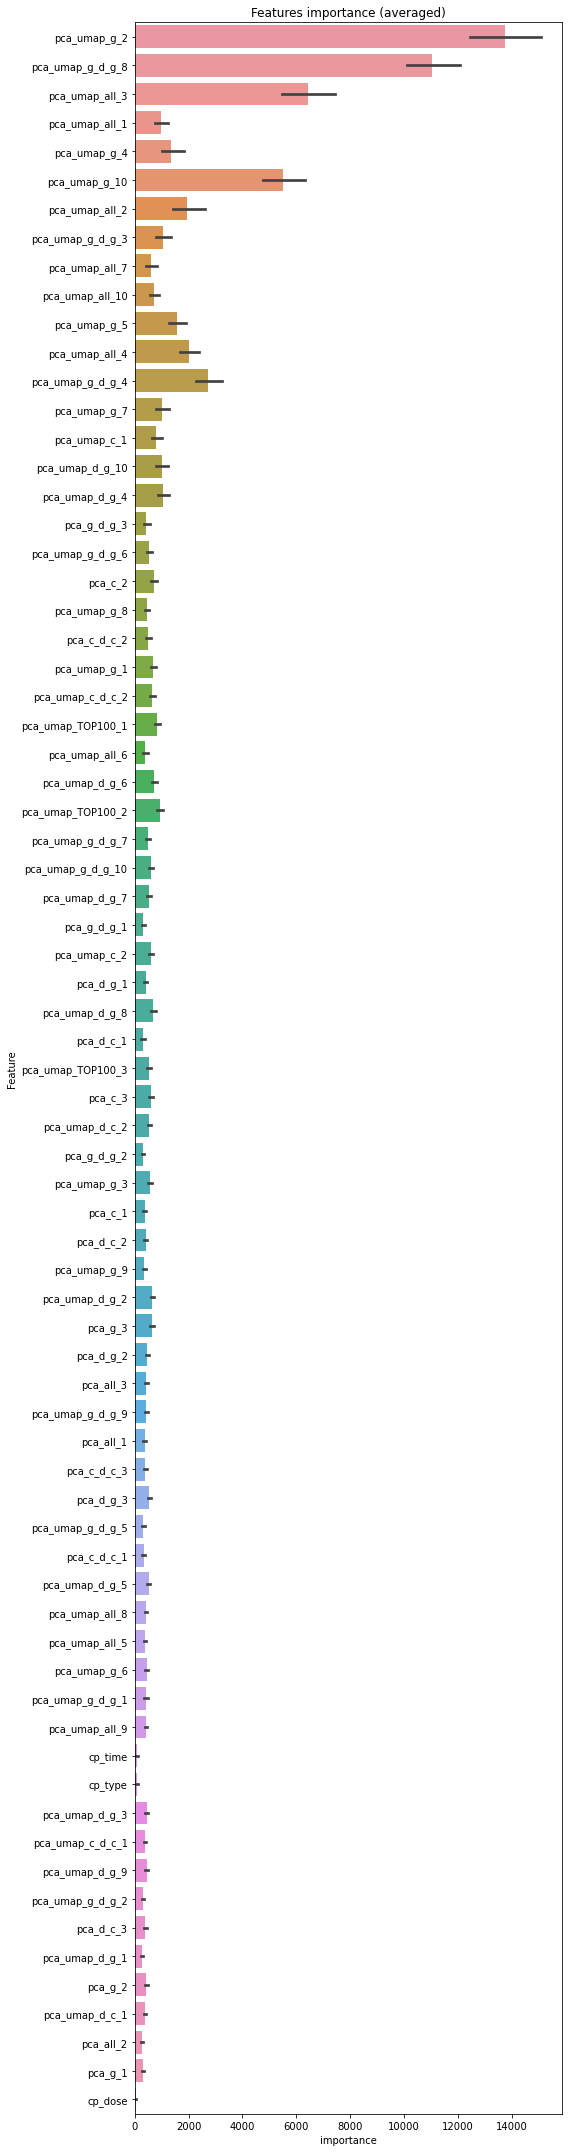

In [53]:
if DEBUG:
    show_feature_importance(feature_importance_df)